### Import and initialize things

In [3]:
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import numpy.linalg as la
import sys, os
import pickle
#import rbf as RBF
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
%load_ext cython

In [4]:
from FME.geological_points import IePoint, IPoint, GPoint, TPoint
from FME.geological_interpolator import GeologicalInterpolator
from FME.tet_mesh import TetMesh
from FME.dsi_interpolator import DSI
from FME.foldframe import FoldFrame
from FME.fold import FoldEvent, DSIFoldConstraint
#from FME.structural_frame import StructuralFrame
from FME.fault_segment import FaultSegment
from FME.region_manager import RegionManager
from FME.helper import *
from FME.svariogram import s_variogram#

### Build mesh for support and model


In [15]:
#First mesh is for the interpolation support and should be larger than the model area
boundary_points = np.zeros((2,3))
boundary_points[0,0] = -20
boundary_points[0,1] = -20
boundary_points[0,2] = -20
boundary_points[1,0] = 20
boundary_points[1,1] = 20
boundary_points[1,2] = 20
mesh = TetMesh('SectionSupport2',)
mesh.setup_mesh(boundary_points,nstep=1,n_tetra=100000)
regionmanager = RegionManager(mesh)
regionmanager.create_region_from_boundary_box(boundary_points*.6,'r1')
regionmanager.create_properties_for_regions()
cg = mesh.get_constant_gradient(region=mesh.regions['everywhere'],shape='square')
# # second mesh is for the model area and the points can be moved around. No interpolation \
# # is performed on this mesh its just here because paraview can contour mesh objects not voxets
# boundary_points2 = np.zeros((2,3))
# boundary_points2=boundary_points*0.6
# mesh2 = TetMesh('Flower3DModel')
# mesh2.setup_mesh(boundary_points2,maxvol=0.5)


# boundary_points2 = np.zeros((2,3))
# boundary_points2=boundary_points*0.8
# mesh3 = TetMesh('Flower3DSupport2')
# mesh3.setup_mesh(boundary_points2,maxvol=0.01)
#First mesh is for the interpolation support and should be larger than the model area


### Stratigraphy interpolator

In [38]:
stratigraphy_flat = DSI(mesh,region='everywhere',shape='square')
# for i in range(-15,15):
#     for j in range(-10,10):
#         stratigraphy_flat.add_point([i,j,3*np.sin(j/5)],0.)
#         stratigraphy_flat.add_point([i,j,3*np.sin(j/5)+1],1.)

stratigraphy_flat.add_strike_dip_and_value([6.1,0.1,1.1],90,0,0.)
stratigraphy_flat.add_strike_dip_and_value([4.1,0.1,1.1],90,0,0.)

#stratigraphy.add_point([-6.1,0.1,3.1],0.)
#stratigraphy.add_point([0.1,0.1,6.1],0.)

#stratigraphy.add_point([2.2,1.,2.],0)
#stratigraphy.add_point([2.1,3.1,4.2],1)

#stratigraphy.add_strike_and_dip([1,1,1],90.,0.)

stratigraphy_flat.setup_interpolator(cgw=.1)
stratigraphy_flat.solve_system(solver='chol')
mesh.update_property('strati_flat',stratigraphy_flat.c)

Setting up interpolator with 2 value control points 
        2 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000



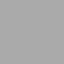

In [39]:
import lavavu
lv = lavavu.Viewer()
mesh.lv_plot_isosurface(
        'strati_flat',
       colour='black',#  colour=colours[s],
        isovalue=0,
        name='strati_flat',
        interactive=False,
        lv=lv,
        draw=False,
         region="r1"
#         region="FaultSegmentRegion%i"%s
    )
mesh.lv_plot_isosurface(
        'strati_flat',
       colour='black',#  colour=colours[s],
        isovalue=1,
        name='strati_flat_10',
        interactive=False,
        lv=lv,
        draw=False,
         region="r1"
#         region="FaultSegmentRegion%i"%s
    )
lv.control.Panel()
lv.control.ObjectList()
lv.control.show()

### Duplex Example

In [69]:
#%%snakeviz

floor = -8
roof = 8
fault = FaultSegment(mesh=mesh,name='FaultSegment1',shape='square')
for y in range(-18,18,1):
    fault.add_strike_dip_and_value([-15.17,y,floor],strike=0.,dip=0.,val=0,itype='gx')
    fault.add_strike_dip_and_value([-6.17,y,floor],strike=0.,dip=0.,val=0,itype='gx')
#     fault.add_strike_dip_and_value([-4.,y,floor],strike=0.,dip=0.,val=0,itype='gx')
    #gx1.add_strike_dip_and_value([0,0.1,roof+stack],strike=0.,dip=0.,val=0)
    #gx1.add_strike_dip_and_value([0.71,0.1,roof+stack],strike=0.,dip=0.,val=0)
    #gx1.add_strike_dip_and_value([3.17,0.1,roof+(stack/2)],strike=0.,dip=40.,val=0)
#     fault.add_strike_dip_and_value([6.17,y,roof],strike=0.,dip=0.,val=0,itype='gx')
#     fault.add_strike_dip_and_value([4.,y,roof],strike=0.,dip=0.,val=0,itype='gx')
    fault.add_strike_dip_and_value([8.17,y,roof],strike=0.,dip=0.,val=0,itype='gx')
    fault.add_strike_dip_and_value([15.17,y,roof],strike=0.,dip=0.,val=0,itype='gx')

#fault.add_strike_dip_and_value([0,0.1,floor],strike=0.,dip=90.,val=0,itype='gx')

fault.add_point([2.5,19,1.5],0.,itype='gz')
fault.add_point([2.5,-19,1.5],1.,itype='gz')
for y in range(-18,18,1):
    fault.add_point([-10.5,y,floor],0.,itype='gy')
    fault.add_point([11.56,y,roof],1.,itype='gy')


fault.buildFaultFrame(solver='chol',gxxgy=0.1,gxxgz=1,gyxgz=0.05,gycg=5,gzcg=0.1,shape='square')

# #%%snakeviz
# floor = 0
# roof = 5
# gx=True
# gy=False
# gz=False
# fault = FaultSegment(mesh=mesh,name='FaultSegment1',shape='square')
# fault.add_strike_dip_and_value([0,0,0],strike=0.,dip=0.,val=0,itype='gx')
# fault.add_strike_dip_and_value([0,0,1],strike=0.,dip=0.,val=1,itype='gx')

# #fault.add_strike_dip_and_value([0,0.1,floor],strike=0.,dip=90.,val=0,itype='gx')

# fault.add_point([2.5,19,1.5],0.,itype='gz')
# fault.add_point([2.5,-19,1.5],1.,itype='gz')
# for y in range(-20,20,1):
#     fault.add_point([-10.5,y,floor],0.,itype='gy')
#     fault.add_point([11.56,y,roof],1.,itype='gy')

# cgw = 100
# cgw = cgw / mesh.n_elements#n
# ogw = 300 
# ogw / mesh.n_elements
# fault.buildFaultFrame(solver='lu',
#                                    gxxgy=ogw,
#                                    gxxgz=ogw,
#                                    gyxgz=ogw,
#                                    gxcg=0.1,#cgw,
#                                    gycg=cgw,
#                                    gzcg=cgw,
#                                    shape='square',
# #                                        gxgcp=10,
# #                                        gzcp=10,
#                                    gx=gx,
#                                    gy=gy,
#                                    gz=gz)

# # fault2 = FaultSegment(mesh=mesh,name='faultsegment2')
# # mesh.regions['fault'] = np.logical_or(fault.interpolators['gz'].c<0,fault.interpolators['gy'].c>0)
# # mesh.properties['REGION_fault'] = mesh.regions['fault'].astype(float)
# # fault2.add_strike_dip_and_value([4.3,5.,5.2],strike=40.,dip=40.,val=0,itype='gx')
# # fault2.overlapFaultSegments(fault,mesh.regions['fault'])
# # fault2.buildFaultFrame(solver='spqr')

# # fe.drawFaultTopology()


Setting up interpolator with 144 value control points 
        144 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000
Setting up interpolator with 72 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 5.000000
Setting up interpolator with 2 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000



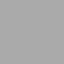

In [68]:
import lavavu
lv = lavavu.Viewer()
mesh.lv_plot_isosurface(
        fault.interpolators['gx'].propertyname,
       colour='green',#  colour=colours[s],
        isovalue=0,
        name=fault.interpolators['gx'].propertyname,
        interactive=False,
        lv=lv,
        draw=False,
         region="r1"
#         region="FaultSegmentRegion%i"%s
)

lv.control.Panel()
lv.control.ObjectList()
lv.control.show()


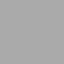

In [24]:
import lavavu
lv = lavavu.Viewer()
mesh.lv_plot_isosurface(fault.interpolators['gx'].propertyname,0,name='Strati0',interactive=False,lv=lv,draw=False)
# mesh.lv_plot_isosurface('strati',1,name='Strati1',interactive=False,lv=lv,draw=False)
# mesh.lv_plot_isosurface('strati',2,name='Strati2',interactive=False,lv=lv,draw=False)
lv.control.Panel()
lv.control.ObjectList()
    # lv.reload()
lv.control.show()#nteracdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABAAAAAMACAIAAAA12IJaAAAgAElEQVR4nOy9aXNc15Wm+5wcME+cwFkiKWo0VZYt2eWpHJarPFR1dZero+Pe/tAfdP+B6he0/A/sf2B97+iS7612ubqjOsAOl2dJoESLlERKAClOIAlkYkgkcjr3w+ba2mfMkwOGBNcTGYhE4gw7M08i33fttdb2fN9HURRFURRFUZTHg9xuD0BRFEVRFEVRlJ1DDYCiKIqiKIqiPEaoAVAURVEURVGUxwg1AIqiKIqiKIryGKEGQFEURVEURVEeI9QAKIqiKIqiKMpjhBoARVEURVEURXmMUAOgKIqiKIqiKI8RagAURVEURVEU5TFCDYCiKIqiKIqiPEaoAVAURVEURVGUx4jCbg9Aac+nn35aKpV2exSKoiiKoihtmJmZOXv27G6PQmmDGoABoFQqlUql8+fPT0xM7PZYFEVRFEVRYlhfX7927dpuj0LJhBqAweD8+fOfffbZhQsXJicnd3ssiqIoivK4sOAvLPgL/TrafGu+RNyUvg+rcAB850EPHsI0eOAlHNFPeDy0jQ9lOJiwS9LBMx5ftvzmx9987vxzDx48yLyPsmuoARgMJiYmLly4cPnyZfUAiqIoA0qi+EtgrjWXZbOF1sJCfiHjMV/yXpphJvsYemTOn+vPgZrBokWjSqsAjAVE6rw/X6Yc2LchCrgOY5DPLJq7oO1esRu0oCXjbDmP56ECo5DrwQOYvzahAfWEbXpxF3Yzn//6pf/6yvoragAGAjUAA8Pk5KR6AEVRlL5T8kvzzD/SQDW4x5w/xwQUPhde8835EqVHIsxKMS8gyy76F3du0D5swhAMgQdNyGfar+NBdqeD+04DinLfqPkqNGA6qJhDeHANjsqrNCS7exmeV5ZtYvcidUcrtX3njtH9W3I5+c6ltQIH5ZHsxwz91ey+CTPB44RmG7rGc34qA4IagEFCPYCiKEpHmKD7o5++BOA95v35slc290Giyy24DL+Dr0EThsQD+JCTm+sBQnHZHRNATViDgxI5LkBdBtN3suvg7hRzRqwB8MX8tGAqw3iajpHDGWFbpZ5xm653dLfxJULvGssclGFSnnK6B3CPGT21eXwkbvs6NCAvt14uoT3iFZVsqAEYMNQDKIqiRAkIfflZphwWNLH6xor4OlyC0zACeVGNLVE2nnPHEFWTXeinTmXTOgzDYfl1B7p5Z4yXkyxAe6foaOWKqP+2r/YGDDsvUXT77E/NEqutk/6UPUG/BqPOAW34v9iDA3FZg7G4Le/DrAxjDYZltkTZ76gBGDzUAyiK8hiy4C8ssACYQH7JL8235vF5JPRjSZL7sT99uAdleB6GnGhoSzyAnSsI2YCu8SN30qlBA0adUG4dhgEodpAF1A0pWjblRe6jDSjKLMcGtKQuti334Fg4Uyvs0zodattUnNi8mqTj2/yfVTgU2bHsOD1kJirpOCmYty8feQSYdnKrzFRSFYa7urw9Si1tWT4wqAEYSNQDKIqyvyn5pTnm5pmf8+cu4qSt2zCwvSURG+5N2awJ78MRHmX/u+rfpGcgj0eTyDtSS37wfvRZxB5tHfKEy3ebwb26m4LISKwHSD9d3ycE1oDM6t+HhvNWptPH/KW2L1Toryb/ZwnOO++g+VkVw5l9miLp1L6TB2V/mqj/pONph6AJdamX6PBlmW/Nd7C1squoARhU1AMoirLPmG/OzzXn5pmf8+YWvcVA1DZKiqJqS2xe0Dpchz+DISfOagxAXQyASy6oujJKUveOjf6mj98EZY9Eor9+MKmjKjkkPZIe7A9lPWU/pqEXkb0FLTiQ+dTLMBYJ/6eMoQsPkJ5z33bOpCUXgJ29Cbm4NWdUfuSvKQePTlLZNkqhl2IyMs48rEMxuH32OhBlQFADMMCoB1AUZaApNUtzm3Pzjfm5xtxF/yJFKAR678QQG4CP3Sz2kWjuh430fwIFmHK+GH1R/zVYhwaMyy6eE5cNKaroqf3IfSv9G1LPGtrS3qnDDByNO2xN8n8M41Dv07d6pwk/HR3ZEJo/SWlfYxmH8U7y+EtwPOFCSpLRWcRu9h3Tr1J7JbQku8nuZY7WgK0M48kySN8xGCEqEF1idMqZBLAHzDKMlI5Myh5DDcBgox5AUZTBYmFjYa45N1ebm1uZW6wtPmpkadtZum12stBLXop7fwsuwRMw7Ch7V/3fhRycjnSeyTkD6FT6V+EO/AlqwQ3MzyJ8Hc4lt/cJ6TP6URDsOXe2talLW6mdMYMriVZc/s/2XVTuNtHcsLYFANW4SuVlGJFZgt7fi0bCSxptDYR8EqMPth3GDpSkK31CDcDAox5AUZQ9TqlRmivNvfXgrbmlucUbi3wfylATnWHba2ZU/24ihB/RWCkB2lgtaI62BCU47yTktGThpA1Ygg8AWINnJRHfnQdIzzAJSf8mbMF9mIcGHHdeBHsbgfMJAW97zFYkrBsdTC9stwcg9c3qcQwPped99K3vemDZ982SEeReD7Etem7DKDSD108XAzNnie3t48flthnysCFTXpa2tm27Lxilf6gB2A+oB1AUZQ+yUF1468Zbc5W5nz/8OR604B68ApsSj/Ti1L+hOwXWaWK62b4Jl2Ecmk7A1YT/12EJ/gTH4FX4LfwBvghHEoLl0dQLglKvBivwPpThApxyotR23yEYaxdM9eO+wBuQc5q69M4OeIDQ6fqCqW09laz+t7VamgShHE1/8mX9r8/gq5GDLENOkmp6fBf8hDWA/dTOUSPJkyFJ49EZgMFBDcA+QT2Aoih7hPn1+Z/d+9nc2tyl+iUqsATjkIcKHIRDsAI4WSuh2H+W/B8rQbInZkR/2uOswoeQh1qwLtPE/i/DSfghHIQTMA+/hxfgFEwEBxydB3Clfx3KcAXuwnPwdRhzmo3afQtQzKC8Y/86khzQ7Zqd8QAp72MXA2iJF8qeS9Yd6WNLipd7js9sQgVuw3Rks3sw5ZjS7jA7bsDBuOtzM64AwA7SgyqMdOgBlAFBDcD+QT2Aoii7SKlR+tndn/3k9k8Wa4vkIA+jcArehVNQhBX4j7AMraCCd7OA6ESx9aJCPEefrcJBWIQqNKRfilX/p+GvZdmpArwMT8IvJR1oyqlecAfTkp9mJmENrsEinIEfSqfRUHK/F/dg0rNO2ib9r21fk5RjDgomoWs2Vf335enYy7Vt0XA0+QdnlmkJDkbmbVowDmVoBCcBunhzfdiAkCgwo6omrA5mt8kl19y3TQdS9jY6W7OvsB5gbW1tt8eiKMrjwkJ14bUPXzvzuzP/8Mk/LG6J+jf9fCZgFFZhCf4CKk4xov0ZCv+TeRLA3knZPiX8b2jCFDwFDdiAOrRgE+7DZTgDfxtsPO/BEfjPMAVvwzLUJEzbCnZBMfJuFT6Af4U6fA9ehgMwDAVZbNjc8sHVx9Kb8KRkbjS3R5Ntaxy9j5iw+npq+YTdsms6nViIbm/D/1W4Dl+J2+U4lKDuFAFnHLPv3AyjcQP25PGU55KXSzr986UMIGoA9hvqARRF2TF+dvdn37n0nbO/P/vmvTfLzfLnWT1G0eahCU/DEpyEw7Ape7paPBfnATJqnV70hyeZ9FPwJByCEtSgBkvwPpyFv0nIkSjCt+Gb8B7cgPWgDbD4sAwV+AF8HQ7BsKP77fPNS9pP+mizmKJhqHb2MmRlF6VeRilv7piQecpESo95QbFKuqMd3cSwFcjD8biND0PVSUsLPc1YYvsF+VBJkHsb7QbsOW1q1QPsLzQFaB+iuUCKomwrpUbpJ5/95Gd3f7ZYW/z8UTd4bwPbLXgG3oVvQclREm5egRdR//0iKfAfytovwBF4Bt6BTWjCe3Ae/ip1aS0PnoDj8B68DWfgKIxAPpinsQFfhlkRfC1nd5wJEJek4tGMDG9bkevezwVqidsMPf3oq9HdS9SXLCnPKf/9FF5M0GLTkoWfcVYnZZvx5MfbvgijUJEtk56mpgMNIDoDsD/ReQBFUbaD+fX5166+duDfDvx48ceLWxH1b+/bCLcPB+H/hk3pQxIS5X4wHE6yDUgP6Eb36uggI/A0tKAE78Oz8P1sC+sW4WX4WwDegdtSSGBzNlalvtP05xmSRH9knqQL9R/71W23fLCdUmwHwr0d+cBQR50WVJyMl/66yrZTNNmP40ET1qEMzyRsNiriuxmX1RMi9nE71VBJGOFaQl5ciGG4J6tVpGypUwEDhRqAfYt6AEVR+shCY+E7733nS29/6c17bz56yE2Lx7nvzgD4UIRJ2HRirq4487PNAMTKlCxaJCn8Hz3UMTgC1+E5+MvgIrttKcBL8ENowiVYgqpkbhSCK3bB5zUS0W/gHmP/hjtd9QLKLuy2T+e1vQBCRNX/lrRV3abZpN63QUyvD7fhbMJSXEARZmA1OHGUdMCkB80rk5QKMNNuqPaVPAhrcsUmP82L/sV2R1T2CmoA9jPqARRF6QtvzL9x9uLZi+vOt3uWeLwnDcjXoRmn/nHStVM8QEbtFUrsid0mhVE4B1+BVztU/5Y8/Bn8JdThsvQ7anaiC7OPNoTduCnzDx1NArQ9V9QD9N0GdDoGiw2N1+AqHO/2Be9lbNlPZ9+aIViBl5K3z8ExMQApNQBt1X8tUntjaWYbubH0k7ARWXtOGVjUAOxz1AMoitILc0tzZ/7pzI8v/fhRVx9DKKDu3o8agA1Z9Bfnp5sCFNX9bXurpxAdW0axkoPn4Dvdqn/3OF+Ab8MmfBRs75i9l0vXAmsp0vG9X3RnzDIeOePBoxeJzXLZgg+gAsO7Kk+ze48iHEuOzQM5mJHGWS3H54SOE3twnFfmFhxNGGfSIgDRje20Xkk9wD5BDcD+Rz2AoihdUKqVXn/39Vf/96uLa4s0YEga3rvEqu2QAdh0in3dXewMQHr+Tx9VJu1OdKJn9W/JwQvwDXg22/aukuv0Kbvb34fD8sp3sXunW7rvZheJN13PJETV/59gFV7eA8I0ZQC+M2Y/Q5HJONTjpnRSnGTolanCaLDQvNMPmvvBMc1qb7XPBVL2PmoAHgvUAyiK0hFzS3Mv/ctLP73600dKwvSzHwu2n4+dBwgJwYYj8QmKCUSn+t3Kxyhdh//NlsX2W3VGHk5m2KwX9R86Ti1DR9FeiPUA3SUIdZfzYx8Mqf8KfC2h4X1oYH250jolJN9Nbthsu2GMQUPWpoj1AOlnacJNONv9qANYDzADN9UDDDxqAB4X1AMoipKFUq30+juvv/qvry6uL35eW9mCj2X9WkNb9W8NQGizqBnotCFj242j2mgvyJSkqG2P6t998avBtYT7kmvUdeZPisjui/626v8yVOGrMJLsRno8Y6ddlWLP5XbyMYvNPWx3HDPnZg0AERuQNNqWnGIsYc247vpEWQ9wCKoRD9Bp5Ymyq6gBeIxQD6AoSjpv3XnrzD+d+emHPw1If1On+wBaokiSNGs0/8d9nKBatT+byRItu9Y0tLI1Td9hmeJvv/o33IQTnXyxdxeDz7Jj0pZd5AglYdV/Hb4CI47z2Y4wvx9362LktjD3M2msmcIQ5GArbgYg9sjuOBuwAE/342oPfcZzssZfGYCGrJ7RzFxVrOwB1AA8XqgHUBQlllK99PpvXv/7X/19uVYOaxdTsFiERRiVgKKb1o9zPzoJEBX9oRmAVlCrdadXfFnEtxk0HtHzbjdJMnG71b+ptx7bqRSXLjxAjzk/oUdMq6UmvALDzmoSHdHFxeZG8Ts6i93LrADwAXyh3RjMwhG1do2AiKh/0/t/IiH8n0T2Vy8HQzAGLcjDGAxBdW9MtSnZUAPw2KEeQFGUKD/6nz/66cJP4/vHF+EITMCHyZIiqv5Dqf8pMwDZhVQSDVgXndRy8iWInHebaBsV3m71b17wRmRlsX71U+puA3fLPh7NcB+Al0X9b9Nb7ErqlgS5G7DV4WILVqCbwtwr8II0LEq5bPIw4qwpQcLGfvCnuRI+heeC2/fisaOTAKH1+1owtQ1VNMq2oQbgcUQ9gKIoLj/5w08u3rz4+fq1BL/vczABU3BLpgLSc7vNX/POg+6d6AxAM0Egpkg6908bUJJmKfYWSgRyPUZKB5WOyJgKkqLYDNnTnNIzW+7BoUhadteyuNPkq15oaw9irw2z+NpQMPNnO2iJ6DcN9UtwE96BT7LtHgr/N+ABbMAXMijyAoxKgk3SlRYq/DVn2YDx/slxe+rQ5Rd647QAYKAotN9E2Y9YD3DhwoXJyZRGxIqi7HPm783/w7/+A7NAwle4+aI4AbfhLoyIIomqTFehDgV1Q+wds2P2pbJCNGBFEqlDY8jBCGzBEjyEp+B4JOTVVq+kjCpLNnYXO3Y6DHeDh3A6c/JPH7Wy14Pyi1X2sUeLPn4Q6lL425dTRzEX8BasQxluwT2oSIf+U5nP5Sb/VOB9eNVR53YSIDqkHEzJMl5tp5jsWepwHb7Rc1VuyCp7wUFqts+Aowbg8UU9gKIowGv/4zU8HnX6d7GSy3xRFOEsXIWvw5oTYs8Fd/FgODJLYHVD6I45QjO4ZUbW4aETGW2J9FmHe3AevgBFGIaj8JG0XAwNw56xdzWTZeTRbTqNfCfRimsAmjJRk87OaLtOz+IFxWgRlmCqT2dMEda34A8wDEfgRZiAYcjDeKr5CaXl+PIeXYeTcCRu+1g7dEDcbN65et3PkfvTfArWZZDR5Lq2A7bHdw/oBbN9OpqsU/YqagAea9QDKMpjzuv/6/VL9y61SaG2fzoO78MYFJwGJr4jCzyowpSE/90NUmYAjM4oZE6MacI9KIk6MTk/VSjBLZiGH8IhOWYOCrAJazCd3CKzu4z87kS/+yd7a0IVfg8T8GUodpiiuyVPlp7zYTqaQAi9rX05RcrR3D/lsi1kmzHSn/R4E27DXwXrjK3RzYL7FpfhNvxdxKeZAbTkV/evB8CHURgSDxCbOGTPUodP4JudPFnXpfjSP9SMqggFKMO4zNSNwIYsYKy6f5BRA/C4ox5AUR5b5hbnfvrHn+JB3knZD83y+8GZgSdg2SlMxNnS7JWXOoGGs0GKB6DDRIUNWJQcJJOWXYES3IYcfBteCiZX5MCH0/ABfDUijtPD/7FBWXvk9NrltllAXkTp1uEBXIgU8rbFh0/hZLZa2N7nHGLFa0YyPq8sHsCDMhyKG08vcwsWc1lWoSjWMbpX+lDd45ja3/fgq3HOwc0Ccq/Ju5CDZx37Yf/kBz8+LZlhWIQzMJLhybpHaMKmHL8Ih5zBIysW26c5BBUoiCUoZE48U/YSagAU9QCK8jhSqpZ+9N9+9OgXG29uG9Cdhk2YgrU4BVyCM/B7+DYU4jxA0p0sjYBacBduQB3qsAUVKMM9qMMF+CbMOkLNihKTsT0PmzAep+T6kgWUUQfbOGsuqCBNTstoh71lDE1YgydTkzRIfTz9T9k3S1fDHb3CbYW1B2M9nyUJG5JfhOfaWbLoUKMx9TrcghF4Itu7swlLMAmnIlXOfuRmqgu2YAEm4SlnDDgXmOs8cQ5VBV9EvzsXkYL7ypsFGYZkGMqAoF2AFNC+QIry+PHa//daeasMok5SAq6hgGUZhiR85AbvmzAl7Tj/BVpQdJIW3FmF6J1Gu3mAKrwPV6AEy3AXFuEDuA6H4W/hB3A08p1mTzEMQ3A70h2orWrPEtxNH3msVrO9St3sqSKch486bDDfguVgF/ztU/8hWlCCTXF6NSgnvBT9jRDbQ9X7d0wXK4Kb0t0yH8n/8bKd3Sb/rMOH8M3kLrqeo+8fwibMwrhkduWC17Yb9W9CHSpwDTy4kDyY6FtgpsjGYNy5Jjua0gFysjxIUeYKlEFADYDyCPUAivL48JPf/eTnH/380S8+TEQ6BqbINROJH3a+QIxiWIPDADwBw/DPUIdC0AOEFKq9kxI49OEu/BoWYRnuwQ34GD6Fcfg2/EBKM2PHbBOTzsDlSEv1LHSqh0gwBlaxbcGqiEs3TJuDWXgoEdn0w9pbAz6A493m9nQqzd1TN+E6LMAHcAtyTqa4F3nTu6DtjhnnjtoS9YTmCa7AiWCKi/ukXGMcHapr+WpwBb6QWrRgjmlScaZhMlX622up4aj/LfjzuMPGDm+b6OLDouwSagCUz1EPoCiPA6XN0hv/9sbnv7u5OlGh4ObTW0wXIPcLpAmTshDVKJyEKfgFVIMegKCQwtE9LvZcNXgPfgN3YQluwSdwAwrwZXgVXoFTkf5FhpAEn4EVKEWUd+yOsYdKJ2U2wMq1OqzB2/AHWAy+7J5EUidhKVss1pd6zQeyAHASSdaoF13owwYMw3l4AU5KmNyTJZkzkj6MdN8yvA2K001Lq8DRoF/N8or5zh238f/zGXa/GTHMoXQdey3Z2P86XIc1+G7k+Dum+5UBRA2AEkA9gKLse17/59fL1fKjXzwRHDb13I1Jk/wtsSrJDGb7DTgOLem6MwrH4Qj8k9QLRj2Aeyc6A2ASIf43vAdLcAduwE0AnoNvwCvwNBxKyKnwpX2hpQ6bUJZ8J1elZSSkyL12KUChzJ+aTGWcge9DHS7DlhPD9qAA5+HDdrnUviMub8NwckFfkmbtXRr6cFtqcN3iYxuxXoGHqaI5NjGso6Fubk/SuXlGW84iA17wr17m3DDj0N6Hb2YoujQLWuec3DAiJ3Lf+i0owUfwAH6Y/FH1Ij+3k3l/ftvPofQDNQBKGOMBrl27Vq9vU36loii7xsLKwpuX36QuOsaoz1xCPSXJqsUkn9hw6bgolRzkoQAjMAun4RewKh7AzaI2mDuh1HyT1vIL+ATuwmdwCxpwFr4MX4Jn4XjymKOYHizILklx+tj7SaRoKXt8q9Uq8B58At+Fs1CEC3Aa3oEN8SpGdx6ADajEjcG+2jjZRFecOlEvIlVjh90X9W8KAIYjuTHINTABo3AH1uNywKJj6MIDHIGt7Uk7MWc85dwPjSFJPYXC/2ZNrhOSHZdOQ3LoY88YTfq/Bb+DAvz7/i362zMlSrs9BCUT2gVIicF6gPPnzxeLe+b/iqIoPfPGv74BTtS8JZq4FuwEakkJKzac3kFDTvK33X0YDkMefgk/gGmZZ3Bj877jQwyr8Gu4DhuwBhtQhBMypTAtXQhbMAIjceuO2cO6KnwdRoMLKrX6GgRLitQ2YQXm4Rx8VRLKAQ+OwTS8C0/AETFII3AEPoPJZLFuU/BX4QG8nFnTdxdod5+gtR81WJFrxu7bcryceQsmJEflC6I40seQpOajfzIpQIvSk77vTEYmkdoG/g3uW28a//9ttjeoHmnfaS9U95hbUIYrkIP/ADNZn5CiuKgBUOIpFovnz59XD6Ao+4mFlYU333mTSSdxworgpGhxPvKIS0sy+G0Oui+b2Z7ikzABN2VxLj9OSNkFfa/D/4H7sA4VyME0jMMQlKEiiwwMwwiMwRhMwBRMwXicE7DHL8GME7G2QjYllJskvr3gr0R+tXJtCz6BO/BNmIlrUjQGX4OrsAbnJHZ+Dt6FpyEfOZ3nRIJr0llyJG6o2cP8GfPa3ZyWj6AGLzmFsGZGaANuwn2oyyTAAZiEF7ch4cCHkjQ/JbM675SmOEZ7YSele7n3fafx/1cyLxlWibuAzUfJXKhG/V+DFXgZTnQ4meMlfPqUxxI1AEoi6gEUZZ/x2n977ZFet7rBlO2aRXNjG6qEQryxrMNBUaVmlVAfVuEgFGALvgwTcb0+3XyJDfgtvANrUIG6JEOXoOyMISeSKCf1BsYPjMEUHIbn4WxweL70yjwhnVV8R8/ZY0Zxt2lLSPqb3vyX4DB8D4aSj5OHF+Au/AmehzxMQQPWkvcy4f8KfAwnk21PiK5NghvP/hjy8DRMOHlHPlThBrwPs1KbMdaV6E/KfSeiXM0UkPvco7NAfSFU7+5lqPoweV93YBROZ36d12Eq7nFPLtoiTMBROAfH2h3Nlfsq+pUIagCUNNQDKMq+Yf72/MVPLzIOdckY9mFGovJJ7RSzaLgZqEINpuGA7GKzme0youvOLlFJ9C9wFVoS3SeYOB7S/XmpNCjAsOwyAdNQiRthHTbEkLRkPEYSFeVpWqkUIlT4S/BXPyj9bb3vZ/ApfAVmE8qUQ8cx6UBX4BwMwUn4BGbisoDMI3Uow0N4KdvKwd2pf5vIfhduwxi8CMOOLfTEjazAO/C3MNWPGgM7vKRSDeMYp1N1bcpETfSA6bQiHiDpOdrsrCo8AS9mOLilGHlh3TMiV+lJWIdrcLLbvvvqBxQ1AEpb1AMoyv5g7vocPmyJ5PUkvaHlpCi4wVRXH6dgev6MOorNzjCEQrPR0ka3JPRLcBLuQwm2AEfuW8WfE9FfkFygIVH/IzCasBapkbBNmZqoOVk0PoxIF9EUD2Dxg9t4ju73JQ2mApdhBL6XkJwTi0kH+hJchWl4An4LL8Z9S5u8rCbchoJE4jsly6hMwskiPITD8JLMSITeR3NRXYYv9k/9W1Zg1Anzm9acJul/WoaRRcv2PjnQTDZyrgM0W47CeOenGHImVUjwAObnJIzALZiGI52cQqW/IqgBUNqjHkBR9gGlWgmCqxqZxXq7qIW1cqogi+zGBqqTfkYfzMFxOCF58+vSs78iwsuG/POi/l0PMCSLE9+Fo3EDrshKpRvQkOWTtmALpmHWmXPItfMALjabyLb5X4Kr8EU4nZxZlH7A5+E2bEiTx+GE13YYFuC4kyaUcq7YtyYFHyrwIWzCKTgXt6Kz3bIBD2ENnum3+geK0HAMQEGSZKI2kk6kbfo8T9IuTec9jV4k5qUY6q0hTy7y1PzIrzYd6AQsw8fyBqWMPJoFFHUCGSdMlP2CGgAlE+oBFGXQmftwDoIJzaZ416zq5X6sfZF6dq6A4B1DXtJvCkENGivx00Wq7wRQTTjftE00zfvXnaqAgpP8U3DMQAGasAzPRQ5uWwDdggqswyqUYUtegS/DszAWLHjIrmWbkpFv+vd/z5kP6QKT47EGn8AqHIkzEsYAHIJDIo47lfhJ+LAJl6EBTw6lMOYAACAASURBVMN0cAGH2O23YB5e3h5BMQnX4Ylsrqw7CRud0Eja3RO37Dm22c78pKzGkJFNaf0UOmlUuHsyjMNQg4/hCByKG3AX0yPK44EaACUr6gEUZbApBpf7Nbk6M7DelfA1K/4OOavwxu6e7gRCqqsV2asAkxL0NZMDNeklGpoTMBtE46AmPL8CN+EO5GEMpuEsTMMEjMCHcA++CgekSjg0fjvC2GDzFizDn+AFeKpP7W4m4YewkSzg8nABHmYrAHBJ2bgm7X2eg9Fs9d8NuAeL8LzEv/tODqpOsnv2lCqX7vxA1AxY6V9w/prPUOaRhQ3HS4eGFFsSbbYchtPwAB50OAmTPmWkkwD7HTUASgeoB1CUAaYpgUMkn2Go3UKqSV8ReUk9H5YqAuSwRMR9xtkAm0uTsr1teelL51BPigSajgANaZcWTMGrMC5LARRl3sBIt9NwC34PT8MZSappu9KToQkfQgn+Esb7GkzNwYTTAz565JNwO4MByDKkFtyALXgqIdE/FlMkUIchuAyHnRLwPnIarsCzCUUa26pTo2bAYK7SrW5rcJM4nrrshh9336QDFWBWpm7OxC2M4GYBZZ8WUA+wr1EDoHSGegBFGVRsuxtDCyZlNd8k2RH7eE6605j0G1eXxP4keQMXc5yGqM+22UQ25uqJRK7FpV+bPz3lyP2c01PInuspEZrzcCG4IKt7x+3/aJL+r8EY/Pk2CF9z3rxzUncYntiYVtyLmXLAED4swyYcd+pDshzQl1j4DDwPv4NnYNxZaaFfGJ2yBSORImx2Q6TWxIWOtN+2M/zUqyjJA9greQzOwF24D+fitlQUh+34j6Xsc6wHqNfruz0WRVGycvGDi4F87iYcjRPcOOrKTWywDx6Tituk8tO2TiAWmwVUgzrUpVq3IUn25tYK/nRvG7KqcYgRmJTw/7CUaRad2mKT0WGKAV6GBbgjjYNsAN4t9m1I2s+vYGJ7VrlyiSpy82sOnoTPejjyKqzAJJyQFjQdFS570gPqBMzCPJTlFesvx+CG816E8HfkZtewG4k7de80O7yKvOB9YwOG4ARMwJ3M+/a+mTKYqAFQukE9gKIMJPZfvkmhmQouChYlml5yThZ4Kgb/2lHaT2wc2qqoLahKun8tgx9oyAZ34XjksF4k4ScXvHnBYZtenONwHarOEsWICmzAJnwCv4Ivwpkd+SL1IqFc88hh0dxZtJq7TRMewjjMQDHyOmQckmnPOgTT8Dzcghvtksq64xAsQy1utQoz5lbEqvXxVhWrkw+e1ODLpylpJY2MrMNERNbHPtnYX60HKEiT0AdxG6umVwQ1AEqXqAdQlAHD1btGPU+IXEsqYQzJhVE4KNtHw/8ZPUAU3/kJVGEDKlCBzYgZCPmBGlRhHW5BKZKV4UUUfyjzJ4lZGIX1oOb2pRD5OlyFv8q2yFcfiQ7YlGLHrn0W3cWXCRYTbD4kL07XotATZTwCR+EMvCsl2v0lB0fgTvL0gjs/k3LrSPfXxVmFljROmu/yHYPaBY24Cbe2HiD6p5xcFQUoJe+ikwCPPWoAlO5RD6Aog0ReEsptHsthiXAn4abUr8EJqIMvrXJcrZ8i9NN/tdhhmG6eJViFddiQmzUDrh+owDJchg/he3HnCin+7Dnup2DJUZy20/9NuAE/hOnd/go1T+Q8fNouC8W86eb1LHTeOChlADmZDpqAZ6AsUrjvWUBnYRFSvmqyKP62DsF8LtagFnFHvkwoxb4OOJuZZadLsNbJE0yK/ad7gKTx5KRQodzJGNoOTNlHaBGw0hNaE6woA8Hch3McAB9qMgNwABrQcqLmsSF8wxZswDEoSdDXdhTNGPJPSf4J3QGWgGC+ftFp+mkzeRqwAlfgMPwoLvyfdCcLoxIDtsOrw234FL7f74Y/XePBBGwmt+A0onYZtuBIv7vW4KSdmKUbnoVNZ3aojxRhJNgPNDQMIkk4XjYfYvatQxk2YQTGIlMNvrNlykEMxhbW4F24IJNm6VSdtSMyZnP5qfetB6hCGabFvfjBbfru05TBQQ2A0ivqARRlAPCgDp5kNZj8n7pU08ZiP81N+AD+Lyf870XEvauQOk3+iVKCWzAOY9K4czjoB8x31xJ8BF+Gb8TJ37aB0rYMywyJCQzfh4/hr2Bsb6h/JMfpEJTgSDBcDTThAVRgNmGB5L4MwHainICzMCode+jrq5SDKbkC3bO7Z4kagCx8CldgFQ7Kclp5aW5rcnL8zLNGNgkHGIbn4F14NcNMUS3SeCp02HSlnuQBgBGoQVkW0+gOtQr7ETUASh9QD6Aoex1PVtK1BmBaqipTosJGQ3wGs3Bc1qXKJ4f/SdX96RLKHNPWA5gq1bvgwRCMSxsf28lnBZbge3AhrvtnX6TnOFRhRILoV+CvtiGI3iMenIV34ZCzNq3pU/QnaMK3ttmu2EmAITgOo1CCoW2ojpiAWruRRN1s0nPfhEW4BLdgFfIwC1Vnna+ik/aTPSpvr/y89OWchy+327fRrhgjKsG9iBeKnRMAClCDEsxkOKzy2KAGQOkP6gEUZU/jwTBsiJppwkHYSl3Dy8TUV+AG/D8iyqOqrm2CTcbwvxu+9eAUHIE157YCLenXaeLNfycN/qNnjMaJu+AkfARTsAaX4S8TWr8npYbvGMOQgzrkpUK6Arfht/DXOzIATyoBzOswClVpydrHV2YclpMHYE6UXn5gLowyPID7UIcZGIE1KMN9WIE1qccdcrpdZSSUgVOAI3Af7rWbgcniMdp6gPR9b8MBIJgFlB21CvsONQBK31APoCh7lrmP51iGKagC0gN0E/y48LmlAtfgvFP+a+cQegz/+5Ff3UdMNPQ5qMImbEo1sDUDx+G7cDL5S6wvemVM6oyvwHdhOG4bOxmyWxitOQvD0JAGSvfhT7ApTZNiywP6OwYreYFhqDgpNP1iGNYyvK3uJID7vtTlKmqAD4dk9WjbS2oNluEWPIQq+HAUxjq8kELFAEV4Gi7BoeRrtQLjmQ+e4gFir3lfZoSSPuYduQj1APsINQBKP1EPoCh7FE8Eog20j0mHkFZCjrIPt6EiOSSNBP0Ruh+r+9PVf/RxD2owDQehLg1/jBkwyvIFOJpNX/YozYtwHb6VoJ9acdlQO08VjkEBVqEMK3ATbsIm3IUntt8AIJUA9kUwzUkngP69MsVkcR96xJ1NMvK3KnW9o47bbMnPlpgB21fqYzgD03LY7jxATs74DPwevpGwfaOTsumMHsB9sAl34FjC7h3RaTGPsodRA6D0GfUAirIXycEweDIDUIQhqQrIJ5TwrsAdeB6OSy2s/VNU94eI1f1J+M5Pu7vxG1OyZEFDev/XYFwqNdPpi+48CQdS1X8zon13HrMwcwVWYRkewgaMwEO4w6OZnx1YryDnvIkjsApjfT1vPs6pxl6Nxif4jkMrRvbyg7uE/jop6t/dpgsbYAY8DeOwAGfitmwkOPCkk2YX8bb9q/nIuLv3N5y/uylwSleoAVD6j3oARdlzGKE/AmXwYRwKzppN0e9v04w/B1+HAmzJZkmpOymKv23yj3vHHs3oftPzp+Wobb/fsjKd2YTHW85qxIXd9gBNKVNegQr4MAxjMAR3YAmOS0b+thJ6+hOw5gTReycn2Tuxp/aC91uyS3T53pCPtflsdrW44QTLl0U0u/LaHrYIT8J7cDSuiDz2YnZH29YDpCQCmUUJnok7RVWCAn00A+oEBgddCEzZFnSNMEXZU8xdmyMPU6Kkh0ROxS6t6sMG3Ievw0lHedtbK3g/RIoZSFL/0SM0nVWKTYeZYRiB8Z1dfDeK76j/uojvpBVqd4ZhWIL/BbcA6WAzCpMyjbO6U8Nz3/Qx2Iy7PHo5+Fa7Dey1Z6S/6RhbkDt2TYkh586QNJk1t9HUqpgsAjc0k+aJqXgW3o68EZW4rrLpv7YdmJ06MLbwaXncrbSpSsl4H6V/qDRI2duoAVC2C/UAirKHKIoQMeJ1WNJsJuI2bsASHIOvQA4qEQPg2oAQXWgXg6sUc47rIFhjurvfWiH1bw2AH1RXO88peBGWJEZegGGYkPzv+85sz04yI61j+4InrTnbbuY5q8XZ9eMKwVvRubkP9jG1LDS3MAFH4KPgNtH8nyzTaOnDsFdjBU5JgD801WbNT2gapAsF38u+yu6hBkDZRtQDKMpeYdJJjWhKKWQTtiIBy5YsifoqTMEqbAIR3W9/xtJF+L8VfLyVnO+xW9ic8oZTmtx0PMDu8jSsSaWESUwahTFYgnuwvhtDGpPF5vry4njBMoPoXy05Z8XofOTXlFtGTZQuvt0NXA9QgBOwAiVn+0aGihqSn7XvXJZuNfMmfArTMpsRPUU+9XRe8i20TU7V/6CiBkDZXtQDKMqeYF1inE1JSLBOIEQV7sGfwdNQgrK4AjfO7d5ScAVBuvoPHdBzhPUeIVb92xkAmwi0i0zBAag4YyvAJKzDXSjt0vAmpdtsFtpeTrHZVtFs/ryT0J8L/hr6U+iWnbZiN6SVc05X0PfkKTRlXe30Y8a+LLHSvw5VuAXvR5bI8BJO1Klwj/oBnQEYTNQAKNuOegBF2XUufnSRMWlqnoMRia+HPpQNWIYx+BaswX1oOikErdTwf0ryTxcB4Fawaenu4juxVaP+t2ArOAPQyuCIthUPnoEV2IIqVKACQE5Kgau7MarhzDMkt+AduAZbyZW+zQzH8VIlfuzN60oNZfQAoWKAUTgD7wOw4RRndySdfcd22oS0LViFefgMvpZcxxx7ul48gOr+wUQNgLITqAdQlF3GgxfgOAB5GBXxOiJ/NWzAQ2n8fxeq8qdo+D97XkdUH7SdDfBEbe+upLbjcWVWzVmXoCH5Ns09YACA56As6n9dlgXYgmW4t4OlwCFMnUnKqU022hF4HibhffgdXIb1iOIfDi4F4GJ1dnqM3wve97pV/+5J225gf5opiIPQEHeda3ec6KejFbzwTG/cDbgDF2EE/iK1kiHFA6Q/nbZJQcpAoQZA2SHUAyjKbvIE/AGWAccAhLJWtuAenIWjcBvWnC/4ULJBdqVrUzJs65W8aC/kyC5uqWIzWe3tGG7s30r/LdgMGoDQi7NbzMCULJlsVgRbhVGYgTI83KVS4IIkuqS8MjkpXD4MX4QvwjG4Cr+Bd2FZ+tXkUyeFPDlUkuj3ItK/dwmb3QNYs1GEc/Bhu0R84j4dtveUnY+qQgk+govwIrycQdmlJB3FviCd6P4FFtqdXtkT6DoAys6h6wMoyq5QqpQowV3YlHYoY5FEC1P724AX4SFUpHGQnQFwpb+9k65dYpVEQQ7rOyrfrtxkKMpCBFswvntRxmjmj7smcV2G2nCKK3Z3QYAcPA3/BhVYA+AgHIYjcBgaUAmub7WTpLwmViLbCpA8DME0NGEDFmAdirARSVojqEdzEcFN8E7szx4JeZukC8D6E2AEzkszriy4OT9use8WlOAqPIAfwOnMTXLdVzu2l1e0mplMo11kMdsIlF1GDYCyo6gHUJSdZ/6zeeqQh/vS7WREqkKHRIhvwhJ8DbZgA1owI8op1PW/X7kuuaAfaIEHRZiCs7AJb8MxmN6luWpf9Jar/k16vTEATcjLJEBDXtjWbnuA5+EXUIFROAhHRP0fgmlZ9XnPpm24TsCdOzLrV1Tgersj5OJEf6zi95zLuPcXJH1+w/2rnQeYClYAR7G72OpzK/2bUIMKLMElGId/D0c7XCIjiweI3WDPXj9KJ6gBUHYa9QCKstN4IrW3pCf6MNQcpdWAB/ACDMEy1GDcyZQI5f8ktbtpqyzTN4i2a2zCr+EoHNlxzRGK/del5Neq/6q8bnWZr2iKJWjtam70ITgGK3AYZuEIHIIDMCVrAw+EenPFui+eagpeSq0B6CLk78tP9/HuXqIsHsD+zGVT/+512HTuV2EVbsL7cA7+HA52W8ec4gFCg1EbsL/QGgBlF9B6AEXZUexXtQ/DsuBR3RFYq3AapqAEVSf+amPzbdV/W9rOGNgJAbOC1Sx8CTz4Q7v1X7cDX6L+m5JSvwHr0lpnU1KA6s4MgJuesYvVwHl4GZ6EM/AknILjcBimBkf9h7Ahc7u4b9KzsFn+nnMnpVF9KL0t1OTK7/x9TH95Q7lJuXbbu7NPdeeCLMMduAS/gqPwLEymviwZxxzdPWqWfOfOrpe8K72hMwDK7qDzAIqyY5Q2S3jS0HMaRiR6bUJAW3AQilAGIp1SiFNI5vHsX/9JsX/7uKvVbFLQEXgJ/g+cg2c6TG/IMqTY8ZsHa6L4NyTeX3V0WFOG2oibBEhZrGpneBrqcNgJ/HetDvcUbdPQUwL/Kfjy0fASjtCX+QG7r5+quQ0256fpdPsx9b7rsAQ34GOYhtNwAEZ7C+emzANEH9HZgP2CGgBl11APoCg7w/zdeVpQhxEYBh9+I/HgljxSCYZIc86voQagttQ1Nn0iRJYca+s3PNExRuuPwiE4Cb+CQ31NBLL1DKGeKqa9zxo8hBXYgKqztq5JPinCKAxL3n9R6oBtKbDNAuqvY8nOETgN0zAJw7s3jJ0kqt3JdrXYOa5GwoxBWz8QOpHXrj7eS/1rKOen7nSg2oRVKMF9uAdNeAJmYaIfBi9jLpA7ztiN1QkMDmoAlN1EPYCi7ARFiXEekEdWISeLENWdoD5O/k9OvuBDyT/me6PVLqifnXxQeyE/CzAKZ2EO3oM/h4l+KAyr/htQgnfgHPhSbHoACnAPbsJ9KMOGKLB1aaM0AeNSB+xJPpVtB9Ta7VLgApyQpquPjyCLGoDsO+ZkbicfWUbAi7syuzuRe8boteE2xWo4t7qzsts6rMEyPICTcAJmeg7/h0ZFRNanWIK20wXKHkYNgLLLqAdQlG1nCBpwAiYk0o8k89QScqPtLZT8UwyqjV5W6vUl4ScUebVjyMEQzMA5+CMcg/OyclkvJ7X5FQ/hj/BtOBjZ7Ak4KnrLrKi1DMsyM7AGazAGFVmpKudMBbjtgHZLf+9i79TdInoZZ9/LXGxrYuSKsmBFPmgJovMDBHUzzp22c1/un/xgzk9D5p1qwfZTG1CG+zAMp+Bwn8L/7pA69QB2/MqgoQZA2X3UAyjKtrKQW+BJ+HfSIBInzG8JhSRzcQYgJ/lCbpVwUiZ9FlGSC6orOyS7nFYORuEELMDbMAXHoet/Elb912AJ/gjfg5m4LT2plh6DaTgAh2RpLWsDylIW3BRpWJAsIFMJsIvtgB5D9d8LOemOtQAtSfEyN2MGCrJB7PxAuh+IHZ59xAb+bc5PI/LTTAJUJDltHZ6CYzADI/1u5tJpLpCL7/xU9jxqAJQ9gXoARdk+FvwF1uFTKAX/kJQdHpsChCQbhMpnzZ+6SHfxnHpfV0L5zkk9WRDqLLwPJ2AEDnWb1+5LA/XP4DL8AKbaDc+sSDUKEzAjnfVLjg1YgY+dNKq8UwmQnguu7BHs1T4EOXgP8jAO4zAGozAqxTPpfsCLu5iJe8QSzfmxfaXctX5tN6oyPIBJOA6HYHx7srxiPYCm9+w71AAoewX1AIqyXdyBGlwN6tF8cuzQTXq2yT9DMOKYAVfWdKEMfMmyCImnaDdGMwkwCzNwSRoWTXXuAYzYqsKncB1+ABMZ9grZgHGYjtiA+3Adao4HyO+BSgAlO54kcY1DHW4D8sgYjEvVxxiMwYjchpx8IdcGhCyBuR5CswQ4S3o1nJay7sVvLYEpAFiFh5LLNwtT21nh3fU8gPYGHRzUACh7CPUAirItmHLVNfnVF10SItSU0wuq8AkoQANwklvSDUCK9i1EUqsJ9hqyMqgliv80zMNVyXvuNM3ddDq6Cp/BDzrc3ZPRmmUKxmAKZuAwlOAY3IZPYQt8mQQo7IFFwZTs5KTofBo24IRTervmVHuPihmwUwTD8hEwn4KWo92LMAyTcBBmxfGGLobQJIC7OpjNDrJevQFDMAkTMNpuKbEeiXqALGZAr/bBQQ2AsrdQD6AofWf+2jyeaHdLyr//UDweyYJAQtrRqYOWoxLaEgqL5uRcrvpvOSHSJgzDITgKH8JhGIFCJwXBPmzBe/AQfghjXckUawOMsBuFSZiWFqVH4Cq8Ay1pD1rQaOggYK/2PIzANCzCFEw4ZbhbziLQS7KIXhGGnMa4RckXmpFOrLMwDUNQg7tiDg87he/I1W7C/K1IXpydTLDpRgtwBYZlCqKwnQu6ducBlAFBDYCy51APoCj9pbxaZjLSuDP2378fJ8qHnBhkTiRLNOM5uzIoiHCxMwAh3R/61TwyDsdhCT6UdW2PZP4Sa8F1KMP3ulX/FrOv0fcmLWpC8oJm4Sq8K9Hfon7HDg7GAJiAPVCFE05Jd91Jxzd+oCGKf0ymAkI5Qq46H4InANiAB+DLhIAnJekmv3/Ikfuu+rcPmg/OpzDv2NFt7fik0n//ov+clL2IegBF6SdRfZBLDRy6LYBMCv5n8Gfya0j92+PYlqDpWe8FJwIaSjSKzgC4kwAeTMNxWITDMA7DcCCD+vFhEx7Ad2G0f2rJLQ8YkfKAo7AI81CHPxcVqOxx3DrgCRiGCjRgGnLQDF6HTalNN2XBQ3IrytvtNg8NYRKHgBVowZQ0pLoBS3DWSY3LBz9iOeewxgO8I386IWt7bwd+8I56gH2E/mdS9ijqARSln4Qy/tP/97uJvKMwD1OiZmJ1vyvl09W/m8zgrigcEv2tiORqylqth+E+fALTEmptq+mbcAVe6qv6t4TygibgEJyFd+G38B0Y6vcZle3Ak8StMZiADanqNmlm7sSUcbBF+ZmPiP7QihaxmCX57sMa3JXk/stOZbwX/JhEpwI+gbfl1+OysHd/saI/pPtTTqQOYXBQA6DsXdQDKEp/iMqR9P/9dn6gCBX4N/hPTkMb86dOs4B8p1N+NPMnKfxvnUDDKaw8CtfhBkzCKBxLXRmgBauQh+ltzpTwJO3HpJGcgDtwFb4sSUdaHLlnccsATIX3Z1CDJhBc+8LV+jZUH1oZIIsBMJjSkXPgQxX+GT6Al+K6i9oj20kA4wH+KKM62sP6GLG4H0mcp2M/6Rsw6pQ1q/QfNNQAKHsa9QCK0gfc6GBSCyCLG+MfhV9A3lkBICUFyBBNBLICouBkOHjJot8X0d+KzACYnyMwAzdgRjq1H0zIaPKhAVfglR3R357zMw9n4AwswwYU4MB21mvuAFX4CJ7peTHmPYsnleVT0ICq9OX0JF8/pPi9iPTvSP2HTj0Kfw3/A67Ci87HJBf8rEXrAf4AOXgZZoOfa2MqbkJTivht69KUFsA4H8lYHsADWIcZ2JCXpQ4n4GiHz1rZVdQAKHsd9QCK0gvzD+aZlFimId0AICnOo/A+1CAnScbRW9QPWNEfnXNwcySiHT9TWgCF1kltwDiUZRJgTHJvoqrLh3twCIZ7fRm75yAAZViD6d0bRlvaRnA35VZNWD550MlJGYBZHm4T6s6CdNE1K3KRR3o0maPw7+D/hY/gC5F5ANdy2CkIk4n0e/DgK3BYKl5uwwewAofhkCwgYDuN2qIF8/kdFy9tprBir4Qy3IctmIDjTqsi84FdhzU1AAOGGgBlAFAPoCjdUdoqvTb3GrWg4m9bADAER6EMi9CSYkfaqf9oNbAlHwz/28WDQ/3+k2oAQoukGjMwBkswA+MwKkWZLj7UYAG+0d2L11em4S5MDsgkgB+8b25lmIFJ8GANvGwrqQ0K9hp264DrMhPVCvatiur+qAfujlH4D/Df4RN4xplzsGtKtOLmAYbg9zLp9BHcglE4DxfkuYTGFh2t/Wk/m8gcwh3wYAROJEwdaHrbYKIGQBkM1AMoShe8/pvXLz28RKNDA1AGD34jmTajkl6cpP6jVQFu4WAuGP73I7ekFQCiHsC9mc1uwZQkAh2JpEAswtltWy21U47B+h4WzV4k9Ou+KQ14KK+wkf4m7tvRagx7n5ysMTcB61ATD2BrAEIfgVhV3SOj8B/hH+EmnHMKcvLBMbgewETu/wAfwRPwVTgIY05XIlvBH/rpO1of5x3fgnsymCednL3Qs4vWByuDgxoAZWBQD6Ao2SnVSq//7vU3P37zUVTP/eZO/8fvw214E85CCypwwNklqnhis4BcWeBmRbsVAikzAM1k6V+Xm5kHWIE70oJ9xKn0ta0/n+n1lewnI1Dvd7Fm3wkpQvN21OAhHHfe+jyMS2v81uDbAHsx52U94BtQhkkYcSaXUmL/fWQU/h7+EcbgVFw9gDsJYHOBTsFhmBLH7tbbhCL9rus2tKRgZhkW4CyccXQ/wX0J3lEGEzUAyiChHkBRsjBfmn/t969dunMJZIVRl/QslDzMwiEYg2Wow3iyAUjKAiIoFIzgeCgL6Lp+IFb9x6YARZ1AAzx4IJUAI7JCKlCDK/DCXkpOMClJe1koh5ybqw5rUIpIBk+Wwm3AhnS4H2g8mdOYgetwWy6t0aAOTsn/6Rej8CP4RxiFo5EiY9/5NSeLURRhRKR/bJ6S/XAZ3Fk4U2BzB27At2HM2Sak+0NTB8rAogZAGTDUAyhKOm9cfePHV35MU77+bWsdwJd+JilYgV6XFAgj7NZgXRZIKki/y4KUA8ZmAeH8rMFx+BM8hPMwJjtmKf9txJUBNKQ+oQX3nUqAIViFBszuaq1qDVZhWlqpmuTysfb77TJRD+DLRFAt4fX0RHS25I0uQB0ewukdGnV/sJJ6CE7COlyFSZiEcdHNSYp/O3zmGPwI/hlGnD5XnmMAck5JwLC094lOF/jBfwI48r0l6t9Uy6zB96UO2GY92S5e7u4t53FlMFEDoAwe6gEUJZb58vxr77x2qXTpc30QTcjJt/vOzknSvJH+R+EWbEENtkQGGWm+BUjQNB/MN7B+wLAGZwB4AW7Dr+EQnJPGI15kEiAl/F93bIAn523CAxiBu3ADvg9f6NeL2hVmnddD4MOqU0U9EITMm3kv7rdbb8Gq4VEACnu75VES5tIdh1NyZV6DdwaV8wAAIABJREFUAzAtNjgl8L8dUngcvgu/hK9LXN8PdtF1JwFCUX+kesEllOtv3twqXIMh+K6cIunFCdn1aIKQMjioAVAGEvUAihLijatv/Pjqj8PJ93YSwGL+68d+W1vp70lY12TsbEAzNcmhKRsgotze92FNcouBLViBJ+AWfAzHYRKGpcAxPfvf9v9pSiaD21e0BtehBF+BJ3p6JXuiJu0+7es8tXuD6Q7PiRD7kv+zAN/qROSZoHJ33BXzaavGt2AN6jABY7KM7jaRlxx6k06Wg4/gkPgZN9ttmwoAQhyAcbgngwnNA5ibG/Vvwk2YFQMTGltIwTegAlfgBFwIHjMJd6Zuu5+7sp2oAVAGFfUAimKYuz/3+vuvX1q9FAjvkTAD4GbzE/c4zgamgU8VarKaWOgr34vsgpMsYX5OiL43y6w+CT485wzVl12S2vXExlxzsAkV0SJVqMKL8PzuhdtLkIeDg6+K3DzvFmxAHQ53cgS/q+ZLG3BDSlDcxjUTcvYWlDs/bEY8sa+2u44xwL+DD+EoTMWpf7vv9o3qq/CvcFQqLtzR+s59D5rwIdRgNpjAY3HL7huwBlfgWTifOoDovIFxd92teqbsDdQAKAOMegDlMadUK73xwRs/vfbTR9/EBGO3VqlYQm287Z+GJHaYD2YYe5LPvSlrgXWK53QqDA3SvXkSUDRbNqAoCf3DEou1N7Os6QYMQUVWbD0AX4IXJHljh6nBOhzYL2LI5pcbmdg2/yeKeR9XOonWfwJb8KRcjbF5NR40OhlGp+Qc85yXFvt/Cb+CBTgWTHUjYZB9ZxaGoARjkbNHB3AP/kw+5qH0fTftpw5luAxfg5MZxuBW6WzCerZFhZU9jBoAZbBRD6A8npTqpbduvfXG5TcWK4uPVIsX/KYnzgDE/ss3OttNF/adVGMTvN+QMsSOtI7N0c8Hg4VenAcw5KSw2OT5FMUA1Bz1797WoQrH4Vk4B7MwtuMq/AFMy4q/+wZP1LDJ//l252/9uBSKtJ2QKcPHcApOSKZ7UlzZXFFmPmqbcC/RnHTY/AH8ATZhJjg1sTPk4UtwCQ47FbohB2JuD2ACCs5nymYAuurfNHW9Aq/CEedEWZJ/NuGPsARn4AiMw1Dc2n/KnkcNgDLwqAdQHit+Vv7ZW/ff+vniz7kDvpMVYCOXTfnVl4WNmiJoolkZRZhxKnoLzqE8J8N+NZh+k6ISXNwjhJIloh7Azjx4UlXcktmAIaiLExh1JgGMBzgE5+EkzEhnoR2jBg04tF8C/y7WPVbkOXZxhILTqSaJm3AfnoXhSA1rLFOwArOdj6dT7BjyMAIvi5XdFc7A72AVRoLTdDjZ/zn4UNbtsoSS/s0n/S5cg7/JVqASiv3PwxfgDPwJPoRpOCPdrpSBQg2Ash9QD6Dsb0rV0lsbb82Nzr21+Va5XqYgvcnvSfvLkCCwaRIeHHb0euhffh6ekdWpzLJZftBOFCUkX44YgNjs/xBuP3Li0qZjc4HczVoyGxDKCDIGYAyegCfhMIzubCqCD5UB6ezZNR4MwQoc70HemTdlOTk/6rjMEmRR/4ij2DE2JdFld5saFeEFWBCXay91z1H/yzJR5gU/yK6Cr8EKXIO/k35NltBnP/qnTfgAXoFp8OEp2IAFuAob8Bfb9tyV7UENgLJPUA+g7D9KjdJbK2+99eCtn9/5OVuwAcAkNGEdnoGvwq9hHSaBYOZPU/S0LZrMBeOXOTgAy7AkjfOPw4TT3c93+v2vxIn+FKwoyUvA0gv+1d5JMQA2AaklbeaLwZKAPByDqQy9TftLHZr7Yt2rdMybeBgO9/zyTsEaTMSZtAI8Ie9127N4Tk7LtmJSy/Iw2Xnm2zbxPLwPG9I1C3mD7Ov2NpyMC//bpj112IAr8LWI+k/CHqECV+EVcbye1AB8EV6AVZWTg4e+Y8r+QT2Asj+Ya8zNVefeWnnr0sNLeFCDSZiAg45QnpbeLC/DLbgGU0EDYFfqMf06/OD/ew8m4dcwJOscTYiuajk+wZPVtVadJYcyiqFCsGCRYGg/yQMQ8QA2eSk0GzAJ092WJvdI/rFJeMjBSbjf83EKsrD0TFDo+/Lmmos5Y6LRVIflxR3xADwownSwiqYjA7wdjMAZuC0+KidTE2ZUD2EFzkVeW99R/1W4Ay14MnLwpKQ+X9pAfQhfjVz25uM53GGHKGVvoAZA2VeoB1AGlLn63Fxzbq45d7F5EV86bzbly74RmaD3oQ4rsAWT8GX4AIYkZJ4TxYxs3AyG/0dkhaNhSa3JObbBvZlU+xI0EjI0YlVRPpj9H90l+ogfXEgY537OmQowNsDMAOz8N5gv43l8yEslRo+vtplNugmnHNlqL7MhuJdt+TATe97obTBR6rAGm3A4bs4KGe0uegAPvgT/HWowKr69AiUowTI8F6yBcWP/DahBCT6Av054Fn7kV3Nbhzvw9dTL3r6byuCgBkDZb6gHUPY+Jb8035yfb87P1+cXmgsX6xcDa+jatJk6+DAB68GMXnOnJF/PJvH3ebghMt16gLqcsuVE74rwGQyJJnND9W4BsS0jnoa7IjtC8fso5k+FYHICkQIA+4gt/yVSKhByAjjzADuc82NYh4kdP+mu48EMlPoR5Z2GLfgMTkbmATyYhavwXAYPkHMu7H5RkTkl94rda0zCf5EEvxpUYRym4RjUgxNubuy/IW1qb8gixyFSwv+rUHbWCHPZg6+P0glqAJR9iHoAZU8xtz5XojTfnF/wFha8hfncfLlV/jw415S0ZmsAPBHrm/IF3xDF4xqANdGjNahDHWZh3enYk3cSgTyZAZiGJUkjDmXp5CITBWZHs65tBcYz1GjitP6Min4ij+QcD+AHt4lNGdqtNiw8lurfkHdKSrqmBSW4BtfhW3DC6WZjKMAZ+C18q119hSefnX5NxaxkzvVPfxG2e4rAfqhb8l/CJAKNSNtc+4K4/15M8s8DuAY/yqD77IdxDcrwFJBQGezuogwaagCU/Yl6AGWHmft47lHDnDxz9+ZKlOYr8wv+wqK3+KhlzYiTb5N3QnRu8WvOqb714TMowAkYg41gCtBNp7knkqc7JMuXVqEYLKw0urkI950gei6YpRNqG+KmZxyEDZgN5uUnUYxr/Rkb/rf3CXqAqAFQdhEPDsE9ONb5vi24Bx/BPWjCLFyAGpQj1ds5GIGn4X/C3ySvHmAuicNwH452+YQCLEsLqR6vNPfq3SZsUB/n30UhmCbnbmbU/xaU4VOYhdNxx4w90SYg6j/LwJRBQw2Asm9RD6B0yhxzoUfmmS9RMgnQCywssPD5n2rz5eUyt+AGLMIdqMA0TMEQjEuDztGg0LeSGidKR0Ts5uAWzMIsFJ3vcuQIJoofkhpbkIdhJ16bF1lgtlxxFu8MqX+cg4dueTgKS3AuYSFh99eOwv+xCUXRzJ9dpBbsuvjY0umCry24AXehDMNwFM7IEm/2kqvKTJSb4jUFr0Ct3fJhBVGoPVKWvlLRi60jUeua8226aEP/RhDdj9x3wwHmP0ZDOv8swW34+9QF1FxXvwG5uLXtdr0SWukfagCU/YzxAL+8+8u3T7+9oyfuYm6663+szeDXQOiYWzAS96d6XBuT2AdDA4vdpke6WtezRGme+Zg/VBOecvBNKVG6xKWsJ4tNOynCAef72IM70nPzKNyBg9IwO2oAfJH1fjCeFzr+N2DdWfszS4DcZAIMSd8P24N/SzL+c8nqv5GcYDMhrWDazgAUg2lFxA015b4rofaC1PBV/QPgwUEot0vQN6H9dViDA/CUxKejF4ChKTFsZIPhDGsqmy2b3T+bz6lKk9PoxZZ0kSf9r7ZZSduhkt3/IaFB2n8dnvMvxRqAKqzBDTgBp9pdzHYWrhpcITg0kqR9lYFCDYCyzykWi2+ffvvH/Liz3Xr8D76VucuyIZp4nZ2N5NUcPdhIaFi+ATORB2P/H4ReCg8q/V78qCArAfWFIpTinl2122EnPV9PcmPcb0QT8pyFUViAA3DUsQH2u9lG1kMzAO7Bh2URoqLs2BTBNBYMsYe+kn2noqAuvX1MjlA07ccKiJxTQBy9FaEuC5GmBObzwRBv+gxArCKM/XUX6ddluQ9w+0rFYq66Gec/kntlplSa2uT1HIzCZoaPag7GMxiSdEwv0ZTknxSj62I/Jk3Zq78XcFT3IyfCWWvZ2o+m8x+jBqvwEF6J+yKIPewqjHX+FDQLaNDQyIaixNHjv++MomELNkWidU16N4xD4GfumFGLe9APTrX3a+bdJdenYJ4hD0txgxzrauTNhJfFYD3AcXgCTsNxmIRlmBWZ/inchGVYhwpUYBM2oQr1YMQuVFSXhy24C57YgGHJrhlLVth2d18W8fWhAeNyWbon8iR12ITtq9KOPWoAPDgMHyXHSg1FZ87B/Wts5k/0PtsgnpR+4cEkrCRvYDvTF5xMMOs5Q4ln1oXm5HL1ZD3g0XbXgNlrBlZ7e0bNfkRBXW9fgVqyXu8aL3IL2fjQq1pw+v9swTKMw5MZwky+fF8kFWHrZ3MfoQZAUeLocaXJSupf12EZKjAEo1Ks2R2tDPuOw52Iio2Vwo24B6NrHk1CNesAszLW19U9n4Tfxwn3Uah0uKrR3XYhRqNaDgU9wBYg9Xbfgxxcg9tQcjxAFbacMoCoYjAT+mNwW94F27VzKKIGkpKCjLSakEUDzHNpypVjGupPwgHIwyqsw8OEy2MU7gTPFcJdmaiX8P+us74ja83+/+zd2Y9k95Un9k9E7lmZWfteLBa3okiJEkntm7s10wtmxtMee+CxAcPwgwE/+Nl/j5/sh4Exxnj2GfSmbqlbaklNUSIlcSuSRda+575G+OGHc/GLNSMzIrIyq+4XgURkxI17f3f9fc8533POQcRIh6dEjiZy3/bfLkS2RyTbu5/4zCNmd2tw1lveJLZ9lesdbuc+0WoDtB7A4s1oBARSAsANXubodnuaxrwVstISTzpKA6BEiXbo5/HX3f2zFC1ddxFjbbu2bdthVniGW42cplWhVO88mzZ56IfRhcdAp5wJ3uTXrLWci0mO8wkLPaxnuTcTqxLC5TNc4AIzPIiOQiv8r/xjlqMWykIWB1hvNADq2Zti5Qvh1RsLA6DemfG3onAKjnInHPzLLEUUYpMV7jHPda5zhQftUoHHuN1ZMjHerjz/jtz/+wF1Jsu5sQMqHG1nH9ZaFmtLVTuZrBovkh7jgVVOcH+3+7LRn/OlQBHBWwiLYn04ephWT3+rKVUc24ko//+IDS63y7NqHWSd25zabhglngiUOQAlSrRDpY8i0w+6JrF1r2+9U/RCT1HhLO9m/VwWW1TyXYZdjbmtwNRAVfvDwCxf4ud8mZnsKKVzepH3GeHFrgfwCq/0trkKk9kBXOJ9LvEcv+IbfIMv8Q4/5j7PciSI9XhjCb8ChY7/XqbnqWV6iWLir8eHTUMq1jPHVCY3qgb7WYoWv5v8TxznDp9yhasscSkzAFJVkE94vd1WqrEjB939Xyknxq5oDQK0zZOuZN9WGt80fSiu3mIlvR//lAnQ9HTqBfNB1rdF651VIDePN/mUr7PJlaiXNYxru2mdedJOLft3PLwPtzjLme2ms7SPtQ7PohJPIkovR4kSHbC7Z3d9DxsV7egZPcpL/C7Y//GWBbpn3U23/DvwTpyVHtQFO8IE3+SdINA5qrxElT/vHAq4z7GdnM0KUxEHeI4qjzjGKX4Umbvf4H/nG1E5dCF6eDVpBopYfPr7KHj/SAQBir3oJAzIr95RTnAvBplSOSdjbZNMc5gVljjGt/hf+D/4b1qahk5wu7FuY4He3f/7lvoPMBHlCUalNyGQFtd+Wwswf1NgRwrD8ch27R111vt2/+cqoK3IJ66ECq419jhAdLrlm8RUcyxwj1d7czzVechMDyPfb3duiV2hNABKlOiAtV39amXnvqhdY3OHrspJzvBrHrULBz/q+tuRFkn95hAI08CnzFG+yUd81qJSGOESX+S/8G7LvtS5wdkdbq6wAc5zgTtUeJarYYRsMMo3+N+4xGeIAjvFdgvU4ieboUqvZskAXRh/js0oSdQqvCmIQsoqXuYuN/icz7nPJM9zuTEIcJjP2tH6ia7jaV2+6c3jQp332eTBY+0xfLCQVwKodz2JrSe6rQXYZAO0LePbZRNzO8wGnmdmEPSnEP9scJUX4/Pnh5YJUCBn/J20QInKT3Gp3bXd6nGosdrf/FU8KEocBJQGQIkSHbA7fcvaHt5V8zsXFB0JBXzrINe71vfQ4pY7sp3NsAtsDmHyqPIN7vFBi9syFRL5In/O540Wwqc8uyt6WmGaE7zMQhRpfYkfga1IAk5B9svMscX1lrTCevTzWqHC7Tg41fAvLvZgA1Si3+pyuwO7GcukuisbrLDMIo+4z02uUedsJoSYi/7EOSZ26/5/7FyhwgVGesilKVEg+bmXt2P/xcLFmy72QP7tTq+KCod7tgHqA5IvFmR3i9ucycafhEmrQ76827r/m4yB53mZYz2cpuRr6LEfS5PxkAyhte2cESX2GUoDoMSTjyNtasL3gF08xVZ26LvqE7uYXSqc5aV2qzq1ne9nrsVNPrPzAXTH1BCMClR4nU3eblQuJR5zKhIkCgsnOd13vXfJBniOI9ylyhk2uR10ocY8G5xknJtoMX7qURB9kQmushpCoE0+4vPOSoDitckd7nfmRoXNMxZNQzdYjwK1SRQ0Ty3kDXXGQjSVc7jxlk03HZDWuylPd368ZsD0cK66JxuTO9G4d6f+2l0wO0U1oljb4mbP6v9tx1MQ3+s81/jV+ai7MOxru+2NX5gBz/Hmdum/xW04tl36b7F8kfZQy7a4n1PCSrRDaQCUePLxekPS4jCxscP+X/2gttttVTnZbsad6FrwvlgsxzA000M6gBVeDflKjsQbvshH3AtC/GHLdL5TpPokX+RWNCC7zHthAKR8wReYDG79Fe6isQTQCHd5wAb3WWKdTe7zVourry3JPhysqMuZTdsaj/dFA9HNzBhYZTPyQKoc5+PM5T/eTk7ddkj1Hl6PBbNDyGl54rFTZ0ePoQA7ZOcFUlSq+0MpXcn9u2nq2c1ynWfajTkZ8HtwSXey/9Pz4UQPRK+oMdB9mXoWk6xG048SBxbl2StRYkBY2tviIfU+Cgp1uu+3jf9WG1MjpobQEKA6tFzMCi+0DDgFAU5zmndZi2L5/cvBJ/hCiHAqzHGCO6xzm+NMM8o9vsCJ4BMyG+A6v+U6D3gUfcSW+IQPmeuQBJxjiYm4Mrs/7HP1RTGAovdwMga24gqZ5na8r2S9gVuHka8qZ/m1/cT+xelefHwDeErQxPJbxT99Yqprs790T53b1ebahrCSaP42z7b7yTlu70kQQIsEqKkzQJemFmls3YM59azD8ciACliX2AcoDYASJQaEkR7a1w8QA793F3tjvRON81mPmtHeMdZDIGLXqEQlzRwpCPAlPmCBmzvP/e20rdO8wI0Q1x6nyq1IpU3l/I+EzXOi0biqc56P+IibPIjuAXf5kBWmQrarg/9vlLuMst5YCLUVtZAAbWaMv5a9CtZeC0/hRjgCx1r6xPXi5m/l/Y9dCDS227z/Eju12Cvt3g+EU1Y41LlLyc243QaIja4Ntg4PoW96F3QKBbRWOGj7q1bUY4HWDJ8SBx+lAVCixICwl+r/Hsv/7wiTO1nnUAsmDqPLWIGJlsEXQYBjvN8hmr87jPMGDzOufJrbUSO8yhJngmE/11Ku9DzfYpMbEQRY4BpXmWAsMgRWMiVuPvKVYLTr2z3pE61fiVdqUbwWJUo3IiliK2wAnIlKQVqiB10ovq4s/7EzjMneROT7HOk6Wdur0MoW6ztvfdU2FJDQZw/mFJJqjUwmk/VIH5dZK0tOvS+6iMe29pxkdbIBOh3VLuGXXjK8SxxklP1OSpQ4gFgdQrShtTVYJ7RqPEQjzMODGMn4MOeekzzkZOOHqWrHBWYHmtlc4TzHuc/poAJ/mBX1F2WjKpGEV8sY2ygvc4f3mOcek0G7T4S8eJwJxrMy/JX4+UrEZzaY63o8NzgcjQKKkTfxuaaswUVOh5y6Hss3/e0d+4RqTHNrb+N4A0edSSZY42aka+cNYptUIlMc6kOEk7bybGx6c4eu4kr8MH/fP2MeiXBWTnA+3W1dr04oNHtdBrzUtSnkkJBbVsVt2/qmaWEtd/1+uCVLDBOlAVDiKcA+oReDQn04HGVHxLfoPluLxlJ/x9kBGQCbsdphYLqR6SYk9/yzPDPozaVmZH/LS438OAlz70Uj3lR1Z4PjUUyjGum2z7ESvH+am2yyygOmgu0VZsBYFvSfDwNgPJbs5KM9xnwLxW86Pvkn68xFCkrh128rku5iErT9/PHepxVm+JBTzD3WkewaWzzkNBOc7SxmW46LZLoPwl3ndraJpDrbCjOjd7Ram/1jguWM4NxibtA6lmQGf9DSLC/HxtD6AXdHpd1Rbb0HK43f7m5Dj1e5V6IPlAZAiacAuZ/J4yYZfWJ4xszCDkuh16IpVUps/RVfYS0qQvaDJWaH2ZWp7YxV4dwQNlrjRFD2Yuv1aMH71XBVFuL7IlKfKNQUp3jIBmvc515kKq9GJsBkmAFFKGCUhSw9I6miH3KiwyCLXILCF9vkCGyyDR7wZoQgNrMzvu3F2SU+sGsn9GAxwwvc40OeOWiVDeuh1+qEJNRZZ3pAl/p6SxZQWm1thyd0GKd+imVq3KfK2YGqcdJdMM83O6/2Tm8F+IeHtiZ301f17K4v8ZShNABKPDUoHnCrkfJ4sGb3hOEZAL1EAOrR9nI0Hh413mGeS1kFz5X+qnmeYr0ltbR/pG6vtSio3zRtV4awxXl+ya851ijFrkTYpBbu0tH4W9QMScMb5QgnWI5wwQgzrDIfev2peG3GzyuNj/YTfNSZpqSM5Fwi3EX8g02msj5Q6y1thndxie4r8lHhBMe4SnWgOSF7gPV2s3o9slBqHBrcc6/1JipQjWfFTu26AT7fKkxRCw/9MJKmTndd4ME+uHgqjY+dJrVVLSKN+nDkl0GAA4vSACjxdKCYq9YiW3d4DubhYa1vkrrCRNaiMhV0W2J8O/fYfWYYiVeBZT7jPv9z9mFi/134QXeMc6+PIqdtkTJik/S/7bQ9jHn6Z1znW5zmUHjKC/1PPjEXc3CRrleLJWc4HrX8H3AoFl4OM2mrcW1JcpC7gY+y2biJph1PJnFblXDr7L7EM3EJpQ21PdEHXXdX5RLrfMhs5GovM7a/HQdzzLDASGSgboUGbOCnY6Mrg8hzT3vc9EASAJrGMIznfLojlrZTPK4Mf5bpJazd9qtCqTWQq6K0AQ4mSgOgxNOBYl7pZ/LeekyCzgK7bryyGj7m8ah6mWNbql3vnM22yXmO8Ld8o7GRZBrq1s5nwcqg2wvcYa7nFOcB4hDfZ5YJRhnJWHjxaq2IjxpL4Ws/xDOMhOZ4MZMMpXM6EmvOi39PZMdwPERHbVFtTA9oKhrTNK9v8YjvcSdLNuhCBHs0Ayr7RgLUhHFe5BEfcIw7fMpsNJXbbwNO4xnZrqX3QFDnVg8Fc9MFv22y7MFCum27H+T5HTZL3sUY6iyzwkwk/2xFcHu0w3aXwhRsVQeVePpQGgAlSvSMkZbKEnuJ3bnHCp9lP/NQpXN27DizHGaD/4+T/EGjmmgk3M87GvygSvFscItzj4l8bHKMsYygVxoZf62dDVCLDlwLrHOIKZ4JA+B2pvMei8Tf0fhbmBm50bVILdoOtKIpX7DT+4RVzkfhUXFRbURUrdM11poNXBgG+5P356hwhMPc4ld8zho/5QJf5eLTOovWo7tFL6juqkbQ/kS6Sbd6aB19emiPnVrU6p1sLGiW7vqxsMmT82Uja9Q9HXff6qDrVpdBgAOIp/PRVaLEbjHa1am5mdGspaiyN6gJr84dDkcQo0ed/SPODHPSLbjmBY7zFv8nf9JYcS89ZjZY7rlM0EBaATzgPi8MYlW7QJ3JqM5ZtOytNVL/egd7YDME/eusMcM0F1jlQx6xmbH//E1hCUxmF+pWDKa1FnjS8Iy0OP6LXWj69y5/ELmkhds+r9p00JU/nVDhDP+cB9yNWvs/Yosv8FoU03x6sNNq/SkvZbWrM2Jl39dgTXfEFte3SwCY4+5wBrDKOhNdazakcF968OZGWmF1T8falMT96cUTE5MrUWIfIIkuEiuaaWyZ3md3G1Q5lUmYRrnTw6+69MUcCCpZ6ckL/IAv8G/5dcu8MsYsC3vSGnOLe/y7aJf7WLAVmrFq5uduIvqtr1QSdJ7brLDOAvdYYIKLvMIGlSj4M56x/7Es2jCeefiSAdDWWTvCocYUgnqHl6Ads7HC3Krp3mq0O3at/5kfZtPothjhOC/yCq/yHd7gPv+Sf8Pnjbf5MPjf/kHv7v8ck2Fztr1ChtdLMXlPBtK+cJObnNlOOZmc9AO0CeussRhZ+wM5VoM1WZ8qA/iJQBkBKFFih+jymDvEWrs0g4Entwmqty3muD7Q5lZNKGrXJJzk2xzhZzziu407XmWWKzzfdZ33Wxp1JdRbHMytStZ6JMu+xf1oYTvw8j69YIs73OV4DKDWqPlpCgJsZQX+3+MzLnOB0aC5Sdv9Tf460nabXqPxqrQ0UuhkfyaBVidpUP55jXkuRw0lGXHvpAZpUvu03cSuScMvuMn3MnnD3iB5smeZYpXDHOcl7kdA4GXOc4XX9nBUe4w6Nzm325+PhW2c35utFUUHgq24CE8OwgBYYzUan7VFuqNvsN5DgkSPSM+0zfChDByleudpRRkBKFFicKi0u6VqQyMoR3nYw2JzwwwCVCIJtdjHWV7nu9zhP7HZ8pNt87AXOnjXalEOf431kMIXFfSTKneRO3zAWxxjY0Buv11ggu/zZ9yNUjlbHbz+aeQrPOBDfsg13mCRv+cOmyzzgDWO8UeN7v/xRglQkWcOfMDCAAAgAElEQVQ8no2kHkyoCaPhSuzk+C/c/6mI6hfCYKg0vjYbwwitaBIb9Cn9v8WPuc7CIGJru0AKfB2K5PLjPMu3eYOH/ILL/VXC3eeoRzho1xgJU2oxroqBW+lF1kEhU+wz9rjE2Ha1BLb4DUe51HfmVeHOWIlW5cMwkBIGNUOVQYADhTICUKLEQNHEgYbk1kroUoQxxwy3B11VMx/DaAvJHuclZviIf8s/agxYt60mVOAuR9tNJIVmpuD0TRxUCGZu8mF0E5t9fEUb0/y9xCOOROnP1iDAVmRH3OdDPuA8r3CKy1zhA45Si9qOJ/gmP2akRfwzGrwqXYRTYR9uhbioCZWgR7n+R7v3qQLmsxnXrzYe/Fp2He4oDWAX+p9FrnOYazzg2HBqXPaCauR4pDSMDaY5QiVSAtIxfPJY0a4r/DYhSSU3qURDiUEhpak03fv9PANTBd7uQdd6VAfqJ5OhiAqmel+H9yovotAoamfJ7+iOLnFAUBoAJUoMFOMsxUxTG7745AR3GotvtsU0i8MRAhUGQBOTG+E809zgz/hu5jnr7pKf57l2n+cu842Y4AsamujICnf5nE+Z42VOPb4JKVXMXOMR61GXPZf9FJqfea7zGxZ5hUscZZpxXud6NK1LIpxRjvFN3m6sAlSUAJJppcZZD8n+ZkshoOQZba0O1EoCkoT6n4X1VQuhUX7SmwpkbWsG7C4IsMR8aCFWucs5Jh5fW49KHPaRqMA4FpflZlY4+AmofpNjsH360mUz2Eflw3Yywoc7bHaesMk1TvVGl9baWdrborjj6pG/VOfo46hcXFyl9ZYnQC8XcCX7W2LfozQASpQYNAq3U586h15QYaJD4kGOGa4OLRNgtIMMo8IxJpnjXV7gDOtdh3Gb4+0OWq6WKV5rje1sKpE7e4MV/pCXH99UlMj6b1kM2dJYY+5vSvZd5i6f8D6HeZOzzDEZDHuEKdbDC7jBA6p8nd82RgCa3P/p72hwtXrUBMwPSJGgrJ3PL5frpJSDs9xrrOlezPeVMDNaszJa0wB2fV+k+ieJc6cM+9ssRnO0x0g7KiG+qsahWMtO9DxrvHowmw+2os8EgE4YLBlpbSSyvKvE2Yfc5mJvqSZ1HvTgjsmXl3kE1rnGFCeHmQ/dC4o9LSKWubq10vKmQFlW6EChNABKPPm45NKebq9gQntzex3meg/z8Sx3OZF9sosWXa2ohBe5E6ubZpRDwR2763+WGkeYkLvMi1dyr65GSZz0esAd7vBdvvH4UpxSqb7PeYsXOBYO+Fzzs8I8N3iPuzzHJU6EZmksY5NHIu+2aGX9kBO8xtXG9N+RlmGMxcxda2ekjUYB0PwnCXleYI1HPBd7UWsRXxUqoNYs7abxVNpZAj0S940s0DTCBNPcCYXV6OOezYqDsBXm1jK3eJfnW7LhDzTqPXgcHjuayg0nS2xuhyv5iK1o9dDjhTrfQ+5vzvvTpZJUbdO8sG+sxMK2nw+V4KPw3cyEK6Hasryeb+cS+wClAVDiycdeGwDjfWfI7RTTzG83vR3hvfCv17nKBi8M4nk9sl2Zo/FoX7DGg64T5Gi79RS8uZDNbGY2wHrIgXCfm1ziDzunXhSh7eHFZza5x1tM8CyzMZg05qT4f8g1fssaX+Qix5jOegYXupoTfMjJjJGnhIGL3Ghk/5UWNp8aP/+6XZSmErSmrbsu/3CTO3wvxt+aAFAcya3t0gByltD7wa9ncprRUEOd4CtMczTmsR3lHgwc9czxXxyTFOf51uNg/4OS6Xda8z7neU3pBCs7Z/8/4xTnsj4e26LOCd7l1e1Sv4pH2W0ecIQv7j8TMVnax1iiHqXb6tEFfISlzBTPnwllBOCAoDQASpQYNCp77h47wufMdp2lKpzkOlNc5WKHXNudosdAxwjTjHWdhtc6uP9z9p9HAIpX0thscJNJ/qRD2lxKyb3LVpTXHAaPSdl7H/IJX+Uok+GJT3X9E33/jN8xxutc4AhTjGejSnw99RJ+FKyr8B0ucphjobxv6/4vCPFNNrOWCIUnfjRbuAuWWONk+ODrYWy0vrYaldytyh+7srsqEegocJRz+6zOZq1F/10Ju2uP6xTVM9nGMGj62jALGwwK+e1Q3xUlfY6bnGinYeuE1KrlML/hfPy2FUV5n1/wPK/vb2sqFSBa4SbHGM80TimcW4ukhbEoN7efd6dEhv1mcpYoUWJXOMy97ZY5yi3u8qUBsf+Ekaz8fBdUQtnSaTJe7NBCoVX9X1D/WlRimWGOFf4Zx1vWkPLqboOLXGElk6wMEEn8c4O3OMfpyOVNTRuKKqUf8Q6H+SovcCrqyo+3k+WMBrcuNiFyDM5k6b/VlpHUoxBKJSOmxZpHgp7WW36Sv9LsPsNMlgHcZADIPH9dcgm0RACGF4TZYyRVzEpjpddKZH7vZSHaemOlrGGsP7XBOkDYXSm2E7zIFRYzKXx3JFXMJF9iiffaJQQXt9UDJrhwEG6BKtOc5A43W45DlZOc4igXuLDv2zmXCJQRgBIlngikBlvHuhr1Vb7UQWbTD3pfW/cAcauOqJ7RqcKpORbxhFYPdJVnGn++EAZDXhLkPB9zOWo4DnAC3uQh7/KQy8xktD7ZMDe5wsdc4mVOM9Mo+6mEl71AhW/woIXEbDLOVGQLtCJRjeIZ37Sbo5Eb0PqrHCnl4GXGeNShAGtO5Wudaf2uIwD7HxsssYFs71KopBaf7wHqIYpbYmY4mqhk4j7eFNVekF/Gtd0WGJ3kNT5kOYKTvcQMk+F3kWV+w4V23pYN3ufbB+deSE/XszzgAy723eWgxD5AaQCUKPGkoBITf5fn8jDapu6UQ3dauG2V7kp4uCcbf1tpWQzfz6TPqbzmbDvR0WX+LWc5HD8ciEVUY4lrfMYhjgS5L3o2V3mP67zKZU5Ec59cZLyVmToFjoQZk1CQmzWmQhxf1NsplikKAbVqGCpZxKZ7DsAiazwTaZT1bKg5oS9eRQfieuPJyn/yhGGLhQ7ih2Sbre/JMOpRVfYGS7zU1RjbNbaGsM5hIL8R+gyGvMgtPud8z7rBdIgO8Sqf8pBn44f1yKqfPmit4tJeH2WWT5jifCkiOdgoz16JEk8KjnF/u2WGMXOPtDQD3h1aK/dVMn1RoXQfCcacv9KMm8j0GqvUOdVhih3leT6IQqIDUWknEcgS66xyPGr5T2QFIkdZ5mt8mXMcZqqxgmdbVVL690iLvL7Yl05lQ/J0Z41tUIsEgO76n4341dmQsnTJAG6rAmoyA2RLHggeuS1SPsZdllmJv+mVrueRvTIANlngXf6Wj9kYTi7m6kFIAJDte/e6wz3iNGf4hPXetEAJlXjUpKyA5Syx5z1eO4DXfyWeY88zxtsslym/BxhlBKBEiScFp/klz+z5vNLkEu4H/YsWKr1lYL/Cv8oK/CX04w+phd6myhZnOBJ5z9VY+ShHeZUj0buqsJpyzX2nCXWmJRdiKzyynZT3RSpw2spmsLdqSwJA0w8TUmr1BMezpIvxzvqfVolXk+ynifQ/3ro9A8EKV3mUhZKaDki1nWU7cNS4z08Z40/4D6wxPegjXOc6Fwe3wuGhMOk3B1SSYZrLfBTJ973XD6hwjMN8xBRnmY/KOQcUad9PcpjfMcezT1yru6cDpQFQosSTgkJovseBvUG5cmf4gPONNDcV+Umtf0e5wOQgdjD10G31te96R4pgReLW55hjorF7TupfezzYf8Eh8gZhrfofmSO/rbO/lokcWlVAeTmgwoWfwimbXfMx6nHYk5ZpKTNy2vL+3Ajs5Phv2sRBZwzr/I530C4kVQ1p1vKQh1Fnhb/hMq+AcZaZG/QMny6J/Z8AIAyAjYGW1a+EHOg6Z3dCeVMo4DL3eI97vHHA5Rfp8p7gS1zjp3yZQ09KWO+pQWkAlCjxpKASrG5s+2UHiZHOPHJHGONC1LZPibNjQfeX+YjnmNrhBFMP8XpqGTaXCRiSJ28iy77tB9UY8AiznIva2DlGIitgPKPLBfsvyHqnHWk7yHoc/1ahc77Cgo+mDY23mAqt2IzC9i8w2tiHq5X6d5L0dDqqTwD7r/F3/DD4fRFyKQ5FUc512AbAFr/l25yOo5rUgCcbzb+BbOigOHo3mGJjCI720yxxlUs7PBQVTnCYj4fWlH0vkfZ9hAsc4+d864AYhyUCpQFQ4unA8NriDBWPWlpadscsi0zu+SQ9qM2lXpg5aiHW/9rODZsaC3zOB1wPn+i50N8njf4ACU01Gm9d5HgH1+NkKH+KERbUvykVoTVtVzvhQf7bToL+aqwh2QnjjGcihFRK6ArXOZwlJRdNi4sM4Fp2uLpYAk1jzofa6auDiN+yyO9nPek2G9/kxWqHhzoPqDeW5rzEO7yQ5WQPBEvMDm5tQ0W62YdUC/UQx0Mdt1OM8dITcf3LHkqpH1+ZDHDQUBoAJZ4OHNAH7k5v0PN8EO1+d416VKJMb+5w/jE1qJ/nfZ7t3FKnO7ZY4n1+wWu8FhGAsZiGB+vOTBGYLd7oYKskOU2u/GkS/9S6jqeYbnNyP5IFEJqIZuH+X6cSZKjGaLD8FGCZ5pdc43hEMJLBsBG51GeCyNY7twDTzgZ4Atz8nVDnlWDY9cZT0Poa6r2zzm/4buOHJ3kURaIGdRbq3OLFQaxqD5Casg3PXDnM3d1mFzxJN0Uu/Ctx0FAaACWeGhxEOrLcoThmJ0yz3ocnph6a+2WWo2vV33OCP+TEHj4wkuN/k9d3u9GkV57nBtMc5gizTGY1hTZ76F+2I6RVnevw7QMmM17eShm1XKXFqcyTSjUuUI168yNsZir8YkNLUYwy1USaCIXVFCP8kHVOxYeJwW+yxD1e5yKrkT8w3oH358L3QtdUOZg3XS9YZ6Kz4KHe8n5Ix6HGJ1xquUemQzg3NzgVUGFwHggcZ2XIYsi26TolShwclAZAiacDuVdy4LRveCjqu/coYapEFZqdztOJiaYSlsssMM997rHO21T4Es8wO5xmAjkecoVnOdbHhuqs84DbnGU6KmZWMyd3PatrORBUQuTTFnc5xHpjRfB6I1nvsuYCeRCgiACMxL5stRDQwsAYDzMgZVms8hOmw/efNxRLVWXO8k9CSZXKSo41atyrLdS/OLCDVZ/vK2xt5/rtooMaIOoscZfvtHw1wmEecbJv9WNxEjcPFF+YZm3ImxjbH1d4fqPtwWBajdviTSkBOmg4QDd0iRKDQCVzCxX5kfsWh3jEGGuh1uiCTX4T6o7eUY9mpWussMg8D3jAfR7wkFWuUGGRMxxjOnMGDxwf8kbfvsYtlrnDOoezevxdMlb7R4Wjnb89y1+HVTPeKN/vUvwnX3nxyqfeajshULGDdSZZ4RJHuM0kYyzx8ziVRaeCYrULjPDfMsU9lsNyGGnH+3MDoPD61zNa0OVQ7wcKtSPswroeErZ4lzc65F4/wzWejSut94Ncb/mbzuwDjg9g1HuEkeHX2TzMQ44NeStdUG93l/Up/uzl81qoQ1MHjFp4W6oH8HZ+ulEaACWeYhRS7MeVH5zCEdXOlHQyiNehzu2E0koe8QtucZm7HMlKzXRH4bVNgpl73OVesP956tFd+A6i3dVRZpjqmnD8ORd6GEDr7pzum2Ml/c8CN5iM2jsjGVttlbAPCl3cYGeo8TGXET77tvqffB5tndorWbfdnI6PZP16K5HIK3RBJ3jAOJOMc5NTjXZRblTU+aec50HG/ie7GgDFhVTL9uLJEwLtE/afFPlznWnuOX7FOtOZTajdiWg678WbIq08hc4e8dIg9+DAY4CRw52i3viqNYbvdmrstf2keFPQ/XlqrDIZ0ZUjvPBYj0OJ/lAaACWeYswz87irAz2M/lDY4i7HGgtTzsWSdzjSmBJQPP0xy/dCun2T60wwwbM93OWVIIUTbHKL+9xgnUkOBfmbYIO7bLLGEU51rfu26wM7qL68Sf9zNHNdV1o468Cnri45GxN8hR/HKZ7MIgDbUuRccF842nP3PzZ4xHLW/3gpepdihttMMc4ci0xlh6JAWtUXeZ1FFlhjnKOsRbXTVsd/7v6Xva81hgXa4gCZB/vH/b/OJ+3EPwXmGOHXPMuRSH0ZyZ4tlUa6n5P+WtSA2sweDgelAOheYu/TAJpO1lYY/GOZca63IXUS86T3tagCfIsaM5zbNxd/iQGhNABKPJVYpsrs457SKhznFitBUk93WPIq65xt+Xkl49lJl3w4S0Jd5z6nGn/VWm4yF5Sf4SarnGUu5CIjje7zLRaCYQwctYy/7hpbrHCHJc62a9I0JPY/v51F9Cx/y8eRpjmSmXBdmEQx1PxNNQyAtOb3Wec461G053qU+hE7vhV1kJYbC/5o8QW+zGpUkqnxLIsReagGF2yi/ulVazy2eTJA0w7mAryDYgPsk0HWeI+Xu45nkv+Rh3zEB2xwlAtZHvxIZkbWIsk7Ecr1TBBYYSZEdCWaMBHp4MNGU2SmKNG7FEUOTkRuT72dVd+6qrafF1fCMrepMsNLj9tHVmJoKA2AEk8T0qNtdOf9pIaHpM24wsXOxHeND/j+zh/EI+0y4R5FFmNbp9E0/4AfBAlIr/XoA7WV5a2ObucU3FH9ogIbfctqk/5nkaWs922rDZAwwMtgOfINuuAwX+WvOMlYyDNamXH+b+tQC4ZdZYo7/CmXQ6I9znzE60eDtVeiROkxxliMlgXFFpveiNyPDV4MS2+0xRTMgypN7v88TJHbAK37dVCwT9z/debZ5MR2S45wnOMRELvBFR5S4SxnOBRXRSL9ifE/4k5k/49wiKOc4Nt7sXMHDIe40+JhGSxyl3w9HsLJOP+Q28xyhxN8ieNh3dmJgyMPKazzHmf5wgG8Q0vsEKUBUOLpwDpbTA6/kc1OfZmJmV3iIy53uCPXGiWevaPazqhY7xxnyEc1kXm26ll7o43odlTfbkg7amFW4FEPw+uOlBSR2u6OR//aagtzHax0dZPbXNpusRFe5RdcYzZrCtb9sqm0/E2rSif3h7zKbFCEGX7LChOxcDXiAHlwvwv7r7PAeBRTn4jhjbQYALkNUOxFHqwoVEBd/I4HIgiwf2rgbPJbvr6TnyQZz3M8F+G7j/k1S0xylEfcZgnMcJoXOR45BhOlD7gDulzY/aNJ7VOLAs23+R01LvNtJlnmA37CEb6UNTjv5RGXb2KTD7jQ9xO4xAHBPnmklSgxZIz38dudUpPaTrwvwga4yC95s91cu9oo9ekdFR61eAp3IbCpROF8MVtsDc0hOrf9IttjLGr/T4QBMNJiAwxWAnSl5x5JM3yXv+SZLIt6R+w/LZ/aeL3H64xlqbdTvMJfZUX9k937IDt3640qcC1vRlnnQyZ5LRbODYCc/edDbXppCQJ0wT63AfYD6nzO+T6m7hGO8Aavs85d3meDVzjJkSjwNTpoC/mJRH04zYbzW2Yrbthktn3OHN/idFaO+TBv8iU+5e+Z4Uscidq+vdgAif1f5WjJ/p8ilAZAiRLboci27B21Rq62LapM8jy/5YstW1/u406daVnb5m5XlVAwv7HheL/69zVWGWeaI8yxEdR/eOz/Jod7HnmFV/g5C+1qhjZ5xHOhfH5FJXH/rUYPfVpgi6/xEQ9j+RlO8QhB7DazDbX1Ym5xj5/wRjQZGMkaKVQ7HMBKu6HWt7MB6o2/2jWa6p8OEOtDbinVOza5wg8GsaoU5TvPuYgdlWm+O8XmEAyAXOWf1D73eI9FLvFPonBF05lKM8hlXuAm7zAZgcHkpml7t8rMjBvUe4hhlniCUBoAJUpsh52684tHaqVnulmJpORUuCYXldZY4tBu5+amijr1lk/6wTDowkCiCmk6PMxxbgR5zflrJwq7C9T5jDd38pNxvs9POI+di3+wxVXWGjl3NajDGi/wN7HwLBOshRZ8Nqq7VLNSj8W+JKzwyygvm0pJFrngvVzMTUGAZA8XWqDi5/n7/tl/IUsrwmWDuj7HI+eyS4b33qAeuqx+QppNqOyP3IaDiJs9ZGLsDnXWuc7bjPNlzmeivk5IodoLnOch7zHCy1ESuqlOaJFYvMUDFvjKcPalxH5FqewrUWI7bOxw+YL3rLASVVm2WshWE5KX+gLXG71KqQ/rrgvjrDT+uzUgjc2QsDYgp0RSyMxxOhzYo5l2ZYDsH59ydCeP0nQNvMhUpGjvVAKUdMCb7SQ3aYF1nmcjOPcxRsPrX4987qZN5AM4xPvBMh/FIHuUhXQaUlMcYLCoRWnaImF9o4c7bkdIxs8dFge0wt1hk3kWhyk9L9E71ofgRC3umjQjrPJHPN+140rblRzlW7zG57zLzSgKvJnNR+m1yCd8pYz/PHUoIwAlSnRFfVfR/4Jl/jwaUZ1jKmu5qt3TNulqXuQ9Xo0Pa8xzardP57lGP+uDIdes6BMDnIGqHIoaoKONxUwHyP43+ZDv7WSFhaLsm7zHyXZe8EL/0ySqwXLkhLTqbcSv1jjNaPjFU8WhragLlEtxcl9g8X6RTcaYiGJKvbeA7UUF1KQF6vN0FH2sEzUfy6oV5SZf/zGBsWimdpd1TrbMn8PmT3WWmGeBmUwCXmLgqPOQ2nZX/qndcqgm+62tPmckSlbc76OrcRIC1bnDLVbZ5HTE9Kps8AHfKK+lpxGlAVCiRFes7jzuX1CfsaijPMKt6Kgyypmo2dz2uT/FHDc4G4Hg1T5KTS82zmGP1/2f9Kx1znR49gxWijDKOQ4xFrxwsMV/arzP8Z2biEmscoFP0Dl60GQY1FlhOoo2FhH8VqyCU9EP4Vo0HEgMci74fdO26tn7ZDWlCMDCDvdODyqgeuNiu0ORvLjCQ26G9GsiqtyOheE3mkm/+rEAK1Gjts5dFqhwMlPPtxpmOvzbtNpekIKBSyxGjc4yT3fgqPOICkd6OLZdasq13pj1Dv+23v5FBGCcC7zXdxOuCqfC9bPFZ3zCEuNs8kbJBJ9SlKe9RImu2FHgtQlVLnKFN7Jk3FpU3DvX7ifpuX+ajznKGPOs9fH0b+p40L1T1fBQZ56t2Ov5cEE1oTZQGyDN4qeZiFamg2X/V/gFf7JDKWUlUrErvMhq6LtaCX09Wz6ZgtW4PD7v4FYvVrLKRd5nJvpDp29Tv7lcutA2CJBIc6qhdH+HR6aXIIBGrrwL1LPCiHf5gHcYZY5ZZjnEISbDJBiPQNAok31fZon3n2SFT3nEVNReLPJMinZpbaumdnqNdLic0gUwHy261rK4VolB4TYVTgziKdHpdm56X+98FyQX0jl+ylofQYAmjHCJS5mpM6g1lzhoKA2AEiU6o1Pdkl6QJvtplhtXUmWuq8+4ElVBP+Ukv+FeH3dqk+Bn2G0Q2qLOTU5nzOYwq9QbcxnX+u6pmcyMvP/ACN8LbdUA2f8Wv+OnfGe3TeVSEOAQD8OpX8uarMn06+nvZuZmHuUZPs1k/bVGbp3+TrLBKquR+V2NAv/rMetXWqi/OFAFXb7Lxk6iHG15rQ7u/92hHrURUyfUt/mYs9H6+gab4UCdiWJQM8xGA6wBkuYpvkCdq/yKq1kxolyGlMIp6TUWf8ciN300ujrMRmywdYRJ2bUQ53Qt7I1Kmco3CCyyxomBHsyUaVNv/Ju/qccV0jrLFNZg6u9xbwjNK5N/pMRTjNIAKFGiMyohutjFDwWLmuZBY3fb0e3uvArjnOJDPmSxD8qy2phAvNxHPvGuUWGyZWZNgYiNzOXZ/9MoHfarHM7MgDMIhj0Q5rfJ27zL7+1WBFwJCptaU/+EbzGSJec1NV2uxjWzHqQhdfOd6BwBwGpwi/vMUmeUBY5HKdh6u3ZghaN6JFoN3OD2znlzkximoP5FhdzUCm0X3eJqwf4f8TE/A9/jNFuRCrzKEksscJur1PmvOTPQ+jkyH8GzPMsyD7JUy83ISE6v9cx/X5zltC/LnOcVzjLXLkaxFXkOm5HrnNuEWoRGA8di5IU/YQ7jpSiNNbP9sjtDLTPR61nS7VbWV/F41q+jQCWLDExyhk+4MOjhlXjqURoAJUp0Rr3v2a7KBT5tNABWemAhKVDwNZ7jwz7m9VzwUx80++kfYzEpPmJyEMZJov7zfBb8svCaC59cP2bABj/lOj/gWNTX2xFyj/gWR1jh/+VF3mCMTRZ5wCJjHOJweItXg0Bv8Xdc5EI79p9eG5HyuxFFacfiq7bFy4sgQOF9TGzvDp/GMLbd2XpmS8jMgEpmz9RCfvApb+7kpNdDPZWSSd7hNzzPK5xgstF82gzOvcxbvM4Xh3D9V+IIJ+NtlukWS6zpvDQFbVKexh3e50ec4HXOM5NdqPVw/C9Ti0pHm5HbUG+0tfRtDNRY4X3uMsk005zjSAQi7OrK31eo85A15hofzgNEOozLcR2uRg73fFToqvKDaLRcb7EBKmH5H45jXqLEQFEaACWeDuy0O2/CMof62Gh6gk81qoAWe9bhpOn/eCgEdof1TFdTf0wSIMH/2obX04etLbF6RL3daZpjjnk+bzQD0mEsWjTsFOv8FUt8n8OM71ZWVIkpP3nljzHFTf4vvsBxjnCc54LwFWqcxchNXOABJ1hlvEMcIFHG9UxNtBV70VoGVKbMqcaBSmkAd/ksSglNt9vftgQ3H4nMBkCNVc5znJ/we72di3rQ+iT7ScLoH3CBmcjxyLl1YVj+HV/hK0OzftPhSv063mKT7+9EMVXnMCd5kQU+4e/5DV/nXKynHqGD1fArFyZH3uYpj7e0frjtMOqsh2U1zyXeYCrSJ4r1pOdJ/4K9x4I69yICdryPx04vG0r19X8UoeAUZHiGY8wwyb0oIjzaQWta2OHrB9zcKrEvURoAJZ4O3AJHopdK8TB9wERneWU/+bK5CmiWOyHHr++Qelaic9PukBORjcc3Z8/xaDjT7UJo8VtNtWQGLPB5aMFzM6CQxfeINf6UMb7DbH9JBYVTvB6O+QrnOckRDscFuRxBm9HY3GpcCTfiq/WsspPZJHAAACAASURBVGdTHOAQ32ec/zt2djMIUJOTvt74Pvc+pvvlJrc4xAgTmYxHZ97f6vAW/vuFID1TvMAvu7ZRS2MrZD8LfMBbvMhrHA0pfLXlJ5vc4y95hdeHHPuqhtjvOf6av+U7Pc+uRYQqreEUb/CA97jKaxxhg/s8ivpOuQGwlXHHJtmVdv9qOXcpl3qJz/gtVb7EN5lup05JGHj722EjdbZON+yxPcmaSI6Jv+dNXulQgeAMb0ef6S61gNp+W6JE3ygNgBJPB86CW1EWvdDOjrGR6Xzyop/1wXWlPc+nnIrifTvFyG6JpqxpaKvfdy8xpAksKWF+TJ3f62DepJowCyEKKsyANKSiL/JmzMStK1nlKtc4weUgRv2kFBdTe061qxxlMgh9IdopCpjiGoep82GUN610INxbfI3bfJrtY7XxTZMZoJH9J4f9OBPc406L/Vz8pEnT0lboUqx5K8tDqDHGIz5vJ3HOV1LIfn7BEn/M+aho1NZvmpyvf8GLw2f/MqJ2mK/x55zk5V1d9hXGOR097O7ykKt8yHLYhLkBUGuRAPViDNSjt/EqD/iAzzjKVzmTUf9OmB+m73yAWImmGRobbuwBNvktX+e5ztutMsMiU9k9kpCb4uNlracSQ0FpAJR4mnCaX1DPUq+muJGVpFzIDID+Z4uCS03GzL2221Sz3RHolUaB9ROWvVfnc97iDd7iCG92fqQlM2Ce33CGY41mwAKzjLPKQ0aYCaX1Iltc5IUWRrVrLPMeFxvZdl6rtBbsfzRzb69FwuImnzKbGQaVRqpd4z7LkQ4rCzXUWyzbJv1PJcpW1iPyMMF97nGc01kH4uIstFL/pk8q2VY+4ywbcTtcY43z2Xjq2WprIXlf4ipvcZk/ZrarAZZKl/4Fl3hzr6JehVrjBF/nzznM2f4ulWqEDR9whbuRyF6kkG6FodiJ97d+WHRNXuQW7/GQi/yAkxzajvonHAg+mupfPS5D5Q6vcnK7xZ6Pis/pkOZXdXEzju+qGWWJEtuhNABKPGX4Ev+eb0ViZZUTfMArYQ8MFpVgBse4ueeZc3k047Hf69XOaQA7RfIiX+PHXOQiVf6COS532ESNz7jDTDuxUJEaMRkHrR79pNoabE2sa6eo8jZv851Q1Y82cv2R7JNiE3eYZ4lHPOR4tny90QbY5FEkGhZhn1zqM5nx7CZ3fqVx1xKp3eJhxBxyA6A7729aWyVqv45kZXze5n9oPIyF77PYtWSNPGKcy8x2JaCF7//CHrJ/WSRnkgu8zH/mnw+o9d4l/im/4BNWs/JBW1HwVMuh1nKJJpd/apr2OR+yxWW+w/EoP9rL7bnVGDvan9jaYQfrwSKFy3pJuDrDW1GwKz2iKy2vsX1vAOw6q6rEY8VjJwUlSuwtJniZv+HbUY+/wixv8+XhPMKSAXCGd/juENbfBXkN08f+dJ7jYX8OuZQ8epv3eI9lTvIcc1xkhf/Ikaj7meM617jIV3pzcOqwTHJgv8c0z4cN2VaFktPr1iOfUsMf8IBqpmIv6NpYO5XRPe5zJw7FeGw6V/DXwrNeC33IfONK6u2swWIlOe2oZqQ2yZMuBvsvlmzl/bV2vL/Y9Oecj3FuhTyjNTCVb6IatdLfZJb/wA94tkMj7ZT1+5ec4at7nvFSHK5DXI4oxB8PovVehWfYYIYbjSVEt7IKB63UP/27ES7/e3zC50zxCs9yNOKf294XxWW2//U/de734H0fBmp8xBYv97b8CBciT72oK1DNjvb+jACsxg24Gf6L/W8TlmhBaQCUePpwlr/gTjxVRznBDB9xfNA6mcKdObFbTXA/2Fean12HPups8JArvMsdprnAiRD2TFHlBSaZy/JNky/8OlN8tQ+Hfb4LqfLmPB/xLuc435iGuxUqi1Sl8Wg7qpo6xN0Kd/hoJtMviHirk/sWt/l1/LyoQZQbAJVMGp5o4mK29aZ1Ns3ZlXC3Fy8xu5/n99loYZadhP75eIrXoyCa4leroTnpcsBzM+BVDvHnfIPLcd6b9uhtjvH1/np47xqVSAaY4yv8kLf4+iBm2knOssUEDxsNgLa8vxI3zgqPuMUn3OMIr3GGoxEN62TENmEz8mT2vwFwd899/3WWeJ8POc53dnLtvc5p/o7neSZaQBT3Vy06xz1GrMUzKjUkroVpXckGVhoABxClAVDiaUXOVFIy1kw0Whosb6gEnzu654xkPR7Qe8+E2qL3SSK1dH3IPAsss8gCczzLYaZDND8aDPsUr1KNwpcbLPAOb3B6oHtR5QhfZZ1/zcc8l/VnXWaJRSZ5k5kssl+gwhQbWaWdjSDQCbXmbcIt1jgaxXxGM/qb++9ljuFao+wqp+n5uSjYRlMEIGGC32ekqwGQb73J8V+8vxlpD0Ve7wInerg4CyFEYeb9kEd8JQ5vJbO+Nnj+MbF/cdySfuw4X+NHHOYLfRv/6Rl1MozGWmZqVlpetcgYech1PuFulBg6wVRU9z+0kwozNf6GY7zW344MG/c5vFeuljqrfMaveMRpvsjJnROrs/wTfsbPeI257BSv8hEXhzL8nrARhl810yuWeCJQnskSTx/qHThKtUOZ8/5RCRnDHiNltU7sGwNgjBtRkak7ljnDmYwsFk1VN0PzkPuqR8L3nxZY4Ra/5PcHzf6bduf3+fe8E8OrR8h+lWOsRJnO0UZ+XGU2iriPxt+VbM1tDYA1LvJtbvFZqIZyHl9tJw7JDYDiMige/K1BgCYboMJXo95otfFbjYZHFwkKHkQVUdkgH/CVno92JWyeZ/hD/pJHfJ0jkaWQKG+6Bh4jinjFJOf4Jn/BNM/2fRuOMROX2UIcQy3UfyXUPvd4wAIrkUQhIgmHQphUi4s2P3FtMcI5XulvF4aNJUb30F9+k3/NNC/wZWYicWgXJ3qUb3ODn/ESZ6J06e94s7dn5pCQZyCkp9lGpg/M59ASBw2lAVDiaUXbzLkhsf9CWbHHWHl8rtC2OMS70RCnC2pZnm5hO000VoYpxDYFBy3c22NBNAeVgtkJFY7wfX5CPRyrqR/tb1mMoj3j2dVVtG16kV8EWRkNh19irrmSvkDyBT7DOTa41yLbqERcfjVCBEWyZmsEoDUUU4kl89dW9KLayOb7Ssv7tr7//Ks6N6IeYnESU1H/nZpn1aCwf8gP+TO+zWEecY2PuNdYU2jvUQQBxpjlOar8J/67KOmza6R9nwnev5k1AaiwFdGn5UgCOcRUZj+vssCtKIZbzdT/1Q4ntGm/9nnnry3m95ArL/IfeZlnQ5JXGPO7fuSe5R/xM66HzfZHuy0c1zt6L2kwnv2ViS0T9s9EU6I3lAZAiacVmzGPVrP5b0jY9Zr71CNN7TNpZpJw/BV/0NVLd6cDVSqMgcKxXcu4crXRLzU3tBOaT3gjnOD1zNNf4x7T3GMxGqZWGi+zCscjTXAkfPlTmZwmNwDqoeiY4nwoNyYba/lXorTOFZbCaVdkCLRanrn/viizo4UCJpNmo8Uw6GQ8d7IHboYqoxJm20Y0td1Fa+oK45ziH/Aj/pRpHoSX/Ruc2Pk6B4tKmGfpWD1Plf/Iv+i7zlgSjE1HlZutCKdsRGRgLKSGIyEwS0bmZLRNuM5P+FNe5SJHmMzqz1YzM7V1px5vaKU76tzcQ9tvnb+hGsdwNDuAfU4lKRSQhFu/N3yO1o+TqHgOlDiYKA2AEk8lJnmHw8wMn/0n7G79y+1qVu7BdoeHVMPx13y5c2mLbYVYTYy2rVt64Ki3vCrhlD0eCpk6y1E7P/UQWAniNRIkeyRY/u817kKKISzHtmqxwlQx8xrHOBF1OScbD0KFST7mBK8ENTkU2cmtYfpOQYBK48FM0pqmu6PSuMJOpL9Ypsad6KJQzwjrAod2q9aoRO7+93mbKb7DXNSy3A9V6vOr8RAvMMLDvg2ASpz95cxsGwl7Lyf9ifePN1b4qfMCx/kdP+cKr3KWuehAN9JZrFjpoEzbD6hzew8Tf7f4gHf4XtxlRc2uQU0l5zg3iPV0x6NhOkpK7HuUBkCJpw+H+Rdc4Qqn+uuz2yN2vf4qD/qruXGPUQ73sYbBYpRX+U+c4myHJ9CjHhzDua69u3ShT9xinAesc4yJRsF0+jsdnGk9+NNoEKZao3O93liYX+N6knB8HRnZWmeVdY5EG+NUFaTw3yc2fD/qh2zwB/w/USZosWVDOfVvCt/nLsw660y1kHvtDngnG6DCFY7FOmtZW9+bWTu2XSDt9XG+HYng1WwM+wFN1tQLg6jKVWGNf8kkX+ZIRtmLCy/vKVFp+fkYx3mDs/ySv+UslznFISY6myiV/fQYyVHnYdhFe7O52/xFmFJNwZN9dQVui5kDNdoSg0ZpAJR4+jDKLF+Jvr/7+Qk4xRJ3+qhpvcphbjDLoX2ws1UO8ww/5g+CGjahR57UlNs6pF1LIvWj1LnCL0ODPtVIsxLz3mKFO3zEs1xkrl2Z/1aXfPGmqAraZAAsMRdHZiSycovfpqzQ6dDYHGaKVapZo6hi4YKSFmiq/1PYKkvhwJaNvJVTttoAxb9b3OS1TLC0FbGR63x9B+ehPUb3PYmpZARxIKGJaU4yHnU8c7d9NdwZ3Q9Iig49EzW1fs5f8hKXONk1RrEfQitNSKV+r3Kyg6Okxk02ogJV/5ub52+ocDEs/7a6uAOB5V1p8Eo8KSgNgBJPJVKtjH1OHRJOcL+Pn09GhdNlbjLJ4cc6RVWin+u/4z3ebCEcddZ6XluPedXzg8gGrvACl/gdPwEXORZ+93pcVNd4h0leiQaroz2z/yqr8VTOa2umhlmzkYWZxDkbscAEN7LDWGORL/BO4wM+pyZJSt6pj6xMq/MJl0In0N3937oS3OBYVqmzFuV67nJoQMUN9/8tLMyAgWCEL4QCajRT/tjJoUi34fEQsL3Hr7jKP+yalr2LpO09QJWXucPPOcYlboV5nGzyU8xxjQt9b2uV3/C7rJf8SLsb4aBgKtqVlHgqUZ75Ek8flqkMreLnMHCsj99WQk0+zTQPeYcql+II7P1BqDLHK/wdz7UYAPf7TntoQp3PeXVAaxvhi7zIb/kpy2FQ1YLgPmCVr3GamZCmNKmGurxJaZpnszSDsWAz0y1kvRodhRdiyWSKrPAqP+rwgB/JBrPEyTA2csVIPQr13Mkqdba9WtoaA0UM4RovxbBrYXIs8xnf2CvNxj7BAG+0l1nouzhMsklmorroWX6yXZrvPpQAVcIePstx7oews1CdFXq2z6Lw7q6xwVV+zCVOheVfbbnyDxBG2XzcYyjx+FAaACWeMswz/TRd+Ee5n6XHJR35Ih9H/YdLEQnZm6mrmLAv8j7vc7Zx0w95fqBbHHhnN0zwFV7gKitZg4INzlPlLLOZPrgJXYyBVHzzx3w/yzOWaQxSlaF07iY4zd8wx2bUG62zwRxHuN/SJ7jSWGI1LxaUox6FR7d4mdvMN66k6YJp+8lSqJWa3P8P2OSVg8aWHjuKlg4jId7oP6pQjfTfCT6Peq+dMDucu6lPFNdearzQelslXOC9PhwBW9zh76jEMzN3/++3Y1KiRA94enhQiRLUnjL2rx23wwyvhav4ExaZiFltbwoijUYQ4BO+m5UDqm1HQXa3ubEoxznY1c7yxawb7lZ4uDejeE5b6X+lZT35m9Tx4BPu89+zxXU+ZplHbDHBNQ4zwREecIfZxjhDSkX4Af+KzZY096PRE6pA6xWSTsQSz2SppZ0KB+Xvcz50JX4uc/8nldTlfelO3udYyGq2nOQTXhjEatP9OM3sdhGAMRb3q2q8OwtP5sE8q7uKO9V4xLt8xFc52pjYk2/FQTMGKn0HRkocWDxVVKjEU4+9d9XsB4dZvcMwkg7q1aj38ikfMsKzzHWwBAZCoytBc8/wCUscia8WhtPF8xi3eWYIa5apcdLTtDAGih6rnX6lhf0X4ZFp3uYIF/g511hmhI+5FIkHMxzhv4QHNy9CUmOZl/k9/jKiCkmIf5axWKYS6RZNl0dRe/Q+32E9KELeMKjV/a/x25RDPBVfFc2/5nnAP+45f6NEgVlucyqj7Lf7bi6WUInM4Pvxb1tUD3LaaGrI8Eu+tcMfpiv5Y37OM5yOBmpN7v9WS+BAoKT+TzHKZ3CJpwybw+mNVbiB640u4f2Ake32usIEl/kqX+Q+f827rLX8aiDsPLGN1Cf1GJ/H53U+Hk716/G9KmFenPpa1og3R/cggMwAwOf8G95jjWO8zu8zE+kch3nARy1Vhiph0W3x9aD+xVa+1Ji2ON5unPWo1LnF82xkxUybht2J9FS4xunYVlH9c4WbnNmXuaT7H2m6ng+D7RTr3BrQypM7YG07P3ov+Uj3IoR1Zz81IqwyG5G03lFnlRu8RZ1nG6V9bVV8JUocEJQGQImnCZUgIuvbL9srEtkqYsSp+et6FKDYDzjK3cbKkl0wxnNMc61dflglI7gJK7ua4ytR8/4CV7L2t4vDiQCMsDiE1TYh8eY1ViMxIKGTMKDVDCiyflNX4FG+yGt8hS/zBRY4Gu7/Sa6ywXhEAHK50WZI8PNtFb0Xigf/RLuzvBU/Px8dzbpcPG1VQFVucbQx/XedRW7w1eGc5acBp7nPOnVGOMsGNwex5mQAbHsv9+IwPsQ0c8xynQdcY5573Ht8T8UK43yZn/f8yKqxxBV+yDxf5VwU9s1b/5akv8TBRCkBKvGUIdWcWR+E8DFRoqWIiR8O2cZs1pJzP0iAKqG+6NLmM0eaoW+xEt7lVr1HanC7wRRbkUXQu7i2CAIc5V3WGWehkZv2g6b2txOcHcRqu2wulbdfCwNAZEzmaJsJUPyb7IdaRGM+Yp5TXGAqmgTPRqumQ9RYoN6u0FAlUnjTh5vx4SsZcdnMGpZpPMWJrD/gm2EMbHW9kustV8hCbCh3/6fqn1M81/VgJvt8M3IqtmL8xwedxTEM7MH9fokrnImedGe5GXGVflDp7f5d7qH60CQrrDLDeUSF/nrcKakSQ7I805siC2g93j+K1PaxwR3SVH/sGB9vV2kg3Yx3+SW/5gJvcjx6VxfXdh52O4gJACWebpQGQImnEuOdlfG9YCOapFYzRewVbnMx5rB9dW9Vw7k+Fpy+E4qAxh3uMhnV7poOVLKjxsITmTzWdxiL/IEuyEXz6Rh+zjSfDqgw/Fao1Qt2W+2vlGoX1EPZssAiCyxQ42Ij++90mRWfF3GVVE3oCP+Yv+Y9TnOEo1FiqBIsZIVFRkKO3NQHN53HteD6yUg4GqS/beWfhFrkEG/xQlbgqMsRaGL/I1zlbFxm9SykcI03Wsq8JpXFHW5xh0esxkbThXSXP4y85/2J+h7yvwrP8CkrHOcYJ7nDjb6t3F6Ucj3a50e5HtkpBYobP9kDxdkcy5YpQkNH4t/U5XdqEMc2PRNe4sc807jdHCmF5go/ZpNvcD5s77FGx39J/UscZOwrklKixB4iEaDFHZbT3oxZpGnyWOHPeCn4U3Wf3VuT/I7j0Q/4UOfI9VYIDJa5HZSxS5i7kJJvcox1blKLZqWtv8qrUia9+xn+NePM8uZOdmqTTzgTVkQx/pUgZKNd25ruGgXpv8NV5nnIQpiFy7zIuRbdfKv7v9K4ztzhncI1X+MOt/mUG/xXUbRxPHZ/PkzNVlKCDa4h8n2nYrWFXVSwvXwkRf2fM8xyn43YkUoMNX817UX6dyGr7rqVVf9c54sRoLjPp9zkFg+pMsEsc9FC4VDkPd8NU3M/xNNyFIdlj0c1zkvgNh+xyTMsc72/FJqJHo5w73t6js/DZO0HyRJYGlB7kGo06ft7vtnybbq1U0+x93iBFzmWZf2OlNS/xJODfUVSSpTYWyRxSK1nt5ZwcDZhi5+zxGQwuYKv7BMc5ReM8jxnuRjsqmnqKpy1yYy5y3kO93Z80rNkKg7RNTY4wvF2WxHT51hIF85worNPrgl1bvMLXuOzGPAGsxwNxrnBIs8Puq3YKj/narRivchoYw3Qt5gP3bzY0xxt2X8tW0mxqlGe4fko0z6aZfRig/mWTsP5624Ec4r2YetRnHSkc5GiZAE+5I9Ct7PZIqnqjg85HUMq9D/LUb301zxigSpHog7VFBOMR5Aqka11bnMr/q3tJwOg3rXE057hFKfY5EpkH9X66Hfb6tdoRe8yv/uDO1m1SIsfCEY4xcfcbwwMJsX/h/yYMb7HGWbi1qu2s7H3ydVYosSuUBoAJZ5u9O9ZrHOdv+V8Viu9nn27T/DHvM0v+RVv8tXgjrn/sijWjhGWdqW7SBThEks84nccitzThOKYVIMFHovQRC+Map23ucb3OBbjTyfxP/McWyxzh/f49s6r/nXCFh/wNpf4vWAGY9nWt6Jc4M1g3nm4Qwvpz9/XGqn/ZhD3XNhTy85XJaINE1kzr/z1iJVYeSXr7FsJUdBWZhgUgyyCG3VeYSWyZfRwgxQ30T2ea0z/TWnxz8RZPhFC6rHoMDDSGMeos8YKD7kd7SnaViLaSxS1UEca75rHjlEug/t8TH23FW+rPSRnV1jugY4vUmlsy9UPBnu0K4zzGr/gH8b1tsktfsonvMLzHGGyg+bHfjr7JUrsFqUBUOKpx44e5a2pwxXmWQtP+b5y/Od4lqO8xif8jjFea/Qf1zMDoM40X+doH1Nd0hqdY4sHwfbGGxlnNRTtkz2w/9QE94f8/+zd949keXYl9k9EeltZ3puu7mrf0z2e4zgcksPVklwtIUCCIOj/EwQsIK3RCuQaGg05Pa7H9bR3Zbq8S+8j9MMX9+EbLjMyMyLLvYNAIjMj4rl48d6595577jg/aGw2qHCfWxxgnutc5g1e2e3G50jtDf/MBH/MdOxLEy9JSevp4Lu1didDW01UPeYGFDFAkV2uZp9OPTv96tFnOZ3lJsUmzUWKfTEKEZsRn6SfS50bAPLKyZ2W9P+2uMypODjFPIRRzgbFzx/VqEhUMoK1GWKqRR5GJ/Sj/WZtZiq4x9k3/RCH9lAqqbarCraimyVXI9rcIza726SdosIUJ/iIF1ngQ37KAX7E0bgoddL8lCjxVKAMAEqUAEvd9ZnNcrTlny+GjqV4e/3xiwSGOcgkR7nEOwzxYoxGzuXam1zldS70iO4McKQxCV3JCO5w3Gu3OPipT/RTfsIrvM5Uy9Xr91S5yjXu8Sbf2vPQotQL8XPu8xbHspbo1q1N2qfJ2Nq2PQDame5vNoqIatnyqxk5rmcOOZMss9HoSZLecpe7HIzXp2pA6vy+ySr34v8a96JY/hx/yQqrLaaNnT6jeny+K5n7pyy0a3pUsv3KqVXRApFanB+wHjWl+r6rgNLnUhhnPSnkb9fCpC4dLbspCY5zq0dOa/2IuCqhh/wJo7zNLd6IGYhFVa018V+ixFOEMgAoUQLdeWDjcLt/DvFD/pHjLbz/sYoBBsJ8M42R+k8McSHTAiW59jUW+Ytem65Uwvu/KDWIO/EW7D+x0ge8w8f8Ec8xmQUtCRt8SI3PWQnv/CN7U2lv8D7v8jJvRSPg1lSgGgHVcuTOW+l+05/1ltx/IWoqWHKhp6/HtIT58PYZbpQoDLEWBpFF9n2FJTa5wk3uN2qTij2qh3noKBdaOhm2RlrgzUatV75h1UbG36pZkrH/NVZYYDZCxP2sAOS8/3HO9/cW9dDEb/uVWe2ut/40V7iwN+q8xIE9vH0LVBjldf4vjvJnHM6afUvqX+IZQBkAlCgR6OZCPxeuFE14gV+xnKWcd0FWNoIl9w+VLAz4Mf+BgXCaH4jG39/wF3sT/2y9AcVia6Fr78Q5UgL+Mj9lnL/geEbEc9zlFksM8Bovc2zPAcwSb/PnHA9Kve0BGWKGY9xpaQNoez40mf8ktl3NXp8TkXoWMNSY4n/mdmbzX4nKQK7kHmQ0pDXX+eesK0ALC99gIYx6VhoDkhxNf9bCdXQorCSLhXfP/lPnw3qo/5eYZzbagvPd7xMh24yPY2uf3P3EPpQ7kqxunUEOd0hw5FjpmjUMx/J3fTD7vftVjvJjxqKlZ6BFkFaixNOLMgAoUWInmI4ZWE2o8gN+GlqXvBW4y9tYIrvTYZkyHL2kl/ojgU1jRL/DT/hBmGnO8kte4nw/HU4KJpdMS9q6hWKTe/ycW3yN80xEab51gZ/ygCku8QInum4p3gJ3mQzFf5fqiAEO8S3+MzeZive2LXE0pf9rmTKqOGcK6lxvfCSSPRAmMKux9pHo0SxWdz8cnwZCIF7JYoCc8dSjAeDrLGXtvwXaHoGiOeE+58MzND//t2b/1TgC68H+l1iINoYFZuI2VW9RVfUKaS540Yv8mKDWZwKaZr0lM6vuV5S6XLrE+N52IanXJvt2LUrlx2Sc2qr5KVHiaccjtzErUeKRYqd8otp5KNKZoO+7w3zcWQeZZjTadn/XN+VDhVd4kZ9yk3k+YZWvd2EGshckJjfHT1npfK+t8DGT/BteZSbS8K1Y5nNmeJ7zHGNyO0PDekh0OqHGZ7wQtZHuCcEw53iF92Km1XLWEJw/NIp/cn7cqpgvKHUtiwGK3/MegJXGDU6Ticc5xIHGDVhgNPMyGmaFIxwNydC2+p8igFnLihitO1vZkv0Xsp9lFpnjPre5H+P2igCg3qMwYJF5luLgrMQJvxIfSvHLZsdl9BH1KIb0FQ853s6ld2vs6Pq2d35xjMt7XsgWqIYFbeFG1WWoX2ILPFbC1xKdUQYAJZ5tLOz8Hj/JbIenvslcJlfQ9aVwrp1dfYUjnOL3fbukDvNtJvklV/k9f8xMP2+BKVv8JR9zlqud11Xle/wgXCO3kAndYY7znOVYhE9bXNtqQbC20LinlPaZzgWKTkg6nLdY52M+5Ror7QKAtuw/J/2t4p+cATf9nlb9kKnGfa8ywnh0J8t+jvF5uFel1a3yVVbD/r/Yo6YdLJDXIhYbvY+ayHpb5c9mfBAF+58N9n89ppjlDeJF2FPbYRiwwf2YqnY7JsSlOt5IBN7V6DbOFYyaWwAAIABJREFUf0nylSISKM6W4peefzFr4cS63s+v4cN2ZgbbYr7rSR0Je+cXQyztIavSDXJPqpL67xHr+6JbK9EjPD71zhIlHgWm2GCeya4vW6lw3NYM+1ALX+kGS51lx5XQFP2eN/pzYZ3iR/zf/IS3ONdn8c86nzLGt6mwut1ObS0gTsnaLxnnFEeZDqXQFm8p5OZpvFRbhc8Cw0zvyoUwKXO+wx+4HfqWV1r2pZaxf9k5U8luotXMAr+JWOePfLPHQs9TLPNUtoP58isM8U54dOIAb7DYLjTaolCTyP0ga43uqLVG8VL+YlkYllp+U1b+AXe5yQ00SrmKmkm9QxdBEx5wP+yYBjgQQ5QHsxCrS7FHtfMvxdv3znvq2Rjmu5zb29I6YZXFXQX5D8Ics3vsnVJXOMsHvL635Wy9isek5eNJx8rO0yUlHinKAKDEM49BpiLl2eXU2HEWOjz1Zkg+ukRigVsM1qlwlDp/6M9dsMIxfshv+yz+qbPMFc5n+zvC+g7TisXS1lkKxUgaJHwg0v+d1Oo5+98IlUs9rD/yd13mBUZ2ez8b4Su8Htz3Nywx2bgx27J/jfyyNf1fEOsCC3EPzgOAjUj/N724HkGOoMIvMcL9rP23CU3p/4LhpTrDMuOdCxf5Jm22sP85HnCHGzH9N32mh7LTo5b1MLSqiVJl6RM+4yHT8faZ2KqmAouexrp7Z//JgmmWT5njYm+2qwEPqO+8v7/OtSjE7Qg9ObxjLIY5VYnHGQOlpuQJQxkAlCgBRhhmnvEuEkJJMN22G3iEDaoh4d26CFBnvgufu8TRK7zfo8lWTRjkOWaY7lv+ps4D1ni5F0urscw8c8xFe+shDnbuO6xnQ3bX44GB8K4ZycyFNrnJd/aQGqw0ehC9znt8JZsVnRuh5ny9ngUDsuR3p/R/foJVshx8whBDHGQ4C1nrGTsfioAhvWWducb2363Ph3qQ73SglmKv22528diItoG1MPyZC4nODW4zHuz/YJR0ikrCZqyxHpqlBR5yi6uhILoXZqxrjUZGef1BbMnjcA9Mcekit3mHB7zUBy71kOrOXTXXucWJXUXpe7+YpM/reX7Lt/e8tBI52t6/do3NXZ0hJR4pHoeLX4kSjwcqTLGcdYNtgWEedLiApvT2Fu3CBZa7TqqlOkCFX/FCH5j6WAeDnZ6gzhyTHXZ2FyvdDCXDLLMcilzveIel5ex/LdxmkvdLEgAMh7t50s98FmOMe3WQD1BhIT64ejDs3PMnjwFklYG2DcSt6fzixblH6mHGuBh6+lbk0UL65S5aLGjyQkQT6nEMp7jGVJZcb93gXPaTDH+Krt+k/EmZ+9Scmtj/OGOZp2QRQqyGVCktKiW2UxySJk+n0LqYZNzk8ZLkZ488qVyPWGiOz/kVZ3ktZg/3dkXTO1xmKtl91k691iV6tQsTMRhucvvXltgeNa4xwOneLbDM/T+BKAOAEiUakTh9ophbcOIKkzE6p/WptS7UkIts7sRTL/UDjPABCxzmUnfTi7tceP/yNxtb5h136hReDwafKOAd3mC8c+km553rYfyyHAFAPXhhCgMmGeNj/qTXyuCv8DO+GY0HGpX6eeK/qYGkLY2utYsBqlHCKk6JWRZ5gd82npB5UlzjL8vtzoQ8JmlFPYLnOU6EmKrWEgPU4iNYa3T6vx9jHFY5zFEOc4CpYP8j0dVdy3a/EoFBqt6MRBFvMGLvh8yE1ayIAfK93uj1qLudoh79vnf4DTf5Ppf4Ayd7va4uux2KDasxz7t8dw/cridttemDe5Ff8sNSYr5nXGcx7A1KPNsoA4ASJdoh+ULMsRoUv8Ya98OPcpUHnTOI6Ys11LkIsN5I1DZ5yKHtbm+JZn2dNe7yUzY4yEVmdtWuuj/YOrRoUq1si1rw+EXe40Loo7Z4/UYj9V8My5rEawtOuR5Ddv9N7yKrAqNhb58GyRWEuzXx38S2W9l/2/Q/llosgFZDjDQbnSTFYqvZYOO8D2E9i3yajkDblRYbNhTDgwczlU6xzZXQ/KzGRzDPw1D+3GOAE5H4T70c00zG1Of1aKKoZgeh6KLeYJQxRqPTF19wjyOZ1qvaeHAeoWKhCIfmucwvOMb/xNEwGOjek6BP27bK+1zcW2a3V1nhCuOs8KBdwqUnWMuqvo/nVXTvSBW2ZJbQW8ujp/WIPe0oA4ASJTojpedvhYXIUNYlPJwN/W1FUiePhOa76fpYpCQT5vkd1/khx7bbpCS3GOM0x1niFu+wyBgnuBAs8Em5KE/ssLifZDxL/J4T/AD8jovtFlLYzC+H4CR1DsxmI6uSDGOJe6zyr0Nt1VvcYj16VfPawhYxgBbHz4L4tsV8dC3n1YMxHrbbnab+5lwlXxT02zL+1qggb0vYCPlKHqvUgv2vZHO+HkbuP3ngHuUYxznCYaZDjrUeH1yaZjDaoR0ihQFjTETRAJ9znwvR5F3Quwrrjy4DWo9+33v8jiv8ES+F5Cwdq35rk77gZOcqZTLXmt9zIaInAUChKHuen/Ov+nNlG6LOrfBHerSloZ7jPjc5ysVsZkgPD+Nm6aT0RKIMAEqU2A7Hd/WukXbUv84sMxnBusZnfI1z/CN/yuHull9lOGKSs6yxyC3+iXWmOMeZmGPVV+z96t+J7rT2aNaC/b/LMf483nue3/LdxgOe1woWmOVBuEM+CHV4wVOXGOQNzvRBz1rnY9aCo+e1mvwkaYoB0u8FbU1zaleisbWVnY+w1hgA4BD3GrekEi0fm428v2mDc1S2fKo4jCNBYQuvnlqo6YrE/0IY/tznfhC785ziODOxbZWs0yMphWocavHYbYoExlmP/o0hlhnIBkjnu7k776m9ozD6vMrPOcDfcDw7z9MR6/ed+TQfcqldDJA24Drn9swRe0UxK2EzNcft3V6Qt11FhRNg4ekKADa5w8VQx/WW+ifc7oNorUT/UQYAJUr0DWuNedZlhAIEm/yOBb7FEIN8m//GjznY9Soq8d4RJjnCi6wyxzXepcIxXo95T/3Aw66Dlk5om2nWLq5IpPBDDvEn2QUs1Wpms8NbCKwT3bwXQ6DusNR4I6yGxuBUhEw9R4VL/CImFYw0PiU7AnkMUGWpRQI0GgqNVgy0k4GNsNSY1x/iMAuNvQeySKBV8Z9/QJ0qAJtxthfUvxoB20pWfnnIHe4zxhtc5HQ0cOdKsJSEXsiMfSZDzFMMBtayJSkMKIZ8/ZpjseSmBoBHkrCshY7lXT7mW7za0mu+suXYu15hiIt8yMuNXePp01zlS/58z2vpoQSoEsMc/jv/Sx8+vlqUmHS+HD2huMrpFr1fb7FTa6kSjwfKAKBEib4hLwIkNXZKV9dZ4aeM8Y1QNQxxhG/xd/wPO7ykVuKOmEwtR5niRMgnbvLfGOIlzne2yd81FvYcAOT0tEBi8EON/1nnMtN8q/H1Fd7kF/xJJI+ToP8eN7jGtZjfPM3JzK6+4IVVxpjpmzJkhkt8HFKlagurzmOAhDHuspBpaQbCUCjte9MQ61bdVyUUULLlTzDOUqPXZ+sp0akI0JZ510OIn0cgm9F3kfp973ODeY7yI57naLRutyahlzNv0Nvc41zjeLLWDa5kEY7wMz0cs/nyAGBp31O8KThZ4jpvMxKJ/9YqxMN+xuo5xrnIZZ5rrKukfqSDvSDZvVWZDzLOr7jFqd4tOaEap9bCllNZnkQUeaj+nVQlkXwyUX5uJUr0E4WodzU4fZ0H/Hee45UsaYphjvFN/l/+assegy1WVwlymSzex5nhIrN8wu84xVc7++XvAt3XKzphsF0bQKtLY527jPK1dhufeO0dDrLEQ77kfb6kzgynw1hmNBtYW2kMAzoZie4dw7zIR8xxuHE0b0LTn4Vt5a1g2FWmgx0WIV9Tl3m1haCPsp4FGBvc4jnutyT7Ky3b0HbDNB78ogKQTHXy0sp6jGu4w1U2eJ43OM1EZ36ZiHIaCnYzHvPMsNJ1dnaN60ww3RgAJAzubwWgHgMW3ud9vsqrnb+AN7toBOoVUs3w84gBhELpI763X9vQDfIQHZc51gfyMs4XHHu65Oz3OdL/lrDSA/TJRBkAlCjRNyxHonE5pCnJgPnv+ToXw9wwoUheHueb/Gf+ag++17nOYSAigWMsc5N/YoY3e5Tr6smtpTXv3toYkNp2X+u8GW/wU17jFh/yIZN8nYOMRk/2QDa4qtL40GIU00NUY1bxLU4z3K7lN/8ztY9f5+OYhJXOlmONXQGzoQErGgaKvH6hh1mPP+vhPDPeQvdbBT+tKf+2RYBC8LPaGABssMJDPqbOn/JCi0lRK2oscJfrUbe5Hc3T91luKXpssZBrnMiURZXOEU5fkeL/W/yMAf4tR7akmIv7awF0kGWuci6y4IuM9OjK0JNu5iI6rYbr6xyLfZCdVDnz1HGiB5ztm/KnxBOOp+xkL1Hi8cBKdOImjHGNs2CVcc4GW8pRiFLOMM0NqgxGVLCXqbSVWFQyL3qOOX7LCM/tOYX/cFfFiiYMB4NMaO2fxibntlxI0vD8nA/Z4FUucJjJRp1JpfFn0599CgBSeeEFPg3ld/6UFp49wAZX+IyjIe5Kfj4Hs97NVa7xQsvq7scSBrPO4CRyWIvlVxoVNcVmtN2etv8p/pkk1EUAsBaK/w84xl93d4bUmec6n/M511hjigMsco/5LobryQaBvRot19XGvVjdLwlQCkU+5nd8jZe3Gw+SDuM+jyc7xQ1ucpwNPunRuG7c3u4L2z2KAGA0G1bd81T9U0aIllpUeSVKZHjKzvcSJdrgN36zr+t7GCr8AqNMc4ejHGeZ1Q7Z/Uq0ch7lCEJdfTv+j8Es+5VUMdUuZgg0Lf8IB1nhcz7gOOd3WClOjkZLvbsNb5vc3TYrWeFVfsEJnuc4U+EqM5gl1+stwUDr700bthbZ9L2EB8Oc5TfMczDS9q3tv+KDSJ3cyZ0wtdheZCQ7UNUwnF2Pa3nahcPcYJY1prMegIKsr2Wp+nwDtlYlbdEGkKQjYzGEa5Y/sMxX+GEo3Zt8jVqX8IDPeI9PWeEAMzGa7S5XeBjTG7Y+S9e4yRAH2jUALO6jyHuVX7PE34S/5NaoxSznfcZJPuM2oyxxtEeL3XteIKGozg0xnZ0GJbbGLEfK9H+JjigDgBJPPx56uE9r2uQeB9vdwpP2Y54xpnkQo7u2QJGTHs5M1lIedzYy+vW4xO8UqalugldZ4Qp/F023IxxiKmYqjTWmq1OPYErETmWuO3vHSJgz7iW3N8q/Yo0DjAf1H9jDXbAegxewSH0PuqwBDjHNbU6E9XilHeFOG3yTuywzzAXe5CsxqizvXliP5aSM/iiT/DEPmeOjxokHtei3HuxA6NsGJJ3aAIrtr2fnfLKieo27vJi9stYhwqxHZ8Jv+Q2LHOJCUP+RmJ18nbvRBrDFR1lniSscYSLz/ykwG26PfUXajF/zPKe7PvdW98UCqC2SKdB1LvSOL/awzFKJS9Y0XzS2gz+JSEWqJdaZjkHmPafpKzucsbhrlMHYk4kyAChRokd4wBwnO3+rjnGFM7zAF5zrIpfZikpYwfQEaWnjXOJseDU+4Evus8go/ytYjFlLg11XG3aKATbDLHXXXpwVTkX3xR6pf0Iti0Y295bUTCqg57nMS3HLb4oBxIeyyVXqHOB53uISAyw25rOT6D+RoYEgSQ/DB+l+TObSOFOsGnnxzXYsv7U3oFMRIC+qJLHBSEy5mglvqHqseiCLFupRV0mK/y/4kNsc4RwHmMg+QaxxhJssbMc2UoB6l9fbdXtjZV8Y9sd8zI92WG2YfaQzgF/iN1zs3QK70Wt1iUqctGkk8MqTFgDUeMh81BIHOMzJ7AKVahprvSub3OBEmf4vsRXKAKDEs4F+z/2p83Z4U3a64FY4y2XO8Id9mffZJYowYJQDHOcF1piLwVUaiwD9w0AvXDiHgyvs/eZ3J5ND3OxOxbE1BjjH76OLcTDYeRPnTkqVWc5xmDdDS70UM7YKjIXb5mgogjZYjwBgvTH9X3DxaqTGxXpzcVQr9e/UBlDP3j6StVZvxuldy4KTtdiq1TAGvcdNvuQGAxzjUFD/4bCxGozC1CgLsTtbYJ3bbIaja7XxK3lvXzxe6nzBd3cexyYh/iNkbG/2dO0PYkBHT1CJWtxmfBF2kUDpCdb4LFprZD/zPxNGgvFXOcyJxog0x3C8PtW4VvbcmjXZB8fnEk8XygCgxLOBQoXcpwviWkxC3Tq5WOU4txkK48ve0pFdi2eKdPJA0MRRPuFrPd28bdGTo1HpReG7HonkFAAsRZJ770hzau9wLKbztLb/VnjIGc5wjuNhz7LcaOmTaPdX+YBLTLARfLcWWv9aNvO4eFSyQ93Ep5tS+920AdQb2U8lVroewUaVhyxmMwEeco+73GGZaWaYih7ZWliXYplbfMJh/nfObnmSJOZ0jQNMMpTFgenxGc93+0HtHvXw3drpSbjA+UdK2h5PvpjXuxKpXerOD6q3KFpo3meou09qMKZQF85d2yJdZMbimrOy2ykrvaoklHh6UQYAJZ4lVPpWCrjF4e545zjTTPBlrz2n53px0S9utGn2ap+mYvUbe+QxaWYCXo3/fMgre1tmjqN8zqXomq018un0nwlepspUDHRbYTUS6rVQ79QY5CKfMB4h6EA2KawWSoymAKAa/yyeGs40G/WWX7ZoA9Au/VkLwVg95PtL0cAwy1zUl5YZYiMbV7wZsqVNFvicBb7LW11Q6jpzfMm5RgPQAnd4fcsl9AT1RuVYl0jjzx6TqmBP0Ntm60pUCIfDD2p/KgDFdySd0tc5w6HYpG3l77vewnT0JliOGkI/hpSXeIZRBgAlnjEMBIXqrQ746na5yRyHeJ53eGPP0Ug9iOBAT6vtNT7mG71b4OOG5Fuf+g1yVXo9aOtXszOkxm1e6tGq07puhOP7YKh6Ciad1nswVr2WsX9ZhFYLfp8acE9zkxeCK6QugqEsE58/tOTyR5mIrkQtAUBrmSJ/Td6T0LqzV7gW278apv5j8XOZpWg+WWCCSSZZpc5VLsbQ3G6+sBvcYykGAFcbty1N49oHj51ao8Kq+3c9Egug/qHnvaGtp3FfkQvn1rnJJqfaefj2FQXv34yv/OMWJT5Z/RglAmUAUOLZQD1yjf1wRUh5x8mdiM6fj0lJe5FpbrDaH3X+nfCpfMqQ+P08HzHIScZCaL5Fx3Aav/UlL/Ti5KmHRn+eI6EQKJT91cYkeopSVoKXJ1Qaw4CEIe7G2K9EfFdiIU0uQPWWRoI6Z6gwn+U7Zb/k7L8pEsipf6Vx4+us8jmYZDwYzEY0J6xFP0ARANxjlilGGONf88pO6M4qX4YJ71DLB3qbyX3pAN5kbOenylqYlj41WOzdoioRoqcJ1i92MVRu18hT/rWYKl3j7H61QuXYDB1dJaL6x1OmtYuSV4lHjafvDl+iRAvqLPXz2r0WCorub0jpHja/2yp2IpHD/fkGb/IZ39zuNfeiO/Pwlju+ymY7McDGvl9+NrnJR0zx5g7r6S/zTzzXi22uZ7b9G3F3L3h8oczZYC0MT5IyJz9PKo3MGwNMMhslhc0YNjyUrS4PAzQSnSNs8EF8TToFAHnateguGIyTv9ikojpxld9ymueYiqigECZtRBiwEjFAkgZt8DW+y+GdfDvS1K2rHAsH2KYKwI0dLnDXWNv59KU693YVNjy22Oj1vtRZ4wqvbWm21hNshpnVVapc2MfZETnScIzU6pNCoKnH8gwZzZILZRjw5KAMAEo8A6j0OXNzM1K5O7o0V5ncVSG7E6XuFW5wdLtrQ/JsST1qlyMEmuJE4w2g01jTfR53WmeB3zPB93elshhlnLnQ/u4FKac4Ev3W9VDsJFJeCWa8FgnyWrvzqpLVDSqsxXi4h7G0NWa4BlazdRVip1zB/xFVXsmGZG0bABSdvqvxwCCTnIoGzWV+yyKfMc00B4PH1LNgoLAGWolG55e4uPP+kxr3ecCF8CTN49IkKPrKvvCnxR2eJ3U+51/4wWNJ73aHm5zew9tbRT51FlnsrhtkL0ilsM8Y5NIjov6iav0vCIXndx7j0yNdiFb3S51VohcoA4ASJfaMa5zb4RjdhIEdXis3w2uoT6hzn4dZ8+vWqDDGc8Hk7vFJo1a+lcMtMbaP7D+l2z9gnq/u4V5e4Q3e44/2LDzIA4BCOVPlQy6FNiYFABudT488/b/MHDNRNygS/OtMstziAlRpdFBJHcb/zFL07IpGAh0CgEospBaPzShWfMr/x1tU+RbfY5rf8AkHOdCi3KhnYcAa68xwoItm39YXrHGLSgwAznP/lSgy9HBu3RZ4mE3u2xZ13uMhf/lIhwD0HGu7SgYXp18uVKvEn1/yMsf6f5Tu8fKjEPzk2OQjbrPOH/HmI5oQtyOke9NTcw4/7SgDgBIl9oz5PWiLu7xWbkZmt68F1mSg/trOr+AVBjnO2pYvW+qOgvdQHbTAL3mZN/Z8WzoQ7HwvAVg9lAzTjQEAXm709mlq1W2LlIP/kLHQBuT9keuc4O12bbu5kniZKTZ4l290yP3n/ywCj1rLY4NF7rDJD6kwxSWG+CUfc4Tp6ABu3ZdkYtvNR38/pijkb5/jMgdjAHBTA0CyUtkfH5XuzXxWmeccrz5dtKkel6wdvaUIBQsnqEqm41rjHn+5LyKTF/q/iq2RcjG/5kdMcnQf2f86y43tOhuZWPG5UuTz9KAMAEqU2DOq4V/eD9Sj/WsfMJklvXY3UqCaJY/Tn4uxzC7ZP1Z7dGVa5N3dan5aUeEcV7i0t+VsRhQxkMlUmvpot+0mLzoUr7PBA46G6D8PAJYaO4CrQY5vUg0tGUYiNf6Aw5ltqCwjW3ymlSwjW6T/C830PZ7n2wyHDdGhoOM/52MOdYiWq11/6Hf59/yAs1kP/TqXuczrjLUbALzAwHZnwu4acloXort9SUfsyJ7X+BjiYdfTyutRE1vmYUSPqyF+24heDgxw/pmxt1/hZ1ziZMz46zdSF0q69h5slzVAjcsc2O1oghKPGcoAoESJvaHO2M57/rpEvwcY56hHfnSZwZCgJIZ3oOtLxVHucDz7z2CIWbuX3/Sk8r7KF3y7p/fOE/wjz+9tmYkxHwsP0KbTptL46OSvVwub/E1+zP/JKkONAUA9s0tP1DYx72nuZonVkcwYtxKfvnZaoFxUs5mx/1p4DaUW5B8xExZGqQt5kgvUeIejTO+tijLCV/h7nuMboRe6y884yfF2A4BrzDOxZUw7x3Ve3O7D3TaOTWf7tmdIndWuWfITh9tc7O6V1xlmhQrHwky5CNvqWYS59qg1OfuGTS4zy/f2ZZpvEu/VOLidkLXOBWa5wpknQZJUYkuUAUCJEntDPRMc9wpL4Qeyn6bglai5p2FSxapTMXotnj26ZbvzUDZMKiG5r+5UfP8gjPB3h00+7YOsYiSk5JO7entqSPiMCc5Fo2rbLaw0ZuBauyET4b7C/xjUfCnr3y1eX4vZwNr1Y9RDYpHoeDUq/tXGSk6RF88T6q3inyUe8COej+7wpfDiHGSEo5ziHznMhT3cfMbDB+bX/Hu+zxHeZoS3ONgyABgbPOTQludDhU+6aD4eZXlLKdFyF9yozjXObvmaJxd3otC0LZIcbote4Uqme3xGxmDVmeWn/CBcIorvaZ/WNdW1Yi19odLQ7tuMPb0R7LOBMoIrUWJv6NXVOSd5ffW42AKD7falwmFOcppN/j4sX9qidbNndnVwqszt/F0JdT7g5T4cwyoz4a+/C2xynd/zFaYzbUNCWxVQ2zAg5USv8i0mGOMI89E/UM9ePx88vlVgk/cYFD6e6+2mhrV2I9Qb0/+boc8+w/dCXLSYTS5L2psJjrMcc8F2jQHGOMGf8G3+mb/lPt/lDAejxyA/nuvc5viWp8QEVea3W3t1y/N/g2XOb7eQxaeX/acz4XR3377NJ3bWeP+wxjuc5kTWFLGxpSXA7pC+2jM7l3oWHV8VbpdTwJ5glAFAiRJ7Q60XAUC6sm9s86pHjApnOcOvt9zUntDuA9S4t/M31vmMl/t2bZtpnMnVPerMhQbmVKT/NZrz5IeubRtAPcj3LAe4SJ0BLvKgHXdfCSo8GML9VhQxQIVFTrej/q3CpPyxzgJr/BXj0dg6lzGDFACMcJBDfBqRya5RCcvRS/w1J/ghZ5hmvKW0Uo++xq0tgKo8z6ddbNhMhxFX6YzdVtO/8IRLWZpOj6anPt7JvLzbHOvx1j3ZSF09V3kT2ayM9ZgJuN6jMKCYyb1rVJjmCA/2kKwp8UhRBgAlSuwNm8zsjfXWg1QNNvozPoaoRGb9kw48qb5bftyK5Gt5YydvqfMpZzrktO7yYM9bdXa3801TT8IVXo05tU2MvJ4JybboA07a+tt8L7LvuBADg5sCgEqYRzVd6Vs5RCVysQdiLV0GAGkUwB2+x3nWmOUB89n2p20YZpLT3ODuljFklxSnEnPo/oizTMVc56E4vJU4yMlgdFsd2jludncCb7QYXtX5pAs6e2PnA0MeIYqAs9ZY86llRlU5vuBc1+Ku+v72OD3+qLPAv/B1BliNYSDr2VSQBZb2XA2oRdFv76hyiFFmWerFAkvsI8oAoESJvSFZOu7ujl6wtJXgrI95AIABvsE1bre7Cd1mem/Lz3lhSqZ+0d3drs57HOvQYHo12OHVvd07d1cB2OQ+v+A5jkeXRUJTJrWpmaQpDKizwRV+EL8nT6FkAbSYEfd66Afaqomafimijue431KUaHrUWwKAWWb4Y9a5xy1ut+hkUlfJWBgaXu2sAtrgHd7u+jhXGGWUweyRG+bW4vu1LeMZYTRmr26NAyxkf9a5zqXtrgOpX6h/czx6i1ab16bO76ZT9wFDO3TpKZsQc2zwe8aZjIl46bEUP9O07IfcZ75dNWC5i1M3lRF6aCuXcgfT0UTUW51SiX6iDABKlNgbFruvpIg6AAAgAElEQVTrTivsLFa4w+fZGNfNrAdr+Em4gA7yfX7NfEsO+/KeA4CmNNIJqnyw3WGp8y4nO6z9HkeZYILTfL6HQGtghw3NiYUv8SHzXGKyQ/q/HkWAajvWXrzsPuc4kHk0Jf+f48xlbQD5AvNFNa00X0XapFvZTOK2bQn1Rva/wgP+hio3uMI17rRsf2LkIxzgFJ8w266ItMFn/IpTOznIGveimtU9Ur1icTsLoIQ0Dvmj7r6DEzwEq9zcrsEgYf4JYf95j8dmh1+aigCpy2JHo38rjD/2usd9Q43bvMfxmMY4G1K6OWbjZyqv3eI6X4ZxZ/oUrvOf+Ft+whcdLnGzPOxP30UlgvC22rASjyXKALxEib1hMe6LlTC0Tv+ZYIRKaCEmWGWDwxzkSEbImvIxa48ZS6i3YzajfJdf8IPsdvI543u2yGxi8Knx4DN+yRsd3CpS7v8kh9o9+yWHszdWOcjCHvwrDnU4Jm03bD0I4q95hcPRblu8ICFf2kDcvFsz96ss8e0sfV6PGOA5fhInT71xydUOH0rTULOc4rfN/Rfxah4A3OVNjvIhX/Ag87DSuPCB8IM6yVVutZRrNrjOf+ObHN7b3amIW9KhmO26Gf04v2K1i6g+WULdYqzrub9rT4Lrfz0bxJtT/PyXpsgQn/LizguhM/HRlFjmJwzwJSOMhJhNJsSqN4ZelVDyTDLGZb7LCMvc5n3GOMbz8S27TaW7SHUv6K0hXol+ogwASpTYG7adGdmWlSZsMNBCaoca5y49WtS5zaF2Ut0DvMxqBAAb/I4f7m11be8cFS5ykg/Z4GSUBYot/IBjHajVdWZajvAwN/YQAEyxzPCWGeV6KE+WmeddBrmQ2SMW8nrZn4JRNdnYF3n3+3wjhtrm/9/kJX4SG5YHALkfTlNmbjbmB9uO9BcbllOQzaAa4/wf3GElShDPt5QvKuFENMphpvmU57MJehvc4e85xfkInveOCiO8wrvdvX6IA8x3V9Y7sJOzqPYkZLubqH8tq9I0nTxFK0iF65za1SUrhYVdhtN9QtM38ZFgg4/4FVXGGWeMsbhwFbWXViHWRoiFzvM3TFFljBkussoD/okK05zl6KPe0xKPE8oAoESJ7ZDy+l06JXePhbBIb8JjQv0TNviA73V4Nq/4f8BY32oXSS3wFTa5xs8Z50VG+JBDHG33rvvRoNaEvetfEzucZ7zd0tIJs8QcD7nHB3yTg5H+r7cw8qZIIAlmNhrv1hsR+aw3vqXgYX/Nz5nM9EW5BKi1Lj8Yz242cv0mDVJTFaJgh8mi5Dsc4PcssMh6ttgmFK3AU5zlEx4wHRWPB/yMFd5gstca5Rlea0k215ljhUMhPJtiltf2NoOiEx5zx5u2aeYtAoDiBLsT0+V2h0nm96wb3CM2GuNk+8uSk67vD5wIlf8s9cgN1SKoztt7ciRHzjPRUV1cWJLv1iQnw/Bnum8DK0s8mSgDgBIltkM1pqX2iprXWGKi87V460lD+4mB7sQYKyEH2iNvW99Sn1qJPPo55vgtGzzXgVfNhwqrFdUWC5fdYSo8Okay++5G3MJTO+wtbnKYM4xnR3KLCoDIlxcxQMHgj8SW50ylyAge5nVuNRqMNjGb/CAUmt1CUVDp0IfQpP9JL0sTec+yxGq0zy4w12GlRREgKRM+4BqnQqLzez7iz6Lc1HOacpDbfMzBcC46wkR08B/IXtYnbD5msX2OejvenwcA9caf9eg+v80a39nDqiuPtDCS9iiJM4ezvpFqbNs+0OUVvuQkB6NmuBSPlRiiNxCPauPParTWjMVeFFe8euxFvoSS/ZfIUAYAJUp0QL2RZvVKmr8YiZktMMbG4/HtLBTzW2xwnd9nXGov95gudzkN5PpWHKXWNc6HiLYtKju38uykE0irSGKYcZa4zy2+5Bq3WGWSlznQ2Pu7dQWgkt3yN+JmP5VZ61Syn0Vr5ibHWYnm7FpErW0/lKKbeTCrAMi4fmsMIMsHj3OEY4yxzgGOBCOZa7fGesZXhpnhBB/xKlU+4ee81Tghoec49uhy8POPsfd/q+anyfYn5/3F/1P/w2f8b3umlYe2u8L0EHn0cgfRb/MgQusTHAjGPNj/i/AmDyNVsRYtQ2ussMJafGuqWWQykKkEi/8PRUf+cKaqyi81pTS/RAseB4pRosRjiXo4/FRDSbxHtegyla55QLUxAnmEOM4nvNz5BYu8w7cb3S13h1p4VHeDSgcT8WVWt7Qj3GmUshGkdqpDFm2ASVa4y0+4wjzDHGKaQ5xgrFHu3ET9W/+sMswSsxzlLpNZc3D+4pyubYbHzmrQtaYbf1NvQJIZrDYGAJ0qAPXY/glmOMREFARGmWQ9DtQWZYdiKvBZfsFt1vkpJ3meyQ4R3ZOOuZ37Gu0P2vL+1gCgYP+bMVXtNr/nb3pkKTPBepT4eoWmesVSmFMNhULmdMvq1rnOlehm+WbvNqbTFi4zyIFs3O9GTJlYjwJg8W1q/SV/VCN4GM2+y8UFpwwASrSgDABKPANYiZmyK0wxFVLsrS+I1UhKFRrrxG43d5uhXNtJy2Cd33GCY49aOTDAWIyebUWdX4W10UBL2mmn6MkF6S5nt3vN6nYvSKhHgf53bPImJzvo/jHKBa4xx/mw5kgeHVON8lztUv45KtyiwjjPc4XBLBfbFADUG10aq5zgs6AX1cZXFhhgnWv8IJvLW9uSZNSixXA6Zu4WH3fq7h3Lvin5DuYbnLcCj/EJd6jxGjMM9S39/2ixP2KSHWEL0X9rv2lxjqXmlnv8ntc516ONKYL5lPZOdvIzOzkZUu48mdLWwgyniJmTLdW2I4qHOM957IsTw0YEz/XsaBfVvI34NrVW5/I/m35Z6zDk63E7/Uo8BigDgBLPAIY4mLUt3uceVznPi11ksNJtIFHGkVBl7PSrk1Qi3QcAA7zJTd7l0G5NNnqCCqf4gDfaPfuQd/lulErqmUY8l6nsG251YUZeieza1qLYTW7xKz5kgiH+A6/xKkcZ7fCJfJ8XuJpNpBrNDo7OKf/0y10qbIahR9rUaRZCqJO/qykASFxnkKN8wRrLDDTKuJswy5cMRxFgPco4hd6giXCMRzxT+L3WInE7RLWRsrQ9tkURYIpz/IE1vsdxxp7S9D+m9lHl0g06Uf+mGKCJkq4G+/+QKb7Zh2htNLr2a2Fyf6Sxjz+d7a2X3yusc4RzcSruEf2+3tazckRbFdZm1pmT0Er3tftlIxrxPaXfphI9QhkAlHgGUHTxVrjPGgd5Y4cXx5EwdhwN2XT3N786N3Zud10Jy8t7vMckZzuvtM6DyDT3HIOM86ClRbLG25zgYNxy6tlNa/9jgDkOdHfnHuCzsNsbjcRzNaPUC7zNxxzmBxykyrXoVf0al8LVp3XvTjDB/TgOw40fSk7EK8HOl+KuP5Ztw2ZErSuZDCM/pK0VgETEUy3ifWoR3zax/+IDmuTnvBgVhrmwCa+0xADpSzQRB63oMy4aiAezLdyivJaeHQr7/A94hTMRYj22bbJ7xBSf8NzjUd/YVvSfU/9i2vRatLh8xjJ/0Wf//mpYe200xk73WGunp1rn0uNxeLvHQHbNzHVWxeei8XvUyvg7/b6eGY7ZxytwiScKZQBQ4hlAjQfcYYSTezDYScYpCyECWeqcBs6RONwsZ3a10gpHOMwCHzDACy1f3BWWOMgqC31wMqlwhj9kS67zkPe4yjcjdyuirIROQvA+Id01u3FrTZv07xhlgkMc5CAHIg/9Dl9wgn8Vg3tTrWCS43zOz3ifr3OB6XZ56xSJzaNF/NO0zTf4NWeZjobaauOhS8KGgtnUWsKAetC1RKyT/d/LMdF2MOvcLVY6kEl3DsW6NsJCtFUFVLxrqGUAQsH4i/pPtcNHX88Wm8KJg7wSg41HnnaXkvP8jrce9T52mfgvVChJj56qSQ+4ym3+mHP7xbYHM1OEB8x0mHE7Q+2JCgCKr3Deq6AxDMhfqcOfnf5Z29/Lb4knEGUAUOIZwBp1XunR0ibDL2I8yuJbuwOlZuK2AozuUWGKV1nhIyoxRAmzQeME/d12k3aBISa5wybXeRjSoL+ODPdAC8Pb53vPjkaKHuMbETjNcT0M7P+KOU7wctQ08rJASq5Pc5oP+a+c5S1OM9HCX1NwuBykpJYdmeKBo8zxdtjPF+WIgXjBUjCbakZ9il8qQRdE+n8kqlUn+JTBRs/TdB4OBM8YyKoTS1xqTOEXj8QLNyIfnLcy17Kor94yUqAt8lbgM9EM0Gl6wFODIY7xHq8+ot3sJDVpSvwX1H89qP9qONve4Sqv8fL+mhoNsBjWyZ1EYmOs9Kf+2W80BfPpG1ptvGV0c8K0vuYxsZEo8biiDABKPAMY67Wt/jCbzIdQu9b5OpvS/59xsRfrrTDGq6zyJRe4G62TBUZjzO14L9ZYoMpZPowZk4MZhdVYsN6W//Ucs4ztUGA9Eyy50DlUubBdAWEgmGuatXme9/mPvMYbHM0EPAnDcVgKE+7Ww7LBaOZPP8Uow9E/UI+uPlkAkGcKC5ZQsP8UeNxlISKHYqUFtyg2rBoFitRxOMNso/hHPIX16J0ouhEK4liNL0KtMX5oi0rmX36IyagqPPVk5RSX+ZLT+76zbUX/rb2nGxn1X40IeYGHXGeeM7zG4X3PtU+wFimPhxyOk3+du9Hitbyl99cTgbzg1uXrS5TYLcoAoESJXWGAKeajQt3kz5iQblGr3ORST9e+wRD3O0zAPcmt0FT0EKN8BaFcrzfyhpRt2mdasEot5g/sCGOZr2va8untNj6/JddYY5YH0Xd4oEM/wGhIxdoiuYCnOtJdhiNiHIkYoFDvFIqd9XYbVohzUgFhkc/5nPmMaxZq4LFMeFAJ5r3CBRYaxT8afWA2IgZYzyoDm2HsM51JgHIeU2mXiSwGAkw0DmB6ulHha/wtkxzYx/2tNQYAudw8j4FztU8aSZtGWd/nIQf4Bs9z+hGNKSzcGmZY5z6HGYmm/97mOx45nvrvQonHAGUAUKLEHjAVrvNFOrkJieEl7f4Pu1Ood4OU69rCU+g4X3ChR6tLqASZq4fYo2gQXA8qObC/MUB9t1wkr5lUslG+W6wo0d8V5qIbeJ1vc4mZzsqE9ZiS29orknKWCxE9zjKRKek3YyOHs9hjoGVsasHjq1EB2OQqH3ODpbjGFy8bzwh6EbPVmOX73Gp8NleGCG/ytSgaVMLHcDDiismsGrA1KhE2jGQtFs8CRvg6/8CPw0e13ygYf4Gc/edqnzR8Ks1yTlZp99lkktd4gdMcCkurR4h0kTn+SLehRCfsUexaYh9RBgAlSuwNiYCuBpfKvRrrMTTndd4J47yeqFSPdPGac53N+3eNekYaNhtVwiOhWhnYr+vK0m5vNpXGLdzWejLJ35eZD2PWu7zG6+FRuMXbkwXtHNMdnp2KCbW3edDirjPcuI/VOMc67VeFdW5wnQWGwpxHcPR6GFgNZG9JtiorWfq/SRxSi37itSwAqMaRTLKfIS7xTy3moTny9uVqbMM+p/8frTC6wkmO8HO+07uMQCfUW/7M2X9B/Zcj33+f29wONdoljnGIwxx+ese0leghWrNgJR5XlAFAiRK9wAjroQypZGnXVcY4xSr/xBSv7NfXLhmt9LAhuNZOJbwaNZDpsKDZzLhdXzG/hyxgsXnbtivUWGWeW3zAF5zn33Ki80SwHOshzmlFqjycCTOi33KZtSzvnp8nudZ/vV1CN28fLPpSik7iCqPB+erMs8ZMcP1Z3mQpeHlbT5gkNMoDgJFYfi3O+ZOcysoIW6MIIfY5/V971HKjAb7Kf+DT/jcE5wsvBG+1iN6Tr/8897nBjfgiv8YJDsXAh+HQpJXUv8S2eIKMmJ55lAFAiRI9QkrtVzItUBJIDDPFeVb5W8Z5br9q6KPM9u7OXY9R84VaYCl6BIs9zR1s+koXbndXBumELtuUN1nkDh/yHgf5MeeiYaCbJaSzYq1zrneQYxEDTPBhKG1qUb3JTULEfLG19gsjoq+mbUtdv0thFLvKcepUw2DxEF+GrL+V/RedvmvRlFwUAQYi5Ei//JB/110jeFFq2OeWcR0mSe0nxvkh/8K5/vetVrJwsR5BYDoNHnCdy2Ei/FVOcpDJrKBXzpMq0SXqT5oT6zOPMgAoUaKnGAwV0HpmuF7naMxRWoh5q/uDA+FWtFMUlo7FBb0aAw1Sg+Ai88wzF7n/4dCcDPQ5rbsac3x3h242rB5Doz/gd4zwXS6GfVCXu7YeAcDWZfEqB3g55uz+nqtUONfhxUURICd24j/VbA6oCMw2Q+OxENMwJuPFi7zCw6y1o5X9b0aafzU+6Fq8vSCI6eO4xAvdcfoiANhnQXkyVnq0XQdJCPRXXOV+COv7t0nFZ1SPuVq3+IiHHOQ7nGQ6SP+z0I29zyi+p0/9gS3Z/xOFMgAoUaLXGAixRD2SuIfBSV56FNszvEMhUGFdmhw2crXMMLPcYp5Z5phlPjxwRhpjgP5ldr/guf4sOaHOEh/xa8b4ISciLbqjO1zR71HY43RChQkuMhZyoNV2W1WPxa63FAFyklFUYFKqeyOmOK0yw5EYuyvKAlPcj09tOEo9qy1joVK3wEZjv3sleyR8nz+02/jWk6GbQkE/sBwh6yNEasl4EWxwi4noFZljigVmsqbtbrDcuSe+HmZT83zJ77jMa3yVQzHMrmgLKZFQTNfexTFp7b5IeFoP70ZJJ588lJ9YiRL9QTEo55FPYxlhMVxitkai/lcj3XuVk40vSBb4V7jDbEyoHeVeFgA0xQA9xxq/5Xg2YXen2JqL17jGLxnjz8NqcHfcaCWUPwe6K/vkLQHXG5/KVf6Dnf1AZRKgalD52Rjcdjg45VCWFb7A7WhlTn0j6QV/4HfR+lmNAKBwu8onPzQdmZPcbmyFb1KiF38+EvaPeWocedRfzAKD4WU5k/08GIHBOOvdbW0nmVn6Xq8wyw0+4DNe5ALDUdkr+jFKFLjKP3CS52LKRzcVkmfTBufRGkOV2BXKAKBEiT7jcSAZE9ynwkzn7VnnCjjHEKt8HEqP4i1p+sFgJCyPxWzO29yKGGAkawboB8Mb4ghXeGW3SdwtNmmB9xjkz8OUcy/bXxCyatdFmNQSkI5wjtzBfTCKAJvZs0V4UPSgD4QL7X2GOcA0Y/HRDLKaZTcrmaZ/kIe8G65E6wwzGSWFvCug3iG+fY47j8eZ34pU3vmU7/XfhGePGOTUTl7f9oAX7H+OW3zMh5zjuagFFcqfksPlWOfnvM4Kv2GBYY5yLiRbeZ2z06leaflZosRjgzIAKFHiUWCpZWpsv3GIJa4yxcHGp9a4wWBjd/JwsMycJFUY5xhTnGGM0eCdG1xvCQD6UQSo8BZ/x4XdVuc7vaXOL/lO7zo0VrKj131eMOny87aNYsJuwbmHo1e4yRK0HoY/wuB/gcnoLhiNS34aJFdrpC+VGCiGD7nF4agGDMbciYctMUBbTLHYee+Ks+KR5EqTCdLbzPC1p52W1cPtZ57bfMJ7HOV5jrc0+z7dh2JHqPMl65xhhJdiQsJtfs0SQxzlDDNZUJ3qJ02DtJ+RGOAp3rWnF2UAUKLEo0CaW7mWCfSXGI+ffUKNsRZD+mWutRtUXGGalUYmmtoAjlBlkoMMh2VNCgCuRQwwGo9+YIZJbjDe02vYLAd7Kg3Pd39HAxkeZEFI4dtYCRvWagi6igAgdwKtRoPvSLxrIqLNOZbBGDOZPVQRBqQA4A7vMsVkaOWrUXhZb+wKqHWoANSYbBQpLfArXuK56EYtGpf3mXrWucMf8T7HOLuPq95/1DL2/znvMcklTjAVc6MHyvR/C9b4Ga9kI8MnmOEkr7HMHDciGBjmGKc4wlTEVFqKAyVFLvGYoQwASpR4dEj28InqjWc/U2CwFC19S5FtHeUuB6hyj8ORc9qIe9Ikk0HsVqNlM70g3ckOsxL8LGGM57jNsZbNO8W9FvHxMDNMsMjZSEUXzuLXWWE4SGefWEWVr/EvnGaid3fWy7zQ021eyI7zjjCbbcZmi+v/Mg85H9QtFwKtx8HHKBuc5AHL3GQ9PruJxubdonkgTQ37DethTjocUqIUwKSBZZvZozWLX4QrImJZ4i4fcogTjVMRirXvGz2qs8AbfI13Of10cd+VlpLdCne5wh+ocImTHGCM4VL80w51rrMUjUYDcZYORTQ+wUFO82bYBL/Dp/xJXGbzqpqS+pd4TFEGACVKPH5IDKkoBSQ+l1Ktp+OfeaEgGYw2+eKPx2sSIRuKPP04NxuJ6SBHmWWocbEn+VkLw6syxVHusBlsI5mfpgz6RU6FL1D/7nwpXLkT/ol7R9rNTiYqu8DKbtk/FuKD2MzmthYDmO/wa77LhSwAqIe/+0hMKBtmhfNMcoWBmAPQxP4TUufAMNf4jEMh/kkxxkrQoAFmYlpZUQTIj3/hNL8RzjProUFfYZ4FJlrE0/tZBNiMfuhJvh9WmE8NmtRrVca4w/us8BqnQ7WSs/+SoeZY4We8lFkwVbPL4EAEA+lbORIdU//AdY7ENaRSsv8SjzvKwL9EiScEu76RVCN3VY3Q4nC7hR9ghDvZP4eC2Te9MrUBpClgaywzGwnmS5zjYLjK9Bb1kDTc40OG+YiVHknJ74W0qVdoO/23SyxmTHo9ZNwp8X+ZXzLPL1kJglKYPK6wHKRkglFucZsl1uNMKByNKllfQTU+658zzkQQxJT+X8uUY6Mx73mjXREgZ//1eNlaxB5pgsRqiJeKRoIt2gl6jg0mM5b2mPcB7x1jHGSOFzjNwZbG35IF5Khxg1lORfmr6I8vHoXLVgqJxzjOC3zIbItDbokSjyvKCkCJEs8MCrn2PIfavWCAo8wzEBnoMTZaNBsjHKHOYjjG3OAuF7nAUSZ3lZVvVZPXQ930kOvMhjv+GCf5VngQ7R01rvJmLxZVYGm3FYDl8PgvuHUKBtZ4wCdscoEJ3ua7oBbq/GJk75/zdzG7dz1+5hN8C/FPPQsO03CoE5k6XDSC5x/NaMb+8zaAvEwhgoEV7vN5vHg5ltZ2BNg+kNEk7cjH2z1yo94eYqOliaXKGY5zKuoeI6X0vwOSvu6XXIqLWKvJTz6ArzDOmuQiV7jMkTjDn5qTqhs8Uzv7tKAMAEqUeDZQyeYEbZ2cnqLGXY4ww2JLX/IQBxnnPvPc4T7neIlT4RO6U6TUdRJjbHKPy9xlKbxHT3E+y0xXe3qLfY+Xek2GdhECbXKdnzARTLoePHuVB6HkeS4GEs/yGacjUtqM7Ps6p3mDX2TsP+m1BrJDV8ncRdNggXc4wnjkPqvx9onG7axGZWAz5oJVs5JF3pOwwkM+5SqvczqqB+vxguJnEY30m0nc4YXsz5EW3fwTjaWWdvPUzX82OlKaGn9L3pajFrmMrzHSeJHJz9UclZDbHeYl3uMiU3srAJYosS8oA4ASJZ4ZjEUMsC3dqXKEBQ5xhaMtz05xhE9jAOQrvMhZDu9c/JN82X/CyQgA3uYAJzkf2crCqVAfKMv1MMjvLXakaVnjE37KHY4x3dhavRI1kFEucihmk41yM4xHirFcSXJzP1RARQVAS/q/khUNhnmHkeAuKcSqxdqPtSRBq1myv9bI/utZaDHPZT7hNV7gYCY+qcXLcrX0PvDRSgtFXn+KAoB0PjSFssO8xH+n1vhtKtP/OVJ3+Nu8xZEsBi5C01q8rHh9EbImIdBZPuMjju18avgTjR1Nmi/x2KAMAEqUeJaQLtMPWzqG22IynEOb8rJVxjnOlxziOM9zKtLSO2IVNeb4e2qsRDhxgovZa/pKCle4yVt9WEs3nDLJqP7AP7PIaV5hOsZvJe6+zD1uMMnzITAorPTPcJlT4T0ivIBqMQdgLR5NSd9KxmlqzHKZE43q8PUQ7jcZyxQbX5QdBhrFP2KxN3mPV3ipkf1XGn+2Ci36h1bbqKeJByfNVVPJrspJBnjAkUzCXiLHGr8Km9TRlqG/9axcJmP/hStuJd77h0xB9Cxgs2T/TyrKAKBEiWcJSarR2gS8xesvtit8j3KMP2KGaY5wIBLMXaLGEh/zDqd4i1/yW17m7D4qE37DW30gQ8tdlBTq3OOX/DMTvMjRcGevBLFYZYEKdxkJk8Hh4BZJunOBa8wwHjR6MD6y8Wj/3YzYrJpx7oK7VPmcYzHftJql/1dDOpIzoQKrjGdaoKZ+8U2+4AVezaoWOePff/Zfa6fNmHiKVED3meR8y//TP69wntFnQ/yzwmWOcqALLr7JFa7w4xh/Uc0i6noj469lf25mzfq1uB7+V4ZjpPrTjVRafEZCnacOZQBQosQzhrXQAHSPVq6Q8vQng5KO7WQobz3uzT9jmO9H1+lfPoobycv9SV9tbv8SWOFjjvAKRxvtWeqRYl9ikAU+ocoS04xnYu4KF3mf0wxnQqkKKzEOotZItSuxkUkvdJeJaN4oSPlauPescLax8bFAmjQ8EjFA/myKH8Z5KwbGDTRuwCOpAMw/7WTlKB9wtiWmHeRl/jZ6059u9l8P66pZfsqfc2JLslNnln/mu3GuNgVI9Q5hQJM/b1JYneJd/iN/wgvhJfq0ol6m/59glAFAiRLPGEa4zqm9LaTKYQYjluie+qdhYW+zylucjZbTR3WPnOnPYrcd51xnjc8Z5ZvROzHYkqHfCN/VaUa5l01YG2Y46MgAZ6Nvu7iorzIXx1y79H8SCKWm2KFGLr6Zpf+nW8hQjtS9PdjS85B28EDIqfN+ykeo/7nMy+3+/9REBUf4BWstBY0KxxjiAYefLuOjViRR/gSvMsB/4c841ZnvrPIvvBjWn53Yv3YxQO5mK+SRp/mYf2CZF5jZSX7kCUKNxTIAeIJRBgAlng2sP6WX4N3h+J6XUN3hCN6UzL7DL7jNa1yIftOhpzFDVttupyqM8AN+EGX0nB8nbAQRf8iX1HmeE2HBNBIrSsOej4CFKx8AACAASURBVHOflawNYz18Wtdb2H8RXSxxKEZB50iShiWWG91R237is6EqaeqPnOcgY438Puf9vbVy2hY1HnTg+kPRf/KkI5WG7nC25akxnucLzvVO71TQ4vWd1xX7ikoMQXuJIf4Lf8qZdpqcTT6gxquN3TUJW7D/pjpAMU9jiGlOcIWfscpzMSDsabrQpeDnYQdH6RJPAp6CC16JEl2gZP85enKf7v54bvKAX/MbzvCNkLs8rewf1Z0QyraOgbVok7jGb1jiFU4wHYdOIxHZ4DV+Hjoi0Vc9HNFInnQvNBJz/BXrMd80YSOGCi+Et0nbBoB8U9djNmrOiu5xqYVRtSb++2TulGOTj1llpvOK9m0SWV8xzCU+4EzLng7wEv8PyzGMeRfIB1MkCrjMZ1zgEPMxhfpxQBEDXGSA/8qPON8YA6Q+nPf5s2xAtcYXtLL/Tg/RgTPKQZa4Emq61RiQ8nTciQqB4sKj3pISe0AZAJR4NvAUXHOfRGyyxC0+5JeMRJ9rIWF/Ktk/qpF937W7aCW8gD5jnjeC/Y9Gs3U9Mo4p/5oagk+yGPndWpj/DIXko6gDFNRtlBNczvL3tWgMWGSJi42GUW2/R4UDaZ1lvuQW61SYafyI2/b+7kMRIA22e2nLFS0/Fd7tVU7xPmvttBlJaXafg12rgHL6W8saXldY4A5f8qeRBp5CdI/sbgpeb1HEABcY5B/4ARezGGCFn/DtDiqdTkS/bfo/X+Mw4xxkmcuI79TRMO19cpuw84Owzvyj3p4Se0AZAJQo8SRg87HJq3WPzehArYdafYqZCAC6ZP9FXu2JwxSrPNxtm0GFIY5wni8YZTxarlvNSWqhuX+Dv+dwiHxQ5QQzXM1oR4oN5vlm1iIsnirS/6Oh1Nq6AiC2aiA49Ao/yuaOFR9iq/Jn3yRAB5lrmQCQ40DUMZ5oVJhknLucbnk21Qe+4Fx2IjWhlfE3kf57fMl9cIgftxzV1J2SXH0feQtsOt9GOcsP+f/Y4FJ0rfyaM9Ee0Ho06i1HY4v0fxEDVOOLMMEh1rhMJYsB0tSRHXmmdcJ6Ft73G03ND/8/e/fZJMl95fv9U1XtfY83GAPMwBuCBIFdGiz9vSvdlUK6eqrQO9KLUChCjxSSIhQKafdyyV2QCy4BAiQIgDCDIQbjbU9731V68I9/RpbtLNN28hsVEzXVWWmqsjKP+Z1zQofipcNeT3KoyR2AnJyDwAxH9/pW2i7FaPePMkIfRzkapf8tjiUJRZejHGUg3i8P1p1mMM7rHWxTdV2JBzvMs7wfA/x91VqdQnw9GcK1yguspTqBhhFFb4N/iuH/YOJv8hKLqVt4Ev5fZolLMXSaDnDW76q4TBBAn+IvUQ2SbknU8LFrjHOzpQPgoP2+GhJqS57jc87UfcKFKBBaqTbNk19cWtuTGP1LzHCLR2wxyXm+EzvPNjuxw+urMQe1hwQfYJCz/Jh3WOUkK8zxd00uR63FP+W6R+IDBE84CIHGmOYeNxBLetY5ut2pmJFV+uMcrh39NdWoDdejqnModwAOMLkDkJNzEDgSe3gfoEttIU6r3WKCPs5wNFaFtmAzqmaXeBAFKhc5x2gvPIFKnJO1O0yyzFw7t/xKSrRziguxgf1AKvyf/FuI5n6ZNU7zCVOsgD4mOcEtnmImWiGLXGCEmToHYI0FBnmGUyw3zwAk9lDafhrhaf7CdJxpsE9O2qPMM9F8gX2yn10SzpmP2WgkappkmMdM10lZNuNPLxj9j7nLfTYY4xwvcyz+BjNq2Qd5vA/qRBMf4BQ/5vf8kRH+6+a1ua31P838geRn20c/Q4zHTru3EBfrSfOxSuwfMLSTs3jTR70VewPc4E+8wrcPhdv8pJI7ADk5B4ESJ7jfiwY+u0kh9uM7xjSXqvUkDalwnZtcZ5UpnuUM9/kg3jvDejr2BArMs8D5Dg+rbUZY43rmLVaiLCdET7/H7xmuDv+nbfFi7PYTDLjhKDkoRKMHD1hFNPFX+DYrsYlQIRXbW2GRyzzNMMupDdU0SEm2Xky5AQM8xQd1Yf6G8qHdtLlrjqWetS5qNvYPhdg39hGn6/5a4iW+5ql4woQwf/BR7/OA5djm6wTPcoyx2Ka23V9cgZl94ABI+QAn+Q+xNdZES+tfE7u/Pvxfrvamkl/uAMOMs8EMd8B0j45oOTXScStD57F2qTneIOl8zMfM8h85m1v/B5vcAcjJOSCEqa6tQ5j7k+C9/CBq01tzn19xgjc4mZrKeYKX2eQxX7PMABdTg3vaYpqlNqPyXRJy9HejOd6aAlvRKC/GHv9prUUSs0+SAEF5HJIAY1E3NRZjt/eZZTVWDM9zgfNR1BFWkswFm2eAy5yuM/gaGvGJZxL2NiiRpmO+oj5l0fB4d4cpHjWfhD18WPQM/TzP55xqpAK6yJ+5ywIPuB+TPMHif5Pp6pl0XeZwRrs5kkZ0XKqRVOgmiZFm141m4p/68H+N6Z/WAqV9gDE2mOvpp5HuWzXCJpUeJTZrJGFJ4P82H3KBnz4B4+SeAHIHICfn4HCM64ztYtwlsS+7pMQrLLLU8hZY4S7/OcoManplhLrYE5yI6e/rfMF3O2o5Eob1jO7iVfApPubIdt1mQlPOMFg3fP6rnEqNB9bIKC9EK3yTQVbZ4CcsMMVnLMVmQYsc5R94zGJ0AJLCvmUWuMwlRlmq3rf6+uOw9WK0PDZjA9CnYgVwodpdaeYD2BV7YtuhdVuH4q5Y4DgfNTmcUaZ4h1GO892UxV/q2tyvZ62nbtUs7/N2p6MMChlM5NZ2f7Oof/1DFAINRgN9Pb6le+p/Sn2x4qIna04r/kMzg79wmx9Vt1HKOcgcgktdTs6TxDluVLdm3yHKPOA6L/Qu2DNGhcfN27Hf4wxHMmwuiFuejYZymoxOS4HLfMWzuxXKKvASn/CtlltcTZny5ThqtL/JcVWihS0aN2WGYp+fTX7GYx7F8H+YEfufeMwCG9EBqEQDZYEBXuQkpagjSm+unkT8k6xqkZdT/lti/beQAxUyf3FdMt3SCz1wvbYaUmCISR42yjgV+VGMhWcf490xs5zv3VbGeJFf8aMdyC0EOgv/N/QEKikfYLinZ9dyo1TwUHdCoJoj3YrDBO/yAUf4H5jOZT+Hh9wByMk5UBQ4ygNO7Mz6KyywSpmTjPI+f9s7bXSB6SgnHanb9CNe6tpWWK+eeqv5CoO6JlTH7g590YVrUQywwEOejo195mPX9noqddZ5MVr5A2zxWexuuch67EzyI2ZYYSPe6ZNhAkEI/hyXox6m3r+qJ8RiCylHosxoXZOZQvVRNDyiXXADgrBqpckpfWhUDWHs15dNJGe72aS/2FN5eonT9PNLfsxEr7+yZtZ/xvB/vSgo+AADsYKiJ+F/bDR5va0RhAk1mp8Q+F/lMZ9zjzd4Idb05xwWcgcgJ+egEYQZC3HsTq8Is5/KjKViS2O8zMd8p6dXi1Ksi013rrjbaHzptgxWa2FxhzGGo4K5WCclSjOcaoqyOxxlhuU6/ydhhsdciLO6Rps336yx/gspa76fhyzzGWOsssUgZ3jMekr6n7xrkwX6eZnjsYx4vW4r9Y+NuJ5ERzQUCwDS+5kWAql+UsNOGxnjsabiEFszwdNe7Mgc7AkVlvkwpYnvCSHNdYzv8698P1tlUXaaBf7bDf9vxo6fwYUeSO1k9z5A6yZmxZRjn+WTqYn6J5qfL3jIS/wsQ+u2nANI7gDk5BxATnCNwV7MLq1Eu7+viRF8gsd8Sh8nmOyoGUhDVlMOQNCNZCmQrWGgLkr9Fcu8yiQDGey8o9xiZMf66NVzmc94scmOrTIQ2/OvMtFEMJOmXl0zEI2/OSqsxQrIlWoVclqlU2KeyzxHfzRissQs78ZRSuW4ralGDYsKdU+0XPmOGhxHuduoSc4ho8xjju/uRoPjep3fcpq3duCrLHGEH/IubzSqde6MdsP/Sd186J26wgrLUevfFweAhOndm9zrkS90q2Uj0SKz0QEYa+kG1Bxa2vSf4aU4zi83/Q8puQOQk3MwucBN+rq7+VW4l8Hsfh5s8YgbcbhvaDc+2enWa+KCDzjb0aqKsRl2wt/xL/yKb3Mhm9rhLFc51wuHKgsFxpqH8RY5x036eTrD2mqs//C8nzEexo6fW7EN0WZqo8WUBVCgj2FeYyp+O+txb8XFGnKDM5yNFQvzMShbSf2ryROpJ+m3JB/UDhEC5Pd3TEq35wTvcX4vGpuGn+S/c4xXGNmZ77HEFD/k33iFc71QGTUL/ydj0TZYi7b+EossxJ7CodY5DAAejfOYh+I0wNDSYJ4bqeRbxxS5yuvNF0jcg3nWmK4r9qg5xrTp/5hX+FmPZhXn7GNyByAn52BS4BxlbrPC6Wjh1cTmW1zBKzHMnJFS7MAT2OIes52OJ1uoDmKVO7VUCrG9fcIAP+Z93uO1zOt5hi85wrFdue1NsNxIxLXFcpyedmQ7TXz9nxKbvhQTNaHcohR78mAzyqKSlSQOQF8sVSzHsVD1wv36x30+5nQ0Jh7wQtyxSvUhtJsK2NEvYii2RTqUVk7oxTTVXGm2cxQ4wv/Ib5iNcrKdIDTyf5vfsM4z3VXZJtbwVmom2loci7bAHI+Zi9MzKmzGkD+mmGSCsTj7fDAmaftjNmCde6x0vZ/jfJVt4SDmfMB6LOuXOsytmL5Y5AqzvBZN/5wngNwByHnyKMdJNw6+tLHIWTb5hLnUhKykA2OLKthNrvByp5sucYYlvuro1lvTXqbcRSZhpc6MG+AtXmvnClfgeW5whUs73w1mktt1DkCFP7JMiWcZ7M4+HoyHH3pBJiHAGvM9WUmY/XSHl6IBlFGuMM3N1LSgSl2Lxo59gJri0R7WkgZ6W0Wzrwi/7tf2rmfLAD/lK67yQmY9ersElcvb/CNjnOzoeCspaziY+7M8jDPRktB+GOt7PIZOkgUGOc4RJqP1P5wy/fuj+z0SxTmzMVjTMSGlkH36b9CA3aXCMHfpY4FKLODp41nO5ybhk0X+bec8SSzHLumJLGQtTk7dhz+F+bhv23a76+N1FvgdizzH0Sg8TffDqbnlrDLTtehllMtcZ7rNCWXphTe6mG42xe1Gcdz+juJY53jMB7y8Y9KFQIGzdS/e5w/8gBJDXShhwhuLqcYjSTF0M31zJW70LmIDonKqt0+LTNForBkIeYO0U91Q/NPMB2i4ieQtQc7e24rPw0olylT2dnB4gWf5mqUdE9cF232RuWzLL0W7PHl7mG57Mw7ADifhIJOcZzQ28KnENglzsbz+UayvOM0xpqLsZzBefPrifIxkGkZwDD7ortwoJOue5loUZ2bkVDy6FvUDOU8S+9DqycnZGeYYqDM0B2OcdSE2a+tV6Df0VCl1YdqG6s8ZHrLJccZbWj/j/IK7vMMKz3MidQOr6YwZzKkZ7nGsuytBgQs84iHHsr1lKxWom4+C9c4Yjin7XlkY07zOb/l+p8OGOmac/xS/r0BaK1//1aet83S0vpxSAYnPiylDpOGjwCCP4qrqlcrN3jjASHQYNqqt/4a2fuvX0wmBYjy00LjzU97cC03LgaMSe2r1VstRiV9Kdm4xwfTOuG3B4Vzi6+rilmYsRt1XMQrhHrPBIK+lLHWN5PKbMRWwwjp3WOVVznGMcYaja1FKraomDTsSNUJdUmSKW+2/MXeec1LkDkDOk8Fc1Dc3pBDFAOuxX0pnevTN2II9BF8nudeFAxB27ChH2OQWf2WQ55vfgwuc5j9zlX/jTzzLKcZjXKoUpSBBc//TaOPe6bojylGWucvJDLeZ9K26+8HGJ7jfaQ1xQwZ4gQec69EKs1BhkJNRjZC82OygatT5SXS/zGAcJ9wXQ6TF1H81EVwV6GeR1dSSLQL/CX3RAQjx1LQnlt0HqFk+WSb4FWt82anA4wlki6v8oBerqqSKRJejxCXjD+127Cm8E3ZnYpQ/5kum4k+gBeuMRasnXIKylIAHC34gzvOq8AfO8yrHGUlJLotxec0PuZTtN7XtLvXHvlv5LyKnU3IHIOcJYDlOJtqWAQaiMnItXvFbE7pD9EcbKx2eDKLq7q/R4XJ/gXPM8D6nWw4D7uc5JvlnfsMbPMVEjFGFeHA/I6kLwJHu9jAwwgAPmW7n0tL9Dew8v+dUT69np7nau7VtS7osr5yykjsgfJ6lOD+4yGoc+yq1znK0bJJAfjGaFI85Fdegpf4neeNo3PmVup/MtrZ+ffOf9MqD9OIRX/Of2ezoM3nS2Irh6s6oxGTOKgs84i53KPM2T2dILFS4yvmdbKtViRfqWe7FZqOtD3m5o1xE4levc5+v+QVnuvBqhnpx0Stxgdu7OMQw59CROwA5TwDDbUb0CykF+RKlaOLXC0KWGGq58jByqCd9uAtxAk4fn7UcJSvWxp3j86icHo4t80upR6DSuxb4fRxnnlI2j6snBOt2ubtkSw0hX9+xFd4uidClUm0Qpz2BGiFQi30LwdF5jnGe36WKQNIWUjkVraykPMNvOBNd2Y3Y8KR+EFJaqzMQ97/hMIeM4f+ahRMLb54/8kKPoqe7RvYazZ4TfLmVdtTeiY27zGPucIs5NhhgKs7M/iX/0DL6IDaUfGbng9Pl6ByG8cDbGtYlPuTFzCqyRPwTmuTMcZrvdV3Cu9KLq0qBMR50vZ6cJ5jcAch5Aujmahus2KAcnYnFjpOpv7YOSdaX3nZJma94McOSQ5ziKPc5zVhsC1NMCYECm73WCofqhdlUwn2nucRfe9rzZLkdqUOXlGPgP7Fu630AdQW1qpdPU4mTRwf4TTwJt1IS58TCLkc9WNhK8N/e4Rr/FROsxUL5SrVdnrb+NxmLGYDHTU7OZuH/+uOtebEU2y8+hyjzOBBS5sHYL3Jk55tK1RDc18VsC6/wmHvcZIY1+pjiKV5hNLYTwLN8w6/4h+bVPhs84vTOf0eVqA27yTmmM/StP804n/Bmht2rxGv+FUpc5liPLi+9mszQt+vnVc7hIncAcnKy0R91MmXmGGadFY5meG+vlJqV2HY6S2CvxDTn+SNzTDFMMaVYDWzszGWgwBRbzO2YCDjNJAuxnq8nLO3W/NR07F9dt5yaDEDafNfIE0heD7b++2zFAymnVpKspxJfT4TOpznKAv8rL/Aix2PovZySKqUTAmtMshyHGLTO/GwrBEq/uMkQLzLFIoMUYzruQLD7Q7gCoUh0NsOSq7zPp5zhJM8xGuuF6pvYjHOM5/mSwUZNVB/Tx5neH1ADKrH/z0N+zGjsedWacHKutazvDz7tDR4ywd/0Wsg0l+2usS2h4mumRwLOnCeP3AHIyWmTYswADGTr57CQuTfOtpS5xqVs9nRQZp/lY2Y4zmRMAqTD/6WdtM5LTLIeNQk7R4HjPOqR8fGgd19ZayrVsf+GUpmGgpkaT6AZxfj9VmKRbnptYSVJEqAYbb5hxjnBMr+Klt9YPOGTauPktFmPHkJoHtrMWqo3/VWvp+YAg/o/WKJn2WKGqczTCZ5kCoxyc7tsyTof8zE/4WzsgVbfNTi9hkFGOc51lqvbjK5vp4fsIYk45wFDnMwsyynwEld5qfnym/yJCzy9M9fGHiqjhljo3dpynjByByAnZycpZ07EZ2GdB+2M7goTak5xP9XTOm3xV3aliUSwCHe6YcVlPuRU11tZ2C3xT43uX92TFjUAWaTwwUjqT72lXK0CSo6xHJMGxVR9SIGJakH/JvfZiCOTthhmJM4t3opKoRayhPpPtYU0qMDj6AAEr/VI3HpPKFebuYeMkVgH3MLM/ZLf8XYs+cgSQQ8UucAcN2KnrNn2S626JOh/vuESk+3sfFKw3sz86WOMyR07N3oYsC/mKqCczskdgJwnhmAAzccGF8NU4giwxA7YZCaaPn3RlEw6e3bAUu/slQr32uw+UWKK89xiKt7j0yM5W6fCe8tOexp9TGdTAVViu/p6o2GNrd0aEFtOyW80CvY3qwFoixAMTgv3m/kbaQcg0X6k25kXORbbiQYPYYGZ2FW9HH8p256fhbr/NjuoD/mb1Ehjnc53a8gG17l0GBspFmJZfLMPdotr/Io3udCm9Z9sIoy+uskEE7v+MZbjyN6/bXOge4EL3OJC8wWe4Qqv9GZPa+ntJXchn46X0yG5A5DzBLDBfcZY42jLkEl/o9mZfbGRTrtU+Gu2VtMZ13aD77XzllALeJrTMUueDv+v7/qgq50mlAJfbr5AEKxfZ50pxqtNny3md0v631r2k9BQ/5Od8Jah2NOz0sTNCM9LKaM/7QOodgNEvyUUmZygn/UYke3MOi9UP0+OdIB/42cc3wH7cpATfMJLh/FOOBB1X/WXuy1u8U+8yrOZ1fMN6evp/I3sBP3PTc5wJkP5bw0T3GqZkxxgiNmdGZrbwQ+5BVOs7l21Sc5B5vBd9nJy6ujnbBdvz3h3fMR6fJ6UV66nWgZ1SZmj7f9kB1jnNBOx/DcJ+u5ci+4WJLqXjR0Y6VqMKpT67yuY/l/xZ+7GEOkUx7jEGYZ52Mj92wnK1UL21oF/nVr/16PJXmKQuejv1cjuC3GZtOmf1saEryxtR1ZSRQVh+F0hDgHoydmebPofuMunfLenPV4TJjnLH/h2ttzFQSFkt7YapR8r3OcfuciLjMdhEd1sa/cJvvoV/p6R9vehEMtnm5X6FDjPX/jWDhzgek/7w4bK+9wByGmf3AHIycnAtnWHYch8fZagh6Nk2+rqneYarzC8w60/tyWYjI/4nJM8TznOFu0VdxpJpCqscpW/cJzvRXs6sWJXuMpUd15idirVVr4M4p9uKMQK3WDkJSHhQvWjmBL8JPuZ3ueGivl0E6HQkqWZrKIz+niKs1zfsckSR9nkd7zVppJknxN+7OvVpmGFR/ySo3yLya6t/z0hOPOfcJmTnYrgp/mmpXimn2nu70BQ4HGPRIYVbjO6M2mKnCeA3AHIyclA67jmndhkc0d5wMX237XMBseqyxiWdyD63prQD/RDNvl+jOYm8vSeWF2zbHA69UqN6f+z2MQmMXntusFXaRTXb23ud+wGJFZ7Pyv0xYC9GO2udwBqnJO+ak8pcQBq3liIC8zyVke72ppCr/2KGk6yyTt8P54hh4BkOl4INodTaJ1/ocAbTMe2qgeOEEe4x3/bXRRjkvl4bU9+YkmdTIVTfMSJXl8lpnuxkhUeciYvAs7pnNwByMnJwErLO83ArmRg+zq6W1/nLGN1rT93jdAH6c885jucrj6KQtdNQpeYY4HJ6nxLhat8GE3/yR1ueJqRhrr/hG09AZmdgcSOKUb9T6L42ooihLQRX4rLp32AvtilNOn9n5SR1CQN1lljs3eCt13mLBv8mrfjqXLQCQ7A55TYZIMNFlnixxw9sNZ/8Oo/4jtdDxiZ4m7sBlGuPtW34oc2wF+51LPdp+tEVkjj6Gl6OeeJJHcAcnIy0FouvxPKhHo6iHVVuM6r1frmzZ4qUFuzxYfc5mX+tsn1Jny2q+1XJK+z3Hzw0EO+3k+mv0ZSH82N/kLz5WVwA5Ii4xIjLMWq0KQ6ZY2B+OEnUfz0Y5EvYqaoGIdhj3Ai1pMkuZQKs3xBZRdPrZ5zgQ3+mb/jSKd1sW2ls0LLqR3KxRWZ5v3YtamPIYb4AccZOpjWP7a4xybP9eIQxnk/rqccjf6aMphSr1sYd7O2Mnc4uo/7N2zkkzoODLkDkJOTgdbG9y78jMod1eyGa/F0ypqp7O7VOfRufz2D9zLUzn1xNirCG4pfK6zwPj9haH+Y/mk6aOzTzD1oQfhrOUbxk/+m3xXkQIMp8U/yFVQY4pnqyQChJf8MjxlinLMMscQib/HUgTUrUeAym/ySH0fVXJaTJ3xuM9xlpJ1o8Tz9rDK9A2dpgbNxinPyCC1uh/eNS9wuZVb4iB/0qIRplB/0Yj1t0fEVeIXZNjtBd085CsnSTlElfhczUf5aioVAOz3vJad35A5AzuFnqvsiqfkeCTc7Zq6j8TG3OV89I3Opp0W3WchuDxVZypZOmeARhbpjCXbYQ67w5v7rjJFF+ZOxCHhbC2AlvneA2WoheDrMv8Uqo1H8kC4DSEt9wuY2qTDBJqvc5kMGeZnXDkUXnQLPs86v+TlHW1qZldjm6w7fcJaX+aKdzS1xMU73m+h1TLcQK1zTk323YjbggH5TW1xnmuMH9hCw3KRvaYWlmLGpmcdcYZ5KdY3T7lCMfX5DF4pgM4bzaryumjmY/su7vY85nZE7ADmHn9e93tX7K9spm3chpt6ZdfWAF1KC5gobvdyp3jMaC1Vbh/eKHOchDzkXD3CDD9jgO1zar9e2jIW/Dd+S/FcU95ebvz0J5I/wKDYC0mT5MCBvmcupAF6NCZIsGXyDoTgwdZDxOHS2L+U2HFCKPMsHzDWaL5vkSULvxZt8xRm+H12scVYye56hB+UAJ5hhsacTnQqp/pjJOg/08OMQiv6Cvz/gMebFJjeU8Eu/wzhDrLDMdLxuT+5R42YMMsgoc2yyxZEDm0TKSbE/b5I5OfuJme2mgK3u8KW50tH6K1H/nVymV/c6j5GFQrT+17c76mNM8jEnmeJdLkTVyn6mdVy/dfi/oTNQQ42h3889jtf1Oal5S5l7/HfcYrGuR1AhtWR4XoxxylGKsWiyEN2DA80gp7jNmWpNf7DD1ljkRuxm+xMmU8uc5jpPZ9tQOuR/hFXucqRHdRQNfwXFA2603eC5Xe9g1nNONq8VScfUd2ceeVskHZNmY7LieO4JHGByByAnZzu2bWxSP22nt6y0ec9b4zFrvJiyxrb2LoDUGWFv11raQ/18i6/5kjcZP4C3om07/1QaPU8oNjn9NmK4ej5V41tIuQfJQ3wlbKKPgSYDpNL7UIg+QF9q5cVDYQ2EJMC7cXpGkkvZYIEv+ZhpfsqpultoqR3/Z6v67UOc5gF2bBz1nn818ywyzwijDKTkLtt+dEUucHeX9nQH6Wdz38cpIzciMgAAIABJREFUWlBgmmnmucpze70/OZ2SOwA5OduxuN2klR0Nq2+1eatYZZZTda9v7OPGES3YNhpa4Bme3gfGTQ0tGsJk1/9sS6GRD1COjQJDx/Rkhm6N0Z/e1XJ8Y7NEQaHu9UKd9XYIrH8UOME6i0xEq3STZb7iQ37Kxeb15SNRPrQtc5yoe/F4bPHebEjtgWaVM5yJGqrHbFKK7bwub3f+jLLcZqul/cnhsLyKB9mNyTksp2FOzk6ybYB/525IQRCf3XBf5gHnG71+0IUZrdmHBkH2XcpSBNywEZBU6D19lq5xhDEWWOVInd2feAKFVIS7L1XNUmlk8ddvN6kS7ut0TsX+ZIRpHnCC/tjw5Gve4xdcbnnnPMo3zKLJZ16OJRzNCl3CQOJvOL8vT+yOSbcyK9WVkH5UlxKpp8jTO9CYP6czCofoJ/9EkjsAOU8GW51awEsZgtDlHTOv59oc8z7AKVZiKecmfXH/D26D9ho6mBiwb8mYBGho/dcUAxRT7T4HeMhIqrlqOvafdiqSVZWjA9BsMXVbTLRAhyn8H+jjWb7gWQZZ4Qbv8qMM9eUFLna9A0EOdI+Th+hT3WSt+V8nM+RaMca1Q5EEOATkGYADTv7t5TwZhHmxHbTrWc/QN3OHrP+FlHgjI8HcH2GMESYYiaXAh4YKj3shntlb2soPZHlvuvp2PYqMz1WPgBCfNFQBFaszAFJuQ30CQSqSXYpzwQ4NBc7GSsdV7vAOb/FCj9rPZyF0B7p2iMYq3W8keUo4zzcZDrYYl8zZcw6Tz/9Ecpiu2Tk5zZlgnHlm2rEdK6xnWGyHemuOcX9n1nygGWaCr3m813vSEwot/222fMPX0z7APH2xR4dqg76eSl2ioH7J+tc34xYHDqPALAzMmuE+7/BKnKi9mxS5yPU4su2g09peLDKY7UgnWDz4IYBDQFsl7zn7j9wByHliKDLFFI9Y5i4bzLHU/C33WoasEnYoKFhomTF/kinxDMt8lM1D259kCZ4VWv43eTF5PSTlVykzFnt0Vho90lRib/uGmvWG4f9KrDro398jwNb5vKMgej8X+Jrf8jTf3SPhWRAUPWRlL7beQyoZDuEEdzJY9kXOcqM3+5XTOQe9q+wTT+4A5DxhFDnGCKfoZ4JhNnjAFosssMkDNjNbNi1ciC6ZZG7HVn7QOctz3Nnr3eiGZvKeZoZ+ixfLKSM+iHmmUlO9amoAkueJOigMtS3XWfzNPIf16HoN7eMoYIWHfNiRI13kGb7gKH+712Unp7jP4p7uQ5c0yz6lOZI5tB8ujHkSYG8pZBvcnrNfyYuAc55skjYmofF2IvcP/z2SbSUd1NducY37bLHBCmv8vG74yyRfZ2sp+GTSdxBGm7WmUN2ev+ZPLboAYSPGtiup8b1FJhlkjNnqlRfi8jVao7DAVnWkPO0h1L8yxxonGdzHZdkFxtnkcfOunS2Y5k2+Wz1Nb6+4wByPthtKuG/JOIdkiOUMZVdFznCbsz3YtZzOaatHRc4+I88A5OR0R7lNP3qLK/wffMU4x7nAS4zxp0Ym4NhOZhgOOsvt10nvTwrZWmqEtrDrrEWdT/L2NDcZZ5qZ+K6kqehWkzB/ic2YQGj2SHOLT/mS/51397EQa7CLUtoh3mBsH1j/gUmmuM/yXu9JB2TsRHyR69lC+9OHohnAQaemwUDOgSJ3AHJyumM+85JbXI2m/3d5k4uc4xRHeIarrNa963gcDtoTsiTiDxC71pJldyik+mmmm29ussIii6yxWWfOpi3UTVbpo8IComtRjA7AZvXQgCQJVo7zg+up9wFe5X/iFEv8iQf79bwqcbHJL2tbivtvtnQpViXd3MdOV0PuZBtvHE7+LLPVi7FmIGdv2Vc/kJx2yCVAOTndkSUCXeYb/hhjilMMxMFJSe/FCU7xKd+tfm8wCtd71IFki7VDJNzM/pnMs8rxg3C7Ct/4Fg/jf5PXs9QGBBV1Hw9Yjw06izEDkLTuSYf/C9HwWo+v1GeianiVFYY4yTdcZXpfdpstcoQVHjPcZshr354qI4xwjy1OHYQ4XjijMrrrx7nPmQxLHuPTlkvW1Lrs2y90b+n+5hI+2I6H7eTsEfv/ypGTs79Z2G6BCh/zX3iRtzjBSHQAStE4KzHEZT5vVLB4pkd9r8vMcvOwdBVczRbBqPAVBU4cKAtgvW7wVkNqXi/G7qjDfB0jqcWUqxm0Q+kcQilmAApxo82GACSjf8NtfpUCw4zyBQ+zBW53mQIjTHJrX+5eN5yM3tfd7dIvoZ3xHvYRqrTTK/lYrGjfllC7VZMECBXtIQ8Wxr/MMMN8nOqwHpNg5f2attodFrnGVX7Dve5WtRazlDkHijwDkJPTHaVUr5WGLPJnfsIJBqPRn47mllJtW6a4wit1myh0Gl+ppITdc1zjLqt8q/1V7SvWMhee3mayrrp6/1Nmgvk2nZYyyxRYYjzWACQOwCaLlBmMp0RyBwgLrDGM7QyjoXjLD73bj3Kdm0zvJ8V8wgAXucKLqbFoh4MST7PAFU4wGY9ung22YsqrwEBsxDm8F/u51aap/RT3OZYhRHmCTzgd7f6N6OKushKfrLJGkWGGGWKQQfrppy/GYgYP17nRjHW+ocIoZ2Nk5BMG2myosBS7X2zGS/G2pds5+4zcAcjJ6Y5R7nK6+QIf8SOORzFGvZAjtHAJ19Dn+QPP16XLz/Mef9Nm0i4E3m5zh1nuxRkIX+y6AxD8kF6Njl9rp/PSDC/3YqO7SSjwLVQLGOqpnxKQVKQsxlRSJeUAhDDwAGtx/f2pAP8AK9E30DL/MBAbEBViL90NrnGGof1XmBF08+8zx+hhVCmMM84t7vAMMyxzqW6xAoPM70Xd/Hr7jscJZhjf7nQKSYB3WGOJpZTdvxHD/MkjybgOMsAoY3FcxgivHGoTdovrLDLMUwykZIEjfIsv6G/5CWykQgbllI40tyIPLPlXl5PTHQUeM08pBpPCoz9q95+NoazWZlxQU1zgG77hcvUyA5zkD7yR2YIJNvcjfkUhaoVDD5lF/lBXbLBzlKNQqvsw/AqF5rH/Ne7HmFY/BTbiXf9gkWi0hllt8o3Xn079sWwgyPpnUs+LcRDe04zxbqotYyKZCEn8yboGQfUbCi2DkuKBYca5zjNMMrnPPvACEwxxhxOH0QEInOUUX7DIm02WKe7R4S91lHk4wiZz2/VBPhGN/o2o7Qn/bsXJGOV4kpfjqb4WH/e4Hhde4OeHLglQ5la8FFzgXN085kIMP73MFZ6uruTZihUChers2b76ged0Su4A5OR0zXNIhfbTVZvtMsDPudtIVnSBe3zMqxnu4sH6n+U9JnibYe7zDQ+Y4+NdcQAqrHKHDU72YoXDlFlilDIPORrb3WzRxxnWuB0nW63XuVL7kJow/3oMrqO/SfuaZqfWUt1fC6kkwAu8xRofshWzKJVUbcCRuvB/ww31peYJBO3EFNe4zQmG95maIniM57jKc/t7bnGXlHipic8WmNmLuRkVHvBsR+/tY2y7jF+JC9GI30qZ/pvVPkC5LiGQLLwZhz/OHa7G9ot8wWleiAGRZl0EQirvea5xNiYG+6J7n3NIyR2AnJyu6fnP6FSjF0t8m18yxLMtfYBKDGhd4Rr/DdOxL2Q5joha4F6PjPJmbPCIqyxwoXcdSIsx+1yMLRFVmzUjXIzPs2xxc08vhJUoTkioqQIv1Jl0De/iJWarl0zH/otxBvY6RV7nTpwLFs6WeS4wFN2P9BoabitxAIpROVDkFk8xEdNf+4RQB/wD3uVLXu9RQ619SzPrvxytwN2n0IUwrBRD+y1+pKV4Hpbr4v3N/pv8mzxCivVnh8U/rHCL1zLXvYQY/6UMC1eaPEk+yUNWbX94yR2AnCeGxdSYyQOawRzk+/xj1HE2tLHC9XeZ2/w73+FYvPEPMxkj5YNc3TEHoMwi3/AxD3hm7xpubHsz2+JByxKOHSWEIdO2UU25ZCHW8g6mXmnIMF81ej09IXiZe/TxrdRNOoT/l/le9SywFttKFycEwyt02rnLPY4x2tHk3Z5Q4TGj1THjAmP8ghv8G99O1cs+IVT4hqf3aNNb3X3aQfK3zPB2QspE75e27+vN/ZpZeOHfUf7KzIGdtVzD11xo3++q/3hXYtJsK36PzXLdhdTVJucgkH9ROU8MY/QxEfvhzLLKI1Z4dEBawhWY5Pv8mjuNAi3hXrvKA95jimdSplhoNjrGBBOsZehh2i5B83Odf+P/4b1Yb1pO3W73DxXu8cGe7kPNHXqh7lNKi8GaWT+lVKFFoJL6043YAn+FBRa4E7cbTphFnmIwpZrQ/MtKCjAKMWo4FGdab3CLWVb27rsu8wGPGv2pwHne5hpfdjQb+IBS4QvO7d3WexJpHMk2+6wQLdFSqhyrn4H4SD9PP4IO/g/77zLVAfcYa6dTQg1bsSNwmeFUgmUo1k+nGyj1xfGFSY31E+VaH2RyByDnyaPEJFMMcZRhjjDLEjf4pK4F+76ixFne5lfRB0hiWuU45+sxn3GPbzFZ3eox3OdGYgeM3s7R3OQhf+T/5TcsV6fd99tHWmGJ3/ODvduHmgtwue7eGUQ4o43+lGaQ+9XvEqX/m7EjUDGWPy4zkzptNljguVTXlEpL43glNnQKBtZA9CqPcJTb3GNp72ZNbDDfsmy0j9c5zsexZOJwU+Ejzu9dvr+cuWPvtiRVK1lIPIFk1kqpulVDjRXbx3SsWDjQhJHhx9o0xCuxtVeFUoz65xbioSaXAOXkUOAIGOUeX/L8Pm4Z3sdFSvwzP2aMDdZjX4uQ0PiI1zhVXY5ZiBbbZjQo5/hTbJ69wjJzzDPGac5wjEmGtrsTlKP79DF/ochZ5qLKfH86AJu8z6v7puwvaFfqL8nhM1xp3qEv+HU3UutJf+MzDLDKIFtRTp18F+GLO01//FM5riFJ69c8KjziRIzslhlghAlO8Dk3OcvkHinO12K/y9YcYZpveMRTh9rQKTRvJJWRre7Cuuu9/njb3ZPkZK6R/VTqXhzgZT7kPxzYU6LMX3kxw/6HQ96IMyK6qdPIOZjkDkBOTooCr/NLjnByPxUy1lDiHD/lnWiT9acStcNx7thonRtTjBnwkOTdipMBwsjMh8xyjGnGmWC8ufWfFI+Grju3WWOD5yixFBUp+zMJUOYKgzzTqWWz0dP7ZZlHlJrU3T7kHs83+lO4bd9lvVG5cIVFRpjlZMwRbaT+Gtosfo+V2Od722rjcM4cj7+OvlRl+VGOcYOLHGdkL+4wA1HvtC0FLlJhJpWvmOxduHr/cIyZTgtdtviIp6MULUyTmK7rJtmM4C427Gqw+yQerLoCgMQNmGSAO5zds93sitDKs8XvrhJzg+HrCwXx+zPUlbPD5A5ATk41ffyQf+ZHTOzjOFDQAv33qJ4vli7SUrf/STa8GOUfy8wyywPWOMfTXOA0081LOTej1xEyJ6d4jXke8ZCHrMS9Svfm2z8OwCOu8YuOvt8KCz0dLbzJLe7XtUpMzPHTHGG9zuUIfx3i99WvJMzRR5GF1Pje9HbLvJrqNFrjPGgU/g8NFu/wVEwCBFcw1AGf5BE3OMsYIzupCV5v1M8nDDTN/rUWUkWfIQnzYO/k8jvEeT7iVPtfRIWvOV7dZavCw2hErrHFUQarr0KV6CgusLnP2i4l18mGl6N+fsiN5i2w9jOV7UqlxS8uJyd3AHJyGjDKy9zebgDNnlOsHtqSkWD9J+XCc3FCcInLXOQ8J2IkrOGNJGjK070yClFcm9Tb9dU5AOV9U3ZZ4XPebj+EvxrjoD2cpbrGX/lX/rZl283xOOQrISzZxwyLdQKhYNxsxZGfwQcYSMU7gywk+G/l6uBoM9tIKofwBSej9V+KOaVRjnKc61yItvho3IfeMsvjRm1tShzrdJ1BCjgaB00cGgZSo3CzE6zJa/y0+vUCx6sXC4b+SnTy++LpNL3DjYa7pOFvrcAAl/ZoZHKXfMPplr+13uYtcw44uQOQk1PHOiVePIARoG1JquKwwRIPuc8EF7nAWY4z3rwE4l4TG6tQ7QD0pxyAzVR16X6Iq1UYaTn0voaNqCxPG4UrXY/ICVXIf+FfmeRCyyUxxGb87pLPcIh366zVSso9SOKyjzlLmVU2o7Kr0sTcrxECJZHdchwm/YgveDVurhK1NyEJ8JCPWOIcJ5iIvUR69dXPcT8O4Kuny+TMICXu7hvhSk8Yb1lGUk8lzgu/tJ3zVqi+GiQ+5EHnwCnBFpjjTMsP/xB8Lzm9I08F5eRUs8E9Lh7ea2Uxas1Dt9D7nOAFnudpTjUv3yxzldEmEdbEARhMtYor7csMwDqnM3y/FW4yE8eR1hjZi93tQ1Cb/Dv/H/18v84Kr/nvVsrfSOu7NupaOVVST9Ji33usM189A7jmIfWk4T4Hd26Fx3xa3V8lfPXh9DjHQ97jT1zhDrOxIWz3LLW0/vUi6hwawjzuej37h4vczLZk6AZzhff4dvujAwqH5co5wMpe70N2ynzOcy0r7zf3cVVbzl6QZwByclJsRgXw4biHNaQQHYDHXOckl3mKU0w3L6Bc5A7PtLyFlOKIsdAuui/GmDdTPsB+4G7LcHtCIdbmTjf665EudmCLe/w7f+Isz3Imw7uKseI2YYh/T+1JffC1LxW/L8WhY8Xq5VtQUwawFWvHQ8n4y1EQVYlnVEgChOkTE9ziMx5ymQscZ5Lx7n5cq42KJXaCwRgFzx41388Ms5oh/xbK+v/ICX6yRxHCSnRCHjHIZKPcUX2x+05csQ+QufwJz1X3fGvIIb6v5bRP7gDk5ERC1VqW2PDu09s7XIF1vuI0r3Kcqdj/pOFWbrPJ5e32IRkWMxR9gGJU/rSQAIWbfWm3JsgstmODnucqy40U4R0XNG/wDe/wTXS9zrc0aNLPB6oLdot8GWO06cUWYqi+vjq84UzWFqJ/qT9txUkCcwxwkeFUk8dKTAJMxlZUY9zjJu/zkEuc4XxHhSuB9Zid2x2G2OiF1ms/UIj9f5tJwCuscYV7/E1Pa9yzU+FTLjHMYEuvODiiyYm0Q9eNg+IAXOcI4y0dtkqcAZ+TE8lPh5wcUGaGE/vS+sdaTzWp4WAn+DFTqcmO9cde4QuOZPOLCnEs1HC8hZeiNKhFBmCdxzFv0Lfz4xdmON/O8k81aSr/oP2+ihVW+JJ/YZGXOB1dr4xvT5IqGOBTxlJx+iJDLMdx131sVFv/a6kBwLZT/1eqXyyn2kbNRHF/f6wKEJMAgzFTkYycm+A2V3jIs/RzqeVhLsbeQTVscpsLu/sL7Y+7dAjyAMd50MiqTjr2/IkL/HTvAv9fxSTktvRVRxM2d8aWKbWz5tAga60L/7Yz5ljm2e2+taVDcQ7n9JTcAcjJiXqYdkcn7hrLfMa3evd7LXOHb3Fhu5YRv+dbmcOBhZgBGGaU4Wj6D0VBRTmKRhLu8DG3OMk5jsYJ9n07kxB43ObYr3LzkVLtdjbcjIWzv6WfVzjOBBPbyRvSrxejWY9B/hT17oXYbGedwVSypVw9B7qFNVPjDNQ7BqWUNbzKpbjn/XFzxRgxTQ8JHoypgClu8AFlLraMrTazVK5xaS9+of3x+tBQCXaAOMZndQ5AmWX+wjw/3LveRxXuMsflzG/pT/W02TlDZqWdq1/oi/qIk7vV+bTCdV7I4LMdgixWTq/JHYCcJ55wdz+yX61/jPAiXzUZBdUBmyxwvuVtY5N3+W6bNkEpVoKOMxazCiEh0N/IrAyHNsZ13qHEGS5xjLHYTrRX30slBqGz0+LzyRjnC51DP+UKD1hlkovxAAe3S+zUOwN90e65HsP8I9HoX0/lWCqpf5MkQCU2ZS+31PzUiJHEBMIgp5lgknPRxCmmkhJSbaaCD1CKPuEI49zmY35S3Uey5ngbVl7O75H1HxiIPnNns7T2CYUoyUskW6HhwR95kTf39AIY8kgzLUVKNSzGrgM7Slt2fOh8OskDtrIV9nTJFZ7JcJHs7dySnMNC7gDkPNlUmGV6H1v/gREuxvbqXVKJUpAWypMt3uOtjuJGJYaZYCoOnxpjPDaCrNQtfI5TvBJHkt3gfbY4xmVOphrJd/kd3cg83XMzVs02o5JZGv6IKU4zHiclb1GKBzVY52O0LvaoRMN6k0UuR/csaeRfE8gfZSs+rxFL1KuAmlUCFFMrLzDBt6hwPzXqKy1DSkbGFmPKoj+6OqNM8id+0eToVhs5Xetdlw7Xk3xiGRligmu7WIGwE4yxyjBlFvmIDX6+66qVeoLnv8Zv+PF28ezV2JhrFxiMP9jsFDnJJncpNfd1u2eWfkYynMZ5+D+nEbkDkPNk87i7di67yRAnerGeCjMcb/7rL/MhbzRXv2xLH+NRz1NkinFGGzWpeBQTBeEtx3km9pm5yxX+yDivdS3+nqWczdDZYrblMKmQMvpT3YCkhgSXIzhCq6yzEUXz28YvG5YCF2Knpos8YClKfSpxSpfUuN8jPIjPk1VtxrldWboAFaoriaU8gRXWmGU4NVWgklognQroix2iRvhroyG+ldh39em63ej5KNkt/spj3qo72BYEX+t6mzUk+4ozfM0ZbvIJr/HMvol9lLjAOu/zVpO92mKlSYnIztHZtvo4yRo3mdoBd6XM17ya4etb22eTmHP2DbkDkPNkUG50Hb+3vwdV1tOTQE64c7RQEy3zdBfWv1gNfJLjzHE0joKqT1UPpN4idpQfYIwTvBJnFXfTmilE6z/mB82XWY87U9lulGyw/n/JD9vZh2IM9odOLJvR/s6o/k8TaiqCTuYUt1LW/2YcLlaOTT/nU2+scQAKUS9UkwRI74zqr6xhyDyE7UNceaTOByikUgHJrIA5rvJio6PbqLspzfV6IPcmX/E7fsgNzsXXr8ZGpS0YpXiQfYAi6/yGEn+//wLDfVzmUz7iW3UnWwh4734la8cd2AoMcZYF7sVrYK/4gksZUhOVJj/bnJx8EFjOE0RSGRksm1sHzfrvFWvMt0xMjzHGUndbCWWpz3KWU6l6gBpahCAKbMRugOlA+GM+4kuWs8WwV/ktl1te7UrRFWl9p6zwiP/C37UpBy/EHqn9UfkzEFskFaoXaxhrl3qyxg3+L/5n3ou1BENsxYabX8clN1KpANWHv5ISAtU8pJ6UUjvZ4hFY5hFb1dPB+mKiI2kKNMbTfF73wSbdYNNs9Fq7vMmX/I6fcJFx7sXX7/JPPNzupBrmBNe66AO7t4xwmZ/uP+tfrCl/iRWupD7hWRaZalSP1OU8viwUu5sIFlRzx1nhTo9OmxlKjGWw7Bfz8H9OU/IMQM6TQb3xl1EOfsiosEDfdrWnQ8ymmmx0xhzD/F3LbS00d0U2owWZpsAUEyxzjWWKjHCukRY2jPH6EC2dvYyd/kIN8b/y044aRhVSfXIqqdrZGhO/3uhPnos9Wx5QYJJ3uMFpvuIRA5zmVOpdaWsj/VVW4j5sqSWdDRhoYuvXH5pYYXyfUaZSvkR9KiB8DrOxI1Pie6zW5Z2yl4RmYZMv+D0/4Sz9THGXBa7xOs/zK/6Oky2/3yFOcnVP65I75vz+3udw1r3OH6KvNc9U89Ngd2YLdn8SFjnCFg8ptMwxbkuZK3wnQ/x2Pq/9zWlF7gDk5DxJhGYmJzPcPKZiu8kOWGc2xhpbUGmSZ0gEOQ0pUGKcl2IL80X+Gp2BMc4xxB1us8aznGp+vOvZHIBQ8/ouP+miYVR9jWy5icVf7wCI1duLzDPNEPeY4RqTnI0ltsnyA9XmUWKmF+KBD6SUSPWByf5GH1qz8H+ax3Gg3nBzRdCzfMb34i6Fx72UIAdLPe1KucFnvB+t/+QbP8UVNhlllJ/wa35QnXeqZ5in+CxbB8Z9xX62/gNBOfMGnzC5XRHtxK50aC3FU3SBseiTdPBJBnnhchNJakY+5bkMl6zlDIOBc55scgcgJ+dJYpPrzWvsaugs7rVCOUO98gL3G2mpy03EQg0p0MdUDDlvMs8VNniaNzPcZR9nU4Jt8fs4N62be2ohBv6LKblLi6h/IVrnlRj+X2CFN/h1FNVMR239cPW+DabGBtcT0julaplQQqlR+L+hxZ/sodRfV/g9I/xNtQ+Q+DzT3E55I5U42zXRpbTbeqU16/yFP/BTnqo7wS6zHl85xk/5NW9u1yd3iGf4M68dNB9g/1NgOHNn0l1IAhSYYzyWiHTjb4RDm+20+cRDSo2Gh9Swwca+VHnl7CdyByAn54khqCxWGEvNiA0U6uytFqVv87Gi9xH9sTKywAKYyLAbd+lrNBG2G7MvCIiPxjtrFtPhRoa9DRSjtd1lRC3tAFRSZbgtHIAkQL4ew/+X4xSkYjTiS7FTapoay75he83BWDpcqG40lPRdrTf9s4iCwqH9K+v8MCV2Smc8no5dNYPzUK6+Hc30rn/iOp/wQRPrPxzRYOr5UX7Kr9jkme18gBf4I2/0aFdzErL/0I7yiKM7uC/0tBK90GlytcwXfDeDw7maS/9zticPXOTkRCrMs8gSS43k0btPw+hsx4ShB8vc5TGLsZNjkMHUBNLWm69nIlpRx6LmZIbbjGewp5d4yKkm5l0hBvK7oYVhmibU5GUUmQTDvWNNVP2qkkfDKHvavE7C/0ssMMWxOAKsL+ZAGsp1klreZLs1bMauRzV1wP0x/F+/5/WfbbNPuxybERXiXOd0AUAf0/GUK0eTKDFZFntn/W/xJe81t/7rKXCEn/MhX2x3HRjiZa73aG9zOuNgGTIdOwB/5vls53CYmzF7YEvVc3aFPAOQ82TQLJ69Vd1Mpmbe0FY0j3ZfSbkVxTD1HdO7Wed1HnKXCiOxF01oUlkj+MneBrR138w06xRb2nbhRh4uSxknbXVGiE+/3o7WaDgONeuSRAxTaVkGkOxnOvy/xTPxdO1PDfQt1K0/cR6KLY2AjepKANXJhGY+Sb0nUO8GBAdgIFr8xejXJYqgIqMsxbGc/aZGAAAgAElEQVQGYupmvdfin9Dw/nQTr6YhBab4Bf/EOi+3vFUOxVrVjNmknJ4znaopPxBstH9beRBPy7S302IlQwzxKA7gy8mp42A5zjk5nTIbbf0NZnjECkusxrj1RCNhZTBECinbZXfYiE3T9a4LSgj/f8MKs8yxyDKrUQ5Uc+zLvdtu8rkNtGPTD6cM3Bq67P1X4SP62hyAOtR1a9SELEkAqZB8UP8vcyHVXac/DlCr0eekt5L+AJOgY/ojrUkCFGKL0hZZlHo5UD2JuikpQyzEvU3nAaajb1CIo6Ox3FPHb44lLjPUpr0VjK3/yBd81DIhhqE4eCFnrzhYevcj3G9n+S0+49lGQs3Wd6WjrHMvTwXkNCB3AHKeDIKpMUI/RzjKcOz7kYUQ/ys0UqdUWGE9NmmpsMx9HnVUnRZsiLTR38JqKbeziVXu8ohNFphjjnmWYleKGtoyjhuy1cS1yE6xiShojLVscwAa8oAPso3RSXOsdyn1xMpvZv0ndn86/H8s5oIqKQegP66k1ORzTicTGrIRvYhE/NMi/F+TBGhIJRb1FuuSV4Vo8Sc+QE2jkvAjWtv+I8xEmS95ri5umpECk/wHvuYDVlt++6PbLZCzo3QzuHD3GYoVUxn5iOfrqvzFW0CzQElgmmGu7lbL1JyDQ+4A5ORkZqtOCbAZxSEDMXpaYIQTHGWOhcyh9HAFrzdJW1zZi8xliztuMssDNlnlK65yk/vMMN9oJZ3dLdKWeqlH6YsgIq8JwQ4yQpnFNnd1mX/kEqNteiYTzLazfGsKzcP/NYr8EP4P05HTAb9kxlZfypeoId3UvxmbcW0DUQm2rc/WQguUsBWj/slf0zuTdn5q1nyyd1mvdW7zchcrDD7Az7nNe6xs5wPswlyqnENAqZ0ygPsMN5lNsRXFoq19gAnO8Wmb52fuMBx2cgcgJycz9dff1kU003EOy1wG9UgLxUXrTdzfrmq2zAobTPMar9LHVT7mK25yr1G/yA7K1FZ2sqqoYSFEGIe5xVrzD2GWz1hglVXeZ4mzqZlcGRmKgpmeUJ8EUG39p8P/G0ykNp3OAPRV62pqzpZKLAPQ8mK/ER2qgUbNSRtmADQ6M9O2fjk2KWp44M122Ha72hZ3OFM9G6EDgg/wMx7yO5ZangNjuQ+Q05JKNNnXsl1MgkLvxUZ/2kplALZNBQzyIte40WiZcKHY4DZXuMa9eF0Nt4/NeP3MOUTkRcA5OZlZ326AbkO619K05jRfc7ZlrfAgR2LP+BOc4S43+WucC3apbrptByn1bsysbkiszOWYkBG7GwV1078xzbMUeY+3GMwgn63fynp3E3xqKKZs/XrRf/JkJZWsSBZYoy8ukCjBSnUlxVKF7A31TpUobKswx1Px9RbGvWqPpSEhG9bHx4xyIiqU0h7CTp8tFa7wVi9KioMPEOYD/IbvM97kNAgJwB2tX885iCQ/5yCMXI7yy22bChSadDgtsx6FdpVq2V4zv7ov+gAf8XIcBB6GNt6Iacan4q0kHZgYjm9Prkj90ZMZjH2la4405yCQOwA5OdnY7Mj6757VDNu9yOc83WTJIMXui7OixplKuQE3YrynZuxRB0bMnnw+aYKvtRBHE4wzzjxP8VsWWOMYRzuyPouxlU0Pr5rFRtZ/+rEeI/2V6jtrOXYBKqfcgGIjwzq5i7fY7QJLqYKNGnlPw1fU/RuehCZC41xgim/433iRt6o/9l3wFRcY6F1nnuAD/IR/4V94m8kmrkWRPtYOmio9Z4dISmK24iTv63zFRBdV42Hi4RojKeu/kjL9m2nzSjzNA96lFMP801zmSHTaG2rzpFabLpyrMMIqBTbin/YqEpTTJrkDkJOTjR62JsxCEmkeyhAuLfA8H/Ns84RDMZomAyk34Hh0A77hO9XXg2bWfxaHZG8Jsqvw6ZXZiAf7ORP8oNOvMkS1ZznVo/1ci4H5vpjNrw//h06aadM/adfTV239hyRAfxTfS/kVgfRR15xRpbi2UDKbGAHF6se2iqAkzF+MDudY7D31v/Aqb3Y9SjkjFT7h1Z6qXAuxJvgdfsWPONLkXOpnIXcAnniSkH/Qz8zxFbc5x3/qtDC9wiqPuc1wvDskSr8sqYDQiHmET3mdKYboq/7xZie8JdwR8hP+oJE7ADk5GdiK4ZbdYZPFVFvra1zY7rpc5FX+wEst08qFKBzvZ4ix6Ab8e3XMssXwgX1u/dcQ7r4DHGeGZ+KX2EGeusBLXOFEL8zKMr/le7FwPLTEWY8t+Sux91FfnemfLgJOW/+V6rlahdSGKtEib3jIyY3/COvc5HITiz/tCRTrIoXJwIFCnRswzgxX+TOv8xITMSuV8ZPMLhkKFtKXrDCd7S3ZCQqfv+cBt1nlVCzCrmGc5V28YuTsT8KNY4Y/M8fzfL+LgeKbLPGAG/yV70YJkOpqn21TAWEEx+txVF+p+mee88SQOwA5ORko7ta9PFRi3eMub8YXP2CJF7b7vRb5Dh/yZoaMQX8qGzDGUWZTeoka63+eMYo83q0IbmdssUiR+VjSmsyjHeN8nEHWsUT1SBwR3b0DMMvrqb5+hdgf88+8jJQdX6kz/ZMMQKVOBVSpnuwr9WJfo8LuUupYCkwwwkNO14X/G1r/iZ2RNAxJzx1LlgxuwASP+Au/Z4gf80Y7n9gtlnim+a8gqJO/5s9c4Hs72eTiOMdZiIHY441+FINs9K6jUc5BJPnVPORVvtPpOVmJYv27XI893N5IxQvq3YC0A1CfCijGy2Nu+j/B5A5ATk4GNnflRl6J3fp/zWTKAXiOX7PBK9vtRh/j0eTdlkLM/PbzGtc5H/+0FdcQzMrgGHzDiX18n5iNIg0M8C7XGeV0THccb3+MTg0ljrAQZ9Z2w2CjGRSDLPEwelmFRqZ/8t++qBOrcQCwkfJSCimHocYBKFbbDWHhcR7EAXkNVUA11n8hrqpS7QaoTgWU4rcwxRwTfKfNT2wjesLhJD+X6uMUZvzd4gMG+REnd+XmFopMlrjNYF1tSSkqv3dZPZizc4Q2OGEi+F3OtLweJmf+MBf5ktc6GuseTu9H3OYaf+URkxytThjWuwGtUwE1fkLOk0fuAOTkbEdvR5M2Y4tV7vAvHK/WU57lLX7DGt/eTmpZZL2dHQ6m4VmupYQWpWgRJjbiVU7u194mGyxUa2oHeZvr/Bv/N6c4zRDrmUe/NeN5vmC6F7fMhmXW57jHSEpYUon/pj2BmhqAtANQYLO6W1E59T2mKaTsfim74Tg3eBXbWf/F1EpUuwHpVIBqN+AUl9r8AAsMs8ZlxljiChhmknt8yDxvxgV2LvZfT5gnGBJ3ZU6nDm2Apa5PuZy9pcIjljjCWEryfprH28UCwmnfz0k+ZaFJS58Wm95gnvvc5Gu+YY0TnI7Wf6naB6gRAmmZCtjNn0nO/iN3AHJytmNohwMkSQjzNu8wyXf5S2qB0Rib/x3rfLfRSMiEKebbt9SDSj6ZdFbT7PJLTmXoWLf7VJhhuNFtOHg1L3ODOY7Tz0OuUuRinKzZLsHUyy5Jb8Ymd3m+7vXL/J8cj/r4Gnlu4gyI6p1y9b/hrr9RPZW23GiHG977gzZsk6N8xUtxzYXm1n+yYzUqoMQNqCkkmOBYR0Hx0PVolTHGeIEKa9zkC6Z4m+NxJN/uExybMncocTx+wqO75QOUecQoC4yzHod8D1JMNXjNyUiFZb5gmfM8VXfShp/ntk0RggRuglFucCTz+RlCQjOxV9vX3GKAM0zHy3WliQ+QZACypAJynlRyByAnpyXrjX4lPZT2lmNp121+wzDfY6q6fWGJUc5R4Xes8bcxFlVPaHdzss3dKPACsxxDtXX4FSd7106xh4TZai0iaoNc5kXeY4v+GJ29ypd8zbe5xHQ79miB08zED6ozQoHv51yqO7v6mYyDC6ZjJUN/yh9ITOq0BCjR+ZRT5QSF1OYK1W5As8jfZHwywCz3OZ1KINRb/+kMQL0KKO0GhI9ukMnq8cDZCe9aSiltQiz2MpfjGLjSXls2Rc5Q4SEbnIiVNt17jGnK0e9dZIxl+inGUR6hWmkkdhFYzu/zHRHK9Id5o3nZ7iT3WzoASeJriAt8nnkudXBuw7SWb7jGTJT9TDLGJJsp07+ZD6BJKqCQh/9z8gtDTk5r6rUTLTrktEUlNqlc5DbvUuT7HIsC8SQMHwq2Qh6gwLtsxGlEqkWchdgIsgODYzOuMM1X8Zazf1jhmygB37Yl0Tjf5bOY3JiIduTn/n/23uvJkTPL8vw5NBBaR6TWJJPMpCyy2CS7xFRPd89uz67tzJqt2b7s4/5f8zht3T3TvVNdVb1VMyXIEk2tkql1ZmgNDfg+fHvdPodDuAICEfEdCwtDIACHK7ife++557IKyzApbpX67uq+987Al2GHCSg0IQWX4TfwQ89yfgI7cB/uw02RLS2KAiEnm2AJrXeW6STjG24qrM4H52LfdrUViV+CpwAkYBJuwqxYDXZi/97CQksYoMcABUlIh0ACsrDdYRbbUN3KLGk3X4Up+Ur6DzJtOYhl2IEETMA2jMEeFKAhp58qLHQvL9SPohlRs925Fy+S8B78I1yGXOfDNwObXf2mLBmOsSgjyf10ECnN2ww8hqewCXMwLZWEvHadT2p0v2cYoH+RB7APDYYbQ3XVNDAYLCpAV0l9zXPd15UVUWDLFMY9eAK/hyZ8AAuiOBoV/0okCFGPT8G78A38SjNvdqiYMnsZ8d0HrKPoyaarhcTupRgReTjjm9NY0kFxC7LifKrk9V/DfViQGcktNvnlzgIhRe/WhOSFQxZOQQO+hOvufyUl/f867MJ/lUTvqPQGKCTkLt6UZlO0ZoAE7GivpHNU45zPe9Il7DQZz8Cv4W/k+YR2punaHi+8zQBqclk+QkdsEsZgXYsuhh/OGdJzq22pCymzl7vwBLJwHU5BVk74oDK8Tc1N+GigKXlxS5xzc+KINQWjkI9PBjYCb8Kf4MfaNO4WqGpb97GJlmQf8vDEdweRBRPwKtjwG7ChAGOygSmtApDoVQpwwgBHLqh3ExkcV5gAwOBYQl3+srAivKotvHXSRBzp/6b4QysbwT9CBf4cTkBBPlHpTBbcmg01Y/VFeKldIrbFeiUQ6u1EPgmYilu9EAsCZTQT8AE8hxFR1GQhA0n4Au7CPIy5KVqi15DOJSiFWfH/H7bUak7DF7ChJQX1vb0P/xWq8CpMCdFxxDxAWqxm6sIdmyKGsaCmXeCbsO9u+cX9p9reqpsZqNHRP4X/FYrtzjen5uD86Ozcof6Kf+TDin+c9ZmEZ1CLqQQ3DGjKsSvBNjyG21CDc1IMzEeTakwOysFsYFAiqyXtlFM7sAL78BBKoplUX/MozQ8WXIS70g/T6aybgNWu+QJHBXQObsBLvpmXigFekxjgMaRlXq/tvkY5FWBHEKj/q9OPUQEdb5gAwOCYoYUDzcMqZDuk6Fquj/XIzMOWW75i/0/E2fB9OAUj2mqk4am0SzpkKyn1Cp1FxcLOO10JjkD6UDlpnBE/UHV3zIoW5Ws4BTMykMtBvoPURH9BlFWyJAa4BF/DB/Kvoig6duDvIAXXYEITIdju5YxIVq8KO7ANJXevsL4TVIKwAuPCFZqy1RWYgbqnz3gU7sDv4H0o+6gAJNpFAmg7PDQSMCaaqNCjlIYQFXgKH8MzmIIX4YzMZ43e0qC6Jo7At7gF+omnrl1qmMlp7QRuwC6swHyED0rCn8E/wWLXCYDT7jDeu7Yqc7QAN9xDHntCxQCvA/AbuK9te067OzgNQvpv/YHew5PQ2L8RAh1jmADA4Dhhq92VV9kpeNle3f39aEa+StraWHjF/pV34Z/BWRhzjxRNSGZLz+sjjw38oAb3YBNGxDrJlvKLkgPlIQWfwDlP/0MygtSkBCtQh3ntJq3n3Z10XUKivnXRX9WhCCX4OxiDKzAhFX88nF4t5J/huayzUhYl2r3YkQFkoOKm7xY0RFyuv8USe6iP4DLMQ93D/judjY48CbFCj3i3UapotXMmjsq3QBVGlHYlC+/Ckgi9DlF2dnhmHegnpJLS3YoWAABj8Ab8CX7UVQjUsxU4JZH804AnsBMD2PBruA/IrSQPOTez7/LjZf/bUic5Gt8mg4AwAYDBcUInBW3bu1fLlyNiwbSpsf9teAqfwQZ8H87BeLv86AvaTcUpHejuimi/W2oCh4g99APP4Ak04SJc1I6vU44HMtISkIXP4UQ7m79wUF0KdViHFShDEpJwGXBrbJQ4+ALcgPfkSRW3TMNFGG/H/m0tzWnDPixCHrLSGugNXXoSjhqMao0EzgcpNcU0/DP8X+LF6UdCoIcfuThIhpIk2VDsVZw5XFC9DVfhIdyCaanqxIUBzO5whgbWek0pGTAsGIfVaO06wCm4DXfhpc56qiQUu6pJVRisvICuBCRfeh3g13APFmASJrTvu14o9lJ/L/u34TsYgSumCHBMYQIAg+OEKLfV0MpjJ+tcE/b/DD6HFXgbLogRjff6q3vvWKLZ2IBPhCK0aLLV4wvRHCqPBlJwvbPi3JLXqJT5n8OXsC6ZQht2Iw+TssQYHlnmPc8KIIdMieNXxcYRuAQLIjlr6U729qDbkJO0sf7fJlTAFt1wd9JchTGtsUFfjppxewO+gjekTyDRlTTo8UlakpQRYckB3dUGVhwBqMBmDt6E38ApaUmPKwYYDClviAPBUMGCOfg2WgCgvkez8BEsaBMeWpAVY+JOa5KQa8JNKAY3VrZgUuoAv4NbMA6LMAuTWmIoIbU7L/XX2b9a4PfgLtyHC0NTwzEYIIbt+2pg0DfUo53v4dw/dfav2tQ24TE8giuwBKPi4d0zAeOkdvbgL49QH2QLdNfI0PB5v7dEWPI92IJ9abCLfehBp9FsThFA5QX/THt+BKpyVtjtqL/eeuucGzX57z5UpUtYkeaRrudMGcah2C7ASMAozMGv4TKMy6d4605Oy6+zegnpXY4FaXECrR8t3UICCnAOHsKnMAOZ+DZwMMQu6XHCGZIqjepj6SLQ74kG7MANWIZbYhrR9tB02V5dBZSBvVAXGRUDvAFj8EzmAzyDk7AkG2jJEfeKgrwlOwsuwj4suydYGxwPDMMX1MBgIChGe3u4ObiK+jv6nwrswQqkxHwm45b+d4FzC4kupx5aONnl+mA/14IpGOnbjn2uWaxanh/FknPwxP2kV/ePJxJwAgCEgqv/ltxX9912SWU9hEiLal//r4M0TMM2fCwv9m6F5VkssRJZRC2z4XYrOhpIiefjNtyCvV4+VP6Rj3zp84mK+88E7Me3FaFhQwY2IiyhAvfgIbwGE7Db+eqU1CJwLxwV0NtwIuzKqBjgNfgx/Ef4D/CKlIXVbJOSNgcmIeJDRxTUFiNwwrD/44ijyiMMDNxoa3MZCN2dntuiqvEwJZAtyYDVeZgRV8q26f+29QpFCgtHN3LPQE2S4kcJpc5bZAkzOA3faXlKSxh5i5+3gv6nI8rXyVbWTc2VcDkh5MD5CAejGq2xPQ9Us/Ic/AGuwqLYjetapqb2FlveldU0CRGhdsgEPINyZI3WsMGCHCzCG/AxLIluKpZtHEyw5O2CdSaUBToB6tqZnIjmYWpDGe7C+2GX0IQ1+BSuwRVx46110GhlumYuHBXQ5bAr4ywnI5bQS3AVirAC38LXMA1XxbAoKdklQ+4N2uGI3WYNDDogeh08E7CoXYE1TZsBVGEf1qAGSzAhgpO2y6y2+3ZaEgAcYRwlz3KFhpjnKHhvxnqDoP7fhCT1u8CW0zIh3j4KLXN/1e+qdPF6FzLpTqt7H6RhClbgD/DvIO3pN7Dd7B9x17W1rYhIRFRH8h7swLjv0tlhgRICXYJ78IWMEI4yOcHBYAKAbGedpBXk4rkhaWwVrF6JsEp1uAMXI+zDGvwJzsKr0qyVkpi2bVTTUwWUj/USp2L7CZiAS1CFz+FL+DGkD5uXlMHAYQIAg+OB6DfR7iYPLdiFG5CUq3BaNLLbsAyTMCujatqm/7026goWFOC1SNtxRLAJE4fk9vYcpruegU4RYEx7Bon3yu7NbLEAagpxrLjdGEseZY6CnqfXV2DCPQa45YEt5948fAbX4IJb8+Ndt6RGdByqFLEUoLZ0G1ZgVpuNcGSgoqw34WfwAAoyscFBPexwgFiKMN1haVct78f5/6pGdO100IRd2IJrERZyH5LwfdHuJ7Qrdtv9aXXd1f2uba7BffhzmDLs36A3TABgYOAbedjX6tqdUIJ/gAoUoCCW8+rmsQE7cBWmRMrflsHseWzpHSTDdiNEh5pevA4FTdE+YOxBFYowd3iyv0/hRfcz+po7qfGElu51nrRgGWY8l2onrb4LJyAFm24NRgtHcRbb6FAESLdTL7Q0G6RgElbh97AowXBbeZKlSf9bKgBtBUg+YUmzxAM4A6NHLgBQG3gSXoGPYU6uHs6+2oEizAesDIz6u3BFx76chAf+3bShCl+JdWZo5OANmPOtpelesusfI7fhMXwI78vaGvZv0AsmADAwcKMkaXsveuoxgCr8PdyFKjREBj0CI1CATcjCgrT/dkrmDZWXtoM9eApLnYOT/qEuIxTGYTSCocfgYcNe1wOqc/RkuycX4RYsaZMidKXNA5iFZZm65YjvW9L/OhtoahoGB1WtPaCF9+vIi6/iK3DNc/Y6y3Qi27bsP3Q1QCkozsNNuArT0rt8lJCAMXgJ7sM3MO6+HO3Bf4brcB2mg4igBsPIJ6AyHJevBixDIfLF6iwAu2Lc6Wc3Dj74seERfATvw6xh/wZ+YQIAAwM38rANyKColqv5aK873BM4D4tQgn3Yhz3YhW2oQQMuSPo/3SF/WY1tU2KGKoKrTuiBefyptHQKUl1nbQ4nbBnb6SdRrVN2PU0+CtfgGezAlHuusLLt34BHsKBpdbwm/foKtD12tc4WQPrjJEzAKvwBzsqoCr0CYIvOwasy0sOAcOl/JUM6CTfhEZyA/JHjOmrvzcL34FdwWmaEK+zBVViHv4VX4CpM+gsDBsNKU11tcAaGJpTgW/g3MS1QRRHbkBdTneGBDQ/h98L+j15IbNA3mADAwMADRWuKsAYjkHffPrskdFWd/axkrKtQhTKUoQRF2IcxGQjf6bZdPTiRT09UJAAYmAnj4b1E2fAUfgs/bHdL9ubOdcre0goMnIV1eCDyD9VZvgWTcBNKMiXa9lB/S6IIHU1IahUDPDY+dI4BcjAHd+EreFeTROvpf32jbFm4FYH9OyuZhxk4A7fhCkyE1cQPM5Qt7Fm4AB/DS9q/tmEB3oQn8Bl8Da/JfugeBtQH0gaAx/ezMVi6rE7CGtyCi3E7Cqj7ghoLMNJ1uwazq9UHPYDfwweG/RsExuG9uxoY9BlKwV+FNchrFGqsgyWoUlePixijKUYWygSmBjWoQl3cP9sSF3s4CuidMCkFkGTkwWpHHmvwL5KW64kWyb7t/pea8DUPWfgaTkAG9mEc8rAAT6EhZ53jOqWfXU/hlPZMU04/vWe3iwUQGr9PwDjswkcysVif26DHAxasiIo95W6gtEMFA6pNYgzOyAikhQ5TtANhCM9k1RH+KnykFb5s2JHCSx5m4RF8Bl/AG3BeWj87LXB/IJmFmvvyOEj271x1VZt4RPV/JyRhXPs6tD33Qo+NDwoL7hj2bxASw3bZMzAYMmQ8Y2XTHQKApCbRdn4cZXZDKFpD7PzbXqzX/fHFA4RzR2/rU2SgsAU/hXdEu9/JMER/YIkDunLv3oJfwiuS3AVKMApvwecwDQVIwrTozWraAKCmO6JIiFhIh4oBnHytypV6Czu250/1EVl4Bl/BrIgi1Kc7rv/KlvQ2PIcPYCJy+h9xFsrDPCzALbgAo5HJVmX47oSqi3reLWJRja1ZabFIwYjsh1/AvxVr1LawB2Wwm4Vi8JEpEWFrwxaVFeabfc7Bq4Wrzhm9OWdD2jYGhhnIGfZvEAbmlDEwCIgu9xVLqE9S3D8z4ltSgFEYhXGhbm2XMwEr/ZmDG9dIzpQMFs1AOaZlHjHswU/hdTgt45w6wZK8uEqNOyWjGkzAD+Fr2BVddVOGrb4KJShAHrIwAzZUoA5FeAZbnuGv3pNNxW9ON3Cms+ZHtyRCzKC24BRc1qoNlhD0rBS4cvA6jMEXUHIPNQsH9REZGIeLsAorkacCV4Z19ITyPF3UnmmKRYHaD1kYhTm4DPOw1fXSNLCmHeDBoD5IoSlfmRLswCPIDCqN4vREVWEHNmAmptEN/jEH20dOBWcwEJgAwMAgOPzYATmv1EOCjIQEnSrjaZiHtT60AusGMhHh9Pk1YlpgFwys2aAt9oO/pQT/Da7A+eAtqlUpAjQlBngfvtMCraYkHa9AE3LQFFukMRiDeXhFnJr0IoCeGLa1pTmzxpzBXi36n5aWYrUCu5CEv4bTgKRdVdSa0F6vKOy7sA83odKO/Qc6vpZUz5Tw6TWYbtepHwj2oNQaIdAybrYJdQlXLBFEKU/eV2C1636oDupub8PyoL62tkb9t+EpfAwfwduDJcQJmct7IObIs7B+0NdJg8OJYSt8GhgcBoxG0Or4uTMt9n5JyM+txtFjMC6y6RHYlt64PsHqILgaDLbEetInqvAzOA1XQhnUFDUirnLzU/AWfAmvyCzqprSYJ6VokIL/E/ahIkMSGlLwcU62tgfdaRhwmgccWFrEaGmFAlVk2IS/gcvScFmVUcdNOTEysrQEjMIP4BcwBael1BClD1h12kzDK2EXoqMf1ba40LKXGtKtob9AdQtchkddF7U/QPPcAdAK52xUJ/wG3IQHMAN/eUCXi4PKwWeiVdUMjjFMAGBgEByqD/IwIhuHQ4XuMzMAd5H8YAUMOgpBNq0Gv4RpuCp2gYFQc8/idYT1aoGP4LL8tylq+zLsanWDulD/liNidbAwt6VzvaYFAJb7R29raUARluEdeFMmM9Qk2EjIi2vSyTjckdoAACAASURBVJCR3uICfB9+I5KVKM0A+lpFx+5BDLUIDXWgW7bdklaQK13bcuKKc5QOrUvVxe4w3dz5b/RrhS22Csqo7QY8gVPw72F+yMyCB5C8sKQSOFTmpAaHASYAMDAIhaGVDfRELDl1S3K9M7De/9r3QWXX/E81asBvIQFXtSG4gVATObsulFep91mtl8CWj6trPQP6FLCkkEJ9HTIddGtN+eiznZtPnMbiCizD2/AjKEJZvEfRSgS2tp6qF/lbqIAF35cihl5biPHIhiCXB1VZCoeK9Hp6NzMB12Glc/FwMo5d3YD/DmfhUufX2F3Ds1gOdxP2YAW+gjW4CP8x4Fi0AaAiDesDQNvZ3gYGvWACAAODw4+g1CcfORWn2KrKnk71P9F1UPf1ccj5sIlswnfwR3hfsvhBU9Q2bGuNHw5TTwq3Lkii3VHq21qe3unBTcr66DaFtvy3bblGkf51SEPDk/tXaMho1XfgVdiQqEOPUlp+EvL7JVlhp+NZX4EYy0eVgJagKot8iO6BRU9XgI4EzHd+b3T9Tx1+BXNwquvLGv1nvQ1Yg1/DNfgJjA5N8ts5mSthswDhkB+aAcwGhwqH6OJnYBAfDkpSEjsasAdNmAr4xu4yDOU43oQRaTpUVhtV2IQ0zGraicRA7j39Fhq1xT4U/GXX5uAc3ISXghMgG4qwJQGA7Wb5Kbe3pvpXU6PpLVy/3s6k3HmjF6qZ+Dt4W2vvtoS+O10Hq/ACnIY1rXsYaXD3BgB6KSChNRM7m4z7mEY8uA+hDBeDcMEqFKJ96ICx1yvC6d81rSq5/4s+guG+VkdV28ldeB9eHKaUf0P2f9NTf+s3luDxoVWlGhwcTABgcCxxIOy/AY/gnOf5KNT2MfwTvA3fC/7eTjFAE24BcEX7b1JU3W1nCQ3gbmcNPGyzJazquXUJmIGfQCp4S7QtwvotSHVg0s4UrYTGrZtaYKD38tqikdAx0tVXyoY78Bew7RYTWyL9fwR5mIIdOQRJN/XvFAM4YYBjSaQfQUs+Pfr5868wDeeCBAAxpo1VBazhuz+hHFyqrmpEI8DAWW8ZfgkvwmkflKHR5y9pA8qwDu8NE/uvaQIkpbEcZG9JVrsUGBj4xtHIghoYDApRzBYsz0wxhSjyzRPwdofF+oFXF16BT2EWXghyO9nr/ZIYMODL1ZbQHcvHFAUVA4Rg//vwHB5CSWx81E9Nfuoi97e1MEB320xqjkBV8Qnd046s3Y636cddMVc1uUIfYZGFAjyCNZiBqqyhs1Z1T/+x05DQdIcB+ie2SP+js5YiTMBDmZPgB6W4y1YrEgU1oehuqFDcXd/hIRpV1UIGf8feh5/BNX/sH/Gn6omdUJNJ1O7dGqC83g8q7pS/FeQ8jAtRbkwGxxWmAmBwzBAlTaJ0FyGydwpWB85Ri5CMTMLp4PofHZZmL7gKT+HV4BeGgbVE95TjxwiHzSfiG6OmQ7H/ZXgIT2C6HWNueZDWZAZOEaAEZahKJOnl1voy26Iu+cuWYRGKx78AL4oGzNKIPkLlm55I0tKyoXpTgeXmSbFAfe48fAN7MOpvyfE2TaqJbFVIyvUh6y6kRLfKbWoj4QaGHfiVpBj8yFpsqHYoErZgPKyBWBUewdmh0f1vw6gnMJsZuMGUU4JTgr29oZ8obzAEMAGAwXFCI9ptwxa9e7gYoBMD2w+7tKpwDq/zYyAo1vIYLHg11HIGVoAe5BWr6I/KhIMNe7AMj+ABbIq6o5OQRkWPNcn9P4J5KGvjnyzP8pHnHVWP9xg5jDypNek23W9Xj52aQ0ZWXmf2zn+9D1p+aBcDRDlzVO1iEhKwAfP+vuOx2/8nJAzelREQJemiiQVNSMF6TEvzg3X4CN6F6SCi9pLvfERKQkf/UFOon8BfBnlX//Acptqdb07P/cCuVwW4CUAKcn2ezWJwVGACAINjAzty0sjp7sqJotp/5ntbBiR5kYBN2IKk+LWroU5KVZITx/cdmIEUVGENCvAJ3IHrcBnS0q0bDrl2zQn+kYadI9eFtg8jGj9G5uBGNxq3YVfY/0N4BBltUK4u3XF6ecfkQV3ze0m7l9kiqdc7bkdg170OLcn4jLD2pAQAlvbp3uWnPZKkFvbflvp7EUvQqIa1zcFjuOTja74Bk+5nYgxfp2EfRkWjojdCREEDluDZoMQez+FjeBcmA14294PMMUzAmu9ctWpH2QGGg+BWYabzVTcPaxHEmUExAZPRbgEGxw8mADA4Noh+g69rV9iM6C4c0bPSRWRgRGblqCrwLox0vWNNab8VvC8uaI4lWTgJwA9gBj4Sn/guFoEDQP+S5QeFh5B2+yeW4/CNaWq5f8X+V+EklN2Cn6Ym6clBDsryX+c8zErCvu257fC2noWvhhYAJDyGoU4YoD9IuAOATuzf6/vZtl4REaoudwq+gbIPcX/V8035FubF8yrRNWLpibRnWK8tHq9R6KAFp+DbgTi+P4Iv4D0YC540KQUUBM5KpN0T6sx/BotDwFyakO56kliDdec88Lk0pgX5EOLAv0YGBocENU/bWZdMsHrluPa7H0jBK7APn8KUcDh1FR6kYY4ND2BxyGZwRoRSXHwCP9Quk7HIjuuwBc/hETyGVchAWioADU/v7z6c1IRASMy5D0tQ0DqwdcruGArRTqOPOzHvDDzWM/qOnYvliQFsqIEtHKgt+/dSf+QjnBVoeRAalljTFmG3w9hjHS36nwrcho8gB+fhhMx/SGvSl0ArmfD8WYDfwnueyoN/pGEGLvS5wdSG+3AL3g/lr29LABkII/6uV00ow3344KC5pk8pqSq7HXl7fr1OaHCoYAIAg+OB6PmJ4bRZSMHb8Eu4Da9pz3tF+f3L0Fgwd7TYP9CANNyB19wShei63iTkIScaaBtyUIM9zX4nDVkRVr0JE5qAx6H4RdiHMTH8aTm4o27Wrq+zN72tspWWOwBo6QRAY/912IA1eM1TBGhR/3theRYbHZbUambhYa8MccPT0p2Bv4BdeALfwceQhbNwEiahAFlIQSpCBJiGV2ElQgCQhAJ8D7bDLqEnbLgJT+FdGAmbQWiEOqwW1LoqWGzxtqocdHurfympJdK+IxkD6AkCHcN5ozRoBxMAGBwPRKcay3A6hhWJH2n4MfwCttyjQKvuG09fMzQjkRusDxy2+7G6ve3AJszI3svGYe6h9CqjMAlTsA37svdUAJCSYk4W/heYF86tU2ol6/8OXodn7jVXr8lrRQOnc7ctKVfPTLl7AJwiQAtfV9qkxzAJ/zOsyY6yPBWALqL/Fr+gWJCEafif4EP4GN7sfHN7DjOeVVI2PhNwHjbhCdyBryANp+EsLMGENOSEwwl4EPa9znq2zcrXYBdWYR3eCfs1tOFL2IK3pYk53EIqod6rzop1z6FxFrsHK2DDXx90riHQGZuDla4Tmg8puthgmFLA4YEJAAwM/MF/Z1tf0ZY8peEn8EfpElbIDlaXWdaUJAeCoLn5tp6bzo9Siaj+bD2UGoNitE4Ala4egXGYgAlYkZ5yRbtVAPA6/I1knZ0cv07iE8KZElrbbtutS7gVRLQj6HltBZwYoKlpM5zOhDLU4DzUIAfFIOzfq/+JEQkYhx/DJ/AHeKfD+bDd4buckKrLCMzCRdiEx/A5PIR34JxEZeHIcSKm1lWv/31aeoSuRNixJXgGH0gtKByaUILfw/V25pjdkYEptxbIhh0Rm2XgYti1OlgUfDc5HAqoA3TE6r3HFSYAMDDwhwEYLNji4lwXnbdShFegKJ2aSvuRhiZc0GxqMqIxOKEtcJB0fKRXEb/f2A04D8HWdrLXdrMh3befwhyc0RKrmchbqqz6RiUGqGj02oYC/BV8T+PuVQ+DByyYgs/gRZGF6EGC7iaUliXgZuf6g7Q8aIkB6m5Xojo8gBehBpZULSx/7B83I+zHyakI+jtwF34H73lucT1T1E4MloMxmIRx+BN8CDach4mwMUC5b9+OLZkHEgUrsAS5aMfFgvfgNvwTLMFrMB6kIqGHmmX5lg2D4U8UjML6IQ8A9AtLot2/DA4nTABgYDAEUNRqH+7DHiRgDAowAjkYh5S7vRJowjN4DiOwIG8pe/LTVTGIGIBEp3ZwTkQroZQ5zq3LMXFqaCNsLTgBn8OnMAqz8voUFIX4hkNS3KLGYNyd1x+DH8I5MXtpwhdwUuNGlvajugWeaHGgA724MQIld0jgXXN1bug9AE4M0NBm3CqT+7wWOKXkZd2pP7J8HX2iDgm4CJPwB3hbo902rHVoTW6BJd+4pAQDf4Lfgg0XYCqUqrscoQGgC9QY5uhLfg6nIi8kBVPwGlyGO/BTmIXXYCrI90WdSNHttoYH47AZbVzjQaGhfV9aDl9VlIoGhxYmADAwGA48gAZcakfm2iIhZqA1WIYU5OE+FOBFd7ralmRtv1Hoz8RcP0i1k0Z0Ryc9jBMMWLAIu/A5zMHr2qEpyNDZcFAZd1UEGIOMcM1x+B5MSYBRh7+VblS9AqCrgObga3jJk/6f0rr0RrQKAO6NdR43PE3ATgzQlKCoCo/he1ozAL1aflu22hpUytCCWRiFz+AVkWI/hHG46nsJSUn2K1HWx/BraMLVUAFAn+w7V+NQJ9qwDZfiODROXPoqXIS78HOYlGb6jI8EQT3I3LFDgbSogA7crNM/KpDpetc4RNti0AEmADAwGAJYcCnse9OwBEAF3tJSv16lxwCgpPOD7wYuh3qXpdklOUL5pEiA6jACp2Ebfg/TcFm77UWZ9KkSzFkowIR86CS8BOuwB9NQgr+HPFzQjqZXx6+iCK8kKa2dCUlNROQNA9SDirZDvD/KmXQNFiEruiDlLtr0fbjbBh59RQ7ehG+hAtPwRvAzMyE0SB2vz+BDqMIPA1a69vqTAN6JqarQFMIXF1SIOwnX4DR8DP8A/w6WfAioDoSVlIJnELzoovVfgp/D+5EtBPoH5wSoy9lucNRhAgADg6MCdcluS62Ur3z0O5yfdahFCACeQhHykIQiTEAJsjDZS0KwH/yzHDGV17dOJUSVbCYP5+Fz+COMwwnZunwEwztbmGUeJiApv/8JzsJZyMJXcAkKcpG23Tl+pxSQhEWoCOPXU+wN7QKvO9+33Y2dAoCkGBA1oQbvyShWW4sBfNaXWnbXYGKAhKT8Q3+c2roRSMI78A4swHN3s01PdBrWFgVFsGNqx6wECeT8w5a48Tv4PsxGaKHuN6LXZ/ah2DkASMLb8N/hdTg5NPUNR+HT1Bi/t1PFaR8yOFowAYCBwTFAeoDtuWmt8SAQqlD1VEJUMr4Et6EO1zukpsL12Ok9bS2trpta1jwDZ7VhsVMa/w5dBLClE2ACCvAY/hHegEnRqygrxlF3PcdbAUhAXkyE9IVbWnNzU3L2tvteri+qBLiN/BPuxoMGXIFdqMm7GhLJoHHHLizhoORhschaktpAACAXxN+9i2diFJQ6mGaGwGYfqLnSjK3Bh3BBotnhZP9ECOYdrPVqopiC9+AT2IRXBs6n1UnYIsBzvradjksxmiuUwXBjaL+OBgYGhxbhUon34IznSaWWGYOXIQG/9JBdhdDFDUtLdTty9k1YhQ3YgHXYgATMwGdwW7iyQr3jgnvAFsuaAjyEj2AMFsRMqSa686z2elt7o665T8vcX9w8JqnVBOruf3nv6GX33nB2RUOLBFSXuZMrrbs7p7ujfECatBhhacHetFRC/CDZB8H0VqyaosdiwRmdByuo3P82fAIJeB3GhntOSCratm/7CG+UTe07UITfRbh0dEL39VchqP+vnlrawTo7G/QZJgAwMDCIG8ngmpznMNv1gpSB63AS/oeWhI4FLax3Hx7Cc1iGZ/LzVMYtfQvL2s07XGZXNxvdgRVYh1MwBXnYg7RohFqE+14VjWMH1PIaG2ZEvJ5qZ3XaUgSoalzf+VE5+6QsYU9L+SvU5afaiyjs9d8DdMDw33YSe6G9pkVlcS1QlbzqccQA6sTeh5vwAN6FGUgP90HPwV6Et6/CtI8NVHWkazAN/wLFCJ/YgmbkMXMtSxvmg2UQE4wEyMDAoA8IlPJUkpsXe70sDVchCb+FP3cnFIvREqIOl6rACnwDG5Lbtt1jtu7AGZjQhEAhbG2UG/0yVGAXnkIaFmFUOo8r7hy/ztpbKgCWNFxW3EqhEsxKY19KQiZbW5p3nStSBmlKS3RdiOaK9BjopDMBZS1UGOtaB9gcmlF6ceEAGdIWzMW6wEkpbeXkHIiydWoc2CP4E7wLJ6NNUB4YQhcoNmHa3wZaMm/uAozD/wvfj+NQ2rAMC5GXg1gwDf/BMogDJgAwMDho1KAE4we9GvEiHYQZ34AX/L04BS9CCj6C99wJ7IhISD7+W1gVC8ik5L/1309gEQpaVT1oJ8Az4VtVKMNzOAMzoiJwhhDjIestu1QX1Tivr8ImrIvqJidNfrpGyNbYvLOQMozKohqS1Fd74InmgNRSPSiJaWNFRMY6nIU/9u2/eVjg/wsbpVfEi1WYjWlRDvKwC/si1LEiBADKUGgVPoJLcEm6WYYflbDDB7bgrO89Zklxbx7ehX+FS3Axwg634QmMRvN4cFqDDCU8TjBH28DgoKHac1dg/oBXJGbU/XUer8FkkB7lJFwG4DspGjTjMENUWflHMunWS/31B9uwrZmaB7qO/gt8Lh3PdUm5Lcm4N6faMCLEseGpAOhFAP1HRZI7sCNynRxMi8cL7i4Cbx2gBGNSAajL/K8kPIIx99AD541Z2NYGAlxqJ4yx4K67lfBoqAsC1biqMd1sd2C8DztQWbvuwrR75mAIqCj6Y0jD63JWHwpMeaYo+sFTmAsY4VhCtSfgXfgCNuHNUGGS8isbiXYBtKE8EI84gyHDYflqGhgcaaRhGh5pM1+PAPwUAZrwFbwhsmbLH01UXPMj2IYJaMThstKETfgULsGi1MGT8qN3CasHVblr+udJVfgpfC0NvnlZeA5mtfR/RRLqaq3KsAxJONeOljnPNKAsXoTqJwMn4DR8ral6vGoi5HdFXtOUioqyXt2CK55tsbVc5kNowHO40KFA8UBTTB0ZBNLKx+KqrpxY+1EqVMHMtlgbJcPqYVT6/yE8hr86DNL/6CiH1bY5Q/regNvwS/gg+Hmiwu/pUCuANv7PsP9jCRMAGBwPxFiC7xNScEpigGG2y4gXNdiH/wRvigdORsbQdDf+T8Kb8CH8IKb0VQVuQAKuSWq/5cdyP7BkRK7Pg1WGu7DokeoqHqncP5Xw5pZmQtqEMREI4e46cKi/4oVFKEFJe5CD53BZ8wB1PtEbAwBFeaYmMwRSsANXOnQ7qAVOw29gAyw4A2fbBWMPYdHTdnzYEWh0VPStbgQfPuAfScjDJlSiXSpV+v9zeBWWAkr/Q/TSxI6gDdDqiIRO2SREpHcFxuHn8EGQXL4K+E+G+mhVtTs+NxqDdhhyTmRgEBMOxZluwWm4B+eH4F4YC2pdU4CqzfQU3IOfw0twEiZhBCZgtNdRy8NL8LnY80dBE1bhBvwIFjSKn9CodtsffQldeEADKrAA8yLy8XryqM8agzegAjtQgglPX2ZLDGBLELUCKS39b8MoPIEyZKAkL8b9ufqiVM2hLun/pDhdtpD+lqNpw1uwIyZO/w/8B8/mPz+Kg0W3gmReE9EIbglW4XTfLgtJGIN1kYGFM4FRIroH0IAXRMPmE7fgdH+mJQTCSJAZJnaQWRCd4JTRTsAI/A6uw2kfb6zDw3aluZ7QNYQGxxuHghYZGBwbWHACHrVzxD+MyIiU3IZ9t44c0Zrn4Rxsw6ewCSdgVijISK9L1BI8h2e9RvD0RA3+FV6TKbw6v/evSurC8CzNJEcPAKruAMCWRWVhxu3B33LDbkivcBP24S6swAlJ/9cgAwVowKaIm71Rh61FBUirgJP+Vz3K3uFB3s08AddhRNycvnbPOXoOFmSOHOEY7f0SF0IHAKtAP9k/YlH/DIpQC+sE2oQd+ALegqleFTwdq/Bp34obQeF/JPBDWIrjoKjvfhom4R34EJZ6XfcacN8zM9EPKlrnksGxhzkRDAyGDDkYlbv+EYAykdyGdfgQvoOysE8loUnBJJyGFNyC2/AInsMm7PcaH2vBNRHNR8FDSMGrMAoZGa2V1FLvfhJmVmf2oHi86vH9Ev4T/Bf4ElZgD2rC5p2Qw3m9Pp6sBWXYhj24Defh/4YklKAsPQYqongAS9q7OhUBEPLnGIbqnRUtjND2PKNmF2ThKmy4/7UM1gAHUQ8GVRgL+JZwg5CfQgLm+hw+JWBE9GOhDbUq8C3k4bx4T/nBDtyDF/swGCsENn2fqPVYz2pLmotGYB4edX1xAx75lh4Vpb17GRqS3TAwAEwFwMBgGDEND2E/srJlGGCJu9EEzMIN+HuYgZdhQswo8zANS/BQOkrRaPdIV61qGt6MtoZ1+A5+AGOR7449b8kJGBOjnhnIi0SqLsIDS3ulTrK9vb+q63cD/q1kItMypTgNadgEYAcmIANFud7rLkB6GFCVUKQhkiEdbcU/zjNlKEIeJmAa1jV38xURORwlVINXAILebG24A7NxOFz1hAV5aMKuKMGCogmP4Tb8GMZ9pxZrcBuuw7OwnxsjalDwLYt/BifiJtOqDnAJPpWOfy/Ufh7z51a0BmMySd1nvKpcvNKRZ0EYHAaYCoCBwVBCNQP4r0cPP5x2t/chDf8Ifwd3oQFpcbKbF6P9R/AEnsMWFHtlTyN2AN+FN2FiIDe8JMzDS7AukusKPJMpnrroqK0GyUFC5pRZ8Dv4HGpQlqYL9bMLFizCJBSgLrPS7HZ1AOXfsg07sK11GujwKkP0ZzZE6rMAa9rzK1JROTKwQ30xrXY7sBOq8DmcHgj7BxKSs9+FaiheUII/wV9IKc8PbPgKrkIWChK7HhRKIr3zg2oEo6QuUHWAURiBrXYvaMq3acbH0p5ANkiLQlXqeDkRbTbCisEMDgmO0lXZwOCQQ41wssRe/fKRiNCdETNImTsNc9CAx/BTGBETjFGYgCqswRONBCfEpaSLwj4K0m6RTESURRhgt7u+WjAKF+AbeAIzsA734ay7r7fnFjlu/ernI3gAO5DSAoCyOPOkxV6pKDIk2tUBVEmh6SYNbZ1/2rYElMV7VAnYymIsU5doRB3ETBB1+HBiwx8D88Ly57GzCQ/h2gBNWixRcO2IIW8g2PAx/BjmZI6YH9yEl0SUkpWC1YGgEtBJbAVm+3MOqwPxAtyAd93/smEXtuEFH8vZFTcFP7BhE0bdRS11DqgYwP8xNThUMAGAgcEBoQo7UIeCyOInYF4utRMHvHYxwIZnsOe2qkiIfKUqGeu7sCYOOQWYlETXhvCJbJ9bSAtBrD96wtHNlzpcX50iwO/gJszA/wH3tWRbSwygP6/DklZgJdz/AiqiKUpL0t2GRUhJALAL8xIY6MtXKe0R2IVRGQiQ1KYLd5cDOX+uiJfLJDyDCxIArMPfwSRMwwzMwBSMawqoGDEAw9+Iy+8Z4K3D1YFbNGZgBHakrOQfDfgELmtOr37w2G37kzk4CyDV+z4V5C2Nvp1jThGg6bkoleAOvO5jIUVp6ugJG/Yg2dnPSp2EdUlnmDDgaMEEAAYGg8IeZKEmTat5mJFLaj+G+xw4LI+zhyXJpKbMrHXGWGZFB2/L/lmCUzAHY30mQwvwsA8uK8kOcYUqApyHh/AWvAYpuO0eKWC1y7V7l1MX1b76SUj7rwoA1K6elOZCNRbgtOzeFqFRQppNyzAqa1KW/J9TGXByw20rA6rdMA0FWIU6rEEOFqEG6/Bc1FxqDtoULMAJWJBzIHrJq9+ihVWYjfD2lEzz7YJL8CSsv3s4WJCCUVgHghyFdbgJLwfsn1n1qNhTB9QmXoXV4B5ifTXScYoAN+EV7fkbcN3HTt6AhO/8kRJ99fRfUjyxBs2jaOd1jGECAAODgcAW9Us6+LT5owRFNGuwAxuQhTmYhDFxnNyGLViE06JfH8AtZxZWpVk5LmRgp0NhIQWL8L/DtGxayiMrd1T4nbTjCY3610Vpk9BOs3Hxd1eynDxkYc/tK2pJ66GaJ6D+3JfcfE5eo7KzDdiHPShCGqY8+Xtbjl0OciIEWtK6DprigtqQ8sUzuCf5xQkJCWb9WaF7Ue5/IjmKnb9CqVdfOzAjU64HAxWZq1KYz0SvDd8C8L2APEK5S7X0pCYOot9JzcsL4SAc3XasOywYhwfuk+2Sj/2sLMXmg6zetG+3CRWhlaEBBRMGHAWYAMDAYCCwjuIspKBoysCssmSIT8KspAMz4hY6AqfhBMxAYSCNEAXYkg7aGJHpQEktmHBvVwbqnjPE24mr33TTbvZva56hKp/a0GT3o6ICakBGxixYUjGwxP5fLT8vMwrS2udaYtiqxBLbsCKNm3OQ10K7fUnwL8vCE+5F6b9bftRCduA+nAx+OPrN/tcDakXaYg52e5H7nEx4GJgPWFKOe4uDZ0OOi44d+A4uwpQ/IriuxbqVdo40ScgMdnsrUAkyyk1Hvx1y1HftjHgNKfSsElehHpD9A1nYDfJ69RXbhpy5ox16mADAwGBQKHftZD3yUBnfClRhCzbgPCzBOOSkN3Qd6nAOTg5E/KNjCe7ChVgPUA52OrBSb1RTbcd+uqxMSqh/TVzJE9rsAqcOkJEegBHIQhHGoSgvyAr7tyWdb2t0vAhZqQ/gFiZNwKQw/qfwBKowBaOwA3MSn+gzATKQhZzokRzG7/B+Z/1TMolMjYmo+WP2scdvXpTCtv/qUAFwz+x+AZYlsuo3LDECyntY3R2Y08IeG+5BEV4LsrdVT0iu81ssmIdNOYv6DTUuI9wH1YI7wIZAAqaCTIOpwq4WZflHpwJjd0zAMswdCZuKYwwTABgYDArK6i6iZ+UhhVL278Ea3Ifv4GU4I4O3UiJY34eFwYp/HFiwACuwEOtifd4gRzv7oHvrAApZjf3X3DTamR+chZR0TbVJyQAAIABJREFUBCra/QhegefSWp2Q6gHt+nFVeFCVqgLuGMAWgn5W4rRlWIdnsCDVjztuM0HnQRomYAbmYUnWRA8DEqJKsqXduXva1R6IiDyuXh2fYe3CoJoBLJnVMOL50v0czsJfQgYq8A0swfmAX8ykZLK7TBmzYHog0wDWRGwWDuth6wZBkfQ9PK4EK3Am7NUyB5Xg6fxJWDUxwOGGCQAMDPxhN/jsTy+aIrA+bhdNG27AN1CGOfgrmPbQoLpIcgcp/tExKiWIGK+Lo7Dlw819DB52/q8eAzj3+LQUVepiS9LCodHaalXHbU76zguQhaQwbNq19zntB2oJ3oZmPXdYlyTukiw2Dc+1Xk9d8+M8qMITeAqTMCGNBzPawDJbqL9jXUq7o3Po3Mr9n9hLsK21ZfcPCRFu6bt3A67Affg1vAQb8HI0v6ye7+23qmQDpiLvzMHwJstfOKRMPEOzfyRWD4osVKESZOqzwZDBBAAGBv4wJvr1KFAaj5JG5mJxPukTqrKe0e/K+7AN/0by+o6/pKKwTZk+WzsI8Y+OM3AHLsZ6S/Oz93Kw1/UF3vVJan3AtohnnDYAlQ53vFnycAmewyUoQ0EURPogMGf8Z9s+V3U4WpqSvQUBW4KBMrwB59yif++2tHyQBdtSc6hCA6ZlVROahZTVdSH9w3Yc46LpmghvgXJ0aUohpX937IQ4R+kf0YArcBF2wIJXDjPVU/MEfTYtdEF2UDvB9pdyehJ5JrEV9u2n4SacNw6hhxUmADAw8IcK1GPqUdNVQAPwLQmBKpREsY1UohOwKgxeh5JqqBminSZqPYcfeEIdS7QlijuWIQmLMHVwZnMWzEaY9NQJPSvsfrKqLWrdhLjK1uVP5yejvbgE2/AMvoFl+PewBpam/HECAG+vZwsaYhdDr6R7A/ZgJJRausWLaUPqG2oz9Vx4WfpWB3aqzEItjpERQXWA6rgUxSq3HykDS4shFVRUOSUqr8NLFpqwCyMxbUJxIF0KgO0jd7ABi3GcD1bYWSjTsAoLB5SvMYiGoc09GhgMGbIw0tmrzkl/BsWwsf8iVMST0Vm3pCRf5zsY22dgpjP7785anDAAyMD0QUukJmV8VVzI+yjl+9zeFs+cTLsGAIfQN0XU9BA+g88gCw+0NL+txQAN3xOgGpogx+7woAlF2NGeCY1pmIZxedAQyVNdRFD+s+nRkYG1OJZTDLVbCuIOtB3HOrRAnYEZrdeiLnauucPM/lXr0UR8mzCweQU9I9ttaZePjqzvfoMWzMLWQVi4GsQBEwAYGPhGWxrXlAkpsXvDDVLZbIszT6EPqqQ7/sy2mzAj7vXhUI7pVnQBbse6/3ueGAlRznT/acGIsGGH/dfhIVSgAbOQgSdwH+5DHs5I/6LO123R7eDjuDtvbGqP8cQADdiBSU0a5PzYXX96Ii/GREqvonyKbFiGTR9vj4i4vuMzEeKWVFiu1gWWmEGl3RWAtPuZw4Vt2IRMrGMW7QGmbOyuB1rR7hg3TX2bwuHQNeEYACYAMDAIgKy42SBG6WrwSurQ3iMBW0Y7TfbN3cLyt3/qsBhW/KPulHG1oyVgBu7Gd2Mbg61er/GpAtKRlw4Kp0RzEpqwJ5LxNNyHR7AD78JPYEwaf1uIe13aiFv6gFt+4/5vs92iFHHZgGkZL2C739Vlr/rf4XX4RizMlXCrCjfhvtt7NF74PJN7IiMzd0Og1B8Jimo5dYpvtmbHdCiwD1Uh/SXxbIiu+G/B2gAnFTQ7R4llqPuwFgiEdNjsSafrg8HQ4/AW9gwMBo6qjHdVfjVqvtJhuUF2wl0Yh7m+Lb/m+zKzDxfD7s+kTBEqxnSHnhPT0rj2TM/EYcqfnF3vux1zNwC8DElYkHlVKqK4A1VNzJ2Qaa8txL3kjmP9C+ttebGlPVMXBlmTZXpDi07L9/PRZfgjZOFFeSYJ8zALddiCG5CF8bh7OYCdmCZGh7MUqwH96Xmw5LvjWE4lhvjiZsM+ILPtqjAm3S99xeQA90mzQ0q+CatwKu7TwJJkUNC+HUP9Dy2G9vttYDAEUDaFe7ANRSGy92EfJmC8n1+gZhzX93Kvq3MT1vpAknQ869wb0IKJaCUI1Q8aY37uPCxHKIu3oNlLudHwfSt12LbjsJmBt8TD8SSUoCIEYlkoeA0Swpa8UpyK1F4CnXXe1L4TD7wn1Qn9s/C8vtNiu/xrC/4FTsDb7ny8Ss9nYR6uwAmowddwJ0K63Yu4TrBA41cVGlDr5yCRXc17t2dH+EGhBpvS3zIq1qUTg1rbgTUAIN8dL+5Htv3phNFQp6UJAA4tTAXA4NjDhm3xGVS+IioTtguz4m+gX21fPDzDvBrCpdreHW14BLN9vneWfbuIZqPpK9RWNGKVY70Mn8G1OK6UhV4vsILcSpUCTc35ysMHstUWjMK4SCAqmqKjLu+quo32kYAhHeRM6JSnVwschZTm16le6TBLP8tp+68mPITP4T0ZaNAWlhjsLsA8VGAdPoUczEYu6YRwTG+LEIHEVp9j9Yo2qnxoXR03Ye5AV29gH912KPJjONk3xakFM/AITgd5lwkADi1MAGBwXNGAB7AMGTgHY5CStkV12e2ksMwPq3dnCyq9HAOrcB8+6PNq+CxlVHxQ5LbQaaINO7EqpJX3+Xdwtf83/pyo+f3AMW18R/abkyxMwRXYgrQocFTloS7CiSqk3TFARl7ZvQJgd54S0IKmm/23cEpvDOB90vuvGnwJa/AD36eK+ug8nIQlKMFT+BpycD7syOe4DE9KMBHk9bt9HkDblJAy6Hmuykc1GO3/d2RbC1GOPLbhrPuZdRjp86y0tIjBwl2NDQ4VTABgcPywA8tQghNw2gfv8SIdx1CwLtiJw96h1LVLrAk34Fy0rehpHV2RO0p3qLL+or8PdYwmbTkKzmXM6kOLXhpOw8PgszaVWMV/NJLyRy4diXYVpuEqrIohoKPpHxMhb0Uc9C0ZGeYEALoTaFbE5V6XG/+kH/fLmrK2egDgnGzepXUvBZTgQ0jCtVDpTxUvjcJluAC7cAN+D4twNaAcvwDrcWTiM0EaLUp9Jr6WaMNCaOgtsQrtOeyiC0pgwS7kOh8OVaoNlJzuE+ItM7aF7akz21D0Z6cWBRacGFb1l0HcMAGAwXHCujREXojm6Oe0nPYJ0XM8pV5f7j1YhmvRPiXdi8Q86XrHsoXZ2L3Yv076G6Knb4orn96t2I8uwHEowoq/nHEV1iSqDEQTlUqn06H38vJtmIcJ2JK6h1dEVNYCAMXwlH9I1R0w5LVmYisg6XfWp+2L9ZDGCQZs7ZmeC7FhHX4Go3ApeKzeAgtSMAXfhxosw+8BeNn3MKMlqMIOpKNJAQNtRb3/ssO61IJC794oVy21dd3Lqo/6pn0PigHw44YnB782qM037P/YwAQABscDNajAdHwX0ELYhFlPlOO4BNe61hDq8Clci/xBlthHeqE8Us932OEbcodTQVTb3ejkp5sa42/Ij/K/Tw/KrHARHsN2B9mGDRsyyTgDS6FOsxGotosq9VS902K7CZcByMEunIDVdqlT1SK5BZbMWrYhKQGA4wWU05x8QihAWt7iXYitKYLQfnvf2yIHUjq9vwVLTte4FOqqc/o0nIIy3ILbsATnfdwVMyKa2pUejBCY9L0VsdQDe6ImAcBw8r+9+IZeRUf/WLgtt6qGp34bsUWqfwjUvGQwTBiS75OBQZ+RjtvAwRJKGvv9shr5fl/rmkuzYQ3KYTXQLXASyWVhQhWZSNVWsqxoU3clq0P0dd7vzH+ty/hbWzo3UgOxLDzVzsu/BCtgw3xkWcioJhlqW/FoiKK9qYmDV2ETrsGyu91C3ZXTUIA1yIjIuwAVKEJVxgbjDgD87MZwJQJn9XQhUKesvwVVuAefwEa7Xvy4oHbpdfle3IAUXPRxuVCXlDrsQTJ4GOBzW3b7rPl2UAULxocjxe5FxbdE8LDAlqKc0uAVxcV4rENCZDCngcFxggkADAzCIt8fIVD0bErbRLKDCvwrfD8+xqwYQ14aSZUnd1v+pKy7e/YyWlCDksb7axrvr8mfGSFhqqU1ojikJ2oeh2yl2Dnb/uWBkYeHMC2M3wl1quLpqWxSq24f+icwCTV4Ab727NsUnIB7kBD+PQlVtwrI1vToPfehf9LfqanXKQU4yf62dYASPId1GbOdkjpP/46yBXMwBw14ClkY8fHtTsFohDCgO9SM5wEwvyZU4NQQexvkZG8cXthiiaY8JMpQ0CiYSvp06n+IxRW6TxjaFTPoBRMAGBhEQAG2Yp3IuBvZfqHS9WvdhMeQ7Y+jiCL9ne5hSsLrp4ptQRq2ZeZaTX5XtQBAEeKchAGpvmWIHexrB9qOb+KYgwxsCj8oQxH2YBf2YR5egknYgLPuzdwQzlqAMQ9JysA9qVMpnj0FZahK9lGdKmmNkSdlA612v2OB3Y7QWNp/S7CnhUBNbUrxANhGUjpNy3IIZnqJ/VQY0IA9SMTnoFIKPpUpHFT14/oQM+yRzgK8A0GgPmAnulbxYUH77RMJMfUa5CACg6MOEwAYGERDJlbTtErYEaEO9rpqUarwFfxg4Hd65d/n/5apkqnrkgN2qL/zICt7PqvFAH4ch8KhpFHAoqSH40US7sOXogBOiL5/Fi7CLDThjIeJ7sCiyHtegD/ArMbmS1CUQRAN2IFpmIQK1KEoRFzdB6pxM2yrw2O6zvmqaRPEGmJPlDyIwbQqHT4C69CEmV4ncFLCgF1IRr4m7A1w3kgT9nwP7DsoDJXQ3M+p2DIHIyJUWmRPm9bcV/gP+BeG7NAY+IYJAAwMwsKGPfgcTsekA2lEvrLXNNrRdo7SKuQGnkhT84YvBnmLor+jsAwrngDAhkkoiv9gRjLE9C0GqMKECGb65JCdgClYgHEZpPU1NOB1WIBRyHku2FXJ5TsdAvNivaqQFFqvhtytwAhMQEWEQDUJnICKrMYAYLvpkW4QpDd/OwHAICsALbBgFpDO9WkfYcBYr6nP9GofqsqiBoM9aacZZjRjLUNFRJfVcHwRgn6V6iL/S8sUF2++f1Sz8e0rnvo2HZocYKeKQawY8m+8gcEQYw0q8Gfxcab1yGNKdbtA77W7Dl/AmwPPpD6Ec8HflYExGIdnsKbFAHUh/VnIiRWpGmKqRNu5WDdQ1fonxEDW4WSxe0BZ8OdSytiHj+E+vAsnIS9Df1uwAUktX16DF+F/CGFFIgRllFSEdRiDkzCpCYES8oKy1AqioCdFs8Q8qi4fbWm/k272XxcPUycA4OAooFLNbUATpnyEAd3RfT/bgxL/KNwdyKi7iEhBZSi7FGyZgaB2oB9WVRWnhIxslDJEdt6b6jxuIuO5FvUD/l2q0j7CXYOhhAkADAyCQ41ZDUfWOzGk6AKM7uzNlhRmxBgjKLZgNNS9KgETMA+r8Bw2hP0jvhnKg2UTMpCDPIzBBMzCVExiWX00b0Y+2tL+jBFOpnkHbsGn8CqchXEY77ADH0EOaloRQBkEbUhCblvykQmowB5swbQES3tQAQuSknRsaqMAdHRqCQjRJGBJi/OODHFTVCYllZwMlLUAoCYvSMrbDxYqDNgUo8Y+3UIHnE+txzo/u09QuYBh0ymp075nWFKVU3pEk4yqk0dvDNDRpbVMfUca/SwF7PRz0I3BcMAEAAYGAbEJ9bAqmltQgJOe58uwDieirVj3ttQ6fAXXB2sm3YBVcawPgRTMwz5sinVpRgyCarCmyUKSwmKzMAon4UeRlU5tmw77SkAt2Id78CFcgssw2TV8WoGyxEUp6et9Gf6bxCdFEU7Y4gRaEZOohMb1LUmv2tpnxdL729IGkJD0/w58AmWYhDEoSNimTF1V84MTAzijHg6c/TtQdHkLGjAR6kY6gGmy/nFhmPZtF0zG2nAVEQ0xHih17taoyrcvoQUJPte/e41ILc2Z3hA7Au3knhMhDYYSJgAwMAgClYeeC3uxm4GvYMl9cS/CGpyOdgHtLim2YQd228Ue/YMN9+BCtIXk4ATswQ7cFOO8hCSPU5IzdioASkZ/IsK1zZYMdD3amodAE57A72AGrsI0jHYuZdjwUCQEeVEBKX/Py/AIRqAudRLVtTwqf9qaaVJNZDZO87G3AhALLDEj2oM/QgVmYBXuQhEuwlswJ+2zI7CqdSkkY+2njAsqRxsuDPCyf9WDcSBa6lhGggwAedgdGq5pSTSi2L8+ErEqM7CjuLj62cY0NLtGIKERSAqYPvwmrccSJgAwMPCNTdiHkxGudONQEumnwh6swvnI61bqmv5vwLfwwmC/8bXO2hX/sGAMTsMu7MIzscMfh4I0ASv2PwqjMAYjWjrcf26srqnP1d108BXwJDyEOrwKczDalT1UYRVGYRYKkIEkNKAMl+H3cFncA5Xd56TsulH5LCcfXwQkAOify74K2/bhj7AAr4iauQwb8Dn8An4EZyAJU7AmAUBaAgB9gtiA0ZSgSO9Rdga0leA2JOG1sF8xRWr7kcr1g6EqR3THGKxESMHEiATktWjEqaHhTxTUE52GrHtXIyezBWLEdhA/uhHYMRalhw8mADAw8IcSVOFUtBtPEiZhU1Jue7Ac0B6nLepd79+2fNBbg71r7sXUb5CEaTgHO7APG0LWlU2QYrQFCQMyQhOTbu/OTnD43JBcCz+ASViC0V5ZvT2YhmUowrgk+xtiIDPhviUvwhxMwbgwFb3nRJWPquKvGuNJog8YVvHJTXgTFiT8yEIBxmEensBv4UV4A1JwEm5CHQoSrhwgKhK6qxqLmlSwAcuwBylYhBfEuT/cDjwo9o80WhwWzMG61ul+gFAH2okB4q3elH03gqt4Yw8K8X1NgvaEDMyy1iA+DMlNz8BguFGFIsxH5kYWXILvYE5cWaKzf4QCdkITbsHZgasLduMbN5aBBbgIu3AfNuGJ6FiUuCUDBUi773+pdorhinTOOZYyB55K1JGDa1D24fZtwwl4BLswCXnJRqseiZfgd5p6fhLmpaaxL+WUkiQsq5CFCtQgH9/wL0dHpAKAGmzDW+5jlJSVTEEe5uEG/AN8ALNwFj6SBo+DsgEFbNiF27An7Si7AEzAWXgN5mAM8qEaFeoyx/oAcbg8HK0hawawJAUT70EMunWjsdYBtgKWQM0ogEMIEwAYGPRCBbbiYP8KE6Jo349pekCla+1Vzax9AH89cJIRo4+hBQU4IcRrHFbgoXhmK8m4l63mpAs2IWn+xmHgOjl/afgsLEAOtmFOSLwSpVTgIvwCMlLcuCwzqvZhB/agCGWR/TyFEXgOezDRbmhX0DPHsflPyJ/PYL2dBa3O6S2YgOuwDP8Mc3AVxmQClx6zDRgNWIdfQQUKsAAXYB6mpIM5G5b/qUNw4ANuy4ctg5uC7aEJAICUiP5jPDlD5PJjVAEFrUeZAOAQwgQABgZdUYGncK7Xld1/G5bSNxfj68ftPvq3CU/hykHcLHe7rlhQKFfQM1CDKVG/PJMO1/F2zLUJGXemP0p9vKHld5uwA3bfzBP90IgszMACPIF9GHOrgCw4CU8lwTwGVUn870FJ5gAoC9H78D58Bx/B/9bh4/zUBJzX2Bpfr8E3UIT3O7/XOS6qDrAI78I38J/hRXgBivKaA8mUV+E+TMJFmIIJEWjlZG5DiJFPKQlfh8HYfhjWISi61DwPBE6sG32YxoGje0eZg31tfsggx1YYxAQTABgYdMY+VH2w/ybcgVf8LdOC1+LrlyppN29vJ58Nz2Ghq6V0/xD71SUNs1CBfZiDRViB+/A5jLfrN1C0OJbUVBP2pYCgjHf+C8zBXx3czT4FE7AED8TRvyatwKqv9yX4DEZhCkqS+N+HkjYJuCke8GmYhyJsiXehntH0KqY6/Wm7HxThDsyKrL9T/NDSKpCBKbgGk7AB56EBW3GUJkJA6X/uwgtwQYayZTTqH2IdUlCG7NAwxe4OwsOJDZgbmh3owBJDrVgqjf2w9/GD1Q7GUDtgQRpKYIlDcbxdQwYDhAkADAzcsKUlriqTZXtCXf78O2nE6JZQ1fQDLZ9eg1Xf49z7gX7cm3MwByPiEH8aLsM9+Bgue2wrkuIhExHKGHRT+o+VpOoEnJcY40BgwQjMQ0FUQPpAgLK0lyRgBDbcsh/VKNyUt5ySEOKMxDkJiQFsjdOjeXHqPy3P27LkZ9CEa5Dr0J5oa7/RlpOUOdCnIQdP4BLkYb/dEvp9ejdkBsWSREopzYs2NGxYhsXYVjMShkdL4x/zsHdw377uyMZ0Zh5UX/i4NO3UoCLfxwqMyTf0MJaMDDwwAYCBgTCeknRAqstuoNTLAqwN3E672flCXJYm0YOCsh6KHSrt5AzlBZpwAn7W7maZicnbpAbr8AgewQqswHV4TcjHQVkoqtuwUgE9kFAkp7UCOy9LwpYm+ynAFDyDoqiAZmAPynASNiX3r2BLrFWHBqBNELO0xwl3ALALj+BlOAEN94GwPb9b/nTqAGkJv1XPzASMi1k+AzSDr8A9mIUJmT+dCJv415GHFOwPR+p9d/gUNT1hCSUdTkTvoefgrJmS8AROQV4LDg3pP3IwAYDBMUYTipDsPIzdJxQrXYltvfwi4c6eFsUEcxgyNM2+Fa+TsnXqFqukL4l2AUBZZgOHg7p/q2HGN+GWqO3PSl0lMygO2glKBbQI92AXpkQFpFqBiyJHzkuCvwo7cA9OQwE2YEWMOLdgGnZlKJjDXRzP+zrswzasS7OBnvVXNj7KsF/FD/8fe3f2HVeaXYn9F4EZIEASnMnkkMkkc66sWVUqlaSSZKlXq62evNx+6Afb/123vSz3crfa3e2WZEk1qEpVmZWVU2UyxyKZHEGQmKcIP3x9rr9ADIgAAlPy7hULCwhE3Clu3LvPOfvs88eMsEYlXG4qWT2h3U9ZGDAQTcwVZmLWwWjEIfYkBkhx7Kd8JWym+mhIOhSVxn00AE2YPDDTtXrCxIGJoFoihSiDh8piNWHyAEdWJfqHMgAo8RSj0r/WpSTq3XsU3+CNA1bHr8R4qV1aeIFaNEI0S312eEDSJOD7/IxfMRtupOcYD5K9v7NvChXQBI/DhL6Y/rsYr9kI3f88NU4xyAm+R417PGKV0zECudponVSLksIys3zOV/i9cF6qRZWgGIxV4wK16CUo5vgWhYXOMUD+Mw0yq8eqT8YE6FyVtKvY4B5rnI46Rn+FbWkH+yUZ3zYqB8lVs3uMhS3YgcVIfEcOWq9CiRJlAFDiqUYfCcS+5HjqPAmv/YHG52V+FPuS2KvsSftaPdpzJ1rdYh/twIaozj0e89fcZYKr0fo5Gax0Y78d3CuM8wrnWGGUwdD3r/M4XpbmISzG0NDhmJL2KWc5y3s85ivMBFOvZmdRYS06x20u8h3OxilXb0rei4pBLVPL1LIX9PQzjwEWYszWnh3zFW5whqNR9Og7Uinp0a45SnWDpUOY/k9YO/D0Op2uB6HOU6JEI8oAoESJHSNxoD1LBs9nDi35pK16lrItjNj3qwBdCSa6q0i7+ZgTrSxiduJ9dJe/4BhXeK6RlY4xEAHAbgsnOi+/FttzNmj6RohkZlkJYrRELc6EIh+fNEL3o1X6KKtxzhTin0osdpUF7jDC97kYJ1Ute2g8SumZaqxLj7x/058p67/A8B4qr4pmhm/Fh75L661wjBs8vzvL3xIP9rVfaCeY5mFf7YZ3CcPh+3RIA60SX0aUAUCJEttFPVjgEh/tshR1KVtpS9lSPfjfRubhONg4j2mPsTd9CBs84mLTnXUx5O/bW+Zb/GOOMxsNsqvRCFuNBPlG/LkJczzowj22S3Swzqxn/Hsje6xHZvR8ZOIHsnm6hWH5eqR+1zjJXFMzbiVy+Us84Al/zNWg44Xsp549NP7UBfvv8l8pkJiLIsY23Pd7xQZ3qHMqumt2DxUu8RZf2c21tENLj6bDgg72sgcKo6zv2DyqRIn+oQwASpTYFmqhiv6YdV7dBcXLahC7Stfy3FoYttRCnZLbs+wEm26xafdTYrjOMNNNq9jY/ep8YrHLrWapDuwgAvmI5zhPnanwul4J08xCIVPQ33zHP2eS87zLlV0LC+uN2ff8sR7jvVIPw0R04lYbDXxkr5ljOnqmq1lloxLin1lu8Q1eZqSJ+reT92j1r3avbPlk817PR8vHaCiydu8ES/qfC0zGrTLfsO6/UF12LAxxjPd4qbfN7AP6O7NvjzFyeOYYDLIWY7bWS/5VYp9RnoAlnib0kY+u8CEPeYXTfVpmQuJk9e1qjusZsatG/LCTToBaq7dXGWEkzCKWuUeN4xntPh3eMruHSgQ8zbf/diRyS6xwi98LBjwSVZSBMMYuUtr1Nms5RoXr/JDv7UAbtin/nSNn/M25/5U4AWZ4PT4ajaFgUb+qcbRxNu167DLWmONzLvG16H4uNGbNif9iyzeFnc19Ah0CgOY/i8h2PcLOYSZiLNdQP0LcTajzhNv8NqPR09wcS1eyjaw0bn89Pp2k/RiMCkyl1XLS2y/wo/3Qix+69t8cozw6JAEAhqKnZY/J12r2bd2X4WIlDh7KAKDE04R+UYQ6Nxnh93eh9LzDL2XBLZLL+5EwddkGQ6pHa+mWGI2XPWaGEaYZzvpQdwkpEz/QijBt7yZX5y1ezwLF1IRaEOhqcOtK9jPHYriqL/FSnzpDNsUAOfXPf18PX/9lNnjIMg9jhFa+wfmi6uEcWgtFU5r0WQ+f3NsM8l2ORcml1sT7m9l/gU0nXkui3/n5TRHORoQlDznCMcajAbqPLe8bfEGVozE+ueXEg3rT8V/iUZilTnI85ogNcJpTHIlZwuNNWzvAq7zN1/u0F11ivt9ZjL3Hfo3j2B7ywHj3xEtFLknZglyiBcoAoMTThOU+JT9SDviFfiyqX9hE75Jb4jz3OMux3rnROiu959WOcjTE03a/Dzh1Tx7p35XsCfVGP5Zqk/XkcFQ/hlu5AL3A/RAL7XwwXHOxch2oAAAgAElEQVQRoKXsp2Cf6fGQUVaoc4vv8lksodJ4qtQyCluLFQ3EXLw1HnCfP+AUQh3UjVxHI/XvKQyQZSs3FTfWow6zyjJfMMBZTjEVbrB9CQNW+DUVfh5yo+FI5BfDgFOEvMQTZnjMBhOc5xXOhjlVnTWe8Dnv8gSc4A9b0bKj0eqwl0bsu1cBWIiDlrDUJlzfIY7xIE7Rw4WNfjeXL2ZmtftrUlziwKMMAEo8TehX6XPvh/52g5xsVUO5PsN/4QJf5WjXSbJZRndQVR/gHLKZTbuHMZ7vk7Krxlt8uymBPZAZ3YwFoWlXUan0KZlab/qz3kjWc+q/lrH/Fe5zLg7+kwhUNjLqn1cANKl6BhnjcYh/Xgvbn40mL/+W2FRkaBcGbMn+c+pf8P7iscwi8zzilxzjBS4xzUTM2No26tEXkfxSZ7P1FpuXzoEVKhzhHM9zluMxMizf62FOcpKvssocN/mQl1uJ617lTb6zh2ZHC7uw2DXucLKRZazvjv7kII8D64x+UbB6VOcOtZqrxN6iDABKPGXYecm1zjJn+7M5/UclSykNMc5jZllmmtdaCQ+ascRUPzZmD4ryFU7tzPK/wC1OtxrJVI2eh4Hd9ILcEi0bf5vZ/xxfcCLI+gAzTMTIpJyViq/DpmWm3PY4HzPOC6ER0riElminjKo0/V6YEWn6pdbE/tezPV0LpU1SWz3hXjQHv8sJXuQCR3dg3ZOav7/XtA2r2dFeZpkKJzjOZMwq7lx/qIZe7iQ/bVOTHOU4d/fqIjPf79x5nc9Z5lrj8a/tGj19dIAvyF1ihzemSsSZJUp0jTIAKPGUYecBQKVP5HiXkO64BccaYJ3f5zobfMgoz2/11T/LDGOHJJ90hk92HACs8ym/3epflT30nm9GoZapb5X7T5R0hoXo+Uu1oM/4GotNFYDmjtVaDBKucYxlfjvGKeR+R+34fXPuv/k1m16/SRdUsP9ak/hnrZF8p/T/E2bBNJe4QJ33eIPzvMwpRnsPA6rZmZ8f/2IL8+0c2JYtaYXXeI+vtTpQV/kHzuzJWTcT9bp+YZVPON208Qu7pms6evi9NffRr7nE04oyACjxlKEvN9TtXaaTqn5sN6/yRZNiIeZeBJeC0HyVGvcY6siYU15zlbsHUuy0CQPBzLb94db5NdfblCz2hfrnljIJ9Samnif+l+MxH3+mt1e5xQ/C3qdg3gONAq1CBbQWAUCd7/FSEO6ij7zS/lBvSfE7v2BTT3NL6r8asvsiAFjkBMeY4ggneY1VbvEL6lzmeptZ0d2gXcyTUO/4385IFYO5VgmFQZ7hE57b1pJ7wmi/icAIv8u7vM+LcXCW2www6Qtm97ZlYjdwiDqYS3xZUMabJZ4yVELIuxNsu9L6D9zhJrMdVdTdI+dwlUz9PxC0+C6jzIYjBKqc5QTLWy18mNPMdfHKfccl7vb4lnp0W77D37F68IxQKo38uJJ9smL714LuL8Uj0eiVLAgsBgIUXHYl6+UVSyviimqktI+wlg393ZT/rjc+WhYBNP3ZgSvXmhL/6600TgX7n4u5YKn1/AhjYbN4gq/wZ/wJU/yCH3MrEzL1C+1aQbrES/y61VZVOM/d3e+iebg76fMqrzAd3ed2uYZ2KAqVXWJlvzegxFODsgJQ4unDzs/6pW3dcpKl4DkqPOEWK5xjbLu3xnVu8GLjKmREbZlPOc0ysxxtdK1ZtzUqTLJ+4NvsRrq+cabJVve4GS2JKUPc7OdzQLBpq4ZCbVJMI16N/r8UDCRFynJmW4kNjmdmoKutTuBcfD8ahj/JRaroE2jJdytt2H/n3H/zL/XG3H9z+r8IdRZYYC6GGEwF+x/O2n9TvDTBNa6xwV0+YoizezWmekskb9D7repsA7zMe7y6O6veCOecXUoDVjjDPDNM7rIjTTW0WF8CjEQVbq208SmxuygDgBJPH9Z23CzVTIUT1V5lnRFeanVbrWRDK6ei7n8/fNbP9Zgkq/EuS41PVrP/phv8Iy6HofsgE/Glv8GzXa8rmR4mcnlgrxnjHSco1XjMB8wzxBm+vi11+B6jkolMKhHaVTMH0iIGGIjfU5w5Hyn/FAYsRna8mPLbnFou5DeLTMYEtLXwEaq1qVm1O2ObSwEdYoB68PWVjrn/5Uj/p/bfxfgeTcVQsOFs2NYmDHA+1vUojuFBwCXebEPEp6LdeTemjM+2kun3HUeos7TLXHaaj3j2wH+du8QQ8wcmRi3x5cWBvZmXKLFr2HlVfS67Oq/E7e1qJsJpWSKocJbbXMuePMUpNrjJCuOc7cJqJvm73+b3Gpdf0KlkVfQ59WBv6yyGCclHfNq7vHhkz+3Je8JJ7jVlUuus8jGPGOb58EI9mMn+dshT7Ovx50AYOm3EnCmh/0keMiPxlirzwY+XIkhoiRQALEW9KM38WghfoLx1uNJG9tOS929ZE0gYaG9sWjQ5pABgIQK5SSaZCD39UBcfbqXNdOr6dit7O0SFy9zkUqt/vcy7/Z4LNr+3grfKnhzVq9zn5GH7arfERsweKVFiN/HliJdLlOgF93e8hONssMh91jka1uODW/GPsejK3YQBLnOMX3YxPKvOY37BbzdmifL1bjDDpzEJuB4xwBIPeJsn29JD9+tGvh5rT+nYRT7iA37D4naF2ps8NGrc5A3e4QLf4ZucOMBSn3ZoVt0UEWwyq5lkLJp6k0H+RJD+RNYHmcs6CjayuWabUJwnb0WsmCj1QlZ/kOn+843Uiv1vekG7/xb/Gm4U/+Tsv2hySOx/o5H9j2Tp/23c1la5wb/jvT415/SEaZ60SUyMcISH/VvX/fYh0GHHyf71Vu0X6uHW9WXqaihxUFHGmCWePuxcKlrlA862Tzi1u3wPdmS3j5jeir6k1P4P+S6Tbdaekrh3ecClLACoBUEc5c62NKYD/fBRvR2m6UlTfpxFbvAWK5ziBZ7jZO8SnaPBdD9GzF3athP8FyEaOVCYZzb7WEXmO9U6Umvseaa4iagVzGWv7zyMKTUQf8I1nolQbS2bI6ZV+l+rPzeFLt3EAKMRxuS5/6XssRiPCY5wJMQ/IxGrbPn1qTdt2Ar/kSp/0I9pEtvDVT5urA0mVHiOXzK94+/dGvc49+XN+1U4whfRZ3W4kKj/eEn9S+wdygCgxNOHvgQAL3S8xyy2uY53Luw+iAAgX/Imwr3G33OdU202IPWDzkaT60jWwVkLU5fz3OCzzKRvz/AZ0406osQ4L0Sieoaf8ENOZJFAl96piQrf4+UdX9tusMrZA8aW6vyMFc7HrNmHzPKYhzzgAbO8yGU+jHLHAPMRANS3Ov/rYZP1I/5lMPL0GY1m6dV2wp7mZ7qMAYqpBWM8aRT9b2L/C9Hde4TxRvbfrgFANEgscodPOMUVpqjyY57j+R204+8c6Qxv2cQyyFn+MxMci+B5LAt4WnZmb8Iijzl/CJlxTxjkM04dtvbZBYYPtstCiS8jygCgxNOHvphFdL6PjreJATrfqhe52PiCdW6Gcc0xRvmMCZ5rv5x66Hy+yHLDBYdbD471HD/lSu/9hTshEDc43dRFkDTfA0wzzXkWmGWGv2+MBE51FwnsfHBBap/4nQPG/vGQd/gWC0wxwCS/4BNmeBDZ/Rpn+QrvxGTfQsOzEQFhu12rh6rtQz7g1SgCrLYqGeXNCZt+bnpZ9zgW/TBLWQCQqH/6ZT1sf8aDCg9n5kgtQ4tCsPce7zLFMD9llSqTXI9QeR/xLDe41mozzrHCPPN8wWoWzKd7+GjotY4y1uTQmiaC93fa18FEjbssdVELOiCYZ6Sk/iX2B2UAUOLpwz7eGOrtCXcqAeeil1U+40om8HjCMS62j2HqYdtyjxmGQ0qxHtNhVxlkJKbn/qYN4eiM9W1dOT7mdJshyqs8ZiX03Me5Eib9s3zOr/iYCzHbtUOmdrEfd9Of8tUD4xJTqFZq/DXnOBrOMEk0f40f8YgjoYmvh9BfuAYtZ/p+YbVZjUfRvC76jAcY40c8yxjrWZxWvH7TR9BSArTpv5re1awoG2SSmRj3u9jI/peDMOXsfzjabzY1ABTU/wEf8RZ1XuMyxxmnGv5I+87+UeUIC60GZlW5nPVd5DMZavHprMXItvnMTTUJDl/czSFcBwobUSNKRaGDHAOky/LEATjxSjytKAOAEk8f9uauMN4qz1pr3+Ob7uVDkald5gavZLRsJCyDOiCl/+dYY4IZFljhSTCDOcZCRXCRn3Cpd7+51d6vHJ9wug0LqTDLhyzHSNfJEHaf4SJfA+s84Q53ojPyJEcbb5/LfcqlXefYgbkxF5n7ZcaZYoQ6K1QZ4hle4eeciLz4SDDCwl5zIWjiRti5VsIeaoEhVjgSpx8GOcptfsnvMJrN/xpoYvMdUv7ttECdO0nO8n4j+y8CgEoj+x/NzH/y9H89Wt5TK/yveMK1qCNNZP3NE212YV+QtHlX21gkdUC98Zf85/a6og8X1rkbl9bf5vhBZf9pNssdzkTsWqLE/qEMAEo8fdizm/1aWDEWqLVnqGtRrK+EpPvVHjc1kZ46oxznBA+Yi5+zsT2rVDjKMR5zsw3h6ICe7lt1PmU6plOlRPJq2LmkRN0vmWGV24xwNhqspyJDNhTDEy5nhHiBW1HQmGCY0T5NzzlzMBhh3mibIsA/jDbuxO8HQwTyW7zNQEhBBiMxXFDAegjA1sNtsxJmQVNRfUruWKcYCQugKX7KC5xijcXsvQW72lIC1P2RLPZ3gqPcz0T/xZDjXPlTpP8HsvR/KpXM84ibvMMXXOSrnGEqYobBjg0D+4jTzHK8x3d102D9ZUIKXG+yGE7HFzgZZ8JBOAjpGjXPvfjerUawerns9C1xIFAGACWePuxZf1gaT5vHAB2m1S4FlbnPLNd7X10lxhulPPEJpoL9T/Ic55jmMfe4w29Y44dcbApUOmOwo4h8E5YZYpa7jDLBCFMcz8Qk/ypmuz7mPjdDgH6a50I4NBg7mO7uad5tM0/agwaPvUEtZDxpY4oZz4Oh8k8xQIUxzvMq7zAdb6lFL+9a6FvmQnVQjXFgK6Euq8dwtEU+j0BigClu8VP+hJkoAhT6n+Lu0ZL9t8v9N6NlNeAKbwX7T+n/GqPB/jdJ/wv73Qpr3OEWv+ZTjvNbnOdY1EaGGqOFg4YpPjhIBagDhSe8zxPWOcIlzjNyAD7QpL18xKPIsKzGN+g0I1mDygGsS5R4WlEGACWeDmzEAOAOOfjdwDAbGSudbT9/5zFHeYBtsf+EgciITzLNM4xzhlMhrUkVgEWe8ChaBW5zpcd7Z7XrAaVjPNPFZqd5rud4IaoE89zlC2Y4ykuMdrGRy1+W7NoTZjmTzYeuZGFAPXj8ciTmv8a7oSCvZBIg4T11s7ECoJUmZ5TzLHOfqejHeJeLwbMr2WOj/Q2kuRTQKzN7JnqXF2Lc9VgEAGOh2m9W/2/wDr/mA0Z4jWeY5khofgYb2xgOJja2kkg9nbjNmzzHpTBBypMC2/5At9HRlAwV7sa1tFjvKS5k8yi018iVKHEAUAYAJZ4ODAQL3+METLr0F7fzhfZs+F4IrHfiPV+J1Pg405zmaMZ+BiJhPMXJrGVwifXeCyNjvdQBetqFxDVHOckr6JoPrX1Z2D/e5H1+wIXQ5CRUMkf/oj94nVH+NXdYiQhKFiqMcSf6UmoRVNQaz8+iYSCVFJL5zxQvRTGh0vTYaKQ4PfH+lp9p/uTX+ZCliEwS6d/E/nNOX+cveYM1nuMyJ2NK2khjnHDAs7Cju/PNOryo8x73+U7YJFR2FsWl8lc621eYY4OTW71rhZ9nI+dOMx6p/WrJ9UscPpQBQIkSu4yBUH/WtypSv9S+PtA9UmPoaHT3DjeJYivRAJqcp49HYngbyqgiIb3bt71ull8/bObfnXGMDf4jP+ByaHISihigGiR+KFjI+bDPXwhZVy0E/RXmGWcjTsgUaK1l7L8oMhQ6onOMsp6R/jzhWsQAHbQNm2Lg7s+W1/kLViL3P8pI/BzJen+LjP6f8y7PcCVC3/HoiMgT/wefWNejwaMEavyUahhzNSf7e03/b/AbrsSfg0ywwX3G2tsl1fkFG1yPwdsl1y9xyHHwr4UlShx+DEezWod7xlf7wf5FWmuSY4xlIvIOLx5pnPHUE+rbfWO/UGc2jI++TJjkdY7yn3gvdrAWR7vSlAcdjM+xaIpNv69FBv1YtJhvsEQ9OmKb8/ppsUlOVo8JAOvZYyN71OLnJllRT5ys5Sk0xD/NRP+jEQm0TP//B+7wDV7nCqdCwrTJI+hQkLZTzO33NhwQ1HmDVa5FHazl6drTmXaLy03PD3CKKjeZb/XGB9zkBYYPavdIiRI9okwylCixJ+hwa0nolyVcZVvZqe3dz9b4nKvbeu/OkSRMidoeHDyIOVM7xGAY8nzMX7HIS0w2yourGe2uB2uvRgAwzTjzDDDEHEPRHJwqAPd5MQRgmzQ8hbKomCG9EdS/lkV9zXWAnaixm/Eaf89slvXP0/+DIcD4Oet8PYZMjzXWB3YuE99jTPBFn9IBhx13uM+3GycAbpv9iw7ddm9JHSaPuR1d4wlr/BWvx+yIEiW+FCgDgBIl9gRJk3N2T9a1ByynzhM+3mouwW4gOdnXI797EHCfE8EMTnB3xx/0aiTyB2OM68+Yj5rAUCtGWzDygXjjKKdZihenMXPJgPU4l/mEV6JPXWMnQFpsLVrni7FTxcCpIYYiEz+cuQmJzehStdW5DWCd3+c/hXvPcMb+i9G/v2aF65HyH2msDFR3ISzZbWzqUkiariONDle5078vKStd4Q2+xXij/s12P9Man/N8x9dUOMYU97nNBUb5e45zsv206RIlDiHKAKBEiT3EASGsO0QaUbzMV/pku9kTagev03eAe0H6K2E2tRNOthYHNun4L1Lj5wzzMpONxpeyrHwRAKTOk2osZz7Gva2wxu/yPoP8iudZyRqC85+1cN8vRD75wKlauJsnwp3LctY40RhR2FYbwAjP83aUL4Yz9p/4/UfUuBSzvQpToObE/+EibcXWpuGAI2HDmgo+uWKqzmOmOPPlCgPq/JTX42y3M92/GHbRWRJZoMppTnArxhT+oLEXv0SJw48yAChRokTXqDPDx1xlep+24QB2+h7nRpb1P8ZbvNj7iOWEdRazybu1aNvVaHmeUGmig9Xg/ZVg9vVo8k5L/lMeRJvpe3wzprBVGil7PThTasPtIP6RFQcGWeEE9xlmstEPsQM6VAO+wU+iGFJYfw5yh2GmG2cCNGf9Dx37F06ga5l9WYev21ke8hbnQsj+JcANznAio+ybAoCekL4Cn4SrWDdIfTWXOBNeaoeojaREiS7w5bhUlChRYvexwlvM8M39Y/8HE5UY+pZQ5Ro/7Tj3rQMet2L/C8GnhxvFLQn1RmpepMBr4Vme2n+TP+YJZmMVI3wYowNaMuYVZnjEk3CMXWE1ZoqtZ5WBQiP0hCOc4ARLzPM4GG0ztuwgX+UiJxsrDIM8YJgz4XI7/CVi/5jMJgN2gxN8hSf8mEf73Ze/c8yyxOVGtZvGD7TX9P9CWIj2hPTVvhhjs7ex6hIlDirKAKBEiRJboc77/JKrXCvvf61wkfvZnxO8zM/Cj797zPEkI/QbIbOZ4wgTjZ42CYWupngUPDhR/I1oF17i63yWzQg7yZuczlQW+SOJfGa4ywMe8Zj5KAsU7kC5OqjCk/glGQ0d5XiMTJoJEUtn5Pw1+RS92BgAPGAkjNhHsqComfcf0nP1XO86txR2foMP+AkLhzYMWOczrmWC+02B3Dak/2vc4LltbU8lPLVKwUSJLxfKAKBEie6QqNghvaduGws84t8yxLfbm2QXqIVY5WlDhSONdP8kV/hFjzHAzfD4L+x31lnhSbj6dLB4KgKAnCGdCQ69wRQDzGezZqcZ5B5jTaS5UPmfZJzHfMFdHobv6mJ0FKzHAqsxdfhe49StChMc4RhLLPA4JjF1w+SWOBfdz4PMMh4DCjon/g8p+98JRvk2L/EPvMHyIbxkfci1zG1zh59pOodnGzuJt4FK2QFc4suGMqQtUWIr1LjL37HEFZ5lunEw05cPSbuyzBiz/MuuLxV1bjLBmV3cugOKY8w0iqOeYYFf8tXuzpbPeMJEJgFKwvokvDke/Q/t5PL5L0nzUOUYD8M66evcjnkCCWu8wDv8DotNk32TDP0iR3nEDI+ZiykTU0zGpg5kTclpAwazOXE5hmLXlrkVw8sq7XlqPQ7Is3zMAlNcasP7WxYBnjZUOMb3ucMPORfZ9IN/NGr8kue2pdVpt8ANlrnBd/qxwOohDKhKlGiDMgAoUaI96tznhzzg+Rgh+UuqnOR5nuFoJKu6wUbQlD5u4UYj3dn2bf5RliquhMnmBhd6WcgAS/x7/vVT2ScwxVu8lHUqX+eX/JoXuogB/orXgg3Xwn5nPaj54Fb6mXrjI2XlUyyX8qBn+CjadoXIZ5Ap1hlhMWsCFuR+kuvM84RHPOAhN0Pof5xqNPsWuqOhxjblHOnPgejo/atw7i86m1uewDVO8SFjXGmsLXR4PM2oRk/wJ/w1z3PpYOcsVvgFL2aN4ztEPdj/3Rig0Rc85edViS8RygCgRIk2qPGXfMTzvBTj4i+zzDwzvMkPGeEcVznHkei2bIeBmF3VF9SZp9Yot6h2VIkkzDMeFjFjzHCcY6242jauEM+yyJ/zr7qQDH3JMMhVfs4Fngka+jo/4mOe68hCfsRyvGBTB/BqjO9db3T8LFBp7AMufq6xCNa5zr0s/V+JKb+YZIHjLGd+oMU2THAqOnqXmGOW+9zhJqucbjwDa107NdU4GXFOsSOPgq4VJH6VFY7wHJOZxqld1r9k/wkVhrjGJd7jBq9x+kAqfx/zHq9Er+3OUY/vzkPe5J/3Y5klSny5UAYAJUq0QY1bfIfpsF9MlChJmc9ylSWecJf/i2H+iGuMdVxsv9h/jY94j/F4jMWc1PGmsUGbkHh5sZ0n+7RJCeN8gzX+Pf88nOy7x1J03R0K0UIzJvg2v+HveT209d/hrxnlQht+s8G7TMSnljcA1IINL2fNu5tQaYwB6hl9X2CEJZ7hbubGk8t1MMNZhlnOFlWL3oYkyRhjneOc4Rme8AGLWV9yofnpct7FGN9sevJE0zPDUYxKoiOZREqssWT/7VBhlNdZ5E3e5WscPUhhwBfc4Stxmd056tGM9Iif8FLJdEqUaIHya1GiRBvUwj19NCQNObXaYCTaEGs8iIlI3d/AdjIraoNf8YgjLDOXKUYqDHOKV1sl9fcGX+dHnOM/8Ge9XGYeR69ePZxepnZxM3cLVS5zlnc4wjUG+AE/Y4gzrT6Uh8xxLPa9oO9paem8Woz8fZ7m34S8CFALGjTMiYgf8vQ/1rONuR8asOIFyT5oIhPcD8Q3YoIJPggP/tyEp7Y7N5bUXpzEVOmLs+m7VgQ2JZpR5Qjf5RE/Z4SvMXEADtcnzPFSL0LKzijY/2N+ynQv3v8lSjxNKAOAEiXaoBqzk+qZtiEPAFaY4zZvc4EfdF1eX89aJLeBVX7OZV5t+ldBCle4w5NQbkzvrfw3ecucY4W/5I+629nE/gv1yKmsk7VzUeVgInGsu/yUl5ji27xDjXONxKvGk9CGVRtz25Wg3YMssRZqmWYJUKHb2RQDYIDjzMZ7K1nKPHcoShMD0hxfEQAMMp6p8/PPMSmIJsOYvxDl71IAkGY53eaFNi/Ydy578FFhjHP8JeO8FBWq/cI7jPBCY9PIDpGUb3O8yQC/tyc0pww+SxxClAFAiRJtMMgpZjmVUf+NkJYu8YiP+Zzv8nXGu74BFF+7jd55+Ty/4itMdHzZEM/H70e6M1/vIyq8zOe8wFv8iO9tdXA2sf9iORPUmWPtEHYVVzjLST7gNCd5lU+5GR0CCUWb73CjzUghaBmMDt3VrALQvK6WKiCMUM8cIStNMUB+QuaxxEYoyiqNA7+K78I6Y8HedrUCUI+G5l7d8UsUSMz4AT/k67yQFXz2BTcYzgyd+oJk+T/Puzzmz3qXIO5k1UU3y2FMWJR4+lAGACVKtMfz/IIrjIQ9TprKNM893qHKv4iJldtAy9veGp8EdSs6QQcYpsIi3+49bNh7ve8lfsUQr/Fzfsnr7dnGQiv2X6ASrZ9zjB3Ci9YgLzHHgxgOcJMbXI3PZSPass9Er3mR4C8qAMPMs8JGiMfaHcxNAUAyhfwilDyVLAwoVECDjW/PI5PRoIn1RvVRQXdGm3oA9LvcVOzOfEmtdoB1HvNjrkYGoS/sPxekdX+d+Yw1rvab/adY+gaf8c/2KlzMy8Kz/JQ/PYSXqRJPH8qTtESJ9jgXrGssFAjLPOYm73Gd7zO9g/toIvSb7lKDDHGLb6NJEX4QZLvdoMIV7nOBr/IzjmRFiU3oXM0oFjgZx2HbjGGRm1zf7tu3jQpTzEcM8AwzfBBjlT/nIf8TE9lcrY045VIAMMJsBAAF5eqgAsIJPmKIs9xgJEKs5grApjOqWP46JyKH2lxbWI8KwGDjcOI+Urpie2rRaXOxr0t+epDmQP+CIzHRb9uXkeL0yL2qKr3k2m/xiBd3gf0v8Snv8E852qcld4N6KOI+5PWSWJU4HCjP0xIl2mOcURZiyOti8Lb7/AGv9KOGPh5tmgUqXOJTHnNqZwvfX7zIf+IC0/xuRjp3gkQXlqMm0z1WI11d68dmbA9HGOMOZ6NN4u04LH+ccfEi619YIaX2gLUsAGjJ/jfFAOPRvlIJlrbp9fWoa21CJTpux1nM9GO1WHgtqmGVCAAKD9B6xAP9Qh5yzB3OpvB9R1JPvccSf9Q7+2/J+DdiRvUCQ704id3lJq/0+yRJTVm3+Bl/2spLapeQx8OzLHN5r1ZdosTOUAYAJUq0RxqmM8NRFrjD20zxP3JhBzewTextltONLxjgm/yYPzjM39FBTnCbSaY43j/aPdqKBHdAGoaV1COV6P5z7cEAACAASURBVG3dFwxwhvtMM8ULLIVZU+HPIzrOB6K/No0Au8fjMAZtibwNAEOxkKXGtoFNKqD1Fkv6bx3w49xmLopUq1k3fBJbVxlp7ADW12Obs/+NplC5RJeoMcPH/GmP7L/oeipCvjWWWWSWL7hPhT/oZWOeMBcGa9V+ROMF+7/Dj/nDmC29Z6hFA32aqH0oKrQlShxmclGixJ7gef6WKT7lBl/jO0zt7Cq/6b0tJwMc4Rk+4fnDfEd5nY8Y2QXf8XRMtmSEib7kHiMplttLecAmVDgV00nHs0+/ml2PK1nH7WBmhP9WBDP1jMTLfslT+wPRxTsbz2xqL643SoDqjYsaDOP/h5zOGgbSkaxFPDAaKf+i/jC8re72lihSzrUde2c9tUj937/ka0z2eDFJcyQWY/rhLHfC8nic85zls3hxl0u+yM9Zid70vgQAKzzg7/gWz+7tBbOe+VOdLCtUJQ4TygCgRImOOMUyb7DIP+F6n3KQuZB9pdVdsMJ1/oaLwRG3nf5M4tQ9c8PIMcar2d71XXvTmWuuxWtyHOXmvgYACWeYZY3J7EyoZpOAiwNVZ4gRxljmPuey5TRbBhWRwGwY8tyh3nSUihggn8JboOg8HuELrkcxQUQmG3FSjTQNAViImGGHyNP/RcHh8AbD+4X1mDJxpXf2v8QnvMvDIP1n+Tang+n+pPdPZIQJnkRX+s6Rzro3eYlX9zxETOfnIp/wj/Z21SVK7AxlAFCiREeMhFX2f9+1zX83WM+I6TQPW4loB3mdX/ANlmMGaq9Y5SbPbn9Ld4rCZGYjk6T3kcYNNPnYCMVCtVVsMLTnpqjtcAw8YYPj8WQ1yHre6VuJQU7f50EMgJtsUwQQx3khePOj6CjIhUDFW5olQIUMaZgpbrPGcPb2QvMw0jgFTGzqr/jDHR2bhtx/+jSXumsW3wPsVw/JNlBjmTf5So/pg5RWv80POcU3OcUxxuMTr/BkW1+lCs9yk1N9UgFVYsZ2H6/P3SOlV27wao98qvmqVaLE3qI8AUuU6Igqv8vxXmz+u0F+M662T89P81thAtPM3rrBTZ7b1hv7ghp3eAbZMKm+Y7CxDrARWfOWqLK8C9uwbUyxxEdcYigIdD2k9glFMFCNqRRr3GOc8UxKkeuCKjH/YY6lNtqPXAWUq4+EgmiQCW6jSaiWfLFGMzpYvP04b/D9ndXKNqn/15iNkGkfscFnDHLkMEylSNKU+8xzuRdynEjtPf6WV3k9a/XOg8yifNTrl/o5fhUB5Dbe3oxBnucfuLTn+p80xW++997f1ZJ/ldhnlILKEiW2wvldNt+ssNj+X+k7urjdDdhH9o+bQR/1O/Gfo9YkX+lwZ61mRPmAYIzn+JxbwcirHUslFYZCg5FGCvwmhtPNM88qq9EunOYHDzT2ABTLScsv5n8V7D/9LNoAHjCSWf6nxytcZLixCTgFHlVu7eCAbGL/6xHw9GSK1bK5edvY4CNu8AyXGOVOv1fRK7bMvtdZ4k2+2qbRqN271nnEjzjDNzgaQq9K0ytrTDDd40ThMcaYa+VAtT1UmGCMh31aYPdY411+q/eL29KubE6JEt2jDABKlNgKe/At6XDzSEKOwzgAdY03uLonK8o/oy1ZxeCBUQEVqHCVYX7BcuaqWfx304sLp86TTDPETe7xBvOZM08t/E+Leki9VblgvXHhxSpS6ekY/47PIgYYjgBghGezTS3ih1Eu8eZ2o6x6o/Inpf+XQoPePfrlMrnOh/yaC7wQZY2khn/Mg30KJmv8JR92PJM3uMsSV3q5iG3whJ9T4Xsdcx/D/B7/M0d7pL8VLnE76ynfOQZ5gbf39uOo8ZDj2+r9Xen/5pQo0RPKAKBEiT1H8y2qQ4fuEWZ3cVt2C3V+vSe2GGtNR29Lcn+J++2rLvuIU7zEX3MDTT2vzRyrGmHAGOd4lklOx/jewTDP0XHKsiwAyNl/JfqAzzLBv+V2LHko0/0vNPYfVxjmFHe2m+PMc/8bMf1ggbUe521vsjbaBtb4Ne9xgZdbJdFPhFPq6g7Wsj3McIkxfsIXbXazxhu83kv6P/Vwv8td/iAMaluiwvgOmumf51ZT7W4nqDLFOgt9WmA32OBzvtb7G/fXiKxECZQBQIkS+4Bm5cBiR6bSzqz9IGOR93h5l3WuGz2SwoQpzoJHBy8MGOd7/A0/jlJAZ4ZUVAPqzMR4ihGmqDEU8p6hptx/XgHIldy5mj9NA5jkLMP8G+5nMUBhyvk4Y//VkMhPRhjTE2pN1p+J/T+KkKMnLLCx3ZaPm7zNeV7rWHkY5wLvMb+ttWwbv+EiF/gWM/yo1Qakj/JKL8ctSa3e4r/j5G7qHo80mvP2BUO8zFt9XWZn3OOlbdWa5sqJFiX2H2UAUKLEnqOZs6aMaTtMc38XN6f/SKnHZ2Pq0O5p7ltyuy6vauPhvfPwgOlxp/hnvMMvw8K/HYpkeXrNONMscZ81PmI1PIXahWGFu/8m9X9hBDTEMBOco86/4RFjUWEohEaPszempvZLvN2j1KreyP7XorEhzZzahgoubWT3+e8C8xwJ4/zO+IIPuLq3DkX1KHxVgvV+lbe41/iyKi/3eNxS28AYx3aZHVR5rt9d3RWmmdsrdU363m1v5PBySb5K7D/Kc7BEiQOAzhOOEhtb26Nt2SnqPOIWzzOYUbq+o9aGdfW0rnFOMMQ8Mz1uQD00Kn0Pb07wZ7zNzaxXsoij8hR+cWwL7p7Y+V1OhsygMFustwnG1huXkP+SWP4IR7jAMv8bc5nKqIgBnsS7UhHgOE8iMOgS+R6th/T/Cff4aFs2uHlqtidlyMRW3LTOF7zPONd6HK+7czxunEWYWmC/g8YGmBSJ9WT+kyztx7ZVWOsVr/d7gSkcus47/V5yS6xxcbvvLSdalDgAKG2oSpQ4GOg8OOkMn3NlbzZlZ1jlJ7wc7YOFmLsnLtLNWiptFjjMYo+Jz6RaqTNHnRHWWeQ4A8xwhGHmWKPGzSg+JM6UnGH6m045zx/y14wxwGh79l9rZRmUpi8/oc5wK/+WHNVW7F/8Mhq7doorrPI5FxrNglIQkpLHKQBIbbLv8Dvd7e8m1/8k/pnnAZ/wmDPdLacZdRY40t184o1WdjeblvYFM5znhX2icZ9yvWnVySL2CUdiNyu9Zw1SIHe8F1lLnYcMZLMsukS/urRzVDnDh7vvsr+xs6TGShkAlNh/lAFAiRJ7jsSTNqHz/SAxsOVt6Rn2EqkrLrliD2Ym7ktUQrTQF6y1F12kGVXbUIxUsjTzSLb8osqfGprTnIFb3OYec/yMb/Ktvn46Fa6xwJt8NxsEkct+Cro8mKnw8wgh9UiMxhvbmYqOxi+bAoD14OKDIfpP3QWD2XCxQQYa24KrMUTsPO/wnS7uM82u/ysxUfgzbvP8DuQilfgot2ScDzsqOurcZoazvLx/5fOk/2l5plU4ylx2Gvfqs5nUXFsODaiHOWzyhko1kIOAdJF5hg95qX+LXY9a1gjzjLO6XfGPkLeVKLHfKAOAEiX2HGNbUY2WuMj7vLIrW9QfJPHPT/h2RDhFH+cDljnTJ2nBSsf028wuh0kDnOI4V8N3f55fc5M/6mvrZIXXmeNTprMAoJZx5Y1g9vlKN0l9hrPnNWb3E0YabXxEZ/B6MJWVaAYYiqijHuutZV3I+ZYPcIR17nKh4262dP1fDCHZJ1zg+s4+0yKeGWSujWKng557iSEWQwe1v5jbaizJZMzYqvQeBqeJy1NNAUDxAa0yywc85Byv7bn8aUtUuciPeWG7Qdoso9GnW2WJoxzPxlzsEI92EDyUKNE/lAFAiRL7gW3kpwc4za0DQEHaYYmfMcq5xvT/PDdY5Xuc7Efpf62jInyFkzteRWdUYkruMEdY4QQ3+N/5Pi/0T0Jd5XsxIKxZ+ZMOb9F6W/CwIkhI58ypVkaf+Z8jsa7imRS5LWcT6JKgvHhsZHFFCgMGWgUhwpuoA5r3aDEaf28wxQuc78dpM8hy+zOnmcWuRFkjVT9229C2S3zK1S68oVZibkP3SCWj1ZDD5dWYOR5yh4fUeYWvZVqjA4XUBnOSj7jW+9trTFLNDt02mk86Y3YrwWeJEnuCMgAoUWI/0CwB6gYneZ/Te9Ki1yvW+YB3+BeMZdncJe7yLuP8v/xR5NK2jTor7fNwfXQW74xKxn6qDHCVEf5vvuC7/ZsendTVa03sv2iTHW2KAYoAoBrO7mNZhn5TDJC7MVaCza8H7bsbezcQjjrj8RiLtTRXAMRmrG8V6+ZRTdqjZea4xw1qvMQljvdJcpMT4pUQVi02ysnSZgxn8yUOjllGndUuaP1wnBu9EvRU8Emzz+5zN3rQh8M89xonmAzV2cFE+jL+Fy51HLHSEnvwWS+FO8KBPYAlng6UAUCJpwNdNmwdnDt9S1S4yvu8tt9bsgl17vA3fJVTDGR9nLO8zyQ/4F3+K/9oZ0m1x0y3/++jvZUjJ3Jci4bLFRZ5zALj/bvBr7exyFxkLsodA2H5X7wsWTrOcZ3lVhZAafPyRH4lszZa5BbrrLISavLULT3FFEeZZDK6kJtvJrWthljnO9Xc+DvL61xhut8mmwvRrCzrEFiKWGjwAN8YF7Mt74whKj16H6XoYpn/Gkn0qxxlgpFs8kPnJumDgKR9eo2/5/sHb2vX4pyvHLxtK/E04cBe50qU6Cu2dIauxm31gMcAQ5ziC87t95YUqPOEv2GaFxhtFP/c5nP+gAuc4QP+kj/ZgaR7o+Ndc2Vv9bWVoERp1Y9Z52xf2f9GU8tvQZTvM8tYsPNqFgDUmeBItEQPtHIRTdufDySqZE3bdxjlX0cH5AMe8JBHzHI/aNZpznGW6cZsa7HBHT7oYlM3ItJYYIbP+A0v8BynwoKpj5ignpXRkqp+e0W5PcanXO761Brs0ZknHZN/yhgjmcdr5RBS1QGe4R53DtKlMuFhNNVsUu6VKLG3KAOAEk8HOmTCCrPzzmb8BwQVTvMOpw7M13eVN5nhd0PesxEK8ke8ywUuhZ3l13nIP/DdbQmIFztymn2pqhc50aUwDJ1u5by5bQzEId2kyb7NuyxEN4KgFLXQC42zwlgrS8SCz6Xg7SH/hM9YiIDhIfP8r+G9k5LBtSg7LLIa2eInES2sNPWD1hoDjBU+4Xp8y1o2/s5yk494huucZTJ6MfuLSuYKOpnJ34cPpK69wHKPgUpPwXC6tlQau0EOKZKI/yv8A6cP2Ge6nBnmburLL1FiD3FAGESJEruMuTbPDwRBqWZ3vgOOKtd472AIgTb4lJ/zXc4wEpRuNexrHvFbHA0iO8RZToUopcaRXg77ckdJyeO9HciaUJw2aQTvhTDK7CPGmA32v8xjPucDXmCVt3nAVZ7hCGusU2Ul+oBXMwKUS4DqYeL+WzxmKZ55whf8K06yiuiFrcb8r2YJViLQi41LTiakQ6xxO6oBhU5pU01jKdb7AVO8zHmmYtzYbjCkgcxXN3V0jDVOIjtolru1+HSO7doB+TKhygQv8w5f2e+NyTHAfHZJVAYAJfYHZQBQ4ulA80TSSjgbFr8frmrs3reRzTV2RqLODH/Fi1wI8X2hIL/He1znfDSqFhjImPrjeNccFzsGA1umP5f2qdyf8u5zLIX+p7+RZAoAVlniER9yh+9znTmO8QafMsF5JiJb/yD6gNczzU9C8XuqJ7zIFyxHHWyJ73A1G+AwkLUCN6eHi/R5pXEtG1S5RY2T4aSZNniT80/R+PshNV7lIsd2k/0nNH9MRTv1YCZP6q8Aaduo8g0+5hbX+lpl+lKiEo69SbS2jTkStVb2VjtEumg/4UxWcy4bgkvsB8oAoMTTgUeNf6bBRknDMBQ841AkwOo85hEv7u09Y5HJsPRJU2aTVuSHTHCdyTCJT+KfWT6mwgtMdTy2R6nzcRelgPmt/D132/2zHSrxuQxxsina6QsmQoX/Lhv8KVciaj0frvmjHOMCA9FomOjspgAg/2Wel6NWsBy1izW+HtWGtYgiNsUA1caWg/WmPvs6g3yd6dAmVRjhcXziea59lRk+Yoavc4XjjMcbdw+db4DpbEwHczC44P4i2QCs8i6TXDkAm3SQkeSd13ifo92dS/UY9VXJGsP6i3EehdNUrRQCldg3lAFAiacDRQBQibN+I3M6P8d3O15/Nw7GjTYJNuZ4ds9XnfwBxyIHP8MdbnKf73AsHBUTmZvnCz7ia5zZihCv8wbPdPTGrvNpF9n9fXRHTUPQTnJ0dzZjihl+wUl+j7Nh9TgQhi2jTETWfDkz6KyEBGitqQiwwWO+FTn45K86yRnGWYgoorATrUZSf9OjMB3KMcTzWZY6/RzkRKNP0UZWMrrNC1zlJEca/Ul3CVUWupCNpQ90IIok+967OcxXuc/bnONUyR07Ip2KtzvOo1jLkvF9N/7fhHFuZV+uPDgvP8cSe4gyACjxdGA2ftlghQUWGeY5/oRLW115Z8NvcR8n3tf5DSP7wf4Xm3Z8mumQoKwxGm6Ya9EL+yFTPNfFtKABLvOYu5xuxflW+LCv07V2AzUWuZbtb3NZv579LNC9v8pxXuTbHIsrdz0C2vHw5BmJZHzuM7jIaGaEVWzAIheZZoElUGWSc8xknL6a2RBVs8xo/nuRwky/DMcm5ey/El6ltcYKwEa4mtY5y+m9Yv8JHURlRSfDMg+iSXotdvwFLjKyf41DpzgF5hiLAzjKeu/m9196jIVR76ZrSBqQl6LQXoczLm5rniNGmQ9r3YH41hRN+bsUA5RFhhJNKAOAEk8HZsLAZCV0Gt/kpbiFb4kTHA9TuTO7nyJqRo3fMB63/D3GSptb3SDH4vaZp//Tgfp2WEN2vusk75HT0dt6FuGmf4wxVnj5wPdn12Ls7ljs79s821j9aCnCkVWlOh+or3CV0SCgBZMeYIh6SNU3mlLy9Ujw56uuMcs/ivN/ljprnOIznmQWkENNu1DEA5UsDCgKDkNNvF8WM9yMSk7eAbweOqVkWLSXVjy5HdBatjHLLHCPz5lhiEs8y1HGGGaofaS3x0iXo+JmPsBSyEtqZTAQOMfduLysRpw8kX37ekKq+G0vABhmKQKAQgK0KYQWf/YFzVeeMhIoUQYAJZ4WpB7TIzzLRS5xLka+d4kqZ6lxm5th9rI3SEN2L7WvPySrlt0TTG+0ZzmVSGItZwHALSbClKZ7JneUo/F7bjVz0MxYWmIjRvYm0csKS/wFr4Rcp5rd3fMUeD3U82MZuW+H8SxTmLP8QqFea3wUS3vEZJwnIiRIjqV3uBfbkwxAF1gOFj7YVLIoliD2JU9hVpvYfyU6Bz7jfnyJ8l0oYoBaFgnsGZJEaiz25T1mucfdUAdd5rei+jcavP+AG2Wm3TkIqsWDg1Qim2c4HjtBarLvoCnqgMGolK5H6L73KqCyIFCiDABKPC34X7jHY46HUHt7HhpVLrDBTT7j8i6HAfUQwFxtn21a5C84z4vRbtv3y3ol7lXt/pv4UMqbznCbVzixrwKJPcYaE0zGNXWVr3GVv+VXvMxksNu1ULyssMJy9NrWOMOrnMzsQTZ9lAX7r2dRRCWYejUbMloL+5pEwe9krbeiZfk0f85dLoVHSp13gxMXLbD1Voy8+RwrIpnifKiGnc4tHjLN5VABVRu3cz1aFNZb9RPvNoazX37DzznC+fgsjjGRUf+DPwc3R6/ViVoEYF9Ki6E+XqtXmowluke6kC5mar1NKiB7GAZ8+T7lEl2jDABKPB04zalQG+9QYJBKxpdZ4z3Odexe3QnqMXv1lfY0epb/h+P8gvf4DpeY6Cvtng320wGVSGvNc4eBqFcczAvMDE84HfHVcWaZyjLB28AqRzID0CQRmeYf80veDpupwWCQA4wwGVPDBuNfs9xhiMsxOq25SSD30JQ5VxaBQZVneJzpkeqNxDoVah5T50T4cqbHBzwfvjeVzAmxM3LWUo/JxBjkN4yGN1ElMw6qhXgslwClPztUnHYD1axa8hLzYUKaPtDRmGZQPWzsf6FHjUrSgN3nv3KV6wx3bZ7T5fL7e/RqzO9hJbZAOtu3l/6vRCT8GWfDgC4vAuzNCXaITuMSu4aDeX8uUWIXUAma1a+lDfMqN1jicp8WWyCJ/od5sc0L6tzlh3ybIc7zMf+ZZ/hW3FryF/c6QzThPlPdyYiTrWqa5Ho51PAHM/1/PNMXTcQzdsD+sRhz0HIVbzpJvsE3sld2c+td43NWGOFcpiBK2FQB0OjGc4QrTLDOz+KNhau9MDpcZZKjnGxM8FczIj6YraIDcvlyvndJXn86e03+lnpjDLDRGADsJVLFI53kl3mL84wxEtS/cD49RLRpPgTuXSKFiLP8mHFe4jjrfBGB6/SOd3+xT3P60mmTAtRHPU4S7AuSmujadt8+xtf4dzxgImp39ezrk//sIw7R2VtiT1AGACVK7AADXOMmn3Clf1fYVT7lQvv7ZZ1PeYPfjjbclE5+hnf4Ef9D9uIZltEjwd3gASe6vkik/Og9VrnC1O6buG8bu7FVC5yJXX6cNTPYFjsZ5nmwxO1w5zyRSYNqWQxQyVZxNIYBr4R6J+3sUNCvpTDCSqL2iTjHihxkMc2tKDLUm5h9jnY9iy3FS/m7ihigMAKSdR7vMYo1DjNJhbGsLFMEAIcCS4xsy68sBUJDvMQxqgxzHmxwNwRdx7f7AXXjuNoOhU6mnvVg1JnmfV7e7mL3Bamd7Ao3OBkV6UqrGKCPOJiX4hL7ijIAKFFiZ6hykXu834/hXPWY83WtI+V6l0/5PlNBTQYiW/kh3wpZ80MqcS9f5UHXo7KSueeZHjf+KLc4y9kDnP7fJVQ5EVKZPvqujHEVzPAZdZ6NgWubTMSrIdNajjx68v0sFERrkdFfYSJGOow3KRCKdthcaFTr8dPsKfFczAEYZipEEXuM4UwFdI3POBXsv9pKhXVgUY96Ua9IZaKLPMMyn8cl5UxcXpJ/Tmp+XQ+FW08r6hxJtntL+tmu63qImUOoZU9FgD9vLALYtTPtcB2cEnuFMgAoUWLHqITi5Z0u7OrvcjIG625CkrRWOjr91/gZT/hu5rFTSKvXOMJFlljgeKbeHu76BvyY0W1ZnaYu2MscO5xNhDsZ9zaQmUqt922L/n9MM8kbwRVqmXS+sM1Zb9TWfxrvTR9EUk1sRPvBKCNxVhSoZ5nIWmOdoeWZsyn9X++dwaTlr0Z6+EiWEN1jLMQ5f5E3o4W6uuMAoBbB2OPw8N09X856G5lNjU/iUF/faiGp+pEuQWvcDvv8M9EIcSrW9TD+1WUkUO16mnI9O520P/g1HvW1S2HPUOUMz/JhVgQojsyh250ShxNlAFCiBHacQ6owyTVuMMHF9kubZIAjrMRcgrWYpXViq4a2Df6WAb4VudvcQ7rKA17mCROtkv0nuNNxnm6aIHu0/Qs6Y4DrTGe9sHuP9SAl27i2bYP9JxokZvFWWNmFaXHp813kVEaO054WcvlKZNNr8XMhni/+m3ZwNGwQcyf74pGe2cT+m215Nmn6K02krTMKSp22eZWl0LxtL4G9c8xEADDEJLPZLLOdXBnu84irsfA56rvjbJtafgtBlyzw+w3PxKzu+V7OzyGeATXuhcfUqTgyJ2NdM8yzxPMdv3fTzIXfVEusN3a9dz7sNZZ5j9/tencOFEb5Kv9nFAEO8pTDEl9SlAFAiRJghZ+Fj/saU9H8Oth1CrDCCC+yzMcc40Srl9WzF49E2n49POA74yZP+H7G/jVylDMc70gvltr/60k/2unOUd1X98+iz3slxPErfWo9xHJ8cPOM8oThkESf6D3zvZFNAmo+XPWmX7DWSOjFn4Ukup7J9zcRqWWucJQhxvg0OEfLNt9N8wTqTS+rtIoBekI1K5ikMPgo43s4AzhHYrEXY9Uv8iFnotN02wFAnTu8lu3RJIt92N7NWGicEbEe34Il7nI5OxO2V+OqhgQoHahH1BnneIxY+VsubzVcZWCr4thg130C6bJ5J5uKfeiQigBX+YCTO3MgKFFiWzikX50SJXrDmaUzdzfu/re2yKFW6ZYkv/lWWJcsM8sThkLw+kJ3a0oF9OdY4G4rGf1S4x2uErnYLUlGnff5Zih/Nt1lk4S3Q3Y/LaGD/KAvxOsS7+3VBKLOyeZiT9Ng1Eqo5LdN5jayyCrlUKdbvawwt1nlfkyPSpnXhRgUsMYjZniLDZ7ldKhfNnnOVLIwb4PbXMksKdfjX/krixhgOGOEOM1nHImQI0+15hWASqP6P5cDVRt3M0el8e3dnMyiqRSLVGPI7r7clBKhLHbwHP8Q09B2gnWWmr5Wwz2m4TsjtfwWl5TU4Z3sX5PT65XG1w/srBm3EnmNdErfZI43+R4XuhD+1bY6PSYaI9uWSGf4Eu/zxz3vwQHCKK/zf/CIk/0oNx0ENGcTShxUlAFAiacCZ985e/fiXae3urxW45Y/HvRue5ezSogZNmG1jcinm4v+E6ZjStT2bhK1joRmZrvO1jlGQgmzB3jMeBcUrZJl1xaj57W2VcqtmaZ0E9UsBflOmeycZm3qqTjBLCO8zY8Z4hzTTMVI4OFGC5rE16f4W/4wnBlXMt5fbHPh4zmVPZ/WeJfxaBHOY8g8TtDU/pv7jWp8ZfH2eraQLj/9SkStI6wxwlST4emeod6YFBjkKI8j2N6ePrDGQy42PV+cgTuPtze1/K4xF5r4Bwy2+kYPZwOhd4Ikekxn9fWuXZJOsbBV8FOJyLYdPamxxm+iLeHwosppnudhuH4ddhy6buynG2UAUOLpwOWtRBrtho/upPlvJurmBe4HLcuTPZs4XLv1Ji3BTnLY6+EH2hLHt7vYTZjaq3vACu/w272srpiL9DbPt9JKLceTHboVlzP1vOyeN8saJ+Ncqrf6WTySnHqK5znCF9wPbjQe8rCRsKIv/CgHuc1qPFPNpD6bzqJ6CJbSqtdYpso6FRYycUutUSlUb7W19/kNwQAAIABJREFU9cbwoBm9sv+EagjGJiMtvV8NABtNwwde4t3wwMmPT76D6bA0RyzpaNebvv4FJpnbVp99jk0tv0vc4xRVbscc7pYYjT6ZfqF7HpE0SFvu+2D7IkkKbh9xgz/tbTMPIka4zlvx52Fnz2UAcKhQBgAlng40a2Z2G6ut2nAv8JD73OM45zO5fBEP5GnXNWbjHn9xx72Dyx2dPWe3mhuatucWS5wK08bmy32HJr/+Ypx7PGojxemM+TY3qoIVdcj3b/oUiuUUOz6QPd/MF0Wv7QjHucxyOPnkkpvi5waLvMtEDLT+kJcjBtiUmC8igXpozevBur5gKrMPKq79zT2XhT5nIHtU21fDNrH/nooAqeY2ze39awDAatPHepq/jyCq+UNc4y6jnI4aVNFoscRYF+R+NF65ExQtv4/5PMb/3eN0x3v7ILN7+D3dhDEesbjV1eZIGy1Q0mr+ij/asUDrIKDK9J6Pvt4lrJeM8pCh/LhKPB3o5traX/HifS61ev4EJ7jMD3nMtdA9FwLuWnC+NzjCV/rXHzbTMc3fci31mAa6Qi3aDAqRzzzi9yJdt2d35RFe4+/4J72zxpadr3a5e6GdwLdDY8Y673GDKzHc9wQf80oUBIq8db2xAlAUB9JupqLEQBZj5Law1awOUMuiiOQEPxLNCeutaEqu/tdLG4BYyyCTIZffm+6RZjQr9Qc4zkwM2kudyrM8CpPcj3kpSgfV6AivdF1JG2JtZ7SvOOB3eZuzHGG2u/EdE33SIG0Px2NWXWdH1FSeWslis3o4/3x/q/jhEGEi+54eXqSPpu8GaCV2E2UAUOLpRpHV3uAbO9D7Ni+2871tgO/zLj/ndY40enqmxP8sP+jrTbpzIJGLoFKCcz1I/9k20qMizVnnCdXuvIz6hSonGeHDrlu0C6y0F30dENS5w1tM8WoIoyuMMhf9qUONrasyQp+jFn5T9SxgGIrhu7kOrR58q1Dnp6aOofYhk4yJ9sT+E1IAMM44X/DCPjUAPGpVr3uJH0ehqc5JnuPVmBr2TkwwWAozqA5Y51E46BcY72U2X0ts8Ak/4ignWWrjPNaMoSbJ0x4jxZMPt9rgTXWnDT7mG7vjo7pfGGa00bbrMGKpZP+HD2UAUOLpQyHD+P/Ye68nR84sy/PnkBEBhNYRmRmpKZKqWIqlq7vEdHV1m9UKG7HzsLa2O49r1n9Czn/Al31bsx3uwz7UWI+N7fR013T3VrOKVdVkkyyKJJnJzGRmpAqRoQVEQLjvw1f368/hcMAhAxHwY7AwRITD4XC4OPfec89VzWT7UBB2tQslmKJ+u3BtBCGXFlyDcXgHXoFxIdnKx+MzeLWtZNqR0bB+/z0QWuzI4M/g85isehMMOgEVb1yD38BSI5zAhqw7b91ryMEHUJb2SkS6o/jQGfgcXpLGAA1TYmQZvFyzqLh8v0DMMBEyf2ZEiK94yZBUqA6NkoK50xrS/3gznZa0AUzBI8h1sYncxJYY3puYlEDrWzDvtrjJwj5EpWO7NlRLwAiswIR7+bEAifAaq/0Y/hsU4XkYavAczBzHOWtCBX579QaPDBqnqgoRT4Hyx0REtHknFw7kTlFNpm8QBgAh+g9myjMGg1I0r9GA2yie+vf/VWABRuFNuASLkhjbhgIstbwZJmpkcBHjmqn2hRytTNUNCCVtH4Ul+Cf4TuAvrlwzFjp2fA4bcNYgOrY4tyhaPwH34WVjemjMUwdwPH7zWl3mSNK64O4AVkWGpzKWKAUjYk5qwZbP7vXqf2gkstJtAOMy5mKs6wGA7WOQFYWf+bQlROB/DhZzqnl/qj6wIObC0/IZY80KgXLwO/g7iMKX4aeNRxFDPRAAD0IyQC+EFhzOnXDbn6qIwLAx4uMkwu7M+PMQHcZxaQBDhOg6VuAI8sKBvNBuKi2iLLLOgEjBn8Aa3JQmwk/hq+0+O2t7gEZhpn3vWBQxVUehueNFWJGJvEGgRwX32h13F96HJDwjs95isp26MVdFraqIoTt0VbY+KTWBiExAq7DusYTs7otYyzJ+RiQNuQNDMAOTkJL0v7c7uaL/uOK9vN9+1b1tSTPDMJRh8zikKREZYOeF30i7oWDsPw/7bnXQGEzDlvTPAIPG8yBwYBf+K7wDV+Hfws+aqiHEOjOSrFGoOt5avcuFBcOnkf0rLPjbEvQ+9KUpxElD+KWF6Bs4ImiOQA6OjHjAS2hawWHjtfUofA8G4X14CrTDkr8CrdsOBof2NerCG0UgBS/BrwJzxxVY6j0ycR924CKMyay6uKjCTPavHufhpij11YCzIWGlepSYkuQ6bkbuSGNl1Ih4dQBwGf4dnIcsJGALfgX/J3xajf2bD42G2L/+l9kG0BaX+oZgwcUO3AyzsF1N4m9JqW1PPuxw4IuPavn9T7ABr8JP4LkWtrxdE7JbhAVzsHXyG2GbxhhkjnsbWkTIJU8gQglQiL6BZTwx1Yo5ALKQh0koSa25ORSbLYZa8CI8gb+HH3fgeuqdCdo5ZLsYbKgU8iRE4XN4vt7yDjyEL/dSvk2l86eqbZIeKeC4D4kheCjUuSgX8gGJB1TMkDbouCPp/4gIgSwxBcJY8xgMwQL8Gt6WtOskzHkaAMw2A9zv4oVlLIMnSDDbAB6LQWTvfDvN4RC24az/B1GXoH2J8Y4CzEBQLb//DSbgGjwjM7+aRhd0esEx5Zmw0T+I9V4+olGEAcAJRBgAhOgbLAjnyEtjmbp3Dho/FZp2M1B2IjPNbyOL8C+bbQqsjW4yqi4HAIADcfgErta7qqmaT+9QTNtg8N5/abma2dSrfk3DgRHKluAWzMKE6K8yRoZe1QTKIh8CUrDv7gNW2f11yMC8tMckYdSH/SPPK9oAKryA6u7niBQxxuER7MlHOKGw4S4AVwJ8dlUqdIzxc35ESrX8vgVX4TwstSN/X+yx/TwAuzDcY1vVBURkqvfJRRgAnECEAUCIfoLJ+C2DS7VlgokDh62xf4V2uf6b6LLFRCvOhg1B3zLLsCF9sbXxOVypt1jTxiyNwq7J+RwPvcZ4MgNPxDezAB/DfwULLsO3YVKE+2aHqzoMymLwX+HyZEERMlCGaVkgKgIV7zbYUkYwN9iMEJzAtEBtzzDYsAlnTyYFdGATfg9n4PlG+Jy2ui/5+O2qll/lDHYGFtrkg9mdg7whjMFmvantpw/q1DuA1Elj0rqOd7I2OwQQBgAh+hr6HhODXGt1WGWj2bNl3C7PaOwme1NfYkl8k2rzBiWhvlLvdtUdYlS7eU7n/r36H/3yI1EBPYa/gSgsQBb+I0xABmzIwTlZUq2qDIOG9F/fwmOQFy2K7iSOilKoYsdaEl1EqhUBGmJvltEGkIJVeN7tudkJtF39kod3oQhfgfEGN16zeR2nmTPd9uDvYBdegwUZwt2ube5EuqFFTMJ6CyLMkwgLXoCbkIFFOAvJNjlSdA766lSG/DFvS4jmEAYAIUIAMFgvHesHR5Kmtd2sjxFK9X7puDejc7AgD6MBvoIdSAXInnbHHrHGDd6k/qba3uySVAL9LWkaLsNZGIUBmIMyrEIMXhZrKX1gl2UQbEUEEoOCyPEj8qZxf/bvSC9BhRyooggQZE+qSEO1ATyBDKQ6GUY6UBAnqNZRhs9gGV6EWX/joLrQUbq+CjmwBn8Ng/AazMBEW7MMyWOdB+wHC2YCzAc4TVBOBl+CHNyFv4VReFZO7a55KgSEI8JFdceMdlHwGaKtCAOAECEE6jpbFvYTBBkZs9qzs2kceFCzGbET72j7s7e2c2tLsqQXA1DGmwHS/8B6W01Rm0Nt/Y9CHLZhAmZgCdKi2o+K1cxjsAyXSUscu6fFMUl3CFjSH6zuCabjkN4GMy2tKwCWES1YngUCfteWtAGMwUPYhREYbPkrqIijdC2lLN23E62tvCjTmhfg+zDYyOw8L2LGkxJE4Qv4BZyDZ2ESxtodFEVgF8baus62QB0M3TQuUzjGrmh1EqXgmvgavwUOPANnxI034j7LugzHOKGs0zWMuV8RBgAhQrgRhZzcBiL+p4gNW5Dq+eTHGkx2UdOyIqICP2rVobvXBrxWb5kyZILNmSr1BvunmkyooggA5CEG52WIb0y4gjqGn7o7QBRtHTEsU9UTtbA2BXKE35vvbhv8w5IKgC5QVGiBGo0BItIG4MBjGDFqEc1BjXsrQxlKUBKHrgHIwUMAvt/4OrOwBitwAEUYg6/DiM+8sEahg2dl7vQ7eA4uwgSkT2ZfRNMYglKAGWHtgiNBV+38RUehw+AoXIR52IRP4T1YhKsyRlrL8+hKMGC6dfVOFSJEOxAGACFCeKBvOUeQg4KwRhsOYR8sGIHp49zGQNgXUtVpOJCHz+AyjLpJahdQgIMAGaknMB3gmrfXA9+sY8QAXvmNiRRswxxMi5uQ5gdqyYKRlrZkqPAY2BCHnBEJHMlrNSKeLYkYq1Lcuih/N+tmTbQBRKQNIA2fwKhQ6uaItXJWvQs7kIFDOIACFGS28T5EGgwAbPgl5GBW6i0JiIt9Z1u4kdlUXYYZeA6GO9kbWu5iy3ujiEFG5tx1FGU5HRSOMfjXlTT1qdOwAAfwEG5CEiYgCXMyKDDijslbh9KhhaS/PxAGACFC+CMpt8YslCAD0z1ZMa+KAuzAUrtXqzPTtuRWi7AD9+BbwsK7o6FXKMu3U/dithZs3tNhz4iPKxoA9B9NWHAAERiHpwb71+qdslHOskS8OwIODMGOUR8wU/vmQ3sHWQbXVzJ6lVN3jAAg0mwbgCVtALPwMdwSipP2McapATXpbB3eklN4EGaFUV2FMdiHzQYTzNuwAn8CY8YepgOHehEKcAg/8mir2o4JWIdYF527GsKoHGOdoyoFKWTpACB73CPS9JmoAuCUtEQ7cmxvwK6MTShK5Dwu7fsNhQS2eE+p9ccCv7AqHMjCXrMvD9FdhAFAiBABoNzWG53ve4ywO9D4ewSHkIED2INtyEEWinAOvm8k6vZgPMAKW48THNFzWwGY/b54a9RApoUpEO2C48m7m/AGA8OwAXNww92/q5a03TGD6ttTM8JScN/9RiqjX8GJFdMtSa1ArSFj7PCsQYhtI4SoYP9+dSGzvBCHKViA2zAuggflERTwULHFUfEjOANfc++QhFTzpoxBaUFQhH+CczAoZZbOIS60rwuwYA72YDmAidaxQDW6jHUsMa+uWmXYkuOtZxu6VJA85E7rOGL29RAOoQxpOANDkg7wBpCOUfaJGJ+3iW/fgU1JB6ix1qp7Z6fxVYXoOsIAIESI04g1uNDW2/kt+AAckT2MwiwMSQP0nPuuGTCD3pbNK8N2gIbRskhcamMXFtqxVS3CDADM1tsK6B2YA0t2uynUwZPgVyR+CBLw0B0eWNI/kIMhTxEgAo+kZ/QqfAnuwfuwDWkow7xbnVzjo1V9bgkXGYVF2IabMCwCm4D9tbaYEj6Bh/CnMOneHlMNNRB4aLcDT2EZ/kWbtP69hlFIwzLMHHfyuyomRGnWufhETRN3jnU4muP+GbC+pKKCNDwvp+o+PIQcODAB05AWvRCQgaEWWnjVxBVVV1Tl30lDBae2NqwAnBCEAUCIEKcOuba2DDqQg2n4iVtegiFXrXiviDv12zmo3oNH8Ew9WnYUoLW3DAPtKEootFJG17CqPfdGAkrNPwIHhlDHXD5qBABxSMNj+Ct4QUiDY3ybk7DhroRoKcK3YQoykIFL8AIsw2/hhjE0oMI7qOqRUDX1rtsAJuAs3IK7kJK2yES9GMCWDodd+BDOw5S8Vr9pxf4MeAPMw+9h5lQPqY3CeViDXVg87o3xQhtedRTWcaT/Ta8qW6qaRchKamPWqOzVhjp/x2Fc2pq3pWA7YQj/glyaHNiDYSjBLozCrmgIR43agn5fcxt6sI4UohrCACBEiDZB5ZiHGnmJA4cwCNuQgh1IS/51qFnDbwe2230LH/CRSte40G91XlWs2P9dsODZANoeDKZbFesw39r2mKr95kKgCv1PpGbiX/9LdbUOw6G8e9aw6NG3akeCnHX4OQzJDimIHsASkfEcrMCIuyVgCcbgEPJQgjxE4CIswUP4BVhw1h0i6u0M2AYQgySkYQZ24R6MSfp/2N0jWwFbxD8ZeABb8JrUharSFL+/eKEmKtyF7wWQkJ1oWDAvVvRngiWJu9lAPNGTUwuag0n6HePozcIKHEm8fRbSkIdtAFJwKBZedXm8BXGYdb9pVXbuwBqkJebPyl1MVRQTMt5+tuvuDiE6jDAACBGiZTiwDLchAj9shCKswAJYcoVVhCwliudMU+X4nXaLWJrL6Nj1F3Et3Oh9XeW3NuEG/DRA3m4SZuAmvOQfWTVN78zGaP2X4H14FauqaADQ3N0L81/KNEZJ5/dg0PiYWgGvAoAE/BzKMCwtgI5IgyIyRqAMc7ABKYkKkO7DhIQWJTgS3c5F+Dfw/0IEzomdYkOfGlEmpGAEJuGMFCLSxmDgqrGELR8kD1vwMVyR9H+LfN2GA7gBwzBh+K6cYgzCRVgNlkTIQbKLYcDpYP/IGVc2SH9RSP8znizSoJF/0f/KwKB05iSCFaaqHreqbddMfNS46Xh7CYK/UYjeQxgAhAjRGnbgIxiFV+H3sA2TgV847ymemnKaJi6jxZ5JUgZpAtZo4r6uiifvw3MwHeAjR+Dr8B7cgud97pcBvzgvLIOvl+TtLONB4LK7+fDqf2qEASlYhShkYcBT69dPVNQUE1ecoqzzSEiGKWFSafgSDMom7cKEkbZUMQCQgHH41/ALeAzn3Y6iVXlDRagTbVZ9bov0vwiHcA9ycLnlsVxIbWQNbsOXPfWEU4wITMJjWKz3eUdl54cIDnUePYQyxCAFzzUuylcni058OFIRTTaiUrPFDKA51BAlhjgJODUBdYgQXUcR3oFP4Hm4CkPwnHTK1sVGgCFHTZydh73Rw2c3q18KCHWrW4YMvBL4hheBr0IRvmiwQBEEZp2kAEeGS2ZZSGrdA8PUAeMOIUxlv+V+O51NHIHnhRM47qSsrgAUAZkoFJNcPnBULfaIyBS5jKxTaWzMikdJbCvVSOw/B+Cx0V9bVYFjKh9skTQ0B/XRlBvsU7gJz0hjYotkXRlMfQ6OyCGcDhw5vYkEPA1wxKpjsunvrj+hJD3X4MvwMlxux1Rd/UVERcWHMeXD73t02tTTUnFFCnFCEAYAIUI0hTvwFizAKzIHNCYzsLbrvXYD4gHumlWv2jV4ZK7BvHvnkK+3wDZswBPYgBzsG5ngutDNbV/AjxocFGrBl+AIHnUya1WCdXgKu3AIOThyBwM13toxWKZVje7jZs9qWirSLbADTw3hvll8sOStJ6TDxEz2Zzwpef2vYZgx+HRWNs/chpL4qVvwPXGXr8qVHYP06xm9rXgvqrrZAAzJgXdBmFArjET1E2dkgPSOzBUOfqCeaFiG8WuINkKNkL/cyRRJRIL/QeH3JTj0HLeOGHe2EWEYcKIQSoBChGgKe/Cq1FtVHK3S3s/Bh/DH/tdBZaW/VG/9jg+1teEezEqDpkaxl87mXLXwxoZ1YVQTMG5QtIZI/IHoX//HprbNghfgc1iX8Trtgs6yH8F7kIQ4lCABgzAj/awJMZLXH1/n+5FfFVOPGP81+wXL0jWh1mPuvU2IwFPh65Y7llBJ+pQhGtZBQk6aAcyPo6EoxYAk+/W0BDMGMGsUV2ETNqXFxfwIJYP36zlil4xlmstKRSANX4NhWIWldmS3VEp1EW7DE1iUrol+gCWnavAJDCHqwoGDFqSGTSMOebDd+X4nsA1uiFOK3qEMIUKcKAyIabolydeI6JhrqPBLcAdeCnBPzfvQ4ojMCVoT4XVE7iud9sgLDnNLCrACBYjCHMwG8In3a1bbkmGxrXj1ABY8C3c7Yyxoww4k4M+kF1bNkN6Cp5CHPEzCZUNQrui+uhhrio+RvdOJWMfw9jEziFpGvy6Bh56Ppj+y0skMVlMJq0bAvGH/b8Iy1jAAAyL40dGLbTQ/6KhmDGJwCFuQMQoFeXmU5JO+JG3HalVNj9lS++QFmIPfwSsw2wJ5tSS4moQLcAeuiHTK7xA9ZYhIT1GIdkFN0DuWQePDsA4zbqXi8HFsSYieQRgAhAjRFIrCe0yPRQc2/N0zbPjQvwNVIysLV4ViWsonNANPIAlO5z03G0IZ9mBPeO1CI34smhPrarLSnOTb/Rkvw7JkxNsF9e3chh/IxdWChIRqCkfwVzBr7BNFi1MySbcIR5CHhLhCxY1qQFUFkZbs34NnhEPH3QGA3piqAZgtZuGmCqjqV2bBoPuY1zFA2V3HSIjUrULwY4qaojBjBAMliMlA1uYQgRn4I3gftmRvNAFL9uEwnIXbsALzkDpFZpS1oVs7+qT1udNw4Knbl7PLGDJiV1WobL33IMRJRhgAhAjRFAbcno9a3rAG3/Z5yS2YC3DNtWpKYsy2rRSkoAD5HptPdABlkWE0QR0Um9yXIEfJu9P1X9cwzku41S7YsAJLMOK/TBJehg/hm0KOj6SBVWlO9mUEzxzk3VUCBb9dmoUClKQGVWHGb0lgYHJ0S34mYVfexS/A8HvfihhAK+IwNiNqrNkxAoCEsH9dH1BoJQYAkvANuAf/JFK9Jo5DS6KRKViCZbgMoxJyn3pOPAQPISHfRSjvbhGFlo/qFpGGrOQ7nLDBI0Rf5DFChOgAEobNiy0EKCN5XC+U3/NcgHNuv+Z/S3Dg2ZIadPNYMA4zLXRhRiQ7FYexDqep2mtgUoD78Hy9xS5AAZ4I5T2AfcjAHuSlM+9ZwMPgazyAYUhCwZDjR9zcvcaxZ0nG1/v3un9RMF19KnoJzO2JGBumyFBRfJPUHliFbRlk1gosmVX8Lmz5dO7Wbue1pDt5BJYgC+uQ7xvmdBneh03IQzFA/3qIGrDh6XGbNFiQd1t4hehvhBWAECGawll4BBtgw7zwyGW45rP8AzgfLP1TIydtw25bVbm5Bhtwuwb7BJanHTiEAhxIb4YfovAa/C2MQx52ZLzuEJx3p/yDRFBarjMIU3KPj3hStpbnLxhFACABORiuqf8x1+a3MVU5ouXzvCgW/nnplFgT+0IHUi1nTEfgm/Ax7MAF445XknC99j1QdT8PwyLMw324AMMQ77GaWycwAgm4BS/K86jbiDZEQDiwD2PHvRnAiExt6+QFdpnlTq06RFsRBgAhQjSFBFwCRPWxIbrtqkoVG7ZhKdhd068xS0mM7sLLTW6yC+o20JvsHyicQHNxC6bgB/AOpOAlQyvvxRgswTsQh4yRYV0QhyiVn4sEyDfr7L4lljWagldUAMzlHc8fR2AXpv2bgAkckPgtpt8aESGY7H8HVuAOrEEezsM0pFum2lH4EjyCt+EsjMNdeAhx+GGAe2AEBmEWXoRfy8CEfkAMnoc3YVq+grgnBgjDgCBQLUzt9RxrDnHYl/J1xyoAYQBwUhAGACH6BnZn7lgROAPUdFXbgZHAPKZqgl9VbA8kT9w6etncw655cyr1cHhgQRq+B7fhF/AKnPUx/I7CNfhLuCc29soY9G/h3xk5eMvI0Pu9o4I6Qs7BB1CWDmCzB8Ncm3kW6F9n4I7hxkM9Hh/kj34vV5+o5Bb/PIWHsAsZOIQsXIG5Rs6dGjgLc8JfX4QF+PvAYp4IpOAKfAo5iPWHeDYCsxCDOzJVetAnBgjDgBpwYLM30v8Kqm1sR25b7UWfxManBf1wGQsRAhCLlVzHLlKWD9Vz4EHg9D/VTkoVWizDF/C9Prjd1hbLxkQr0rOIwbPwffgU3vMJCy1IwbfhKgBPYQXW4B78VhbQ0vkaMDuDyzDrduW3alLnCqX+GJQbmQ1U4zise4ppmVMeDmEPNmQPzMJVKMK78KGEBG0xLNdmSnGYhGk4DPzaCIzDd2C7EUurEw0VzV6Gu7Ai2YeCZ7i1nzNVCAVb2n97BAPhlxXiDwgDgBD9hOhxdD6pCanBfUjMk1LJJLLwIRThq32gPHagWG9fKZnKTpe2qBkovvgj2ITHPpnmKEzDVXgGzsAwlGAf/jM8NvL3AWMAtUwKhoTEe12ALEN+412D9pb1jgNrVAXkfQsvdAyQgW1YhycwBHNwDl6ASfgY3oY7sN7u0D0OX4GVRl4Sgcsw1U+F8zgsQhSWpTO74J5pXXaHAa3gtLJSVT6qbe3QZRy1MHg7xClC/1zJQoQ4DjhwF15oJNbWBEvVKx7CBlztDQlpF7AfrDNhCrZh75im6gSBBUl4Df4eRmHUcwyoBlPVtquE5nsykOv/gP8OviJT3oIIgaKizZgxvD5M/U9VmHKgKMzDrhxpQZqAa6/WcW9AVXdRVbjYgVUowlmYhHEYhhSMwn3YhDk4C5dgQZKprefgJ2C1QUPPCIz1R/ofsCAGo3AObsM0DHjSExFZsqq6LCCyMtzwVELV1tZ6yattDNY7sFqnP+xxTxHCACBEiGBQk1OUbc4RxGu2eGrsNG5kWYAsRKXafhmea36rXTgRV+dVUcXUxQTswEEPz7O0YAIuwrvw7WoHTBTSMAEliQfUlNwc/Bew4atGDFAjAIgJ+wfOwA15iWnfbnYLeLmaen4B3oRSvSIAnv96YW6z5fMRdH1DGSjNwDSMipeumv8wCodQhmV4BCkYAxtm4DIMt1ATy8F8g2dEnxiAaqjBFAtwBx7BsLv/Qe95/T3aDX4dDuQhdnrZv4IqAmR7qXOpvfPIHIP9+/mAheg9hAFAiD6DYzypOlmpghA4IhQuG/NcB+DQGJw07jPxqgybcKURkuEIKWy7Oq8L7L/cclNgCZ7CIqSDrWQcduGw5TFh5Y5pq1Sz71/BfbjikY8rm3lFamMwDDl55OG3cAB/VC8G0EL/glhbZuS7qBjFUPUY0H+0YRHKcCRMt6EmYP13x+eJ38bryQAjMAYpSMoU4SSMQRRikJRHTGZg/wocmIKrMNHg3SwH2cZnS2/3Uh63C4jIRW+O6LS/AAAgAElEQVQBHsAUDEJMvlYlI3GMq5/lcyWsCnW4Hq81ftcwAuu9FAC0EXoMTkMSwRA9gDAACNF/0OmKit41/dwWd8IIFGGiGh1PGwtvQgEGPe7vj+Fi4xfEoc5cQ7sQAERhGxIt0PHH8C7MwoXAKtUx8Y1JNfumSNdsh1qihuAb8P/BBEy7L7pKZTEkOUKd/tePx/AmfFN4VVUOrYpFe7AOD+EhZKEEUZlZ60XVIkBZtDeHMBHgc1U9nCrW7H1SsQZL5gRbYENSBsAlIAYJ2UUJyRPHpDl1Ep6TKQo3IAdpuAALBkP1Qwk24WyAz1iBDTH/7RMocp+GOXgAKzAsAwG05ifq1gIFKQI4sAujfcP+AQuG2pGq6Ck4UsPZFK/YiPw9xElAGACE6DM44l9xBGtQhjSUIQ+TEBVJyUjgK7VSXQNZ2IQSzEBMWFSjZ1iHOPpOt3zoghBHP9iwB1H4PYzBVOCs/BjswC5MNuu2kRRP+k7UARxIQgk+h0G3asWChMhdCuKJeSQVABUDZOBDeFF4rffmGoX34HN4BIcQhxEoiIw+bVjo1JbrlGEQzsBTgxwHaQKuKi6qEP9QMwbQAYAj+f4YOML4o/JHM7us/jUIo3AWipCBR/A5JGAMRmAYhiR4MDeyaQ/EbD/dMx3Jg5RgAKZgHSZgyN8IVR1FtYsAGYj1E/XXGIat0xIAKOqvho4PQln8u6IdS6OE6AD652IWIgQANqwKJbpYjfA1fWdSJioObEv+tVGBQYegkjS9X5nNwzA8D/8E52AosBAIGIdx2IIDmG78rW34HM50RuBRglXIwqzopDVDioimJSFBgnJZOTIiASXIuQOXIF5NRr8LfwURGIZJGJTEfwym4Tak3YMFTDgGrVfU7QLckZJIDdSV/nvFP+YTvTG6CBARSxmMmkDEaG72Egu1nqgoqYZgSjhrWfhrDvYgA1EYgTgUYaqp06EsjKdPUJYDMmt4gKqRJkmJqcywCvc34sWRBHX9aUGjaln2yafIKn0WMbItF+AJPIZFCd1DnASEAUCI/sN4J9MwFkx2bOXNYV1qFBq53psBrGRXKViEJXgXZuCciEACork9X4ZbokEvtrsf0YEc3IBr4qNi6vLNLtiY9JmohGvRKAgUIAYbMOFR9cThBiwJ74/JQ9kK/c5DxfyaNCxR8c6JPb/5r4qfNT6s5RMDVH0Slb2hqOEEDMun0KQ/4sP+vdA7s0MdpXsw0DcBgKqU6iHN+/Lxk+JOFncfyYpKqK+p6CkCKAcF+5SK4INjBDY9V+MTBHU1i1S7fSzCKnwBF47DaztEUwgDgBB9hp51jewcLDcLdHqP/SPS4SSMwhVYg49gBCY7fJUqwz14Aj8AOsAdS7AGWbgK6ZraCUV5Y5IiLUEJihIJqMgkL8uYeALzHtKsWHXUsGnX0HJtDKYekcbfUaOVpW4TsPdJ7RigAlHpit6BGXgGFiUG0MryquHKsWC5b6x4AUfS/zk4gH04gmkYMtL/JRnZocM5DbMToAQHfan58cISi60eOaSDw4F9iNVstZqHCNxvTQgaoosIA4AQIU41dnvYJVPDEbYXgwGYhmvwexiFZ2Hckzhv15uWYAXehZ+66UuhTSqFMuzCe/AKTBqTaP1gNsXGZKZvWcIAWwi97lWIwhcwAiOGAYspsJmCNbfzlULEw92TssAAvAyzIqQJDq/sx6rHdSx53yx8By7BsIQEdV/bfdgda9DvQahj78hI/0chBQPSUxE1vm7zONHqcKUP2YN0yP4FFszCDhQhBhMn4XByxO8uSH11FpLwWU/mmEJ4EAYAIUKcamTd7b+qH6DXrs6OQXwTMALPwSw8gl+IPeU1mGufBkPpubfgl/BdT4yUaAf7tGEf3oY4XPYMUaoNXRBQjF8XBLTdiiOS4tsym7ZCouMIm9eeVxXrt9wvGYM4HMjI6n2Yh32jgRjPW1RoPIKk/L0LxKAEX4JXYNAzurinkHbvjVMM3f6bh0PYh30ZMp10d2abkaQp/CjJr93xHjhBiMKEZB824KiHAyQl+LEb3LwxuAqPOrVRIdqIMAAIEeL04rAa1+819o+RvY6I43sapuES5GEfHsE/wgR8veVRrI44xuzA72S4bNvb8mzIwAewDT+C0aYqGGaHgFLLaHt+5WSVhZwnKNJ0P+oZ6eVduSkEWoe3YQZ24D58D2bcMUDtoChIyh93DIC4TL56Eu5FC/AYJnsvMmk7bHf775705wzKfIaYW2xmPhwjfmjOkquXYRbTnJohcW1YEIcZuRytAjL2rkdwCFmYbupo79BMlRDtRu9fdEOECNEsDtyqZdXVl+zwm6p7ZNGwu/HKuL2/mhTcvMsqZ5tzUIBduAkvNdvD7Uj/4h6swi2IwTWfHaI09M3tK1VmuQl34V9IG0MrrNHsENB51hy8C4uGNZCZ6Vf1gaxPBUCTb71VauTFoQQbC/BL+DFMwT4U3a81P0vtlH/FO1b8quZ5KRPPtku82o60NCv3+Ha2iKrtvwmP/ific3ar5+q1i8fzCf5ZUtiWVSnoXhpbnlueB54dUvdQsSABc3LRuA8xWOgBDj0EK9KUFeKUIgwAQoQ4pbA9pMrqGPvXaT9F05/CCuQhBnMwKXbspmzA8ni8+LWWRsUoMw3nWtjCAhzAU7gPNyEJf1Zz6HKyKc8+ZXhyH96HH8Jcg0ZGNWC2WhbhPbgm7NxxCzAsKaSUjQDAMsi6uaQZA2A4CM3D38Cfw4QnBggI0wPUhGpjeAxZuAIxKBhO/z2LSLVQqtPYEeFN1+BId29O9D9ZGJdTWOt/VLd6XFyngAPpconD6PFVGlWHTKaRNIH3O3WMh+1+lI2R5xHPT8t9cQvI49VLhuC8TEMvwURrww1bRAQuw+PGJUAhTg7CACBEiFOKFVhw/6XQViah7ppKLZCDp/AIHBiH5+AaZGED7sANKMg80QnREgzCgDHyKeJOSFfAW0NoaDvLkIFteAg34RGMwjdhqp7tjxowHJyVqoL+E3gLvgNn2sf+KxCDnBjnqy/CfBfVSjEgZMWkrV6uo/ftsMg2VCyRgnn4z/A/wDjsNRUDmG+qfqqhe5/BBDxjxKgF+Vy9HAPEgk26bSNGhM4OyLjxTkO3/+ZgH3ZhDC7CAky5Z6uVZOCJDXFY6vy2BYdJnR2fU8D7R/OnSfdtmYpQNlpx/B4x8Uht4khW0iBlxbsLuzB0fPw7AmdgFQowc9oLX32JMAAIEeKY4OVtbYd5Byq3lf2XJKH+GDYhAbPwTbcePQ5pWBTy/QiW4SOw4DIsSTCgfd+pN0O0CTii+XkCt+G2vPsFOCsNrzXQqNaoDBvwJnwFLnbSNl4VczbA8YxkUinYAUjBnkQICXmVCX0E6kcCRuFAlkzBDPwc/g2M+dQBaktibOONFLPchhvwAsy7SVLZmD7WszHAUAcmRdTGIYwKnU1IV0+HIhAHsvAQtmQQxBn4KqSNacoFY5jdaO99U1XDM0sS+WXpTtaHpWOQ/opfNfsvGQ+tbIwYbfpanjcgfmXR1i5lSvI3KeXExxCFueOg4BGYh0eSTgpjgNOFMAAIEeI4YN51OnETXfOMm2lv+rAMv4EEXICXfCiRJcw+CSMwB8/DFtyFm7AMz8EZGJOcoiMJ4DbeZizYhg/gMziARViASVgUV/7a79XQlpRhG34Fl+HZzg+NWoR/hBkYN/xzLGH/QzACQ9IGUK5p7a/bN/dgBgbgCIBBGab7BvxvEgMU/DfJDAYquJQtEucn8A0ZNWBukiPdxk4P1wFG4KC706zMTHYU0mDDAdhtEmfbsA0bkIUj0ezNi7ZHx2NlUUD1siJcH36lmvkOpVQsiNGt7Wb/tvu5nsVRlOVN0h8VrV3K44/ULtXfACxCEe5D8jjaKiJwFp7C2jEFISE6hjAACNEf6LJyNyAcIwZo74W1ov233Fb2b8Nn8BLMButyMzNkwzAFF+EWvC9hwDyMyJzReLv3xiR8DEPwCkzBCKTF9dJxc9ZWoEw/fwMT8CoMdZ7CnoW/hHW4ALMwbIRbA5K1zRpGQFH3WVBxRih6F4eb8JpMBQaGYAJ24W/g38JotTpAxT6sSKnaMgrqY4jAd6XvQu8f3b1gGcv3ZgwwCTe7KIfYqWajGYFh6RlVUX2jFQk1nE5NmFaBxBlp0fFr6j0pTEEdQjsw5fm79+HIpDO1J8vuAMCWyNlk/wi/Vyo7FWYnIelukGh7FiMB52EP7sJSd2tQQARmpZA72PfjnE8RTsppHSJEayjDnvRmdWKqVEOo0JuWjKRRu7aqgu7vt0lIqkrSv4ERmGpka3UYEDdcPq/Ap/BbWIRnYcZQGLfxDjoI34UcjEuiLm0YFLZFiFWEPcjD12CxW4fWAPwA3oEbcAAXYEK4SBqGoACjYuxTEepUjQQsGQVwE87LS9TaFuAuPIILYBmdx95P6hVR5GETPoSz8KIxS8s23lo9ibjJWbtiszaiOWF300jX7IpRghOVuS/75+aVZmlf1C/q55QxcI3e289NICcxzEYA80pvJFASU90j0fmYMUBJgl51oR6QU2xA0hYJtz9SJ/ZnBMZgGFYg3fVpu5YMgtiXC8spOGb6HmEAEKI/EDNukLZhd4hMaOra5ayCezmSPB4UdW9btqQiRTQGRdHkNAdHjOfvw0fw06aKKpawTFU3H4Y5eAIfwz/AZbgC0zAKybZ+Ka/CmzAOcUjAoEExCfAufkw0ByVhhFPVFugoInANRuEt2IDzUABLDiQH7sAuJGAJtkQUYfuszRFOuQAl+ARGZfZnHIZhAn4NSzJcLFNNC2RKKRRtysAmfA5HsAOfw7RUJ6ISkOuPo5sZaneEHy8SXewD3gtwXKl0rA1PRfplDoQGYjKOt2d3aetwhJpnfBITFYxfv8rxXMfKUhY4MsoCJamPqRpm0rAxqGD/HQ0R1QX8LBzCQzjb3S9UvdcI2LAFHMdFL0RbEQYAIfoPEffk1yMhx9EAXaEtoqoBhRL1/hbOw+WWwwBHGgdNWBISZIT++q2/KidWvuBZWIePhdsVmrW31/2m6oY6AgvwED6CB/ASXIJJGJTrU+vfSFwaTAfEoKOi4a/2u5j/yknwQA+MVEvJkIG4iOyVdGcMDuBdyMGwMJIDGIdD9xrM9L8m30rb4MCGRBRRSMFjKSVFRWBtTsatMEpXv6qIYlaOn224CUdgwRBMi4IiLsWZHmf/gNWtAMBp5P4c8fT8aFi9LdxvC8qQgO2a0ruIRLk6628bl7Ij+Xnkea4KAjrfX/HoqPinKiwYhhSsSv9P16B7QsahDFvuzFqIk4YwAAjR90ga7WIF4TQxKZG3Ed6Uuaahqqj6AtyHEiwIbzOTVTYUIO9mXRVrzsFQTXGO6iksyI1N2X0kjMSVcp9IuVszj+AANuAe3IZFKMOR3Pn8sAdZAOZ9FjCrAaNwFu7DB3AfXoELMCxtdq0gC78UF8uouI42FAAg5uJF2Ve9A0cU81kJTiKwA7dgFRyJdVX+Mm9EL16Y+dGoiOWUeiQDCShKFKGXqWiaRP6uI9iKn5eMbT6ANXggLa3X4HwPyPPqIg5HnRRh29KZ2kq9rq+gbHn2JYb0Q0UFwGT/6nqYlYfqCsiLtkqXqpI+7D/R7t7fIIjAAuzAfnc9Os0zehQKcAfOdXdURYg2IbzAhAhhICGGiYiVhC0Xd0eIi7pnHIINZzwFdz/49V8qCnUkbPgqANvwGEYMo70yHMIqfAL3ZDCnmeuKw8vwfLCsfEJcdwZgG9bhqdhOJ+FPJemrNuwQtuAhfAY7cBYuQlwa46qWvHdkrH2Q5JAOAwZgHJbgQ3gLbsLXYa6FDJMDu/DXkITXYLQF7q5e2Hba17rM3RE5/lOZ3PQyXIIh2IR3DdfIiPy0jdeasNwHsyVJ00lYgkdwF7bgnHsZvf0RH9Jf8dBTkybhElhQhgP4AH4DV+CZrvc4NoR5eNzsLOoayIPjDsUxrkUhasCSGKAuBzWLS44UNpXgJyMPFQBodZ+qQ2bkrFGXqQr9TzfT/xUYBxsewrRhO9aFEoQjF4cEnINNmApjgJOHMAAIEcIHMeP8cIw5qQoTkIUHMC9NqzWknzVy/zoAMM/FCVn/vrh8rMHbsAqj8FUZtGkKqZUJjPKpCFi7UDKMQZiT2sJdeBO2YAyiMsnrEdyEVZiFb8E8jEqrrmUMxVQoQh7GGr8JWYaJzRg8C7twE27Dd6p5odSFAyvw13AWrkDK8Bit+jgWFGEdzrawBltakNdgHP4cnoMtKZ5oSVtceFLM7c2vYVLzih2ixqidg/8FMkA1lY53Z1Y88cYA+r9xGIOvwxq8BTG40mNlFhPxzoguYuHduCk4IkmfDrCwZVyobUnlKPZ/AIdwKM0tEbnAqkRJTpoBLPH/SXar97c2VPX4AxiH52HIc5XD2Ko2bp4le0N3QG1DCkba9xYhOo/wkhMiRABUvXQOwRJ8ClcMVxkvnJq/AjbkquUUh6TDrwAfw2X4mjGRR1/flUQnYxA4YDpwL5pm3hZMwRA8hEWIwwq8DcswBq/Bgnj2J41RlxU6pYetzYtRGzMMA1CCV5pdTxnuwC/hWVgwIjTLeHLsAYAi1h/BDfjTZleitWEvwnfhjPTmKrclRaNjctTlYaqahEyh6j7R6dIslOXlFVzHq6HyW5V3tUrrojo0xuBL8GuYCGDkcoyYq79IwyiHd+PGsQ+3xDkg4NGiz31FnTOwD3uwC/uQlbRI0vD1z0sTEXKBigv1707vb1U4Uha+B5/AFZiECaPNyXJf6NoeUZsxgAWTsApFcQ4IcRIQXnJChGgBMUg34ofjtQByJADwu246sAbn4HmP3rokbWrq7nUITyEGXwPLvymwKiz5LBfgC7gGMfgQNuHLsAgTbupf1bTUgouw3vIMLEsK682tpAi/h7+FZ92mKFWT0MfF/m0Zpay+u41gKcyq6xmFa/AKTIsiCPmOkKNFPd+BS5Ct5gVkuWMkc7dosq6bRiarFQoc9/Le9ZsP74mgSgEzsAS/hD8zGlH6AaqHu0YeIYQXDiw2aEkZEdajLKr2YAs2YV86fYfcqX1VN4sbM4BjBvs/lvS/I9MJMrAGn8MBZGEHomL2VZGgiXSmpKZjACAKC7AJOx14oxCdQRgAhAjRGuzAl/6qFkCO2GvWmFv5AF4zitfav8IWd8W7cAsG4CvwKqRgs3F9eVSmTn4CT8GGHfhjof4Dxk2lBmm2YBYO2lELbu6GegQP4JaU8tV+1tvcI7l/oAR5UR2UYRXSTWlLbHgerkpvbklkYOrrK4t0QXV0qNFgkWrmP34PjCWRY7UEI+67h3mwecVFeP5l/tGWvyjN0mX4DbwP3+gnEfwg7IcBQCNQfH248dS7uojlYRtWYBUKMCQ+95rWK2avZEJJmaitJ5noqYU63d4FOHJGF8RTaxXWjHhgUM5u24hMIp08j8wYIAJTsCsmoSF6HmEAEKIvcDd9t1OrDh4AVMAxqHze5xrtwLaMrdVQRFbdmZ7Ce7APX4YrsCCBxCRsN1iNVXn3cZiA+7ABZ+GsO58UhDFbMAx7x2EPp3ZpCubhDuQM4z8/5c9xBQBR0RYr6x5Vxok2fqtOwPMwLHdiRfe34AuJwcqypNoJOaNXxPzsFel/86e5pHpSgj3PDFo/MyUzHqj6X/0Wil2l4WV4C+bgcg83A7QdEciGY1YDw2rWhlilw7fgDmxAChaMHEdMZPSK1qs5awNCrKOGF5DWCHVH/GMbFhQ52IdNMW9AEgp5KZw6YlYblWatzqEiBhiTLQzR8wgDgBB9gUw806lVl+svUglT/FOCQ9j3ITo23IGv+bzvXfgULsEzMOp2qLRkeE3wS78ldu8X4CNIww+ll7TRArcFo0Jwu0loVAwzCgswKcn1SMd0/0H8Q/0QEZ2x8hksiFN+tEHKOyKDHRD3/X+ALZgXemSWm1QAMCquUyaaqJAok8S4f/o/eGXM3MIETMI1+CWMNdLNctKRFif7EEHQyvl7BJ9ACs5Js69J+vVDN6hkIC59GgNiAaRkit05OLXs50jMvnZhB3blomGLAYPeJKd9c1TqwjJSLYR2QCcGYQAQIkRr8Gup9INW75RFBf5YxjNV8HXl7TjhcUVUN4McfA7PwCtS+W0dKr81B7+HtAyZanrN1nGwGWXfMQsX4YbcwiPuR7tiAEUOsvX0TlXDMEv8ZCIwIvRCpfEa+jY1+1fFov8HduGSFG3wVKh2YBH2PRtj7paKToCIsVgFbLGCpdoyDQVIZnNLDKbhM/gYvt1yS8kJgi0BYYiOYhf+tXiAartnxzDIUsehGhBZlkRGCZKQgpSUv7oWmmp+nxHPoj3p+ypAyrA0NeczOl101LUMvWWfROwnH2EAECJEa2goO24bA2iKkINdeCSX6QqmWIYv4DX3GrTryxEMwi24IFJU87WHTVV+FSsdhUW41r64osuIwhhcgU+hWI36B9QyBUEMdiHtv6P2/MODKAxBHCbFXikm5iSJwGorjW14Ex7DLCSNyK1sLBaB3WpHrOVh/zW0Ut4Na3qaQdUXKhoRhRHYaseohBOESXgCZzr5Fn21P/0wCxGYkCxMUcIA3TNjC6VWJ1FRjsZBGIPhzutqTDhQgpy4Fe0K+z8Qf9KIZIVKMp4lYrQ7dw1WgzF/iONGGACECBEAOj3pTc4FT7FozU9RsjVqxtYKzMp/I8bCqzDjabXUStAiJGEd1qWDzVTEZppylVGy2hRcgfnensdUG3E4CwuQk8q+N/3fLpyBx3DO579ln/dSPEyJiRdgHIYMM0Hb06pb8aRiVVl4ArvgSCOjtgOvyNAn4Qt3Tl3zfm8RoCL9r/dbW8RUNdi/+lcKNpqS2J1cWJKKDilURzECD+GMiPjL7gCgLAFAybAjy8IujMOkMV6jO1Bjs9dlYuM27MGhTIWPCPM2A4BGlYTtgmVctUL0PMIAIESImsgZKouqWd6AjWg68V8S9p+FA9iCA7gky2iUYRm+6V6J415PDHKwCpMeM4pSC9r0BExLX+nJRRq+Ch9IABB1U9s2IgIDkIGU519lo6nX8dwaHRiB/9Xnlmn6RJkp/KqkOQ/7sCuyIj2a1BsAxI1N8hJ6b/pfL4nnjwHRNJ1NwD7kYNhnAbvdsVwvYA4e+ceTTUMnFyzYbWqy3ilDSqxy1CEUdVP/slBqW0T/EViHJRjq7iFnwyZ8Cndk2ndZsvvDRstyxH1rKMlp3v0T5JSdj6caYQAQIoQPFGPTzowFn96mIOeQLXeXksg0jyQA2JZ7DEYA4MBjWHBTN8dYT1m0whFYhTMy01dhvwXZtFIBjXS3xt0JWDAle6miAtB2TMOjagFAthp5dYyfBEuYOTVptC0BwB6kxJwkIiKHx+6jSB1pFavyS/97ZT+1dUF+W+jd+CBRQURcbv3GPFnwEGY6M5r3uBBrvH2/LtQMB31Gn6bd1TQGYRcmPfo3WwIDfZ46kIZRyEC6u1dFB+7AR+Lxf9ZzblruQ8W8QVCvchii7xEGACH6CQ3dVm13yt9PD1PX70wT96Ih/slDFvZgR+bOOEb1vwyP4RueldjuIrXSkGyI64ve2gOYD/wxK6CSYYO92onowA6MBWhOKMKv4BkYqDa0uL2wYBy2PL6rg+5lrGrsv24AYN7d7Wpt2SU5ltSILj2cKA7jsOz2hooZ1MHcsKrMvmKKgjceqNjCGqhwCqrxkoodUhBDQy+08uGw2iDtkwh1mg/DelvnDduwBbZ0F/Tmqd1lDMGh+1C05EJhVmL1iZCAa/AuAF+WsRsdhQPLcAbOwq5ofio6FvR9weyh95r8hghRDWEAEKI/UMHmg1htROFAUj62D+Msi1NEjfetUP4UJADQU+jHjSZg9fMhnPNJ/9vGE+V489QzQqjp0QQKkRam8HYONmTAgokACzvwKRRgUT5Lp0vhw7AME26+XnHMmHRfBwOW8Xe/YMCSVanZzyl3r4hqJtkBy/A0tKQOUHGom86AlrHyqnl9fHL/5icK3ibubWkI8pLaAVJMxG/dMc+x4VB0Vp17i7j0BbXliFXp/2X4svDdmAgI+xxVL+yW50By5Io6Aq/ABvwdDMLXO+lRW4bP4bLkhqKQhjwciXNRyd23oMMA2913dPo0ciHah5Po8dEGfHj44XFvQojuQutfFQJyhWGZsHjks8CjmvdpU/mjc/9HkIecuLkdif0LcuFWLV+mCNhxr6okl3sLklBwC7udZufjaHhvgb2AMgwHTvTuwttwDVJGZ22ncQbW3H+peF/b83Dc2Ttvnccs6GOUEbRAWdE71QCQlAAgKr0cUUmf1xADaPGDdv+sugDuAMAxApi2w/F57sUsrDUYh7QCG27Cpx3rdHTEfCbTvnGqNqzCOCQ99q8nC3kotnWF49I3XwPmcR4Vi+HXYBr+C/wlPG7cCbouDuE2XDF0/HEYgBSkYQSGPY80pEUIOtRWo7NGETYBnxz0YwCwXFz+/v3v7+Z2j3tDQpwEJMT1uSr2pCfMe6mtcPwsGOr/nAQAhyLjiUJe+NwOXK22KjMGKEsyLyGm6TqftwVTrX3kHkwabTWSsCzCr2EGpt1e3Z2+M8WEvSnk3f81HZx00q7sHxKY37jjvqMr9r8vRuADMA4H0gAQk7aHWLUcp+3m8Zr9W+7oQsOb+DfDFW+toF1HTkCVVAwK7ginoyjBYzjT+NsVG9EKHkEG/rHJbaxcZx5uw2XAXSc8cUgYldK2nMsxObnqwgySEzAMS/AtGIb/BP8R7sFRm7ZqEx7AJfcVLyLFrqTE+YroV30MHt8XrbMYIU4C+jEAuL51fW9o7/WPXj/uDQlxwuHAkQ/5MNle0QgA8sL+dQCgkvdKqjEGeXc7L56UsKn+RFw7J4xT2U8w3RB6KgDIwEiDzRtnYRA+hRUpsxSlctIu9lAVC7ACyDgeE46M8jkyokHdFlI7MKhI4TtiSrglj0n4V7BoGIBqV43YAzsAACAASURBVCjbzextj+BHhxwVW+tUy/2bZQrb2KSqqqEWUVsWpd/rskw4rsuwW9+eHJTqzX3zYh/uB/MztcXxfR1uQ7aZzXShBPdhSo7GBBQAiLU7m94FHMoTfSi2jmhgn1kdA8QgAUMwDS/Aj2EBfg0/h/ch09qGPYUncLmaCNOSqD4ud40EJMWkaNAdFQwaBkddht2BkkiIzqDvZIDL2eU3cm8wwOsrr/9F7i/GBkM7tBDN4gnMVAuiHbfyp1CN/WchA1kYgwRk4CWJKMbcq/Lm/rUKSN0FUzDqvtCfprj+SCokwZGEV8GBDNyF98GGc2IXEzN6gmn3DdKCUTiEmDsJ58jIoWy1BLypyPeuEM91ugA5Uf+boeBXYFtepWMGxy3sKRtvqruidfHBTyCELIZ7y2v0VTdEPvw4U5BsogU7HtVcJ+DAJoz6uIH5YRsOYS6Aek3rfw5hFWZhq7VZ2qpt5ib8xPjWsiIsyZ20QR8VLlvm4d00JmHb3bpTFeq/UZnOoTrsbRiEUZiBK7APy/B/w38Ps81uT8loW/Jug54NYom7se0OyCv6xLoMRy5HifrLhugF9F0AcH31Omkosze59/p7r1//zvXj3qIQJxZnIAM5KEDacN40xfre3H8WsvKkDEmIwgSkYc/jz+3H/nUAkIUpN9c8ZRffeLPxjAVpeEVUEHfhAyjCIszLCN5oy/0SXozBAxjzBAAq/X8AGGp7y63tsao9vLY/2ghcVQ9MM5AKjYQl8iG9hqJH9hPxKQJURCYmEXcMVVJtNLRvqxZn6lZsyrAlkzQ6ijLcg0uBD0jl4hKBc5AJsLAtUeIOZIRENt2tqw65WzDrPhTTUGzhtDouOOLaWQGrtRjAEulO3TjW1KSZPxXfHYQUpOAp7LUQAMzDg2ofU2+M9ilyjNO2QkBou2OA7tQBdKx+sqLK/sbJuga0iuXs8hsHb/whN5bm9Tuvh50AIVpCCsZgBoB92JauMtuT+68IAFQMYEECivByNStDbz9oyYgrSiIEnzdSkqdPf9n6JcqCQXgRfgQ/hAG4Ab+CG7DZGTnQrFvE5YiwOyu+T3ui4D+Qn4dSEVIHxpEhEDK1N2Y/YtRgAyVP0ckW3u9IN7BC3sP+LVEKVeijKjRCuqFF1TEeBSamtcmHU+1JxaM2onC5KxSnALswE+y9bLgl7D/gMab2cA6eQhImINmCmqIMO/A5POs+iWKipUl1XjTVRtj+8+BalAMpp4eKw6/syaCbdTM9XDxqPJQ31BnYaGFjLJiqeYDp3H9M5EAxQxFU8RjoFsXT4WvfpZRPNvorALh+7/ofxMQxGGJvcu/1t8NOgBDtwBCMiQv7LhxIgl93/WbdjxzkRf3/CpQ9QhfHncgx2X9BRAJbUIAZ44W7MHoMn/5kwIIkPAs/hB/DGHzsadVtCwbcdRhHRDuHMvlhF3bdkYCOB7ISKOalYSBmdC8g5CBiNPvqGKDk5ug6Qx8zCh1qYyw3obHcoaMZA+DuZT+CPViGVzzxakXhouJfNVCbvXW0ZyM4HNgPbABahHdgGM6BBdtN6X+GRQrSxMe3IQ83YKHaSO8hmRR+gpIFuZq1TX1sN9GEOixnX8mIwVZgp94LK0KCGCRhQap8TSPIFanifWNGb4DZHpBoRz9YEDiweuqKz32APgoAljPLb+y/8c++WlEY5fXbYREgRFuRgmmYgSlhZnue3L/O8iZgEp4F3LkTx5P+17x/BT6Ad+C+pBjNkTS2JH0d99oaSqn6oUeoWFuQgCvwY3ja4TdyxLw/C4fi17lj/NSRwIEUBPbluSoLJCBXTaITdccAFVGian22pLEkJhtjyd+9D9tN/S13N4sKKjZgGf4YBj0LVyBIDBDkcOqRo86W4dx1c5w5eAuWYFE+dd2eAVP/swv7MCfuwE3cotUhtwFfwDPVRG5JaQXuQbdfPwRh1WbwaVfL4vthGsqwCofwEA7gbGAvNcsoBSRgQlT4zaHRQ72iKBGtFgx0ujimxGYzYl8b4uSgjwo21z+/zojxiaMwxN7o3utvv379j64f44aFOJ1IwCzMwhzcgjVhgboP2IYYfFc6AUxUiC7ysAX3YAMG4YpIWVbhkXs6/QBsQhZsmBSLUs37y7ANSdGWTEgHgin1xrMlik+swS5c6eQIpO5DFQNb7COsDTP9rx45t4Qg4r6FR9zMPilCLz382FQkmwqEiLsfwIEH4vRyAEmjdOAY72j2ITieLS/LTxXDbMIB/EuIiqN8bXlx3cR/jQXUxtgyA/XYNesleATfrLfNu/AbeM0t5Aiy5epkz8OmNAUlm21QKUMGPoIzMOrz7nkYhCTckwHSo1KQ7E346X+qwmx5Lxld8jV25gQMwg5cbGrzLEnGpyEhXTpNQB1CTfg4m9dwfcH3JoM6Acu4f8VEfxjiJKBfAoDlw+U3tt/4Q0FW3erif2jhf/3T1//itdAOKETHkIavwFV4F24Y+p8IvADznq4ps5Cdh2VYhwQ8Cz+AQaHsDozDRXcaL+XxyqjAovFcDRs6EnPAQRlrkJZi7qacL1FYgHE4PF0BAJCGUsca1xyRzSjL1wOJATTdNxttzSealy/AE8jAACSNGEDd1CvSflr9r9jkATwCG7bdfHTc7QRaMQTAzP3bMus6CysQh/8JIiJvC8JNLZ/nNdi/I/8dhAn4AKZhQKLZY4FjGID6bUMZVuD38G23q8xBYP1PCTKwAjMGHQ/SaW3ChgKswkP4iT+nn4AcDMAiPIFHcEOqQIN/yI4xDFMw1MUxCzUQREblhb42qhKW42arFRj0tO54+1L0oIZ9iMKIyGz0WROFuRYclhzpA1Yh/XCDkY+Cvpi0WPJtAlZvh5Eh3OiXAOD6J9f/cK7qu6yyyk6xNxYWAUJ0HiPwA3gV3oR3IA/D8N1q7NOSO8qK9PC9ZIyErFgs1cL13RstzIhiZAMinoFHw7DX7Hv1LMbgqbRxa9huu8waFZLacGQCVEaov57+pkm846YXOu+uyMo5+AiGpLUjLpxG39fNIkDMqAOYqp51WDKCh5jxuSq6gfVm2EJJC3AAD2EefgYWZEVAUgN+vN+q9seKPQZEYAAm4CJ8BB/AKJypqaUxGyTaDgc2YcRnA1Rh7T0owHdhzL0ZpQCVEFuIu5KEvWzofxr6RI6ovz6AszBWU+QzIDHeNEx6Qr487MFdKVcW4SxclTanultly4yU5lRM3s/VBPs3ETOmrSutf13BetEo0FVgCMb93+jFFrZThV7n5JDYhwcyfWyqccmWGQmECOFBXwQAywfLb2y8wTl3pB6Ryd6jvP5JWAQI0TFkZHaMBePwXXgVfg5/5OGdJiJwHubhCdyV+/S49AX6EazWYcEAnPX5b/ct3lSyTbGQq51heOpbUCQvCWm3b2YFlLnKZOAt0YyqIE29WXEdcQyirzU5cWngU8aCz8D/BXMwBWVIGc4eFTFATH4WJdmJSBG2jbScBSWUFXIVL6C7UITzEJXaxS48gGvwE0AS4VWl1TXipeDfmiWGKorzzcBl+BRmpLumBgfqXCXHhvtw0djn6hNp6p+Fl2ABBj0fNsgmaf3PFiDGvo1SZ0dW8ghW4U/ch0rVr0DHezFP+Kemi0xDDvbgAbwFWXgtAHV2ZKAhUGxTAFA35gyIqPRl7cr35YfjamlV31RUlGATEoqvyH8TMN3glfDYCzghehJ9EQD8h7v/4Q/pfzOaj/yha2dpcul89PybD9782bM/O86tDHFqoO5/H8NXIeLJsk/CJPzvwaa1J0WT6sAGPBCrtcUuWryZ6OZN0YEDiArbtuEJnOnY21kwXW+ZNbAaNPk2E6u2ketNSFayYrrngIz2TMvE2QQ8ghTMwDSMSYji7e022XxR8sGWKHb0xb4ASXGh1cvbcBvWYQ8+hBdgEnbhMXwbvguWwf5tD7+vyjDMv9fO/WtWHREdRRwGYAQWYBc+hEn5i99hnxWhVNtRgDUprUzCICRg3039B6pli7MBJnk54v+ThVWYMPQ/fjvWbz1F2IUbMAH78IXbECYhKe2Uh+5bxuFRUZIahnGYgQX4AJ7xT35rWO4xw5l6usSAH61dsGAMBsVxv+5Zf4wwgwF16VO60IeAfJXjIb8P0ST6IgC4/qXr17n+z78+uP7vp//9P2T+4fsXv39cmxTi1ELdqz6DL9Uk6I3SFAtmJFddhIfgSH6om+gEu/LDjvvephS3OwH4RydQEpH0S428ytQN64celzMMSbdzn2b/qhMjDQcwAbvwEYzBPCzAHJxxC3wdyBizJlSpIS4yBmVEqy/2ZRh0DwQ4godwKGTxCLZgBKbhBXhVlil6HE6CMFS/GMBPGqTPGlu0FhdgF34PoxD3bwYow1242u46gArhXoN78BaUYFb2Ug3qr1Byh2reUU22+KtmYQs24RqkGtf/OOIANgn/yph1bfl/R/rILBn9Bt5lFMZgDp6HW7AUgDjogyReb9JWXajtDJIuCQi1Q+KwBI/E26D3oYOBlESVNmThsfx3zDg1wpAgRAD0RQAQIkT3UIY7cLFesryVmSlxmXv6qOsBQKKF0aQNwRG3ShMjsA6542hEzsAX8JPGNdm252Gm6gdh2EjT6gBgULowb4mdfBYO4Bbch3n4KSTd/bI2bMk0MWUyOwBZYWD7IkJT2VmzwTQDG1AWp50RKAvhe04MSYoG+9f6H++usDyPiiWrxgDmejQHdUQIlIIpuAIfwQ1IwRmfI7AEt2ETvtXuQzQFSzALL8IGrMKletRfYcRN/R1hxjr0UvWfAUjDtISXCSkNNSSdiokVfUDozuOy0XpRGwkYhf0AWWcHVmXDasRsQTYSKMEmTLav5mmJac8Z+ERipxMEHQzoLmEHdmBPDrMKh7cQIaohDABChGgfynAfxgNkqdty5nW/aSUGWcjUtENpC9Z8SvMzsAwXOvnWVTEkn90r8q4BHQCUDQmQJlt6jk9aPBkH3GHAkHjIJI2R0oewBpuw4C4CXJbZxlnxAooa8o9NmJMtzxvBQFb8TBT7VxnrCZiBRYPnxSUG0Jnmip1QQwXk96TqYnjG1iZhGOZgDz6DGVjy2dslUeRvwJ8G0N4EhE4YK1fWEbgcgPpXvLzX+KVj9Aw0ZNo4A1/Aq/UaUkdFytXKVULXH47k8GtLBVLrzVTUNAFHJ9/czDKSQQ58KuNlQoTwR69dlkKEOLGwYV0cM+uiLbYM++1YSaNQjjQ52O+YuYQDWR+GYcEZkcB2E1Gx52uILZkSoP+fvTcLciu97jx/F2vuCWaSTDK5JEgWySrWwqzSUiXJErNkuT3qcbcoe9aIGTMVs0R0xEyLjomJmIiOnkq+9bxRE/0yT6ZiHG13R9um5Bl3yyO5SNtaSmuWVHtxySyyyOSS+4pMAHcePp5b392AC+ACuX2/yKgCkcC9FzcvgP853/+cU3a399H996qwr0N+2sUa9BC6oQt6oV9E+XE4I0pI95Z0wXMyOKwfDorxWiWYp6BbPu9XJQAoyGpA2v3fXhiEAW182IZ28J4vjaouIOcBYRYg/7qBc3JSUgyQg6PQC9PhhhbVRecorMG/gwexXp+WBFQdW6YzZoOUZbbguq+oowIdMC2hYAWS9Q4xUNja9m2YhvdhMe4G8+rwOhue3bvVKMrYkO1+iRqajFkBMBjiQFWsPo7cA67xjiUbQfNimtoMUadDjCWOV0HttCzp5Eb4SEtX+0lDD0xDf2N7qQkLjsHfw5laxJ9uAdKLgD1DuJyxABmtKiAFi3IDt4ekrEl/Z0c2nINVmBUH+TIsiytgQRME65CUZH/afRhF+edRiR9saQpZkJlKltwfqDAqu4AqrAOEGYFSIrv74QQcDD/bqtThCByHNfhL+BKcjnXebdVopzJTsADHGhPHcVGCFZiSHqARyUhvg+Zh+26swwfwjJTNxLgLFXvPV2zItu24X/Hz02AQTABg2PlMMNHcHai2Px/Ap6J97PrTqHUwHWSSKcFjsZVXHvHbOFnfl3FZrOSNoEKpsD6kil6YlJfZGizolibrbZH/yrbP/6PXAOgrAM5PUhP9a/ICbd+WM74WQCqJ+yq8K3tRfqFZmNBGF1lQgikoiY/FI/0TUqBiudX/hjbf1HldTrBnhYvjsBgA3z/9MYB64WlZ4siFBwC2DMDuhS4YgC74ITyAl2s0bjWJWzANz2yBI0GayTyAd+BZGIx8VIkmB95+9a+y/hl4Fw7EOhPacQHF5RbbCtja+9dgqIixABl2Ps0NAJRIeg/ORn4/LcaRlewN2p2yTEzBDbgJ78F78BjWtFK/JuFotbqfPgtFWIBnq51JC47AzXr3VR8ZGIA7IV3w/XjS/yWtAEBX//5uLc6vNqSyM+P+aRN1rqulJQDa4CQMwkE4BAl4LCNF72lH/p4WbzhNSB0LUBomxVSzqgUAnm42RViBGdl1BSqIfv8jPS6ghNYVdL1iAKBiM6eo+iD8FtyDv4CpuN0jtfI2FOGFLWMfUvOhfwaP4HasTTbrxg5S/+pGEo7BB9KMtXH0859s8gdji5kx6X9DVEwAYDA0gC3NB49FzkavxbSKHWaGVk6JZ+AkPAOnIQUP4BY8jmO/YRQb+zhRryUBvZFrK8utrYKw4DjclLaGlbEl4ir70v+22/8T5plZFbHozArQlbpnDgAS9dnQBXsgB72QklpMFV+tgi32LWdHiaAY4L44avT0v67+ncCmAHfhP8CtasqeaJGAPwBISBSUDo8wlVO8Dzpl+asd9sEr0AP/Dn4FhWp/tWZgw29gj3QG2yLO7BX4MXTCl2FaplNvIh4zm+dGCgZkEaDBSgDd/IPEwDtpwPlKtFHNBoOxABkMDWHDhOitiMxW9DFHJ+JCfAJycngfx7HfMKyGO4TuqcW9asEgvAWfb2CPNWFBDtZhEdqrreHoWX//EIAw/4/+q6KMaNUPQF8i0HWSDZ3wd9AGB6RDqOPYUYe6IcGAujPr3nJSU9sWrMNDSMO6HImnn70TAGzAKnwMeeiFAqxHKwMIO8nOIklCfE0J8U2FRc5qFW4G9kOHdOxJQBZy8ALk4MdwG77c2sFJaiTIcejcYtm2n8JRmZlQhJsycHBTCEv8IxdbCnohH3clgCXXVRnekogXKAKwB3phaFuJ6WWZEmgwRMAEAAZDAyxIf5iIPIhvjlWtJiJlCm8eKVjXikTrow8ewv5oG8nCCsy1qh2qEqB74S70Vzz/znylojsGKLvVrSfJ7Whl9amc1QIAPW3pyGh/EXAOfgBfgb1ap3+lntOw6PNVO9tEE+vO0sRdGJTcv6XtUVf/RQkA1qAbLOlkui4qSt9FlDPs/Fc/UYjEd+qS1ejcBbgPMzAnCyYD0KYVpidlC8ehG96FfwO/DSdb8tW3AhPw9JbMyB6Hw3INvwRvwE04FmvBdERs7b+B95QhDe0wABMNVwJY7n2hrcn0SQl+SobvrsE70AH7oKuu3bWYFejbehebYauyW0LFubm5fD5vWdbly5f9v71y5YplWSMjIy0/LkOraIbLswyPIR/58arrdlwjLWv185Sbb4HIRLCDV0YVFs+IyCtCIdxzn4Tj8JMWWnhTcBxuVHQB2Zr6LwZZgHCrf0+yPCMi7D7May6glPT20WW97Q4DDsLH8CY8lnZMTl6/TYYEr4umV/g9OUlx2iz6zD/+qoYirMMK2FondUsKFTzLF/j2FfZPvy0qATNwF/4a/gL+HP4afgEbcAheghH4bTjhHqPr9FZSZcEvwdPwN/D/ucMhh9WQv2ndnIbslhRkHZCVi6obvgjr8EN42FpDvEfr20H3lGUCQ04WARqsBPBfaYchDwOwB7qhE9pl6tlTMACzcBseNbDTFqAv+hkMEdgtF0sul1PSf2xsbG5uTv/V3NzcxYsXgcDYwLBDsKSJYYzMQ66Wb/dbcCi+vdea9lZtv5tN42c4B2swCb+En8A/wHKI69eCXpiH6YZ3GpEE7JUZCGFGZD39v+Hz/9juxL9H5uqNlbo0LZsQNZ/SNL2Do87b4CCMwx1Yl0UAZwuDkjVfCq9XsbQYAFiVd43nR18BUAFAwh3ZWnK6Uj69FRG/iWgD2uEQvAi/BV+CV+AUDMJeyIl0c6StHgOkoRP64AR8Hh7An8KEFgiV4Ba0Sxn6UhxFwx2bkVCPiB5Uq3WbZ+AVmIHxJgRCUfD4f/RgIKEtAsRSCeC5JjNSYeIPs9UoOlVS3w4fwXRLPkjrYBr2bo1oc3ML7g2R2S0BAHD+/Pmvfe1r8/Pz3/rfv6Xff/ny5fn5+W9+85vDw8ObdWyGVpDSUrCNo9po+Dvxh7EgGi4uAl2wFZYFyi35XO6OQz0cgiScglfgOHwgs4o8WJCGE/DDFn7ltEM/3K7YC8hR/+sVe4B6woCMuGgUKvH5QCSsLkqS7hUAhdryASjAO3K9DYhZQjUCGoVjMsuWajn4lDTW9Et/TwCwDG2+8lxPAQC+31b4p2cjqhjgMJyFPOyDnKRpsz71ltR+LO2MpWWO7yB8Fg7DVfgHCed+LQOGU9ADXQ2vZW1xAt9NGTgNz8Hd2mfeBRKYc/GsXNm+X+ELBhJS0eFUAtxvWIXrzjfP+0sv0HeuH9Ut9BB0wzI82qSa8gqkt0zA2cpFJEMD7KIAALh8+XJvby/fhfEn90xMTFy6dGloaGhsbGwzj8zQGtTnYywf3LO15OBtuAlHY03PBHau6A8XLiWtcrR5WDFp8SPQAykYgnswBxu+Latv7n0t/DJWIccZuCEddfwkxbCuzDYbmgvI1qpaPf6fNPS7L4/HkJS0eiLoxzNhQImnHjgGE3ATyjCk5cKLcBe+Dn8Q1PVF/6cSW51B0wacMMCxABVgGTqDAgB8M8v8VZ6Vz7Z+SF2S3c9qnii/dPMrOUfGpSWR3AdPwyvwPvxb+EnQvLAiO5mwN6m6FE/CYbgHsw18YpThZ/C+tohUDoonPXEsvhUA3BJcLQK8F8cqjRMDJILekn4TmnMV5aAfFiN3BG4Bqw3XX8XI7tKV25jd9YfK5/PK7cP/8uQex/yTy7WmkNCw2SijRYN2IBvmaxmIcxf2xp2eCXRxKE0cmIPfaNXbPV4tnoCT8I6MMij7ftsOe1uYc1IhRxs8CN9pRqT/uiwClIMsQI62SEldo/79rYoOnad4dK3KcG/IUoNTbZyBPJyEN2BZMt/Os+7C23AnqBx8FXJwFA7DAPTImLBA849eAVyAFej2Xd4ewaff77lRAWcNIa1VZ/qXRAIVm74F5wSmZKRADxyGz8Nx+GxQZU6PrOQswUqEQ91eVFWuSTgMPQ0k2h/AITgGD+EhrGlXaTkoGNBDRE8MoJdzeBYBGn/jh10zVR/cDQ8b3ntcrG2TMmXDVmJ3BQDA2NjY2bNn+QkTfztx7dq173znO1/72tfOnz+/2cdlaC2qPLHuJN889EV+8AZ8BANxp2fCple2QwmWgw6jNfmh2N04T8GUWG89RiZLrB0tswBZ0A5nZbRTIMp8X5CemHoBgO3TqUppdfo2sgho6zwe6Z+Qog7PTxk64CQcgjfliY5cVmXrs3K6VNXgOszBXfgh9ME+aNc6aVpuceaJAdZhDTZ8fnfbvejhdyv5b4QpOU/+tYLiD9Ntni0kZapAJ/TDmZAenUl4DEXogratlOuNhYgvJ1lvw00b7sFByMIgDMAMvAOPYUWKy4s+g1w5JBLQfVyeRYAGAwB/oBjxQ1JVJjS1r1pNLGwZNdeyLxpDw2yRS6alnP8X54GxsbHR0dHe3l5T+7tLUdqrjnS1DUuR/T82vAWH4v5MLFR873ZB2RcDtLUqTZ6Ke0fKdfMWLIujRu+mn5TqjtagQo5BGQgQ9pheyY4XtMSnns50kppHQpaS1DJOt7ZNT+a7CKuwIl041cQuR0UNQVGmxenSWT2s3+0dUgakdvhjWIZ+aNMCACquAKyB7QsAPJKOcAtQoAXcg0f0E626wP8ATxCl7EBdIS1BLTjgtmCZ0sboTEOn+5I4BM/DA/gh3IYFWJVIYCNocQAtYKaZiwDRRb+D80ZOw1yVx7aCufi6SzeO6S2/fdiNAQCfhQtMTk5OTk5evHgxn89v9gEZNgkLMrWv79fUeH4R3o5pbI2OP8HvoRvW3JKlC9It8cpnm7CX0/BIvP4eMa1igFaKM7UIcBreC99vO7TDugQAuhrWiwsPhVSGJMURdB9w50GdnxTMwyIsyc+aPFi1yc/AT9wBgErnq8hhQ4Y3J6XVSQ764E/gIfSIdygwACi5A4AE9GieNNsXAFQuA/AIOM8/ddGP+0YY/kc6Nzw2qozPeVVhm9YOqm5sdrXoh3DYd2KTMAwjMA0/gLfhkVy3675IoOR+jzsBgLMIkIb3Qtq5tow98GDz9u7wGNq2TN59U1pIGepiVwYAwL968n9T+7vbsaBDPDMRP7mKkd2WJfggqOCycXojPKYfPnZ/O56CG83/vmwPKVBuhDZ4Dn4Niz4j0KYEACnIw8PwfuQJ2C8mmfWgoMWCAXgm5DN41l1T61dCyp0/JXHRtNRJ65YbZ3KWv3p4DqZgRuS7EwP0wkH4HnS6m2mibdnTAqgAbdCvzSzzlyZ7pL8f/VeBVmx/4j+K+QffFnCfw1Qt7806UsVblqamaZchHd5qth2+BP8JLMIP4OfwMczBshYJeNxBGzKmdxkWYFq6Y63IB8KmxADqk6fBhqSNU6q9/NdfeB0XtjYPxLDl2a2rNT2bfQCGLUUSOmAdZgGxcFSVFJWxYRkKzRENs9E6kB6Ej6S/IZCEPfAI9jfhkHRiN0xbUtj6WIpT9VGgLQ4AgAR0wiDchRMhj+mGPe7SBd0CtBc+7RNJzhe54+gtafobd7SwBh9KVavjZimLxHfEd1l7ltpIGbJyDtXELrV0oNRwJ0zDTZkb4NmOvgJQkvWEHq2Fke1T/2heDv2/Op4cf+DtqisAeoa+QrZe305CDm/HKPuINHUF4AMY0kJHtjYJiAAAIABJREFUPxb0wVfgIfwMrsF+OA57pP4k5XagFWEWpuAh3JUObM/AUbl6bS1Y9V9LgeiXSq04l3oCDsIkHKt9I3FxW0anR7+M17TPz3ivfHv3ZpW3I+ZvZTAAYEEW9shEoXmYEfWmnNxrYrmO+N3prGXTBHnRXf0hACkYcFvVB+Fh8ysam/G50gN98hdxJKbzZd/6FGASTsNk+K6TcBCSvhWABPTC56v9EdU5LEpfUUdDO4n8HhlOVIAZWPANHHC8QI6W0ot61Q3VBR93nWUf/D10yjTfpJznsi+SATagX9bEbM2/4Tdz2+4nepL6gYl/gn5bgcAQIrp3KDrb3QvUvACgDEvQEeFsq1qafwz/GfTCG/AjmIRZrVDYuZAKcAfegAKchOfgoNQ1OcU2BW3Qdana36gEq1CCBc2kF/3P6liS9sm3w2axoBkjI76ELEwH2fPCsCP8KKytOiXNEMRuXQEwGMJQC7s5dwmaTpQlzrL7M5G4Y4AMFKO9fdtgFrq0wzgON+Fk07Kequtf7F2PkmK7f0r76ipJN+7oE9niIiE+meUQS5hKc+6Hh6IwbLGcfQkGKn7pZqWiV6U2ne9UW0uL7oUvwrwEqzc10aMbgbrEI6F+teqz9ZdgQxKo6nW1wRR8BPskerHdGX3HRQOUtWLZstu54ah/T9QRKPo9N6r+NozAdQD9Tue1JBt7b5a3cwKteQHATTiindvKWJCBg7APXoK3YRwycBIGoBuykBSx/hA64Cjs135lyyqZ7auSd660QO9WSj4/lR1gDTKwqJWzVz1+5y1wHB5B9yY5C4bhDchLY7ooef2ELE72uz1+jeA8PRVujDRsMUwAYDCEULfl1+N8aAZWLZ2IDsiUeEWHzLQfcBd6xsIELMOZoF8p4VW38rDgGPxMBgIUxH/yLnxxkywcKXgGPoQXQx6QgSNwAxbkYsjAOTgRvmqhVIvjTc9q6lkX34rjsAbLMAEfyqJT0r0C4NxjSRySlB2hbbms9cfshkG4L05rvWrZ0hxHPbAXjsI+eCC/wtenVQ+k/TEAtYcBValwbp1z4ll/qBULypGD8NhRw/46G7jsmxcAPIDnawyN1JWzH/rgBfgQxuE2PAf90AFFmIdpOAJ90A3t0m1MLWY6F3A5ZDYc1c6VimAdBV+W/1Y+Uc6q2n64B6XN6MaTgJfhl7AOA1okX/n1ZqADFqE7bi+QZXTltsH8oQyG5tCIxzQK0bNN6vt1QXvKYfgYbgCy3NEvorPuo7XhFhTh6ZBvzUWYbswsq9xZ78Mtzc7+Bd8M2mawIGXiG5CFDGQkzbkSngy2YC8MwpRI8C/AsKQnK+CUjrS7w0jbvQjQDR3QDdPSGFSX/o64T8rhLWt/X3+YaovuSWgbQe5xzGweadUt5ZgJKSnWA4aUtgtd/duaBCdE8eu3a70sPbl/5+U45cuZhpfmktJoNfpAwFhQcW9OGkz5J0hEIfa+ZIpHMhO6jrNqSTvanBT8/BDOyHrCQ8jAIOyBDnn36c1h9YjO8t1fK85qmG5aCztsIAmHYB4ewb669tgICfgU/AI24HDkGKAbpqBN0kCBy931sSnpGEPt7N4A4PXJ10eOjmz2URh2OlW/P+pmpZbRj73wyK26DsNhAGxYFIW6qq0JOD8dkK1mWLfhHeiCfHjObB0OwGwDSbIk/Jdy/Mjh1ZHLtOG+iFeqSShV+NEGB0Me8IWKT1emhRswC2fgixHCFRuW5LO5Q7tTjxmchHpKTDuWdAFKuMMAxESxDCXJm1puZexs3FNLnXBHBeVqV3LC/eCk2wpSOQbAvfGw29HxvEBH+qvgKttYuKtQrZNaqflsWJClP/USClLPXRNhYwQb5DYccxfj1orKH/fBq3AE/g4ewAm4C8dgH3S71b8/2W+5bzcSBjjPWpUlgsDtONvvhTn4GA7VtbsG6YY7smZCtBjgANyBfe52WEa+7xp2bwBgMLSCGNMqHtpqfHw3zAYNMLagp9p6QgFuay6RpPgfiuKmSMAg9FZc+k9J+cRa7QfvHGpYb8Ho2HAb+qAXbCkZDIwiVP13urEUbwIGYD+swj+SYKOqMawkKeqkW/p7lpWc/6o03oZWbezvArToW3nwLAJ4sv76S9DDgMo4V7vuxNDxqH//Eyvcrgl/4n8dlmAOBhreuEMXZOEWHGu+crJhzh2vqrfDMhRrab9oN616ISVNuho8FQloh2dgL/wQfgIJOAF9Yv33iHt/DND4IoCOOrc2rGv5df8xW7AHVuAOrEuPoPo+62piGX4M/fCSNPiK/pL7xSDqVD407zvLsMUwAYBhh7OxsdE50fn6ydedeybKExOJiSf/aNKHnZJu7ZCHHuhk3Bqfi3doZK2Z7zbpehH+xHHG5wN7+Gcb7nNni1hp51zxXGPbqk6O3DDDwb/bgKPkU/k8eSzmsnPj9njww8qfrHtMMDHBRPQDmGBikskn/+iEVfhqLYFEh0jzklujoyl4XYUoS9K6xGNlt/ZNwoLk7x1ZnAjarGedQSchMrpysjmhLTs44iwQ/a0Xln2MRf2XZPbZQ/g1JKVtYlxv/DQMwcdSVKMfw7RECLHsa157H+mokGBFxHdVliK3EauVQzWOVqiAcgQNwO/CuzAPB0X9B7p9/MUquvqP5XNeJSBseaP5Iy61d1VkpXbd7JY4NrwHt+AFyEHG/fKj0CGfNp7UQH2ny/MZZdjamADAsJPZ2Ni4cePG8FPDaf2bWf+ObJL6t8QAnYd8E3ZBXUe+iePiLc11sLmfOj79dN46H/CwdHylBVn4Q4BrxWsT9sREeeJa8dp4KSTWcg5yXQSE00uHcJmu2vmvayrfiQEKkjn2nHZL25TtjgQClwJsKMEadFf7Czr+aUsas4ThMcjFkvh3tuwk/lWb1LdgFp6Gt+QsxfjeT8Ig3IaDcp1vwK8hAQ/gBTjQcNJ9DR7CqfAHdMAq2BHsPdGtg7XSC8sVh6jUShK6YRgWtKvOuWz8PwnfDWAWemKte1ZBzgNtKcnBcu8oXePk+JpYgr+HXnhZqqI96j/6X6GRSNuwbTEBgGHHotT/U089lU63oErUYKjCSGrkya0swJw9N14aHy+NT9gT6saTkMDS3PZ6P9mw7JrKlXbKhAe99X4J7orvy6/18Ul/3IW/ejBgwQbcgwMRBE3Sl4itQIUwoD6cJqTrsAjvwX04A78DlpSqxxsAAAk4DvehAHPwAJ6BLliBn8N9eKGBkLIE4/Dpag9zLHZ2RUdQjC/chnfgAZyEAuQkAIgRlXfvczvccMvcwBhAf8BGrO3OnEz/UrVoKtEEkWXDPLwDU/AC7NUWRupT/9Si443i30GYAMCwMzHq37DFyVm5kdTIJ1GBMqeVJ66Vrk20TYwXx99cf/PJcF/Chbv6mk9BpzZxLCEFwatSARwYNng2ZUvs4Schw5hW4BFkK6aZPSKssvDyHFhc6l95fm7BBJyAz4kPR00tWG2OCd6SubDAp7TJyq/AB/ADmf5W62tUlSrFyDnsNm0WW+CHX1zdS8vwU3gEL0GP9A/o9oWssXhvHId6yR0A6DEAbunv7DcHD2BfrJGPBe0wE6EZq2phFMvw9RV4Hx5CEo7ACeiQ057wnZB4Mbp/J2ICAMMOxKh/w3Ykn8jnE/mR1AhHASYKE9eK166tXbu2em3Snnyia20oyld+UmzfKegQs7uj5kuQhQPSNt6f7HfQCwMCAwBkGFMGnoffQD68INuxIuhFmX7iUoeebarE/z34EAbhn7i7UibgFHwEJ2Ldr4MFQxKDWbLHNngG+uBv4XkYqvGL14blGhPYjgtrAyzf7lbjqAEownVYghehUyv58I8Ai6vOKuGuYveIXf8/Pc+14zsSZ3c594gVD+pqvN+wC3QdbsJjsOEIHNF6EPvrnpuBUf87FBMAGHYaRv0bdgb5bH40OzraOQpMbExcXbl6be3adxa+84nBJiWe7yzskdjAmYi0CkdgytfiyaOEPGsLhMQARZl53Af98Bj2BSWYA3uwBOqS5omVD8CGr4Tkv/fCRNP2js8Fjni0DsKX4GdwHz4lnVujUIYHdRXwWHIGliCrFRA3XgOwBt8DG85Cl4R8+h/aakJ/BcvXmD9M9Pv3azWh8MNyByR+bBlVXt9yUxkmYRrKcAgOupP9BC16oN0fHaPvdytNagZmMGwORv0bdiT5dP5i78WrA1ftY/Zf7vnLb6a/ebZwljmYhWVIwl5IwWOR70UYgBnIwTykg4S+jv7bsu+nBBswL8nOMzIZreR7JL6sZCuxpB63Qmt8Vd5daulxPTmwXvgCZOFv4Dasums8AlFB3Z2getPodEEaUrAirXsbYRH+AsrwHHRD2l3yoTd+jV1ZOgtfCW2nzn4rRJttsNLwIXnePmpHH1fcpiW2pVqZhr+FdjgNz8NeGX+W9r38BtV/VUx4sHMxAYBh52DUv2E3cL77/OWBy+PHxm/nb38z+c3e+708gF44AhswJcOhVOf7TpiC/UG2H0c66OrfCgoAytJEv1+e+xLcgbVq6n9TYoBeWAxXXQk4BFMtPSjQKkfPwpdgBv4WrsN96c8bGJ6pM78cx+gutfckrNW7BRsewZ9BFp6FXshKaJF0J6fx9a2Ki+iiX6dTmqjWQVjkXIYNWA5/ojqwfpitfaddUICMdm71gMe/zqYfbYwY9b+jMQGAYYdg1L9ht5HP5C8fvDx3cu6PM398duUsr8LXYS9MQ7c0hVR+9CLgbvTpFw16GYB/BUC1E+2WjGYvHIYp6T3qBACWJs5i7LsSHeV72Qcfhz9mABZad0SfoE5LBnLwInwZTsI78D2ppl2TXjd6/6WlIB9/I8dQtwVoAb4HSXgactDuVqj+P3dZk86xSMmaRL/OI20KR01HUmHFrCQdnyqvAHRTod9vKMqsVQw/gXEF2Ebi72JMAGDYCRj1b9jNjPaNjp8c/9WBX11IXeAwnJXWMRY8hINa0lfv0KJrCLtiAKCa6mSfNDAFKMKzUIAFKTzArQKrmluahwVH4G54QXNSyiQ2C0sGBR6Cc/Bl6IYfwX+Ed2AGViQSKMFj6I72XX27mZOnyjABD2AY9kGnW/17ZKh+DcQbA9THghRm1HoMYQrblrL4lWpbSNe15GJBm4wjDMQ5pf43Wlzn2cQGOx0TABi2PUb9GwzAcMfwlaErs0/PvtbzWm+x98n3dwHSUhmsZ/rDFgEsURXOjy1WB32aktrCZ2BSc7Aov8oarElP0k3BkqafS+EPOAgzLT2oYNR6RTecga/C52AWvg8/gFswBwX4CAYjJHrLcAP+Dv5BKkfjZQl+BsMwqKn/yos8Ja1z/+aqyWJjmXLPc22JiudgI+jxequiukPNbll200+dp1hf7xFcB5UrmA07HRMAGLY3Rv0bDDq5VG7s+NjE70yc23cOxPyzIiZyXZrgdhE4UYG/DEBN1Non3xhOkNAHaViRIcEz8BgewzTMwYpsc7nlwYBq9/luuPbqljPjx4aF1gog5WzJwgD8FvwePA3vwl/DGzADfRH06wr0wefgJLwL34f3ZRxE45TgbcjAaeiBbAT1D8zBvHuA16bIStVDqUGxoy8F2FJgcxNOVjsJlhZ710ROq1vw5/jLvlMaFicYDCGYNqCGbYxR/wZDILlM7tqr18beHrs0fQkbZmDInRF3Jit5BIQtAYDOOhSgXwsbHOPBCbgjvSDXYA4WoQwZGIDn4V24A1k4AqdgL2SC1Jh+GI6s8TeVj4gqBV6FdWgLeUCYSLKgBxagDN2Rx2/FgvL6d8FTMAQLcAMWolUA34NByEIGPg2rMAnfhx5p11O3ArbhMfwazsEeyEar7ijDPUhDAYagR2IGWl4ZMgOHY9qUY5YrwQI8hJEIAUAbrNZexj0IP4JjvgtV1/1O6E6sZ9XED7sDEwAYtitG/RsMlRl7dixfyH/j77/xSUmAkg76bCw9r6l+klDQtmLLP7vdZQMqB/kU/AYGpCd6ET6C5+AVOAJlyMIxUUv/AcqwD07BIWgXLaVXGzs/GejRZh7VShIOwj04HvKAAxWfroYnqKWPDvcZazaWuJj2wh54Lrylqc4KHJB8cxJS8Awchxn4MVhwLiQWqoxawPkRHIeDMnguyql4DAdhEGy4C5PQLc1qWxwArMTqdXCsbvfgEHQGPcBDPzyAYzXuqEN6tnrqKPwLKfWFARXqmw27AxMAGLYlRv0bDFHId+WZhBOwCClpCpTS7P76MCMn7+5ZAViDrGgdSwqFlRLqgH5Yli8T9cR9MARJ2IBOSEA37IeTsAzT8HO4Dl2wR9opFmFD+1GNhs7CIeiuKwywYAh+BcdCnhhlaxnIQEHsTJ2tFa/OgkAUihKlOD+qd2QW9sEtuF+7BrVhDT6AR/AydERW/yWYhE/LqzgCwALclz96y9zHj+QKRA6mEZz0/yrcgK+Gb1CX0em6irOVK6wYVO/rWPX0HVnar/QbNWHU/27CBACG7YdR/wZDVCwpyV2BAZiXzi24xQRy2xbLshMDlGAFuqUFkGcFoAxPw8+hUzMnJLW9J8UynoF26IZ+yMMyzMM9mJIa5aQcm2pXvwz/L5yGZ2AAumoPA9Tji9Ey6BVw2h+p8QKt9wVVpSyxnP4sJwxIwd66un+W4D78CD4LuVqS9x8EmY56oAeKMA1tco31VtymU26bqVe7T0F3XU+scDwb8BjatdailfF76iLSBgV5ZxGizvU3LxLVt3iNxbA9MQGAYZth1L/BUAOqz8wjKMAzsOSTcf5FAKXbHMmyAStwRJ6oj/hVpp0h+LEMBFABgL4LSzpFOilMFQl0QR8cglWpEvZMdyrCx/AB3ILn4IQ2DzWiEnVmfh1p9Cw+oVtOSCsDgCg8kBJtfztOSypW69DBSchAFxytRYKvwNvw2yGCNQX7ALkeHsvYZmVR2wMFeAhAQUbazcHpyGrbj6OMG5fFtrT//wBerOUymK5rdz1QEBeQU36DT/Sj3emJ56MsUMRIYMmyYatiAgDDdsKof4OhJoYPDT/pRJ6BGUj5PvVtn2hIiGpUrMMG7HEnlfVFgCQcgiVZOrDc3UIV/nZDZUhDG3RCTmw/+sPK0Aa9MAk/hZtwBoZgj4QByQiqbgDeb+gEBrAFP3tmpQAgkLrXQCwYgCOwGlnsluBHMBhhj+o62af52kvwSOa4JbSK4XV4Ez5bV9yV8GXf6w4D9PLfFRgKeUzYYdRBETolAEgEZff9kYClBTy10ohw1zMIm9X/11Ajpg2oYdtg1L/BUCu59tyTfLkFk5AOUlG6QtLLANRPQUz8TibS7wJ6Dh7LIoAVnlly4gflS0lDBrKyINAF7dAGbdAOHdALg/AMvAgluA7X4V24D/OwKpOSKgiXTZ/51RpWZfRBoOyrz4OuSMKL8Ga0LdhwDybgsIiLKJrSKVdIw17ohaxcqElZHzgB43Up1Pb4LDG2rKXcglMyrDcKVl0B2Fva6lzVH+cIPfU8gWcs3gy9cwzOxMCttj5mCMGsABi2B0b9Gwx1otr+lKRZpz9HaLsd5Orxy3JbVQCrit6MW8QrC1ARBmTiqZLaVZ36jpNBlzhlTc07yU6lAtugW8Tlx/AUnIAB6IF2EYuJkF0MwmPY38gZ3NooYVrBFmU1oIMtsQD9Cl6utoUVuA7HoV27zGral/9Z6rBVIfhHIXn3CrSFz4OrCecSXYb78LnwhwWeomSN5/9juAnPyzadLVtyGP42vrjLgmv9W9cRFejVyapzl5oQN1f7pgybgQkADNsAo/4NhvrRrTt6cs5f/usIiLSWNV+FLliFArRpE6Acf7l65FPwthYAEDn769zwJDv1g1fp4XbohbvwHkzCEByEPuiUA0tpL0HlI5dkqWGnsgBL8FLFoMuCfpiFvtq3r07+MfgbeAr2hj9yHX4FaTgJnRKV1RdyBB7DUfgF7KuxoX4WFmo/Bj9O+e8U7A3q/qk/0v8SajJbLMH3YZhP1u7wrbxtyNtZn82H3Kb5NcG2ZAfUX7nNfb9hO2ACAMNWx6h/g6EhDsIDSeF7hIijEspu/71S8GUpeczBMqxCpyZKdBdQEZ6Dn0HBXQNQK546AecexyLSBj1wAB7Ah/AWdEq//C6wRRAXoR32w2k4Ij18dhgFmIF2OBhB4dU3jFaRgAx0h/cRKkmt9jEYhrYGJrh50EVtBp6GH8GXa9HTGbGkN3g8tnT//AC+HLK1sDNc06434CoMuAeu6eYuS06vapjrVPVYPulPkPpvXJ07tRDr7sa4RvdvN0wAYNjSGPVvMDSKow/Kohg8At2WTKFzw6kDVh36C7AEK+ICSrh7AalxRT0wAG9Bt/bFUrcmsMJ/VGuaDuiDGZiGm5CCDuiUaQOD0C+tS5uR/txcbHgAJTgQOdZSLqD6UEUdXwyaI1aGCXgfDsIXob05c76cILAb9sE4vBT5uRkoxqH+leSdhWRd/YjsyJn4R/CxONb0yx7tBlrrpBWt025Se2NWDgP8hxfxVahovyhteWt6umGLYQIAw9bFqH+DoXHOJs++yZsARUiIacdjmrfdSXdkxaAAG9KpcxnWoN3Xr7Mk23wO3tJUSOOyQBdAziKAc5BpqQ0oQw76YA/0SDFxpvnFiE0yV4ShuvKnYUGWNWraezus1TUMGFgIMv/chbegHz4HHeINaxKWSN6j8HOYiWxnSmnly1a9fy9b6/55qK7rKnoZers2p8+j/nHfcLpgLcAs9MpzU+6HoRmB6n5LOp8PRfclZKT/dsYEAIYtilH/BkMs5Mq5J7fKmiPC6eDpCIWyJhQsGRu8DiVYg2VYknqAlCbKnTKAIpyGA74VhkYWAdB2VJaVB2fArVqpUDUAXdABHZr0b7Y0V2LoHgzUq6qjsAazYEER9kh/zH11SW2rgVoI//l8CJPwWff1EDu6hd2S4bjKbPY70U5CouGulE55+iLcDB8sTcVLvRj5jdAmk78qLII5KHdWL5ThJ9ALx6FX3gIJ7RRV+OtUPjBH9yPrDFGeZdgOmADAsBUx6t9giA1npb4HsrAKiCncFmHtWAUc5ZGRDj8pWIMVzQWU1dR/QpxFReiGM3C39hSpJzfpSV46MUBCu6EaiWbF+dMBbdI+soI+i0ukKkl0B1Zr70sTcfv3oQRp6I9PYSfqPQl+9/8ifFrOdlNjLd3NomK/bhiE38DZkKcoi9SaPPF0Y0sTtkTCMzIHuqbX67yzIirmtLTcTVRT/8gfNA190q31EdyDTjgilfFWAy/fcS7tyCqaXY8JAAxbDqP+DYY4cczfaegQsY67atCWIgGnGCAt/0zDqriAlsQFlHaLkg2JFp6G6cb0lt/q4DECJaQ3aKc7658JGoWLvMBpeWTjatXJ/c/CpxremodpmIMk7NdeUVwK24JCXWJuzd32fh3y4We7GXi870fglzAPvXL/ioy7Vhftfuh1e+LrPlRbpmHYkAzvQVTB5a8EdEQXUAJ6ZShe4MF7dmHJ+oyKAT6AV2EJ7sMG9MMerXNXdBzXU2Dlt0n/7whMAGDYWhj1bzDEjGNQUfKl4OuMriuDopZWRCzFCc0FtCJlvrpAsSUAOCimfEUdneD9N3Tp7wQAHVrWPxNSe6qOagbK0A2TcKrhwgBldnoAd+HzjW1KZwmmYB32w2F3q6V4KdW1COBpY5+pN5CoD90IpGLLLDwLb8CQDIPLwn4ZWKFPEfYY6GvFKXtV9rl0tCak/jOcqSUA2Ad3qq0A+JcC0rAHnoa/g3MSGs3BNFjQry2O6c/1v0NtWIU2SId4xoz63ymYAKDVXL16dXx8PJ/Pj46Oen51+fLlubm58+fPDw8Pb8ahbT5G/RsMsTOcG76euP7EMZ+GLintDcSSot42eBrehXUZJatcQMuw7k5Oq591MeTsq9d1Haj+9WpIJwBoE+mf9WU3lTpRno37kID9ItraYA06GpCDyuz0EN6Gr8SkztfgXUDmZyWbnFm3RbvXtIu0b2pEiz0hegygct5dcFZMXyn3Uknjut/BluF0appEZ/gLryyLe+AOnIy203644ba9WRVflBOEpyAHp+GnMrUtB6oCaA7WYAO6ZFkvMGBWP21mmu+uwAQArSafz3/9619XN0ZGRpz7r1y58kd/9Ednz54dGxvbrGPbXIz6NxiaQS6RIylufjVOqxPmwyWLur8TjsMQjMO7UIBVWNJcQAm3QNmQtqGD4dFFBQLVP25JZ0kZaFbSsUlN/TjViitwA7Jw0t37cgg+hKfqEje2qP9H8Ab84zi+PIvwLqzCKehovvRXdMJ96BIhGJEMLECP/LO8GQLRchcDqIR3WKY/ltPoqH+n4KQ7/O9eIQCwYB8swQeQd5upAumRICdM/YcZjdTboRfy8Bt4QfttTrutqvZX3F38i7ARITw26f8dRPO6dhmCGR4efu2114DR0dG5uScjs+fm5i5evAhcuXJlE49tEzHq32BoIkq1tEtb9EPu737EOa0zBynYD1+EV6BfKwVedlcROI6LDbEdF2vpe6gTKOB0DZSWub9Ol09btMsqTMEP4R14Bl7wdb5PQDus1i5inDLQx3AdztU4jNZPGd6HcTgMw9DdwNzcOjgIj2C6xr+RM/t2Y1PTw86VkNTcPn63TCw4tn4nAOgL2Xhl9a/ClRwMwQwsVttvZ/jr8r86z6/UofbCQbgZsn3VTrcXLFiBdShDyveZUNPLNGxDTACwCYyNjZ09e3ZyctJJ9l+8eHF+fv61116LaP557+rVVQkedgBG/RsMTcSWAKAsBv1lOKh9/DsJXV1eLEFS2p70w5fhuNsFVBbB4YgPtQjQIa2BbNl7RAIXAfQVgJRIf2WRV+bsNViAW/B9eB8+BZ8Pn1l7BO7WFZyocoI5sKG79qfr27kBv4S98AL0tFb6OxyDBzJNLCLLcmMTfQP6xaB3hYpX9zs46j8p117VEWCeq93SjlCFAfsgAw9gDuZhFh7DFHwEN+Bt+CX8xt3H0//0Ld6MAAAgAElEQVQCK4Q6TpFMN+RgquKhJqBLmgVVFYNG/e84jAVoc7h69erw8PC3vvWt8+fPA9/+9rdrMv/cunz5B6Ojz1+8+JmLF9tzuepP2MIY9W8wNJekqMx7UoyorMBF+dZ3Wuzr3/FZ+W0BjsA9+CLcgElYhFUR+pYvAADapY9hRKyg254bCc3qXZJXsQJ34Absgd/SPCEVdtRIS8Ql8T7Vx114CIfhaDN750fBgjNS4HEk2ityFj0265idvdstOXXOXhzfkZo6F6iDq4pj/WLOwH4tPPb8qJkDZwC3C4iQl+y/03k/dsEqzMKeaodn2JWYFYDNIZ/PK7k/Ojo6Ojra29t79erV6E/PTUwcm5+funTpT/P5H42NrW3b1QCj/g2GZpPfl38ynGtaEudlmIM8rEk6vOz7NrDgLiAdgdS8pzPwMjyCOTH66ylYW8qLuyQSiJI1rKz+0dL/lrQmXIJpeAD3IAG/B78L/dG+0Fbr1Y5qBaC3+gMDWIRxSMBzsBfSEez+0TvH14cFz8AyPIq2o0XY2Bpp4JYFTvpSg7IArchovLL82BH+UoE2Hr2lVVLabaUhC23SsjZd0QgUeB707atWuSnQBcK6OPRUO+BStFexFf7uhrgxAcCmcfHixXPnzk1OTiovUD6fj/7c7snJA3AUnpqfn7t06bv5/E+3YRhg1L/B0ALymfwTbaE62JTFPJOCdgkAljWTt0OXyIIS7Ic1sGAvvAyzMCXdyvUYYAPWoVOKBKoSRf07/1UqJAM9cBhOwkvwqVpmM5UgU5d8VKnZ2XoDgBV4Gg5Ek/7ANPyy3jqK6KgY4BGsR3hwrrWN/zedQMn+CNbcurkcIp0jKmZ/SKDHBgmtzD0s/V8hHrCk7iUDazAHKxJvWFJGn5JR3yVpAFoOWpcw7ERMALCZ5MS9U5P6B3qgDwZgEI7Bqfn5jUuXXs/nfz02VtgmYYBR/wZDi7C1dv63oUdigBU4IYOB00Gp8UVtCwXYJ1n/NJyCkiwReMoANmSKcFWx6PE0e+507s9Cu7T+bBfhUh8rERS848Qowjqswjzch3dgScKkWiXRRmTpvwjfh+/C7ZZ8P1vwNHwYoRjA2vWtIR9Dxi36a61yCSPM3++Jrqum/8Oe3iZhs2NgcyJqWzqDpSRaQCLPklH/O5ydVgMwPj4+F66Ac7mcU2U7++Px27dadVhBXB8f/853vjPU2zs5Pz86Ovrjq1fbQh75+MMPU3fvznV/Unqmbtnuz6L1+fnCpUtvXr685+LFoYsXM1u4NsCof4OhdTgBQApuwQGt588qDMIMJGDDVwZQcG8kISUESpH0QwFuw2EtbVmWaaxVxW6FfL9+24pVB89ULOEtSXJX6f4ZuAvzAPTAEPy+VD7USiLCs1bh5zADx2A1WlY+FlJwED6GI7spwV8rJXgLng8fz1zHeDUP+jIX2tY8W9bfoVH2WOtRORdqStudsxIYOHHPsD3ZaQHAxYsXr1+/Hvbbc+fOXbt2bfx/6+/+s3/+Ff6olQfmYQ7+OfTCD+fn/xX86/n5/+7VV78X8uC9vnvsoC9KFbQfnJ9fv3Rp6vLl/deutW3JgWJG/RsMrcZZAXgkIl59aqzDXnjEk0EB7e6cnycnUYZOWNA+fVRL/iXpcKIvAqQkZgiksvq3fL+KkQqfOiV4G27DIljSt/F56JKuLMkg5ReFnorPWodfwj04BcdhFVKw0MJ2+30wDavQbuRdCONwWht/Ud9lEAUrqJUQQYFB2NMb2VfYBtV/k9pbu749GrYSOy0ACGujOT4+Pj8/D4yO/t/f+bM7//XXnl0Yfq21h+biP798eXF+/v+8cIF8/p/BX1258uPJyf/j7Nl/dv68/8FTU1O5XK6t7ZNv49ylS2iReUmWApTNr/3ChcGxsWyNtqLWYNS/wdBiRk6N8FMJAJbhvluaL8MgTMEi9MOC3G/BfdjvdqKrrqALIqOd7/41zauwAQXpN5oIUhhVvf7NkxSJipLahpswBPukPWJa68bYyIGFVUQU4S24CcfgFbFOqZWWuRZ23LfgBLwLT+88URAHd6EbeoLUfzOuVY/ir3Cn57fRqWO9Qu065dudur+0Gd1sDY2x097rly9f9t85Pj7+4osvAtevr16//psLFz595cp/0fJD+4TLly+/MT9/7ty5//nKFeAQXBkZefXVV//1xMR/Pzrqrwd4+Ktf9eXze/Z80spr8dKlstaHQM3ofAw9Fy4MjY11bUnpj1H/BsNmUdD6zc/72uR3wwxsiI5HvtTbZRSAvixQCvreyMqoLOUQWIY9IQlsv3IKlP7Osma8CngR9oXLFFUifFpaoMaY6+3x9VlSs8DegUF4WU61LYszWViDJd8iTPNIwmH4CPKmNtCN6qR5LFpTzhgJTM9bcWffoywCVN0CkBI5slHLcAnDprLz3+hzc3MjIyMAHIdzm67+JyYmxsbGent79aG/IyMjFy5cmJ+fPx+0AuBnHQqwAnPwAG7C0oULz9++/eyVK0b9GwwGL2VogyykZBKW/rME+yV5r4ubWbfWd4RCJuQ7XnkDstpvPd53v+j3FzU6t5tRfZip+KVXlvBGdUdJRqhkiIjazgpMwQS8AX8ND+HTcBK63QdmQQaAmTh2HZ0cWLBg6j7d3IYhbQZFVfXf7LOnv01i3GDjqDd7djfoyh3Czv9DnT9/fn5+Hnrg9zZd/QOjo6Pz8/P+vp+XL1/u7e198803o4wDW4JZeAiTsHbhwqdu335xC0t/jPo3GDaXHHTCfkiIuVz/UXq91+c5WZO0tIOtOQEChY6KIpZgEqY0p4Ff31eQ/k1S/1STTUWt83rsLS9VXr8beuEEfAbOQC9kfd4JC1KQgfvN7wTqIQ/3oNiSGGBbdJi5AwMSnjVv5HAYYTuK/QDq3qDqD2b6BW1PdpoFyINWE/z7Fy58YdPV//j4+MjIyMjIyMWLFz2/yuVyV69evXbtWpTtPIJZyF248NktbPhxMOrfYNhczh06d331OjNgw4pbVqp6gHXog5vQp+k/p2W+56vdloY/YaRhHe5AGXISVPitPoEuIA/xJqmWw7WOLc06myfvktKQsSyN5J1ox+PrSEIP3KtxoHLjWDAEk3C8yTJ3W4jFJUhBZ71FII33BaJpwbD/wCrXGPgpaZ3BnINcl8Urw3ZgJwcAV69e/da3vgXAf3rhwlc3Xf0Dw8PDYWXKgIoNomyn47XXnh4d3frSH6P+DYatQBo6YVz+uah1w3SkwDr0S/9+W341Ja3B/Rm+hNZNyI8Fp6ATlqT1fgXR77nT2VHs0qetoiYriO2neeg+H32GlH56LUhAJ0zBWgNDD+qjE7IwDXubFgNsC/UPzMt46QaXgxqMBKLHAHEZ+sMW94A1bTxZwvfOzTa2d0Nr2bEBwMTExOjoKADPX7jwh1tB/cfImQg2oa2AUf8Gw5bAhi5paZ+CFW2gla53ldbXxYrnjVu1AFEXBGrsaFr2EkX6h+0rLirrsNVahgo3cgyWW/f7R64moR0W3aFayzgM70GuCbHHpkj/iA00/XQ00Pg1Xqoq+0aOcF620OPemmeP61ASj1zlPW6XAG/XszNrAObm5sT6v//Chf91h6n/7YJR/wbDFiF3K8ekzJZKwJLmQvH85NyzfmZ94sOTq3bWCiy3mi9JW2IbVjXR4DH94/6nswVdCsfIUkUL0KIEAM0TfJ4t69Mc9b+CDRkownTLywDUQR6Tqc/Nptli0Xaf2+hW9UXo8F3V/sKVllFhqc2K8LAwHsqM7RQ8hEWYhTmYla3ZsA7rkJQC360QERniYGcGABcvXnzzzTche+HCv7xy5b/d7MPZjRj1bzBsHYYPDvNDrRu9HaL+S77OP6vugaBoW7DdOl7/VRGKUg38GFY1v7uu9f3/dLbguRELq1qOMxCl+VqG7dP9RRlCvAD3wWpVPa6fDVkO2hl4YoByhLOajCD3WxwMWL5/xlJjoCw9GeiDNuiCTuiQPoOrkJSkgJH+O4ttbAGamyuOjy9du7Y4MVHI59tHRnqGh9tzudSVK1e+/e1vAxcu/MsrV/6nzT7M3YhR/wbD1qIbipAR1b4WkldWitMSf78Nc5CCAhCUPXV8LI5nQI8lVAywILs7pNUMBNqB9G06lOPLU/0Enq+4AlCCbKskju0LAEqwAaswBzdhEr4Mp1s1C8xDU4uhW4btPs8EZfHDXuZ8jVUQmxIDNI7tW+VwbiS1t0PE/cZS92xoFds1ALh2bXZ09P3JyQ0p2kpeunR/aKhtbGzxG9/4BnDhwv945cq/2OzD3I0Y9W8wbDXy5fwTf4tyAdlBAYBTD5DQvvVnfd8S/tSpEwYoFVsS9e/MK7kH3ZJfDJP+li/AULeL0oK9QW5BrmKCX3UByrRQwThnrCzBkjJN3YJb8CoMb1IafqVp1ZxVvewxoq8j6TFAQitg9RvSHDp2gZad9s0EdKhJ92N8/9uSbRkAjI3dvHRpEhLusdTW5OTMN77xXwHnzp27cuX/2sQj3LUY9W8wbEHy+/JPRI+i4AsAPNXACRkOsBHknA5T6iUt8b8Oa7AIc/AQVsGCr7obB+kiI3CbJZ93qD4KcAeGK37j2TLJuDXY2jpJUcv9T8ANGIGXNk+DJpu57NDiGMDzU5Y1pbIWA3gKVBQzUigf15FsnXDCOZJl7TXWfXhhGQHDlmf7BQDXrs1cunRTq1PTo/gP4D6u6b/+p19r2aHuNoz6Nxi2JvmuPLhd+/5RADoJEWpZmBU5GFgG4AiplGSyV2FNjOzTUmV4Fo75sq0V3DiKIhRk+8kGNMo4nIH2amOAk43tJSKWpkSV7acAyzADt+Bj+BK8uKkZ6LVYVwDKsOgeepADmiwTPel/fAGAPu7NdusIYK1aucjOoPEpE0brb2e2XwAwOvpr7T2tv2s/6TP35ptvbuIR7k6M+jcYtiz5/jxl6eui5M4qdEh2P1AEJKTr3xzsdaso5LaTzlfbzEposQAPYQpW4DA8C0/Bfvmcdj680Z6OtlnnxgMoiSjP1KvOP4I90F2tobs6FS3zviv1vw4rsAiP4H1Yh9+FM9DZcvVvyypE4yOQSzAvFefKR96upduLknhu9lKA7VP/tlR6FMU77I8ESrAA78AXmnlsW4FHsCfWxL9hu7HNAoBr16YnJ1fc31eW9vb9DPwaAPv114+PjIS52wwxY9S/wbDFGdozNLk8+Ym1Q9f9gSUBShmkYBH2uX9li9snIf900qgZbWzqYzgJn4Ej0KsZNsva9vFtWWcaFiCltWSpVZ4W4BGckUKCCvnOEqRaNcnIljapquvifXgP9sA/gmMtLER2jkS5jx7AHZiE/6Euy4oNb8AgdEG7r4uOQxKWoE0e0Awd6eki5bT9cboAOVevHgYA6zALfw8vxxEIscWcPx4W4CBQ1x/asCPYZgHA+Pi8O65PaIkFVyn7tWvLJgBoDUb9Gwxbn3wuP7k6+cm/1YeobvXWwwBbPlzLsAxJrR+lk0P1q39bvEDd0ljwPbgDT7u/aiz3bY9c02/PwG3IyvghC9I12tPfhVPy9MpuhxI828L0/yo8hnvwMdyFU/B5GGzV3F/1ty7I4sNdmIR7sA55KNRlf7fgAXRBl2b4SbiNZ4oemIc+951x4U/5+8sAPAGA+m8BZuEXkIR+9zqVvuWdRB0nv+pJ2HlnaeeyzQKAubkN+WixgxbwHMoTE4VNO8rdhFH/BsO2YPjQ8PWPrtMtPT2LUHbP/EKzp6s7lWJehLQ8qyxFq2Hq3xbZ1wH7IQ3vw5/DP9Um2npElZ7Sce5ULMBdaIOsO6Mc0bi8AP1aNroCNqzAoWibbRBVbfwbeB+WIAsvw4uwtyUdP5UTbBmm4R58BJMwBxa0Q7eUfdfHMRiHdugVy5b+5ezUANjQDo98K0txEWj+8cxZK2tGoKRMwHgfJuF3ZYHCc5n5L6GaxG6MDW3DiHI86lUUZbEu3o0rWj+6zlAX2ywAyOXS7gKApLxNnbfmk4s0n89syhHuKoz6Nxi2C7n2HEkxedsSABBUj+v48lUksARpLfFfVf07MYBS3mm4AX8CfwD7IxyoviCwD/rhFrRDRmw8fmUWRo+00aya6Sy30P1vwxx0wT+R765O6G2yOrSlPnsWpuAO3INHMA/rkIGslFs8qHcG8CyMSwFAWgoqUr4SW0d832tCAOAJIx3p77ldlkCoKEHXAkzCb+A5GIQ2rSqgAhFDAnXneo3mruhqPuKDdaahx22bqOBWqnXj6zU+3rBJbLMAYHhYVearL66kfCE4b9NPQv6RkRg7eBkCMOrfYNhGDB8afpL2Uzh6SC0COJWRgfHAqkj/iOrf0XxZyMFp+Aj+BM5LL6AwPHagXjgEa/AhtImgbKvFWp2Gx9BXTV4/jhacNI465/fhJchqr7dJsYfa3ZqUZT8U0b8Mq1L24PRvVSk15Qs6WMtJtuFj+CvYD09BjxiZVCdZfZHeE1tOwYHaX1HVB/jT/7Y7968PX7OgAPfhBnTCKegVzxhBReqV8ZwxW3uxWTmlpWjRRRTq3sJG0ASAuNw7rRynbWiAbRYAjIzsHRpqn5xcgbIE6fhWke2hofTw8E6aY77lMOrfYNhe5NpzTwpw9Trgorjq06KEFqV/S0EbBboi6VJHD1VV/458zEAvHIM2+HP4CpwNkeOB+mMvrMNN+ADaYE/tBoO98uUQJmfLmjZtAUp6qkisebpfGY0WYQHmYQFWYEXUZ0p+1CL6hkxBLsNJWNG2U/UIbXgL/g6egUHo1NZqLG15Xs/RlSXyXAnaWiz4U/5+I5DTiGkBHsEMfA4OBuXp6xbrajtJ7Z9l7T1Ya3QRI8VmrjiZMoBtwjYLAIArV1589dUfg6WNqPEug125MpTLbb+Xtl0w6t9g2HYMHx5+0tZTsSauHkcbJaATeiAppZwWrMGytKuvQ/0jlbtOWfDfwhz8lq/a1V8DYEOH1in/NtyF01CqJTntHIMdbsJ+1Kr0v6LQTLuRLadrBVahAAVRe0n5Sblvp2TcchsAz2glsFUpwT/ADfislFuk3NZ/J7LyFH6U4QF8yX1nLC8/MP3vl/5lrRHTI7gD++EE9PgKYwg6/rqxfFd+3TaeRig1M+g1AcA2odk1KfEzMrL3tddOwQbMwxIUYB3WJUNVeu21AyMju2GGx+Zg1L/BsB3JdeSepPZ1yqKnbffX9gpMwyysQ7s7U6sLrAr/9fwzBV1wAJ6H38B3YdW3QdxPBzLQATkYgIMwD2tywLViyUQqD5UXB2LHhhnob8JmnakCKzLp2XK3ydClf8q3CNAm8v1oZAvHGnwXHsErcAC6ICMLSv4YQPf/qCgl616MivdsVDb/lGR5ZArehQ9gEL4AB1rSgzUwPlF3tuY6nINcM/dVatqWDbGy/QIAYGzs9OuvvzI0lJb8RkGp/6Gh1OuvPz02dnizD3DHYtS/wbB9OXvobEAisxiUNMWnnzxf6jWpf/Vf1RpoHzwPj+FPpfmM/i2kP30D0pCFDtgDe2BNTCyemCEiKcj4HEQPYKD2TdVNGaak/3pc6NIWn+Z21H9CzD/+pQAL2uQnB73ujQcyC/8eeuFF6IN2qdDQG3N4pL9+tEvSBrTCLuo4D56rt+y7jFXt7wo8gvfgbcjBH8Dvw9nIsrhx6Rz2kpudO1dHvqbVAjUDswKwTdiuPpmRkf6JiZFr16bHx5fm5kq5XHp4uHtkJLfZx7WTMerfYNjWDB8afnP2zSef+k5f/6KYkv35SP2f6mFZub+y/4fw1kBt0Adn4Bb8CXwdBmXqsCd4sKSHjEpvKzvQing/6+uYmXWn/O3Wuv9taYDTJPkVKP31GMCT/k9KB8w0tENWOq6GVWisi21mCn4Bz8I+aAty/OtnVU/8I3/N+/DZWF+7fvGEOX9KUIA5+AjuwFH4smT9NysXWlUrN+PiLNc7VDsipgXjNmG7BgCKkZH+kZHYF1MNARj1bzBsd0ZOjnz7/W8/0Rwqo+9I0pRPOekxAJCFeUgETaryC/3AOx21nYVeOAl34U/h9+B4kAKzJCxRPTqVQ31RQpG6fTuWaNAkTDetFX0Ya3EXADjBki64/WGAJwZwfoAN6IR2sGBPUGTlnOr/CEityMvS7cfj9sEn/fFdTqomIfahy4GBq3OP6oL6MdyCo/CHIS+29fhjgCj1Bo1cQsVmqn/D9mF7BwCG1mDUv8GwAxg5OcKGlvxzdPmGlhoPFE9IM59F6IogmyovEait9cAQZOH/gRfhDOzV1gFsbV0iJf2IMrAI6w1PGlJHstLy1K8ND2Ff3B4S3RClJ+AD1b8nDFDRVAe0wzoc8tVwo235uHTttMVNFCj9Pc/15ObVFORu328bISz979xZhDm4BQfgv5HpEFuWms5JrdeS7QsA6vgThO3U1qxohi3PtqwBMLQSo/4Nhp1Bvj9/du9ZgBIc8dl7AgMA9ZOEHijDUaCaYrAj/BdIQTccgmfh1/Dv4b57O5ZmXk9JQfACFLTmRXWTgg5NhrYG1fqm1s73fjx617ntUeFVFwHUiIAUtEMHlKUbUtiJVasE7eIX8jT88UQCHompe3LuQ77hk+A5G/41K+flb8AdaIN/Cq9sPfWvW6Qq/+j4X29EHkFfUG1GTQQe1Yb0CjPLC9sEEwAYKmHUv8Gwkxg5NfIk5e+kcpHKyAqyIwUzkIRZ6IHZaJqjagyQhA4YgOfBgiuw4H6A7l9PQycswpoWrsROoNiKi/oKAPTeTbbb1K6rf4Xl+/GXASRkFWgdCqL+O8CSiMifwVXbPwAPterhwD4/lqZo8Z1MW8bJxdWoz3NdqRvOgQEzcBNegFNbXu9U1f3++z03Kl+36oRsxOf88Gj9xNawVBkis8XfEIbNxKh/g2GHMZIfISNpUT31uOHTEM4/LWiDm9AuulNN562VwEggCe2wF56Ho/Bv3epTF68Z6JRGQMVYbQZ6cjos4RrLXlbFNhORVZiAO3AflmAeHsCavPxy0J9MEVgE7FkEKEq30A6pAWiXQgt/u1hFp0RfiZDEv/8lOzecn4I2g7a+kxwmjp1Xqv65Dh/CMnyhCbNpYzFx2UHbqar7Ky8RVL10i1p01AiBR27YVpgaAEMwRv0bDDuPkZMjFCAFazICVrEhM2LxiQkVAKhRsuvy+H3wEDrdWw8UNH5sd1VAQqa6J+EO/BWc17wEllQDK6dKSQIAO1xCRcTzXL9ysuP2M9yDA5E3OAMLMCjZevWsLExAEQ5DRsxRnoy7ImwRICHmn3W5BjqhAzLQrWXNDwUdkgUprdmofr+D5zA8CrUEj2Ew2hnwU0FiWtrySAmW4X04GYfhqvIe68Mfs/k3WDWdb1e7QYhMbzDx6/9zG8/P9sSsABgCWFxcfOutt4z6Nxh2GLmO3NkjZ+mDdS3/Y2ud/v3p1SQ8hB4oQFZy/0Voh6XGjsYRi5YUGR+FFPyDHJsuYdWoWguWwysW6iPQrR77akBZKoCjcAeWRP3rNps2eBpOwG14V5trFqj+CVH/FhQlAGiHLgnk9oh27CMAtfEsFLTQqEKAFJjDLsF8vXOXw/4Kzmsvi8lqCj6Ez9ao/hfqOqo6CHwhYSUTlTP9tS4IrMoiTx14/tz6lk3uf3tiAgCDF6P+DYYdzMWRi6zCkFRDOkJhLURDpGAWMrAqzUAVyrqzEbALL1X1gRMD5GAQZuFdmU1bgAdwRwbofgM+JzJUTb1dhYJWx1wTD+AuzMox6OrfY7VvXOIozV110GwR3oE0HHSrf512eBFOwHuQCJLairBFgBJsyEnrkhWAVS0xX0EjHoRH7rUXjyjErQs9p3QdutxLFlGocP49f681eB/W4PO1tBm14R14O/LjHerIfFdV//ojw0LcQIlf9YYNq1LsgfsBlQks6Q48WrMUsK0wFiCDC6X+n3vuue7uFjfIMBgMrWD02dGx741NTk/SK+W8FXKKFnTADHTDIhyDJXGBq6ekYcXnBaqbFPSCDTfg/2/vzJbjuM47/usBZgYrMQC4yqJAyrJESVYEL6VyXEoJjsuWK4pj+SKp5Ip8A+kNTL8B34DwTW6SKvMBUtHwLi4r0lCRoyWSCEoUKa4YEPtsnYvDr3m6T3dP92AocjDfr1ComZ7Tp08vwPy/7ZzPoQEHYB6moCQ5S+viyR4NL2drr2ubRYiYKUfnwYd1mZ4/ENxBECCwAVqwA4d6/dq0E6jsMXwDvixnb8Z/XHKi0nO1K/CqVQvhemRj1b8vpsg2FGAKpmAC6nAwg4ybgi15AFJaxj5LHajnX3ghi0I1J7UBH8GpnEs7r8NnsABTsBZeBTmJLauoIJcxk7FZkMPjJ2zvmTEx4yOCPuk+RranH13jAIOGGgDKA1T9K8owsPzb5Z/9+894MSxfmjInTMQAMHMEmSXAtqEIm9YEmmVrKbG+YHL9D0uuUQE2YcdZy9Ze0bYIRShZv0cz2ACrUBFxXJSTdfcybnhzcT6BP8Mb+Wc78WECnof/guPQgiYUoQOHZErN2Bl1svcfeYETASjI3QwMgHErAjCSITnEl1ysdngp2UgIwn4dCafcgufzn1SWllvwv/CTnCkuX8E9+J6saFbPYADUxRQcC5sBWcJcXXHNCT9he2QvP9sLO4JH6gOWS/pnb6M8TqgBoNxH1b+iDAlLJ5dOnzr9h9U/PPB2J/0U4JakbXiwDSVYDc+gPyGKtl8ppYGSaFk/bav81F7QKrABSjAmsmwaDogxswG3oQAbEq8owizMi443Z2oqR+ccyeVLelIRfgRfwEfwdP6JZUbhmKw+G1lCK8ilwRJeedV/bOJNxJwwp2n0awNmYRomoQyTmZ3ZZWjETWYaO4DABjB5R2NW7KjrGXXFPnETnMmu/k2q1Sw8LcZMEXYz7LhtRY02rYDG3t3zKfSr5yCu1V/pT+ZsIuVxQg0ABVT9K8qQce4X5y7864W1kbX7qtoX33BEPo7AmnxRGD+rWRR8q1sAABhCSURBVA+4Fa4hLsIdqPRjZPbR7cGYaSu3JfV/x1qMNogMlGRSywMwBxXowAxMiugPNHchrER9sWFsr7YnE+a0ZXsJnoMOrMINmMuWMRKc1IhlShl6Fv12z/Zv1wFv5zWZczHufw8OwDRMSNTF7Bs7v6otGY/IBFC2pWQfMSL97Zl5YsuLY88oI8GJZ+zccBu+hO+KQWJOoZChoMWX1ClgBlpwDQ7IxKYpFlRG97+b80N+bZ0SB/DhAGzFrcPgPnt5Bb0aAIOGGgCKqn9FGToqY5W3X3j793/5/YNNxllesSSgB2XYgGlRIXfhWahLynhAB47BliVZkuoau2rciOs62Eh4YwMKMAOH4RBUYBqmZFmrstQMBC7P4IywurJ1c5v7KyQE4zSfFsQ0so2Hg9CBbfgCSvBEavQjGPxIeACRFz0Qm3vjhyVjMGbfyv/ZgnHLAPBgSs46aYGF4JrMwOfhOhAc8Rfx/Rvj6jr8NK5x7OnkwofVhKlLI3TgU/DglOSJBWdh1prYSQ0jtGWRBHNVR+EgrMO2PHv0FAqIbe8l3N+kBhnTkDbhcJ8iMD23Vx4PdBagYUfVv6IMJ2d/cnZhfCGkswsys6cvkqgl283GXUmW2HS+PdowCVv9G59nyfEAezrLJuzANjTAg3GYkbQWM7F9kB00au1YsNz/hKXqrpOTY16MwhasymoJxqXtwQQcgwp8CVdgM+4sAi2etG7uXoiI79gIgP1pRy7aDlQkNjIGuyIK/bhK5Yi8C8oAkkR/xPcfTDlq0qiSTmQv6j/jEssN+BPMwQIU4+7IYfgmtYdvYNZ6a3o4ICXyN2R7riyaWGWfZD/v5cf0MJo6np5vhNoAA4gaAEONqn9FGWaWl5ZDOrsjwi4wADbFIWq2lOAWjMEk3HW6a8lyAXshiADY0+C4NsCoGCQ7sAmbkhrUCGtTz8oRstWeK4/aVn2km5o/BxNwC67DLrStmoRROAoVuJlwRhGLYu+638Z1wLtC3HbGN2ELfKjAATEAdmBCmq3FHyd0lLIsHR3ZTvi4ge9/y6kbie02F+5Bu1Zm34UpOJAwv6on5mLKEe+Km5/wPR2VGNS1nOsJxKr/9Pa96f6A2KsUsRVzodJ/YFEDYHhR9a8oQ87SE0unnz0dsgEalgT3ZLFYLCVxHaYlWcLFs4prU+jqE7XzbWwbwLM0vSeu5W2xAbalvLUVTmWJmBPu4Yxg3bQOYat/83saTsICrMEV2LBKkzuw7qSg2Jexv6Lf7h/rt+t9b1srJPhSALAJ4yJYx6V+Omh22DmKe9xDcMc6waSjG9//BtyCT+Ck0+FeHP92D+ZYXa/wTZhzbm6ElE461p+D3Th4JoswD7ecEfYF+ynKqPsj4zTbi90a50LV/yCjBsCQoupfURRg+WfLp587DSIFTAaILznrDUkfD36uwwQUoZlQRLYrQrM3guCD59gABs8KArQkCGAXBwcGQMQGSHH/B1P+R9oT/m0S3xfgRWjDNbgOG3ANkBSUvYuqXCSp/7aof9sAaEnAZBYqMAVjUJSF1Ywxk2WG0zm451QLuL5/o/6vw/tQCC8W0RfdGfTQybDCGrJ8dXqzlE9bVjm42z54VuedcSaRxf2fZD361m11pbznvDC7bO5hJWB3AKr+Bxw1AIYRVf+KogQs/+3y+Z+ff6Bxm5YEbzkGQBPuQhnKCUEAoAhz2b5eYh3MEcd5xAYIDIARGa2xAbbkZ9eyAez+vbg5KG0B3QqPJOK8D4yHthQ9PwdHYAS+C9+J02SxJ9gvfOtFku+/KZZAYA+YZbzmoQKTUir9IdyEHSuvKf2gntRG29sjR2/AOlyF9+A4/Drcsi8nHtCOk+buXs3UDJ+uRzTV3rEa3X6RsQym60XIEjWK9fQn9Ua4DL1nVPrvF9QAGDpU/SuKEuHM82fO/+L8gyCADyOwC2VpEUjMcfg/mJIJgpLYkYllMmLLWXvl2tjC2eAj3zIATBwgyAJqJsjZiMvcfr3tNI7k7gdbguWBp2DWEr6x2ughqaWIkvMd6d+wyhXaUuVsfMDzsk6CKZX+AbwHN2E3zjqKPXTZmjTTDqp0JCxzD1bgA/gbeEPmS937pfCdt8Yky7KKWScu9T9CbFgjOO4hJ8PHbezt+TR7SBhzXf6RF8Hp9zy2bzm0pTx81AAYLlT9K4oSy5nnz5z/5Xma0JRslpblMg+++z34QmbW30ydSnor/2pZWCoq4v53gwAjMhdQU5YICAyA3YREIDdlwlZ4sb7bpJIAN+/CPYq9pe9EhuGq/23YlcSVpuTk3IN5mBMTzsyP9CT8A3wA1zPMhW8OOg9165EIBmDU/xp8Cp/Db+AVy4zcI7GX0Zis6ZlL5hIVM0ie9Ls2LoZx0g31rcmIUm56yke5pL8X9zrpxbasV5A0pPQfZd+hBsAQoepfUZQUzrxw5vyvznNHKgXbVv4PlhTYgC0owwi0U3ts9iT+RhzHv1sTHGQBmWyThlUMYAcBIolASe55c167yQkwrg3QNeGk65a9Yzt3g0l+TGH0BqzDriX9TZZUE47IpEYlKydkFn4LV+B6twEHvvDNcLNA/dfhQ1iFf4FnwipjLxfB9f0HL9IfQtOykVoIHpDeFXAEbiVr4naGWbByXQQ3/OVmptmNk150Uk9N9f1QogbAsKDqX1GUrpz5/pnTi6fvT2UYcf/bWUCfwQSMdct4NuIsV+K1nyx3XKvAjLBlGQA7ThDATgRyjZnICaZkwEeEVw/0XWZ51rDbEgnZgjW4C3dlXlQTDTAmQRmOwAGx3+xzGYdfOYUQSdjVFJ6Ui+zAXXgPyvDPcMgpQu2ZJN+/2Z5y14Idt+BIQnWsTaCSU9KfDsFdJzvIvNiWIuC93+v0Jy1W96dg6qRTTkoZPtQAGApU/SuKkpHlXy2/tfAWNy0JEjEAJuAjmIJStywgLI2YBdP/SDjRv5Cs/kdEejbCNsCOEwToWINxdb8vtkp6Aozrc81yRilv94j5ArfX970Ht+E6rMAN2JCQyAbchTtwBA5J+a/7/T8KL2Y4rjmLonVVPdiF2/AuPA2/7in7K/1w6Q263pS58BpeSf1nsX8mxLB0Wcv259CVLM+YF2fPxL4wlslD/fI3M4YllcEojyVqAOx/VP0ripKLc3997vI/XX7t0Gvx2cAjcFMmVdzOIFY6ktWThZQIgFsVEGQBBUGAwAbYtYIA9lSYrtc2+N2RRbJSyF7imZR31F955EnayTrchi/hY7gEn8DXcAc2RP1fg3V4EmZhrNuEMFkGOWG53kfgFrwLP4FXE0RwbyeeZa9OQpQpsu9YhlPOMgsqcAxuONNMIc9nevZUV5IG6eb/kO2FD81u8zv1HATw5I9uzCqFVwYBNQD2Oar+FUXpgRNjJ6o/qr7zyjuvzcWZASVYgYMwB+sZuuvkCQKMJif/ROYFKsh8lPa8N4EZsGtNBxTx/ZOQAvQ1bHZTMHlzuN1d+qiQCrAFd+ALeBfeg1twDE7BJlyTXCBjDJjpSqcT3P95KVn57h7U4Q14IeFG91f9R7Z3rNLbFLxuZ+1nLlnxYDpsLprnJ6X/nm96UuKZuzHJBjBLdPedAjRhVcrxg9IdZUBQA2A/o+pfUZS9sDS/VP1p9Z1X33nt4GtgKeZJeBe+hhnYyOY39btlRxjshJ9ICpA7JaidBWTbADuWJWBsgIhfNrYSYARqcCU1DtCzjHtINkARPoGL8BFU4DV4A16D78MpuAfX4CrchmfhJTgK4xl0cFd8OAi3rS0/gGN7OpVehhG0dCMAsbunK9SWZC5lOfSMsxqan7wyRm8klQFEtnetB9iA8X6O60FhiTGEVPcPJln+HysDiap/RVH6wtKhpepStXqjevbS2YvXLt7XW1/Bv8EBeBXGZE6YdDrOAlIR/LC475oLFBgGbScIsAMlKEFRHN6u45/wxiLU5LgLMBEna/Yi3COp6lky17MwD6/DAZnU34j7aTmpj8GDU/B9eBIqUOzTcUdg1Lpl6b7zvNctl/rPXmjudms/BnfgZObjenAMbsO8XM92ss7u4bFJSiUKtqfrfntLsVv+T/oRI5i0ulKyfaIMCGoA7E9U/SuK0l+WjixVf1mtXq+e/e+zF7+6yEEYh1nJv8+I301nJK38FZsCFAQBmk4QIPgpyi5t67gR3795UYZp+FCiCk85NkDeAkdX4vfRBgj2fSnuo4KlSkui/meg3NfAvy27t5JX4+q7+o88Qm4KUEoPSY+fnyE2EsHkvQTrXTQTKoP7dfpBOpkX1zIp/2c3wyppWWjBpqyEECkgScpEUh5vNAVoH6LqX1GUh8TSsaXq31ff/8f3T//g9MzsDGVowXrOL5MUEZayAkDktZ0d5IeDAI1wClBJOid83IgZUIYnYBw+gA/gK9iOSxzKTqy105dcoI5ldMXaS2WowAL8FSzCgtT+7v0737aCbJtqKm4p5d76z4KdGd/O5swMek5SqF2n8I/05sM87MizdxsOJh+0ZyI1AF6GjyJt9pj/48lCe1NWfY57dKApV0MZBDQCsN9Q9a8oysNm8eDi8s+X6436hW8uLN9cvrhzkWLmGVTSGXHUf2z2vyt52xIECGYFNWaAqXmN1f1+2AYowSy04Sp8IAc9DuOW8zUXpqr4aDfHfw9xgG3YhMPJDYwNMAselGCqf5k/NiWZ4gmJscSSK58nFx6MwGyvyfeRMMJk/r2Aafgc7sAoPNm/zC5DrKnsRgBipb95O5ot/yfpcObPatSK9rhn1xQbzITj+mIHKg8fjQDsK1T9K4ryrVEpVc48dab64+rlH17+3cHfLRQXcuwcm8bgW6I/Kd0/yRjoWEGAIBGoISteRbJ9cI7uQwkmYQ6egAJcgg/hZtw40wlabsFKgvGwlzhAB67C592EXWADHOif+vfDL2bDai92Kp6Hqv7NUzEPq936Se/ct4R7SsvYHLAxOAo/hB+HbeC8CWMusZn9KREAd9+9jMGTRfSChyf2WC2pnylYzZRBQA2A/YOqf0VRHgknyifOHj278szK+yfff2v2rZfLL/fSixEro5awi80FSjIPfCsIENgAbZiUHCG3ACBiFYzCOEyJDdCBv8Bkr+5/4DYcDZ8gyW+zswXvwscZVq3ypDL4YWgyYzIFS0F7ccuoPTz1H2Cc3OXUBB5flqmKXanKvO10K09PGWFFkuP3LrtTsN38rhaPTQTazjyxaaQrX+7mSMLhtqUa2LMesCRrRHks0RSgfYKqf0VRHjmLY4vnjp4DVhorFzYuLNeXL+1eytfFiCwakO71d7cAbccGGJUEaLcAANkSfGSSJcZFC7ZhCubDzXJRhAnYsHJLUpJ/MqaOdOBLuAJTsC7DSyGvIEv3f7ud2xsjKUBJ1zzXQdMJdOcx+BqeTm52Bw6l+jx34VCvY4vc070Qu3tgV0Rs0a42QDlP/k+A+TtKWiquabn8Y4ehDAgaAdgPqPpXFOWx4kTpxNtzb9eerq0+u3r+2PnfTP0m024jYXHvBgEKyZ8SLgU2P1PiAY34+2NrAEyicxHGwfwrfUW+JDOquoidsA1Fx0+fEgfIcpQt+DMchjJc67enuYfegrQfD8px0ZV+HTRyr+3tBRgNVyRHGtyCSrLX3PzejbtTD8ORnwsvTtZ3zfwJyFuWsyWF7ykLRW/LnyHJw1AGATUABh5V/4qiPLZURipnKmcuHL9gLIHTM6dnCjPRRrZHM+knNgUoYgP44rk3ZkABpqHoZK67hza/C2IDlEQ5PZ28o4vbZtSSxSktkxy6Lh1YgWvwFByFT/s640pvYtdOIyiEs4AiOVe9HTRJ9EeUcQGOhBcmCz5CLLGIkvbDV34+LoXpcSNyKWLNg+BtrnLkJmxKMlVkYS/bqGtb6f4q/QccNQAGG1X/iqIMBMYSWH5iuf5c/Y9P/vH0zOlQ0bCRYqWwoI94/WPd/7YW8cUGMFlAYzApFcCxBQARL3VBbIBRuAnPywTqXUVqksA1/5VbcZ3Yb1Mcunb7DmzCn+AJmIV5uNG/pWd7dnU3LaHpQcO5qrlyigKyXBPC8ncsYf6Zb+BguDf3fnlSKLJptXmscHV/JCBA+HcuTLisLHav+zeCPIFrslqCqv/BR2sABhhV/4qiDCJvTr/55vSbQG2ntlxfvrBx4UrzCoiUTMr/sU0Ct4En6c6+zF4yJSW8bdnuqvDgx7OyfXbgDvyd1SyFlE9NOUFT3LGuR9aM7VP4xjqjgjUYoG0tY7wNN+EVmJSkl9tWmTJxh8hCb2LXnNEMrENFNtpLLtgv3FGlJLvnwrMemynYlGW5gt5a2SZBMrGarW7NHipJNyLizo9c1djaDLJdzI4YqCm1woFF17IGk3J0ZUBQA2BQUfWvKMqgY4qGz3GutlOrblUvNC7UWrU1fy0+idyNDJhFSUdlqvK2CBrjyJ+2XPixEQCsQwSauyMFo7POvhG6Sp8SbMM4NGQa9UDGFWATbsIujMB3LOvFHl4D1mEN7sE67MACVCRUchA+g6echA3yKOm9CLgOXIbj8taLG0mWg+7RnWwkqcn4WguvdlxPyP5P6mcc1mHakrmPnED9J+n+SHAgoKs12IampPt3tXLN38UTCcNTBhA1AAYSVf+KouwnFscWF8cW3+Zt87bWrNU79epulQ7VnWq9Wb+0cyk0v6e91Jf5vWOt/ms2TskSYK4tgWyxPzJSZhuuwuvdyn+ziJ6C1FNG5ku5DTswDrOpqUG+SDR7beMWTIhL+zBcka4Cp29wRl5Cz8H2dlyRaHYxZ+YjOg5T1l674oCPWG6x/fcxjSSwASZhyyoFKYQjJF078aAIWzDRk7R9qFI4EgFICghkwTznnhUfc3uI3LWWTKvVdq6M2gCDiRoAg4eqf0VR9jeLxUVgqbxkb6x36rVmbaW1stJaqTVq9Wa9tltba6zdX/o3sv6XWSdr1JHUbgGALadasAYjsGDtEiG71imIX38HJqEJdSs3KZbIaM0plMLTm46IcJ+Be/A/8DKUExS/q9UMX0ADFmA88xnZXflwDY7CRHj3MZnF1T1iypa+YLotWQs/96BKPRiFDbhh5WKVZDkFe62r9LSi3kR5yvaMEYDgbSM5q2cE/gIelKAIo/JERWpskCfQPHU7Yq/Gyn21AQYQNQAGDFX/iqIMJ5VCZam85MqaaqOKT3W3Wm/Xa7u1lcbKlcYVZkXD2ak1NhEbwJQQ7MA1eNGaPBRnr1wEavgulCW3JNe+dr7TqExqZAyAcfgeVMGDl2BM2vsJ6j/gC5iGCbgBB2Aus2IOpOdtOChrLERoSiXAtkyr6vbw8HBtj1x1EablpMQxPOd30Kwj8RmgJEW0hg40ANnS8yn7Ca/toUY+CjbGrsocpEK9mNpzCsGqAqr4Bx81AAYJVf+KoigRlkpLOOGClYWVlfWVqlfFu+/drLVr9U4dLFXdER9n535iw0pz5Ur9Ci9JL+kKLAvBqklZ6lBtfKv2F1GcBWuhNB/G4Ulow39CAV6AMWuCdt+RhmYAH8MRaXkE7sEazOQ5wXswneBgNiklN2Ebnnx0Ew26/vJc2MOO3d0Tr3lg3ozCllR9jMGERKVakqCVdxjZb4dr5ySNmQRLuL9DUsNgQFADYGBQ9a8oipKRE8UTJ+ZOLLH0IM29mNZedoOfWm8LAHW/XqPWddcVf2WFldAmD8apFWp16lnGbDq5wpXQJrsUITBdjIwrwTQ8BR34DyjAKYkDxPEyL1euVDgu2Sym8wpswKo1k086O1BOnTRmXGqv80jeFZwT3yM9u6izDDu20toEDYLvZ+ODb0lVcXrPezc109V/rm57SAlTBhA1AAaDjY2Nq1evqvpXFEX5lql4lSWWureLFV4ZVXVm6p16rV2DB5UMiwuLlcW4w8SOZyFuY6Dms2jfie5Nvk1i7K6APBZI1a/2PojkA9VGa/VKne1wuCClh+SEpYv+xUwj+RamgVLdvy9QA2Aw+Oyzz5555plWq7W6uvqox6IoiqI8Ml7mZfutv+2vMrzfCzPMRC5Ib/Slky7ErlPWV2p+re7Xc1k+db9+iUs5drDUf8hqku2v33o9R2/Ko8PzfTXlHncuX75cr2eNICuKoiiKojwqKpXKyZMnH/UolC6oAaAoiqIoiqIoQ8SjKtFXFEVRFEVRFOURoAaAoiiKoiiKogwRagAoiqIoiqIoyhChBoCiKIqiKIqiDBFqACiKoiiKoijKEKEGgKIoiqIoiqIMEWoAKIqiKIqiKMoQoQaAoiiKoiiKogwRagAoiqIoiqIoyhChBoCiKIqiKIqiDBFqACiKoiiKoijKEPH/mzYp9rpZOqEAAAAASUVORK5CYII=

In [63]:
fault.buildFaultDisplacementField(dm=-10)


In [60]:
lowx = -5
highx = 10
logic = np.logical_or(mesh.nodes[:,0]>highx,mesh.nodes[:,0]<lowx)
mesh.regions['overlap'] = logic
# mesh.properties['REGION_overlap'] = logic.astype(float)

mesh.save()

fault2 = FaultSegment(mesh=mesh,name='FaultSegment2')
for y in range(-18,18,1):

    fault2.add_strike_dip_and_value([2.17,y,roof],strike=0.,dip=0.,val=0,itype='gx')
    fault2.add_strike_dip_and_value([3.9,y,roof],strike=0.,dip=0.,val=0,itype='gx')
    fault2.add_strike_dip_and_value([8,y,roof],strike=0.,dip=0.,val=0,itype='gx')
    #gx2.add_strike_dip_and_value([-4.,0.1,floor],strike=0.,dip=0.,val=0)
    fault2.add_strike_dip_and_value([-8.17,y,floor],strike=0.,dip=0.,val=0,itype='gx')
    fault2.add_strike_dip_and_value([6.17,y,roof],strike=0.,dip=0.,val=0,itype='gx')
    fault2.add_strike_dip_and_value([4.,y,roof],strike=0.,dip=0.,val=0,itype='gx')
# fault2.overlapFaultSegments(fault,mesh.regions['overlap'])
fault2.buildFaultFrame(solver='chol',gxxy=.1,gxxz=1,gyxgz=0.05,gycg=0.05,gzcg=0.0,shape='square',)
fault2.buildFaultDisplacementField(dm=-4)                            

Setting up interpolator with 216 value control points 
        216 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000
Setting up interpolator with 0 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.050000
Setting up interpolator with 0 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.000000


In [61]:
fault2.buildFaultDisplacementField(dm=-4)  



In [64]:
newpoints = np.array(mesh.nodes[mesh.regions['r1']],copy=True, order='C')
newpoints  = fault.applyFault(newpoints,region='r1')
np.savetxt('fault1movedpoints.txt',newpoints,delimiter=',')
# newpoints = fault2.applyFault(newpoints,region='r1',overprint=True)
# np.savetxt('fault2movedpoints.txt',newpoints,delimiter=',')


In [65]:
interp = np.zeros(mesh.properties['strati_flat'].shape)
interp[:] = np.nan
interp[mesh.regions['r1']] = mesh.eval_interpolant(newpoints,'strati_flat',k=50)
mesh.update_property('strati_int',interp)

In [51]:
#%%snakeviz
stratigraphy = DSI(mesh,region='everywhere',shape='square',solver='chol')
# for i in range(-15,15):
#     for j in range(-10,10):
#         stratigraphy.add_point([i,j,3*np.sin(j/5)],0.)
#         stratigraphy.add_point([i,j,3*np.sin(j/5)+1],1.)
stratigraphy.add_strike_dip_and_value([2.1,0.1,1.1],90.,0.,0.)
stratigraphy.add_strike_dip_and_value([6.1,0.1,1.1],90.,0.,0.)
stratigraphy.add_strike_dip_and_value([-6.1,0.1,1.1],90.,0.,0.)
stratigraphy.add_strike_dip_and_value([0.1,0.1,1.1],90.,0.,0.)

stratigraphy.setup_interpolator(cgw=.1)
stratigraphy.solve_system(solver='chol',clear=True)
mesh.update_property('strati',stratigraphy.c)


Setting up interpolator with 4 value control points 
        4 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000



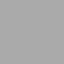

In [66]:
import lavavu
lv = lavavu.Viewer()
mesh.lv_plot_isosurface(
        fault.interpolators['gx'].propertyname,
       colour='black',#  colour=colours[s],
        isovalue=0,
        name=fault.interpolators['gx'].propertyname,
        interactive=False,
        lv=lv,
        draw=False,
         region="r1"
#         region="FaultSegmentRegion%i"%s
    )
mesh.lv_plot_isosurface(
        fault2.interpolators['gx'].propertyname,
       colour='black',#  colour=colours[s],
        isovalue=0,
        name=fault2.interpolators['gx'].propertyname,
        interactive=False,
        lv=lv,
        draw=False,
         region="r1"
#         region="FaultSegmentRegion%i"%s
    )
# mesh.lv_plot_isosurface(
#         'strati',#fault.interpolators['gx'].propertyname,
# #         colour=colours[s],
#         isovalue=0,
#         name='stratigraphy',#fault.interpolators['gx'].propertyname,
#         interactive=False,
#         lv=lv,
#         draw=False,
# #         region="FaultSegmentRegion%i"%s
#     )
strati = mesh.properties['strati_int']
strati=strati[~np.isnan(strati)]
for s in np.linspace(np.min(strati),np.max(strati),10):#i in range(-10,10,2):

    mesh.lv_plot_isosurface(
            'strati_int',#fault.interpolators['gx'].propertyname,
    #         colour=colours[s],
            isovalue=s,
            name='stratigraphy_faultedhw%f'%s,#fault.interpolators['gx'].propertyname,
            interactive=False,
            lv=lv,
            draw=False,
            region="r1"
        )
#     mesh.lv_plot_isosurface(
#             'strati_int',#fault.interpolators['gx'].propertyname,
#     #         colour=colours[s],
#             isovalue=s,
#             name='stratigraphy_faultedfw%f'%s,#fault.interpolators['gx'].propertyname,
#             interactive=False,
#             lv=lv,
#             draw=False,
#             region="footwall"
#         )
# # surf = lv.triangles("strati_int",colour='green')
# # surf.vertices(stratinodes)
# # surf.indices(stratitris)

# # surf = lv.triangles("fault",colour='blue')
# # surf.vertices(faultnodes)
# # surf.indices(faulttris)

# # points = lv.points("points",pointsize=4,pointtype="sphere",colour='red')
# # points.vertices(mesh.nodes[mesh.elements[logic]])


lv.control.Panel()
lv.control.ObjectList()
lv.control.show()